# Imports, constants, helper functions

In [1]:
import ntpath
from tqdm import tqdm
import time
from datetime import timedelta
import altair as alt
import os
from os.path import join
from collections import defaultdict

import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import numpy as np
import math
from scipy.stats import skew, kurtosis
from haversine import haversine, Unit
from sklearn.cluster import DBSCAN

import warnings
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import plotly.graph_objs as go
from glob import glob
import ray  # https://velog.io/@otzslayer/Ray%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%B4-Python-%EB%B3%91%EB%A0%AC-%EC%B2%98%EB%A6%AC-%EC%89%BD%EA%B2%8C-%ED%95%98%EA%B8%B0
import ntpath

import pytz
utc=pytz.UTC

def substract_lists(l1, l2): 
    return [x for x in l1 if x not in l2]

def extract_sensorID(path):
    fn = ntpath.basename(path)
    return fn.split('.csv')[0].split('_')[1]

# remove users whose dataset are not in the specified directory
def get_removed_user_id_list():
    removed_user_id_list = []
    folders = os.listdir(DATAROOT_5)
    for folder in folders:
        user_id = int(folder.split("-")[-1])
        try:
            df = pd.read_csv(f'{DATAROOT_5}/{folder}/{user_id}_11.csv')
            if len(df) == 0:
                removed_user_id_list.append(user_id)
        except FileNotFoundError as e:
            removed_user_id_list.append(user_id)
    return removed_user_id_list 

#DATAROOT = r'C:\Users\이용건\OneDrive - 한국에너지공과대학교\KENTECH\IMC Lab\STDD\Dataset_stdd\campaign5_02-17-2022\Android' for home root
DATAROOT = r'C:\Users\shaba\OneDrive - 한국에너지공과대학교\KENTECH\IMC Lab\STDD\campaign5_data' 
CAMPAIGN_ID = '5'

# Define user ID: Manual work?
#REMOVE_PIDs_4 = [82, 84, 96, 99, 149, 117, 115, 120]
#EXTREME_PIDs_4 = [102, 104, 107, 113, 120, 150, 151, 152, 154, 171, 172, 82, 86, 90, 98]
#TEST_PIDs_5 = list(set([4, 7, 8, 9, 10, 11, 15, 16, 17, 22, 32, 162, 289, 321, 512, 517, 545, 594, 681, 732, 734, 755, 763, 764, 767, 768, 770, 774, 777, 780, 781, 782, 783, 784, 785] + get_removed_user_id_list() ))


BYTES_IN_MB = (2**10)*(2**10)

MS_IN_SEC = 1000 #1sec = 1000msec
SEC_IN_MIN = 60
MIN_IN_HOUR = 60
HOUR_IN_DAY = 24

MS_IN_MIN = MS_IN_SEC* SEC_IN_MIN 
MS_IN_HOUR = MS_IN_MIN * MIN_IN_HOUR
MS_IN_DAY = HOUR_IN_DAY*MIN_IN_HOUR*SEC_IN_MIN*MS_IN_SEC # day    
SEC_IN_HOUR = SEC_IN_MIN*MIN_IN_HOUR
SEC_IN_DAY = SEC_IN_HOUR*HOUR_IN_DAY

WIN_SIZES = [4, 12, 24, 72, 24*7, 24*14, 24*21, 24*28]  # in hours

# not needed
MARKERS = ['.',',','v','1','2','3','4','8','p','P','h','H','+','x','X','|','s','*','<','o','^','d','D','>']#25 markers for plotting

# not needed
APPUSAGE_SUBCATEGORIES={
    'browser': [
        'com.android.chrome',
        'com.chrome.beta',
        'com.chrome.canary',
        'com.google.android.googlequicksearchbox',
        'com.vivaldi.browser',
        'com.naver.whale',
        'ai.blokee.browser.android',
        'com.nhn.android.search',
        'com.sec.android.app.sbrowser',
        'net.onecook.browser',
        'com.microsoft.emmx',
        'com.brave.browser',
        'org.mozilla.firefox',
        'com.opera.browser',
        'savannah.internet.web.browser',
        'com.cloudmosa.puffinFree'
    ],
    'music': [
        'com.aimp.player',
        'com.google.android.apps.youtube.music',
        'com.spotify.music',
        'com.soundcloud.android',
        'com.sec.android.app.music',
        'com.melonhealth.betame',
        'com.ktmusic.geniemusic',
        'skplanet.musicmate',
        'com.naver.vibe',
        'com.neowiz.android.bugs'
    ],
    'youtube' : ['com.google.android.youtube'],
    'kakao' : ['com.kakao.talk']
    }

import ntpath
import os
def ensure_dir(filepath):
    try:
        os.makedirs(ntpath.split(filepath)[0])
    except FileExistsError:
        pass

In [2]:
df = {'id': [1, 5, 6, 8, 9, 27, 28, 26, 29, 80, 24, 23, 22, 10, 4, 20, 18 ,81, 17 ,16, 15, 11, 14, 13, 25],
      'name':[ 
      'ACTIVITY_RECOGNITION',
      'ANDROID_GRAVITY',
      'ANDROID_LIGHT',
      'ANDROID_SIGNIFICANT_MOTION',
      'ANDROID_STEP_DETECTOR',
      'ANDROID_WIFI',
      'APPLICATION_USAGE',
      'CALENDAR',
      'CALLS',
      'ANDROID_HEART_RATE',
      'INSTAGRAM_FEATURES',
      'KEYSTROKE_LOG',
      'LOCATIONS_MANUAL',
      'LOCATION_GPS',
      'MUSIC_PLAYING',
      'NOTIFICATIONS',
      'SCREEN_STATE',
      'SLEEP',
      'SMS',
      'SOUND_DATA',
      'STORED_MEDIA',
      'SURVEY_EMA',
      'TYPING',
      'UNLOCK_STATE',
      'UNKNOWN']
}

sensor2id_df = pd.DataFrame(data=df)

def map_sensorName2ID(sensorname):
    mapper = sensor2id_df
    mapper = mapper[mapper.id.isin(sensorIDS)]
    mapper.set_index('id').sort_index().T
    id = mapper[mapper.name==sensorname]['id'].values[0]

    return str(id)

def map_sensorName2ID(sensorname):

    return str(sensor2id_df.loc[sensor2id_df['name']==sensorname]['id'].values[0])

def map_ID2sensorName(num):
    mapper = sensor2id_df
    mapper.set_index('id').sort_index().T
    name = mapper[mapper.id==int(num)]['name'].values[0]

    return name

In [3]:
def load_data(path, sensorName, pids, cols, dtypes):     # exclude dataroot, column,
    df_concat = list()
    for pid in tqdm(pids):        
    #for users in tqdm(os.listdir(path)):
        try:
            #user_path = join(path, users)
            #pid = users.split('-')[1]
            #sensor_path = join(user_path, '{}_{}.csv'.format(pid, map_sensorName2ID(sensorName)))
            sensor_path = join(path,'5-{}'.format(pid),'{}_{}.csv'.format(pid, map_sensorName2ID(sensorName)))
            df = pd.read_csv(sensor_path)
            
            for i in range(len(cols)):
                if len(cols) > 1:
                    df[cols[i]] = df['values'].str.split().str[i]  
                else: pass
            
            df = df.drop('values', axis = 1)         
            df.insert(0,'pid',pid, allow_duplicates=False if len(df.columns)>1 else True ) 
            df = df.astype(dtypes)

            df_concat.append(df)

        except Exception as e:
            pass

    dfc = pd.concat(df_concat)
    dfc['pid'] = dfc['pid'].astype(int)

    try:
        if sensorName == 'CALLS':
            M_for_missed = dfc['flag']=='MISSED'
            dfc.loc[M_for_missed, 'end'] = dfc.loc[M_for_missed, 'start']
            dfc['start'] = pd.to_datetime(dfc['start'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
            dfc['end'] = pd.to_datetime(dfc['end'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
            dfc['timestamp'] = dfc['end']
        if sensorName == 'NOTIFICATIONS': 
            dfc['arrival_time'] = dfc['timestamp'] 
            dfc['timestamp'] = pd.to_datetime(dfc['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
        elif 'timestamp' not in df.columns:
            dfc['timestamp'] = pd.to_datetime(dfc['end'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
        else:
            dfc['timestamp'] = pd.to_datetime(dfc['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    except Exception as error:
        print("Should have at least timestamp or end")
        raise 'An exception occurred: {}'.format(error)
        
    dfc.set_index(['pid','timestamp'], inplace=True)
    dfc.sort_index(inplace=True)

    return dfc


In [4]:
def load_batch_data(path, sensorName, pid, cols, dtypes):     # exclude dataroot, column,
    try:
        sensor_path = join(path,'5-{}'.format(pid),'{}_{}.csv'.format(pid, map_sensorName2ID(sensorName)))
        df = pd.read_csv(sensor_path)
        
        for i in range(len(cols)):
            if len(cols) > 1:
                df[cols[i]] = df['values'].str.split().str[i]  
            else: pass
        
        df = df.drop('values', axis = 1)         
        df.insert(0,'pid',pid, allow_duplicates=False if len(df.columns)>1 else True ) 
        df = df.astype(dtypes)

    except Exception as e:
        pass

    df['pid'] = df['pid'].astype('int16')

    try:
        if sensorName == 'CALLS':
            M_for_missed = df['flag']=='MISSED'
            df.loc[M_for_missed, 'end'] = df.loc[M_for_missed, 'start']
            df['start'] = pd.to_datetime(df['start'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
            df['end'] = pd.to_datetime(df['end'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
            df['timestamp'] = df['end']
        elif 'timestamp' not in df.columns:
            df['timestamp'] = df['end'] # for what sensor?
        else:
            pass

    except Exception as error:
        print("Should have at least timestamp or end")
        raise 'An exception occurred: {}'.format(error)
        
    return df

In [10]:
aos_path = join(DATAROOT, 'Android')
pfolders = [ntpath.basename(pfolder) for pfolder in glob(join(aos_path,  f'{CAMPAIGN_ID}-*'))]

print('number of participants:',len(pfolders))
print('participant folder structure example:', pfolders[0])
#print('sensor sources for each participant',set([len(glob(join(aos_path ,pfolder,'*.csv'))) for pfolder in pfolders]))

sensorIDS = sorted([(extract_sensorID(sensor_file)) for sensor_file in glob(join(aos_path, pfolders[0],'*.csv'))])
print('sensor ids:', sensorIDS)
print('number of sensors:', len(sensorIDS))


number of participants: 503
participant folder structure example: 5-103
sensor ids: ['1', '10', '11', '13', '14', '15', '16', '17', '18', '20', '22', '23', '24', '25', '26', '27', '28', '29', '4', '5', '6', '8', '80', '81', '9']
number of sensors: 25


In [11]:
ios_path = join(DATAROOT, 'iOS')
pfolders = [ntpath.basename(pfolder) for pfolder in glob(join(ios_path,  f'{CAMPAIGN_ID}-*'))]

print('number of participants:',len(pfolders))
print('participant folder structure example:', pfolders[0])
#print('sensor sources for each participant',set([len(glob(join(ios_path ,pfolder,'*.csv'))) for pfolder in pfolders]))

sensorIDS = sorted([(extract_sensorID(sensor_file)) for sensor_file in glob(join(ios_path, pfolders[0],'*.csv'))])
print('sensor ids:', sensorIDS)
print('number of sensors:', len(sensorIDS))

#sensorIDS = list(map(int, sensorIDS))

number of participants: 264
participant folder structure example: 5-100
sensor ids: ['1', '10', '11', '13', '14', '15', '16', '17', '18', '20', '22', '23', '24', '25', '26', '27', '28', '29', '4', '5', '6', '8', '80', '81', '9']
number of sensors: 25


# Data-Checkups

## 1. Dictionary for Pre-processing 

In [285]:
aos_dict = {}
sensor_num = df['id'].copy()
sensor_num.sort()

for i in range(25):
    feature = map_ID2sensorName(sensor_num[i])
    user_df_list = list()
    aos_dict[feature] = user_df_list   

for users in tqdm(os.listdir(aos_path)):
    user_path = join(aos_path, users)
    pid = users.split('-')[1]
    for file in os.listdir(user_path): 
        name = map_ID2sensorName(file.split('_')[1].split('.')[0])
        df = pd.read_csv(join(user_path, file), index_col=0)
        if len(df) == 0:
            continue
        df = df.drop('values', axis=1)
        df.insert(0,'pid', pid, allow_duplicates=False if len(df.columns)>1 else True)
        aos_dict[name].append(df)
    

100%|██████████| 503/503 [15:22<00:00,  1.83s/it]


In [277]:
ios_dict = {}

for i in range(25):
    feature = map_ID2sensorName(sensor_num[i])
    user_df_list = list()
    ios_dict[feature] = user_df_list   

for users in tqdm(os.listdir(ios_path)):
    user_path = join(ios_path, users)
    pid = users.split('-')[1]
    for file in os.listdir(user_path): 
        name = map_ID2sensorName(file.split('_')[1].split('.')[0])
        df = pd.read_csv(join(user_path, file), index_col=0)
        if len(df) == 0:
            continue
        df = df.drop('values', axis=1)
        df.insert(0,'pid', pid, allow_duplicates=False if len(df.columns)>1 else True)
        ios_dict[name].append(df)

100%|██████████| 264/264 [00:38<00:00,  6.92it/s]


In [305]:
import pickle
 # save data
with open('dict_aos_data/aos_dict.pickle', 'wb') as fw:
    pickle.dump(aos_dict, fw)

with open('dict_ios_data/ios_dict.pickle', 'wb') as fw:
    pickle.dump(ios_dict, fw)

## 2. Overview of Data (with Participants Screening)

In [43]:
import pandas as pd
df_pids = pd.read_excel('IITP_참가자 스크리닝_Data Sharing_220705 (최종).xlsx', sheet_name='STUDY PARTICIPANT(ALL)')
df_pids.columns = df_pids.iloc[1]
df_pids = df_pids[2:]

In [258]:
aos_pids_gt = set(df_pids.loc[df_pids['디바이스']=='ANDROID']['ID'].astype(int))
ios_pids_gt = set(df_pids.loc[df_pids['디바이스']=='IOS']['ID'].astype(int))
aos_folders= pd.Series(os.listdir(join(DATAROOT, 'Android')))
ios_folders= pd.Series(os.listdir(join(DATAROOT, 'iOS')))
aos_pids_dir = set(aos_folders.str[2:].astype(int))
ios_pids_dir = set(ios_folders.str[2:].astype(int))

In [268]:
print('-'*5, 'Android', '-'*5)
print('# of pids in backup data:', len(aos_pids_dir) )
print('# of pids:', len(aos_pids_gt) )
print('Pids not in backup data:', aos_pids_gt - aos_pids_dir-{876})
#print('Same pids:', aos_pids_dir - aos_pids_gt) # solved 563 = 876
print('-'*5, 'iOS', '-'*5)
print('# of pids in backup data:', len(ios_pids_dir) )
print('# of pids:', len(ios_pids_gt) )
#print('Same pids:', ios_pids_dir - ios_pids_gt) # solved 582 = 873

----- Android -----
# of pids in backup data: 503
# of pids: 506
Pids not in backup data: {858, 779, 438}
----- iOS -----
# of pids in backup data: 264
# of pids: 264


3 users' data are gone (770 -> 767) No 특이사항

In [288]:
sensors = aos_dict.keys()
aos_values = list()
ios_values = list()


for key in aos_dict.keys():
    
    aos_values.append(len(aos_dict[key]))
    ios_values.append(len(ios_dict[key]))

df_all = pd.DataFrame(index = sensors, data = np.concatenate([np.array(aos_values).reshape(25,1), np.array(ios_values).reshape(25,1)], axis=1), columns=['Android', 'iOS'])

In [289]:
df_all

,Android,iOS
ACTIVITY_RECOGNITION,399,245
MUSIC_PLAYING,274,43
ANDROID_GRAVITY,399,245
ANDROID_LIGHT,397,0
ANDROID_SIGNIFICANT_MOTION,401,243
ANDROID_STEP_DETECTOR,386,242
LOCATION_GPS,403,245
SURVEY_EMA,382,228
UNLOCK_STATE,402,245
TYPING,401,0


In [290]:
aos_sensor_removed = ['INSTAGRAM_FEATURES', 'MUSIC_PLAYING', 'UNKNOWN', 'LOCATIONS_MANUAL', 'ANDROID_HEART_RATE', 'SLEEP', 'CALENDAR', 'ANDROID_WIFI', 'STORED_MEDIA', 'SMS']
aos_sensors = list(aos_dict.keys() - set(aos_sensor_removed))

ios_sensor_removed = ['APPLICATION_USAGE', 'ANDROID_WIFI', 'INSTAGRAM_FEATURES', 'KEYSTROKE_LOG', 'NOTIFICATIONS', 'SMS', 'TYPING', 'ANDROID_LIGHT', 'MUSIC_PLAYING', 'UNKNOWN', 'LOCATIONS_MANUAL', 'ANDROID_HEART_RATE', 'SLEEP', 'CALENDAR', 'STORED_MEDIA', 'SMS']
ios_sensors = list(ios_dict.keys() - set(ios_sensor_removed))

print('Android sensors:', aos_sensors)
print('iOS sensors:', ios_sensors)


Android sensors: ['SURVEY_EMA', 'ACTIVITY_RECOGNITION', 'APPLICATION_USAGE', 'NOTIFICATIONS', 'TYPING', 'LOCATION_GPS', 'ANDROID_STEP_DETECTOR', 'UNLOCK_STATE', 'KEYSTROKE_LOG', 'CALLS', 'SCREEN_STATE', 'ANDROID_LIGHT', 'ANDROID_GRAVITY', 'ANDROID_SIGNIFICANT_MOTION', 'SOUND_DATA']
iOS sensors: ['SURVEY_EMA', 'ACTIVITY_RECOGNITION', 'LOCATION_GPS', 'ANDROID_STEP_DETECTOR', 'UNLOCK_STATE', 'CALLS', 'SCREEN_STATE', 'ANDROID_GRAVITY', 'ANDROID_SIGNIFICANT_MOTION', 'SOUND_DATA']


In [292]:
df_all.loc[aos_sensors]['Android']

SURVEY_EMA                    382
ACTIVITY_RECOGNITION          399
APPLICATION_USAGE             403
NOTIFICATIONS                 403
TYPING                        401
LOCATION_GPS                  403
ANDROID_STEP_DETECTOR         386
UNLOCK_STATE                  402
KEYSTROKE_LOG                 402
CALLS                         395
SCREEN_STATE                  402
ANDROID_LIGHT                 397
ANDROID_GRAVITY               399
ANDROID_SIGNIFICANT_MOTION    401
SOUND_DATA                    401
Name: Android, dtype: int32

In [294]:
df_all.loc[ios_sensors]['iOS']

SURVEY_EMA                    228
ACTIVITY_RECOGNITION          245
LOCATION_GPS                  245
ANDROID_STEP_DETECTOR         242
UNLOCK_STATE                  245
CALLS                         228
SCREEN_STATE                  245
ANDROID_GRAVITY               245
ANDROID_SIGNIFICANT_MOTION    243
SOUND_DATA                    255
Name: iOS, dtype: int32

In [296]:
aos_ema = aos_dict['SURVEY_EMA']

df_list = list()
for df in aos_ema:
    df_list.append(df)
aos_ema = pd.concat(df_list)    
aos_ema = aos_ema.astype(int)
aos_pids = list(set(aos_ema['pid']))

ios_ema = ios_dict['SURVEY_EMA']

df_list = list()
for df in ios_ema:
    df_list.append(df)
ios_ema = pd.concat(df_list)    
ios_ema = ios_ema.astype(int)
ios_pids = list(set(ios_ema['pid']))

In [297]:
aos_pids_common = set(aos_ema['pid'])
for sensor in aos_sensors:
    aos_list = aos_dict[sensor]
    df_list = list()
    for df in aos_list:
        df_list.append(df.astype('int'))
    aos_df = pd.concat(df_list)    
    aos_pids = set(aos_df['pid'])
    aos_pids_common = aos_pids_common & aos_pids

ios_pids_common = set(ios_ema['pid'])
for sensor in ios_sensors:
    ios_list = ios_dict[sensor]
    df_list = list()
    for df in ios_list:
        df_list.append(df.astype('int'))
    ios_df = pd.concat(df_list)    
    ios_pids = set(ios_df['pid'])
    ios_pids_common = ios_pids_common & ios_pids

In [299]:
print('# of Android users with all sensor data:', len(aos_pids_common))
print('# of iOS users with all sensor data:', len(ios_pids_common))

# of Android users with all sensor data: 356
# of iOS users with all sensor data: 221


In [ ]:
aos_sample_df = pd.DataFrame()
for sensor in aos_sensors:
    df_list = aos_dict[sensor]
    num_list = list()
    pidlist = list()
    for df in df_list:
        if int(df.values[0][0]) in aos_pids:
            num_list.append(len(df))
            pidlist.append(int(df.values[0][0]))
    aos_sample_df[sensor] = num_list    
aos_sample_df.index = pidlist

ios_sample_df = pd.DataFrame()
for sensor in ios_sensors:
    df_list = ios_dict[sensor]
    num_list = list()
    pidlist = list()
    for df in df_list:
        if int(df.values[0][0]) in ios_pids:
            num_list.append(len(df))
            pidlist.append(int(df.values[0][0]))
    ios_sample_df[sensor] = num_list    
ios_sample_df.index = pidlist

In [352]:
aos_sample_df.describe()

,SURVEY_EMA,ACTIVITY_RECOGNITION,APPLICATION_USAGE,NOTIFICATIONS,TYPING,LOCATION_GPS,ANDROID_STEP_DETECTOR,UNLOCK_STATE,KEYSTROKE_LOG,CALLS,SCREEN_STATE,ANDROID_LIGHT,ANDROID_GRAVITY,ANDROID_SIGNIFICANT_MOTION,SOUND_DATA
count,356.000000,356.000000,356.000000,3.560000e+02,356.000000,356.000000,3.560000e+02,356.000000,3.560000e+02,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,76.132022,1853.775281,11398.898876,5.779995e+05,12145.831461,7964.370787,1.603594e+05,6743.839888,3.333239e+05,676.901685,10740.278090,4303.662921,7384.620787,140.800562,6407.351124
std,40.071443,1353.030439,9218.089141,8.376963e+05,12377.299157,5665.603797,1.523745e+05,5069.451210,3.444359e+05,759.105177,8249.366961,2701.312424,4647.468015,108.148917,5026.212192
min,1.000000,12.000000,74.000000,4.470000e+02,14.000000,11.000000,5.730000e+02,92.000000,2.140000e+02,3.000000,149.000000,13.000000,62.000000,1.000000,6.000000
25%,58.750000,823.250000,5441.500000,1.795320e+05,4120.750000,4152.500000,6.342050e+04,3188.000000,1.097622e+05,247.500000,5232.250000,2686.250000,4359.500000,69.000000,2721.500000
50%,79.000000,1671.500000,9490.000000,3.330075e+05,8249.500000,7006.000000,1.244060e+05,5670.500000,2.362900e+05,446.000000,9238.000000,4109.500000,6875.000000,114.500000,5060.000000
75%,89.000000,2542.250000,14271.250000,6.738528e+05,15702.500000,10625.500000,2.152600e+05,9060.500000,4.495415e+05,874.500000,13647.750000,5311.500000,9432.250000,184.000000,9370.250000
max,208.000000,9586.000000,54686.000000,9.375743e+06,90828.000000,39364.000000,1.417161e+06,34122.000000,2.508051e+06,6345.000000,62602.000000,18841.000000,28644.000000,864.000000,30132.000000


In [353]:
ios_sample_df.describe()

,SURVEY_EMA,ACTIVITY_RECOGNITION,LOCATION_GPS,ANDROID_STEP_DETECTOR,UNLOCK_STATE,CALLS,SCREEN_STATE,ANDROID_GRAVITY,ANDROID_SIGNIFICANT_MOTION,SOUND_DATA
count,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,48.837104,14193.900452,2538.352941,12667.375566,2504.375566,252.846154,3748.828054,1352.723982,7489.488688,362.226244
std,34.935664,16671.262616,9071.191716,16511.311066,3036.240971,329.695195,4298.536766,1538.151075,9514.595706,415.367344
min,1.000000,145.000000,6.000000,15.000000,15.000000,1.000000,49.000000,34.000000,20.000000,1.000000
25%,18.000000,3183.000000,272.000000,2225.000000,558.000000,40.000000,776.000000,420.000000,1374.000000,131.000000
50%,48.000000,9547.000000,781.000000,7252.000000,1642.000000,143.000000,2362.000000,905.000000,4207.000000,281.000000
75%,68.000000,19164.000000,1625.000000,16029.000000,3221.000000,322.000000,4974.000000,1598.000000,10290.000000,450.000000
max,190.000000,122502.000000,104832.000000,152219.000000,25351.000000,2098.000000,26652.000000,10240.000000,75194.000000,4728.000000


### Participants with two pids (Done)

1. Matched pids
* 이명환: 14  25  
* 박사라: 81  120 
* 김태경: 183  184 
* 장지웅: 244  517 
* 이복순: 553  551 
* 심동민: 633  859

2. Unmatched pids
* 하성영: 873  582 (iOS)   
* 김효주: 876  563 (Android) 

In [110]:
# integrate the participants data with two pids

pid1_o = os.listdir(join(DATAROOT, 'Android', '5-563')) 
pid1_a = os.listdir(join(DATAROOT, 'Android', '5-876')) 
pid2_o = os.listdir(join(DATAROOT, 'iOS', '5-582')) 
pid2_a = os.listdir(join(DATAROOT, 'iOS', '5-873')) 

import re

for sensor in pid1_a:
    df_o = pd.read_csv(join(DATAROOT, 'Android', '5-563', '563_'+re.sub("876_", '', sensor)), index_col=0)
    df_a = pd.read_csv(join(DATAROOT, 'Android', '5-876', '876_'+re.sub("876_", '', sensor)), index_col=0)
    pd.concat([df_o, df_a]).to_csv(join(DATAROOT, 'Android', '5-563', '563_'+re.sub("876_", '', sensor)))

for sensor in pid2_a:
    df_o = pd.read_csv(join(DATAROOT, 'iOS', '5-582', '582_'+re.sub("873_", '', sensor)), index_col=0)
    df_a = pd.read_csv(join(DATAROOT, 'iOS', '5-873', '873_'+re.sub("873_", '', sensor)), index_col=0)
    pd.concat([df_o, df_a]).to_csv(join(DATAROOT, 'iOS', '5-582', '582_'+re.sub("873_", '', sensor)))

In [183]:
# cannot remove
os.chmod(join(DATAROOT, 'Android', '5-876'), 0o777)
os.chmod(join(DATAROOT, 'iOS', '5-873'), 0o777)
os.remove(join(DATAROOT, 'Android', '5-876'))
os.remove(join(DATAROOT, 'iOS', '5-873'))

SyntaxError: invalid token (176203166.py, line 1)

In [ ]:
print('# of pids with data: EMA / total : ', len(set(aos_ema['pid'])), '/ 407')
print('# of pids with data: ambient light / total : ', len(set(aos_light['pid'])), '/ 407')
print('# of pids with data: ambient sound / total : ', len(set(aos_sound['pid'])), '/ 407')
print('# of pids with data: gravity / total : ', len(set(aos_gravity['pid'])), '/ 407')
print('# of pids with data: gps / total : ', len(set(aos_gps['pid'])), '/ 407')
#print('# of pids with 5 data sources / total : ', len(set(aos_ema['pid'])&set(aos_light['pid'])&set(aos_sound['pid'])&set(aos_gravity['pid'])&set(aos_gps['pid'])), '/ 407')
print('# of pids with all data sources / total : ', len(aos_pids_common), '/ 407')

# Sensor Source Filtering (Unnecessary)

## Previous Code

In [12]:
import pickle
with open('aos_data/aos_dict.pickle', 'rb') as fw:
    aos_dict = pickle.load(fw)

with open('ios_data/ios_dict.pickle', 'rb') as fw:
    ios_dict = pickle.load(fw)

In [16]:
ios_feature_df = list()
ios_pid_list = list()
ios_sample_list = list()

for sensor in ios_dict.keys():
    df = pd.concat(ios_dict[sensor])
    ios_pid_list.append(set(df['pid']))
    ios_sample_list.append(len(df))
    ios_feature_df.append(df)

In [ ]:
import plotly.express as px

x = list(ios_dict.keys())
px.bar(x=x, y=ios_sample_list, title='Number of Samples per Users').show()

In [ ]:
pidlist = list()
for i in range(len(ios_pid_list)):
    pidlist.append(len(ios_pid_list[i]))

px.bar(x=pidlist, y=ios_dict.keys(), title='Number of Users per Sensor (iOS)', height = 700, orientation='h').show()

In [19]:
sensor_removed = ['APPLICATION_USAGE', 'ANDROID_WIFI', 'INSTAGRAM_FEATURES', 'KEYSTROKE_LOG', 'NOTIFICATIONS', 'SMS', 'TYPING', 'ANDROID_LIGHT', 'MUSIC_PLAYING', 'UNKNOWN', 'LOCATIONS_MANUAL', 'ANDROID_HEART_RATE', 'SLEEP']
ios_sensors = list(ios_dict.keys() - set(sensor_removed))
ios_sensors

['CALENDAR',
 'ANDROID_SIGNIFICANT_MOTION',
 'UNLOCK_STATE',
 'STORED_MEDIA',
 'LOCATION_GPS',
 'ANDROID_GRAVITY',
 'CALLS',
 'ACTIVITY_RECOGNITION',
 'SOUND_DATA',
 'ANDROID_STEP_DETECTOR',
 'SCREEN_STATE',
 'SURVEY_EMA']

In [20]:
ios_pids = set(pd.concat(ios_dict[ios_sensors[0]])['pid'])
for sensor in ios_sensors[1:]:
    df = pd.concat(ios_dict[sensor])
    ios_pids = ios_pids & set(df['pid'])
print(len(ios_pids))

194


In [33]:
len(aos_pids)

NameError: name 'aos_pids' is not defined

In [ ]:
'''sensor_nodata = list()
for i in range(len(x)):
    sample = list()
    pidlist = list(ios_pid_list[i])
    pidlist.sort()
    if len(pidlist) == 0:
        sensor_nodata.append(x[i])
    else:    
        for pid in pidlist: 
            df = ios_feature_df[i].loc[ios_feature_df[i].pid==pid]
            sample.append(len(df))
        #fig = px.bar(x=pidlist, y=sample, title='Number of Samples per Users: {}'.format(x[i])).show()
        #fig.add_hline(y=)'''


In [21]:
aos_feature_df = list()
aos_pid_list = list()
aos_sample_list = list()

for sensor in aos_dict.keys():
    df = pd.concat(aos_dict[sensor])
    aos_pid_list.append(set(df['pid']))
    aos_sample_list.append(len(df))
    aos_feature_df.append(df)

In [22]:
x = list(aos_dict.keys())
px.bar(x=x, y=aos_sample_list, title='Number of Samples per Users').show()

In [23]:
pidlist = list()
for i in range(len(aos_pid_list)):
    pidlist.append(len(aos_pid_list[i]))

px.bar(x=pidlist, y=aos_dict.keys(), title='Number of Users per Sensor (AOS)', height = 700, orientation='h').show()
 

In [34]:
sensor_removed = ['INSTAGRAM_FEATURES', 'MUSIC_PLAYING', 'UNKNOWN', 'LOCATIONS_MANUAL', 'ANDROID_HEART_RATE', 'SLEEP']
aos_sensors = list(aos_dict.keys() - set(sensor_removed))
aos_sensors

['CALENDAR',
 'TYPING',
 'ANDROID_SIGNIFICANT_MOTION',
 'APPLICATION_USAGE',
 'UNLOCK_STATE',
 'STORED_MEDIA',
 'LOCATION_GPS',
 'ANDROID_GRAVITY',
 'ANDROID_LIGHT',
 'CALLS',
 'SMS',
 'NOTIFICATIONS',
 'ACTIVITY_RECOGNITION',
 'SOUND_DATA',
 'KEYSTROKE_LOG',
 'ANDROID_STEP_DETECTOR',
 'SCREEN_STATE',
 'SURVEY_EMA',
 'ANDROID_WIFI']

In [35]:
aos_pids = set(pd.concat(aos_dict[aos_sensors[0]])['pid'])
for sensor in aos_sensors[1:]:
    df = pd.concat(aos_dict[sensor])
    aos_pids = aos_pids & set(df['pid'])
print(len(aos_pids))

302


Need to check calendar, sleep, heartrate data

In [ ]:
'''sensor_nodata = list()
for i in range(len(x)):
    sample = list()
    pidlist = list(And_pid_list[i])
    pidlist.sort()
    if len(pidlist) == 0:
        sensor_nodata.append(x[i])
    else:    
        for pid in pidlist: 
            df = And_feature_df[i].loc[And_feature_df[i].pid==pid]
            sample.append(len(df))
        px.bar(x=pidlist, y=sample, title='Number of Samples per Users: {}'.format(x[i])).show()'''

# Participants Filtering: EMA & Sensor with Sampling Rate
### WiFi, Microphone, Gravity, Light, gps (Stored media, Calendar)

* EMA: Once in 3 days, 3 times a day (21 EMAs in 3 weeks) 
* light: every 15 mins
* sound: every 15 mins
* gravity: every 15 mins & event-based
* gps: every 5 ~ 15 mins (15 mins)
* (WiFi: every 30 mins): excluded

## Number of Weekly Avg Samples

In [7]:
import pickle

# load data
with open('dict_aos_data/aos_dict.pickle', 'rb') as fr:
    aos_dict = pickle.load(fr)

with open('dict_ios_data/ios_dict.pickle', 'rb') as fr:
    ios_dict = pickle.load(fr)

### Previous Code (Before Data Cleaning and Feature Extraction)

In [9]:
# Additional sensors to remove: calendar, stored media, android wifi, sms
aos_sensor_removed = ['INSTAGRAM_FEATURES', 'MUSIC_PLAYING', 'UNKNOWN', 'LOCATIONS_MANUAL', 'ANDROID_HEART_RATE', 'SLEEP', 'CALENDAR', 'ANDROID_WIFI', 'STORED_MEDIA', 'SMS']
aos_sensors = list(aos_dict.keys() - set(aos_sensor_removed))

ios_sensor_removed = ['APPLICATION_USAGE', 'ANDROID_WIFI', 'INSTAGRAM_FEATURES', 'KEYSTROKE_LOG', 'NOTIFICATIONS', 'SMS', 'TYPING', 'ANDROID_LIGHT', 'MUSIC_PLAYING', 'UNKNOWN', 'LOCATIONS_MANUAL', 'ANDROID_HEART_RATE', 'SLEEP', 'CALENDAR', 'STORED_MEDIA', 'SMS']
ios_sensors = list(ios_dict.keys() - set(ios_sensor_removed))

print('Android sensors:', aos_sensors)
print('iOS sensors:', ios_sensors)

aos_ema = aos_dict['SURVEY_EMA']

df_list = list()
for df in aos_ema:
    df_list.append(df)
aos_ema = pd.concat(df_list)    
aos_ema = aos_ema.astype(int)
aos_pids = list(set(aos_ema['pid']))

ios_ema = ios_dict['SURVEY_EMA']

df_list = list()
for df in ios_ema:
    df_list.append(df)
ios_ema = pd.concat(df_list)    
ios_ema = ios_ema.astype(int)
ios_pids = list(set(ios_ema['pid']))

aos_pids_common = set(aos_ema['pid'])
for sensor in aos_sensors:
    aos_list = aos_dict[sensor]
    df_list = list()
    for df in aos_list:
        df_list.append(df.astype('int'))
    aos_df = pd.concat(df_list)    
    aos_pids = set(aos_df['pid'])
    aos_pids_common = aos_pids_common & aos_pids

ios_pids_common = set(ios_ema['pid'])
for sensor in ios_sensors:
    ios_list = ios_dict[sensor]
    df_list = list()
    for df in ios_list:
        df_list.append(df.astype('int'))
    ios_df = pd.concat(df_list)    
    ios_pids = set(ios_df['pid'])
    ios_pids_common = ios_pids_common & ios_pids

Android sensors: ['ANDROID_STEP_DETECTOR', 'APPLICATION_USAGE', 'TYPING', 'ANDROID_SIGNIFICANT_MOTION', 'SCREEN_STATE', 'CALLS', 'SURVEY_EMA', 'ANDROID_GRAVITY', 'ANDROID_LIGHT', 'KEYSTROKE_LOG', 'LOCATION_GPS', 'NOTIFICATIONS', 'ACTIVITY_RECOGNITION', 'SOUND_DATA', 'UNLOCK_STATE']
iOS sensors: ['ANDROID_STEP_DETECTOR', 'ANDROID_SIGNIFICANT_MOTION', 'SCREEN_STATE', 'CALLS', 'SURVEY_EMA', 'ANDROID_GRAVITY', 'LOCATION_GPS', 'ACTIVITY_RECOGNITION', 'SOUND_DATA', 'UNLOCK_STATE']


In [182]:
# TBD: Partcipants with one constant label
aos_dunskewed = []
naos_dunskewed = []
aos_dpids = list()
naos_dpids = list()
for pid in aos_pids_common:
    df_pids = aos_ema.loc[aos_ema.pid==pid]
    depressed_count = len(df_pids.loc[df_pids.depressed==1])
    ndepressed_count = len(df_pids.loc[df_pids.depressed==0])
    if depressed_count > ndepressed_count:
      if (ndepressed_count/depressed_count) !=0:
        aos_dunskewed.append(pid)
      else: aos_dpids.append(pid)
    else :
      if (depressed_count/ndepressed_count) !=0:
        naos_dunskewed.append(pid)
      else: naos_dpids.append(pid)

aos_pids_ordered = []
aos_pids_ordered.extend(aos_dunskewed+aos_dpids+naos_dunskewed+naos_dpids)   

ios_dunskewed = []
nios_dunskewed = []
ios_dpids = list()
nios_dpids = list()
for pid in ios_pids_common:
    df_pids = ios_ema.loc[ios_ema.pid==pid]
    depressed_count = len(df_pids.loc[df_pids.depressed==1])
    ndepressed_count = len(df_pids.loc[df_pids.depressed==0])
    if depressed_count > ndepressed_count:
      if (ndepressed_count/depressed_count) !=0:
        ios_dunskewed.append(pid)
      else: ios_dpids.append(pid)
    else :
      if (depressed_count/ndepressed_count) !=0:
        nios_dunskewed.append(pid)
      else: nios_dpids.append(pid)

ios_pids_ordered = []
ios_pids_ordered.extend(ios_dunskewed+ios_dpids+nios_dunskewed+nios_dpids)   


ios_pids = ios_pids_common

print('---------------Android Users------------')
print('Users with more depressed labels')
print('# of users with one constant label:', len(aos_dpids))
print('# of users with two labels:', len(aos_dunskewed))
print('Users with less depressed labels')
print('# of users with one constant label:', len(naos_dpids))
print('# of users with two labels:', len(naos_dunskewed))
print('---------------iOS Users----------------')
print('Users with more depressed labels')
print('# of users with one constant label:', len(ios_dpids))
print('# of users with two labels:', len(ios_dunskewed))
print('Users with less depressed labels')
print('# of users with one constant label:', len(nios_dpids))
print('# of users with two labels:', len(nios_dunskewed))

# for removing one-labeled subjects
#aos_pids = aos_dunskewed + naos_dunskewed
#ios_pids = ios_dunskewed + nios_dunskewed

aos_pids = aos_pids_common

---------------Android Users------------
Users with more depressed labels
# of users with one constant label: 50
# of users with two labels: 69
Users with less depressed labels
# of users with one constant label: 65
# of users with two labels: 172
---------------iOS Users----------------
Users with more depressed labels
# of users with one constant label: 49
# of users with two labels: 70
Users with less depressed labels
# of users with one constant label: 21
# of users with two labels: 81


### Cut-offs for Filtering

In [22]:
# load ema data
aos_ema = pd.read_csv('aos_features/aos_survey.csv', index_col=0)
aos_ema.index = aos_ema['timestamp']
aos_ema = pd.DataFrame(aos_ema['pid'])
ios_ema = pd.read_csv('ios_features/ios_survey.csv', index_col=0)
ios_ema.index = ios_ema['timestamp']
ios_ema = pd.DataFrame(ios_ema['pid'])

# load gps data for pids
aos_gps = pd.read_csv('aos_features/aos_LOCATION_4HR.csv', index_col=0)
ios_gps = pd.read_csv('ios_features/ios_LOCATION_4HR.csv', index_col=0)
aos_pids = list(set(aos_gps.index))
ios_pids = list(set(ios_gps.index))


In [117]:
class PidsFiltering:
    def __init__(self, dict, ema, pids, sensors, window_size, cutoff) :
        self.dict = dict
        self.ema = ema
        self.pids = pids
        self.sensors = sensors
        self.ws = window_size
        self.cf = cutoff

    def makeDF(self, sensor):
        dfs = self.dict[sensor]
        df_list = list()
        for df in dfs:
            df_list.append(df)
        dfs = pd.concat(df_list)        

        return dfs.astype(int)
                
    def CountEMA(self):
        ema_dict = {}
        for pid in self.pids:
            df_ema = self.ema.loc[self.ema.pid== pid]
            sample_list = list()

            start = df_ema.index[0]
            end = df_ema.index[-1]
            week_dur = 7*24*3600*1000
            weeks = int((end-start)/week_dur)

            if weeks == 0: weeks = 1
            
            for i in range(weeks+1):
                df_window = df_ema[(df_ema.index>=start)&(df_ema.index<start+week_dur)]  
                sample_list.append(len(df_window))
                start += week_dur

            ema_dict[pid] = sample_list

        return ema_dict

    def CountSamples(self, sensor):
        dfs = self.makeDF(sensor)
        sample_dict = {}
        for pid in self.pids:
            df_ema = self.ema.loc[self.ema.pid == pid]
            df_sensor = dfs.loc[dfs.pid == pid]
            sample_list = list()
            
            for t in df_ema.index:   
                start = t-self.ws*3600*1000 
                df_window = df_sensor[(df_sensor.index>=start)&(df_sensor.index<t)]  
                sample_list.append(len(df_window))

            sample_dict[pid] = np.mean(sample_list)

        return sample_dict

    def AvgSamples(self):
        survived_pids = list()
        df = pd.DataFrame()
        th = "{}%".format(self.cf)

        dict_ema = self.CountEMA()
        ema_mean = list()
        for key in dict_ema:
            ema_list = dict_ema[key]
            ema_mean.append(np.mean(ema_list))
        df_ema = pd.DataFrame(index = self.pids, columns=['avg # of samples in a week'], data = ema_mean)
        
        avg_sample_dict = dict()
        for sensor in self.sensors:
            dict_sensor = self.CountSamples(sensor)
            df_sensor = pd.DataFrame(index = dict_sensor.keys(), columns = ['avg # of samples within {}h'.format(self.ws)], data = dict_sensor.values())
            avg_sample_dict[sensor] = df_sensor

        return avg_sample_dict,  df_ema 

In [46]:
aos_pf_sensors = ['ANDROID_LIGHT', 'SOUND_DATA','LOCATION_GPS', 'ANDROID_GRAVITY']
ios_pf_sensors = ['SOUND_DATA','LOCATION_GPS', 'ANDROID_GRAVITY']

aos_sample_list = list()
ios_sample_list = list()
for ws in tqdm(range(4, 5, 4)): 
    aos_pf = PidsFiltering(aos_dict, aos_ema, aos_pids, aos_pf_sensors, ws, 10)
    ios_pf = PidsFiltering(ios_dict, ios_ema, ios_pids, ios_pf_sensors, ws, 10)
    aos_sample_list.append(aos_pf.AvgSamples()[0])
    ios_sample_list.append(ios_pf.AvgSamples()[0])

aos_ema_df = aos_pf.AvgSamples()[1]
ios_ema_df = ios_pf.AvgSamples()[1]

100%|██████████| 1/1 [00:32<00:00, 32.43s/it]


In [53]:
# At least more than 4 data points are need for computing kurtosis

aos_pids_set = set(aos_pids)
for sensor in aos_pf_sensors:   
    pids = set(aos_sample_list[0][sensor].loc[aos_sample_list[0][sensor]['avg # of samples within 4h']>=5].index)
    aos_pids_set = aos_pids_set & pids

ios_pids_set = set(ios_pids)
for semsor in ios_pf_sensors:   
    pids = set(ios_sample_list[0][sensor].loc[ios_sample_list[0][sensor]['avg # of samples within 4h']>=5].index)
    ios_pids_set = ios_pids_set & pids

In [72]:
aos_ema_pids = set(aos_ema_df.loc[aos_ema_df['avg # of samples in a week']>3].index)
ios_ema_pids = set(ios_ema_df.loc[ios_ema_df['avg # of samples in a week']>3].index)

In [76]:
aos_pids = list(aos_pids_set & aos_ema_pids)
ios_pids = list(ios_pids_set & ios_ema_pids)

In [78]:
aos_ema_df.loc[aos_pids].describe()

,avg # of samples in a week
count,301.000000
mean,5.583487
std,0.875248
min,3.071429
25%,5.000000
50%,5.785714
75%,6.272727
max,6.923077


In [79]:
ios_ema_df.loc[ios_pids].describe()

,avg # of samples in a week
count,99.000000
mean,4.711203
std,0.800519
min,3.173913
25%,4.240385
50%,4.692308
75%,5.240385
max,6.461538


In [96]:
pid_dict = dict()
a = list(aos_pids)
b = list(ios_pids)
a.sort()
b.sort()
pid_dict['aos_pids'] = a
pid_dict['ios_pids'] = b

In [95]:
import pickle
 # save data
with open('pids.pickle', 'wb') as fw:
    pickle.dump(pid_dict, fw)

In [117]:
import pickle
 # save data
with open('aos_weekly_avg_samples.pickle', 'wb') as fw:
    pickle.dump(aos_sample_list, fw)

with open('ios_weekly_avg_samples.pickle', 'wb') as fw:
    pickle.dump(ios_sample_list, fw)

aos_ema_df.loc[aos_pids_set].to_csv('aos_weekly_avg_ema.csv')
ios_ema_df.loc[ios_pids_set].to_csv('ios_weekly_avg_ema.csv')

In [59]:
aos_ema_df = pd.read_csv('aos_weekly_avg_ema.csv', index_col=0)
ios_ema_df = pd.read_csv('ios_weekly_avg_ema.csv', index_col=0)
aos_pids = list(aos_ema_df.index)
aos_pids.sort()
ios_pids = list(ios_ema_df.index)
ios_pids.sort()

In [79]:
aos_survey = pd.read_csv('aos_features/aos_survey.csv', index_col=0)
aos_survey.index = aos_survey['pid']
aos_survey = aos_survey.loc[aos_pids]
aos_survey = aos_survey.reset_index(drop=True)
aos_survey.to_csv('aos_features/aos_survey.csv')

ios_survey = pd.read_csv('ios_features/ios_survey.csv', index_col=0)
ios_survey.index = ios_survey['pid']
ios_survey = ios_survey.loc[ios_pids]
ios_survey = ios_survey.reset_index(drop=True)
ios_survey.to_csv('ios_features/ios_survey.csv')

## Visualization: Data Completeness

#### Barplot: Weekly EMAs 

In [127]:
aos_dict_ema = CountEMA(aos_ema, aos_pids_common)
ema_mean = list()
for key in aos_dict_ema:
    ema_list = aos_dict_ema[key]
    ema_mean.append(np.mean(ema_list))
aos_emas= pd.DataFrame(index = aos_pids_common, columns=['avg # of samples in a week'], data = ema_mean)
aos_emas.describe()

,avg # of samples in a week
count,351.000000
mean,5.338598
std,1.436803
min,0.500000
25%,4.905702
50%,5.785714
75%,6.307692
max,10.600000


In [128]:
ios_dict_ema = CountEMA(ios_ema, ios_pids_common)
ema_mean = list()
for key in ios_dict_ema:
    ema_list = ios_dict_ema[key]
    ema_mean.append(np.mean(ema_list))
ios_emas = pd.DataFrame(index = ios_pids_common, columns=['avg # of samples in a week'], data = ema_mean)
ios_emas.describe()

,avg # of samples in a week
count,221.000000
mean,3.730745
std,1.570243
min,0.300000
25%,2.500000
50%,4.000000
75%,4.916667
max,6.500000


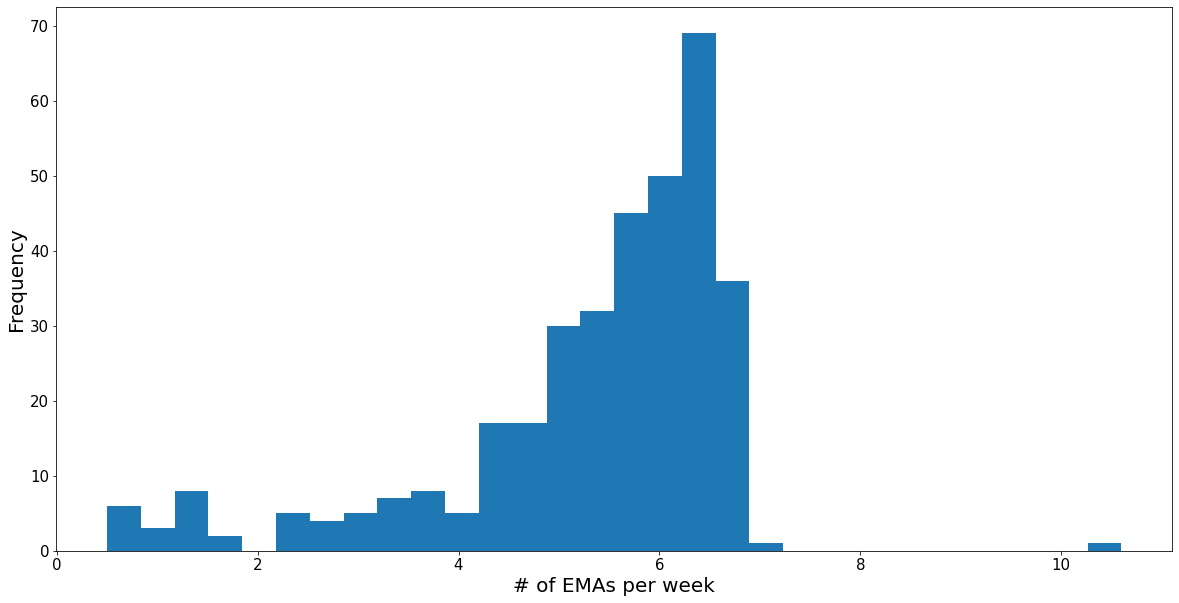

In [120]:
plt.figure(figsize=(20,10))
plt.tick_params(labelsize = 15)
plt.xlabel('# of EMAs per week', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.hist(aos_emas, bins=30)
plt.show()


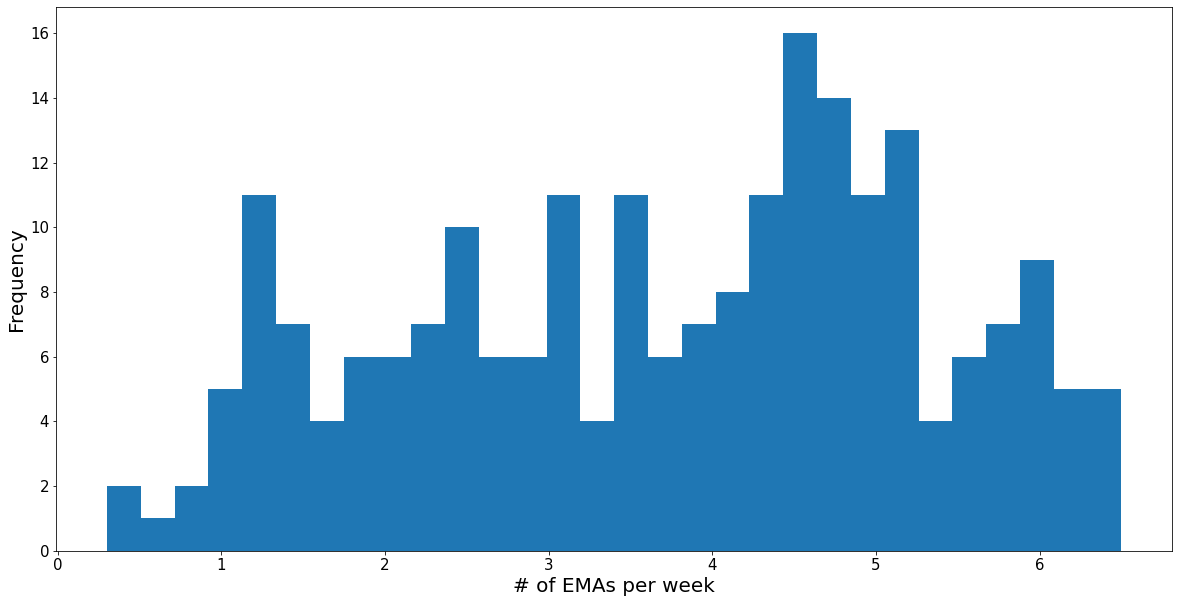

In [121]:
plt.figure(figsize=(20,10))
plt.tick_params(labelsize = 15)
plt.xlabel('# of EMAs per week', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.hist(ios_emas, bins=30)
plt.show()


### Number of EMAs in a week per Pids

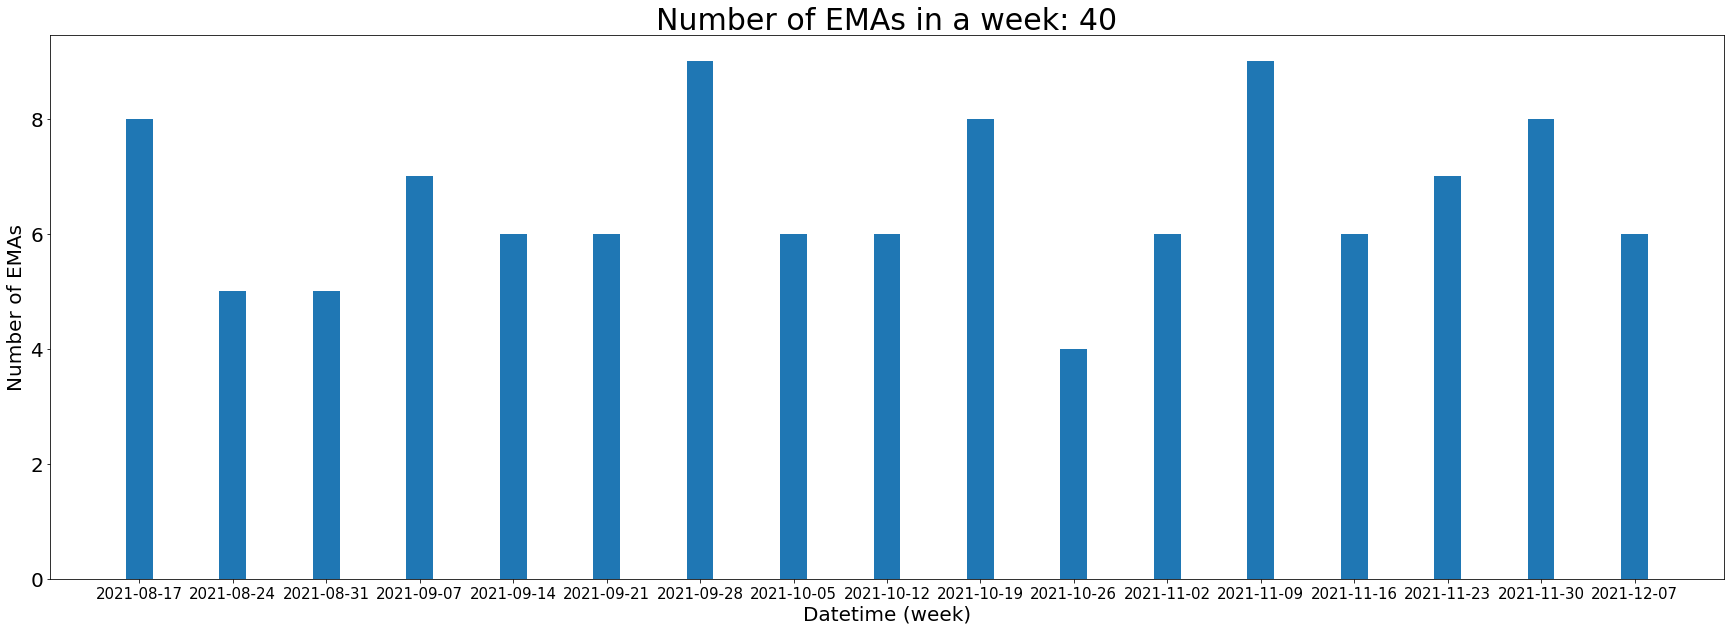

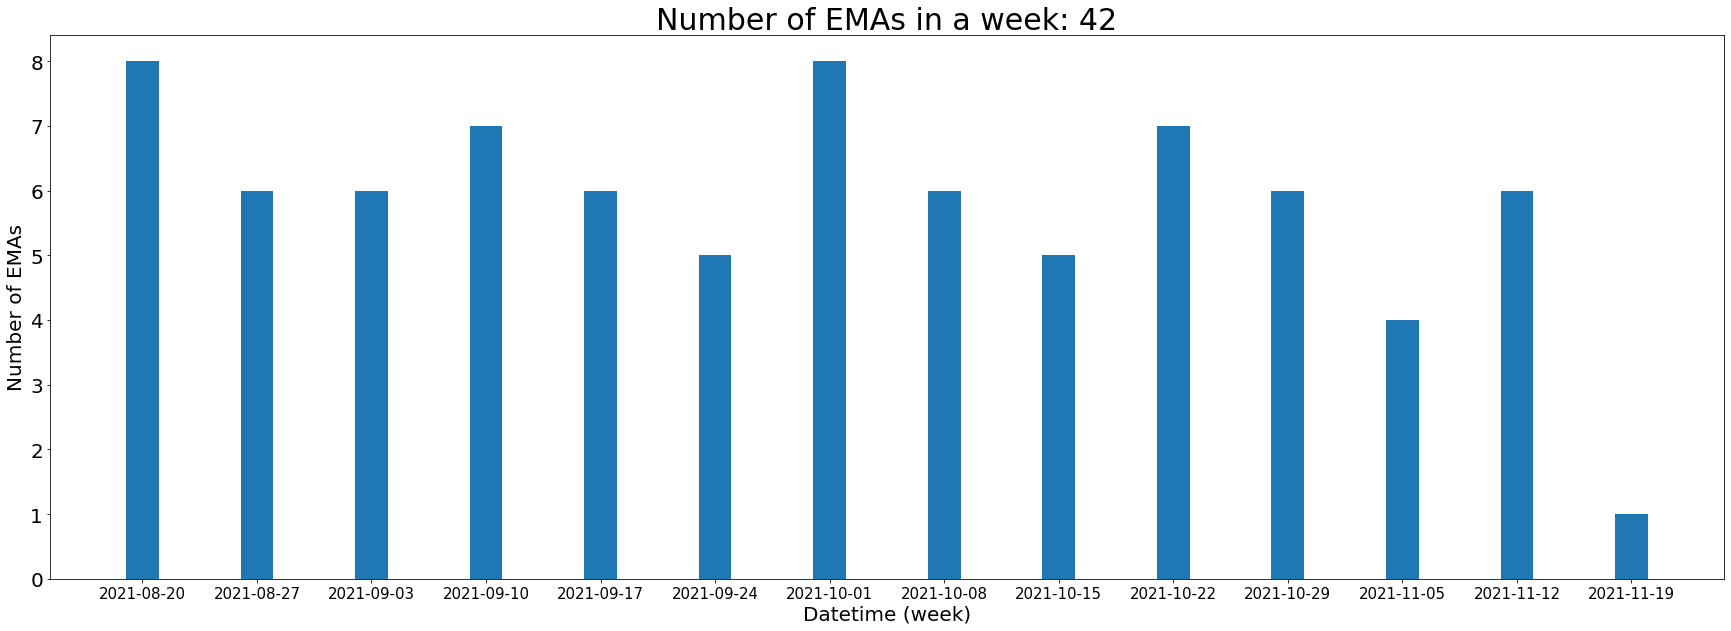

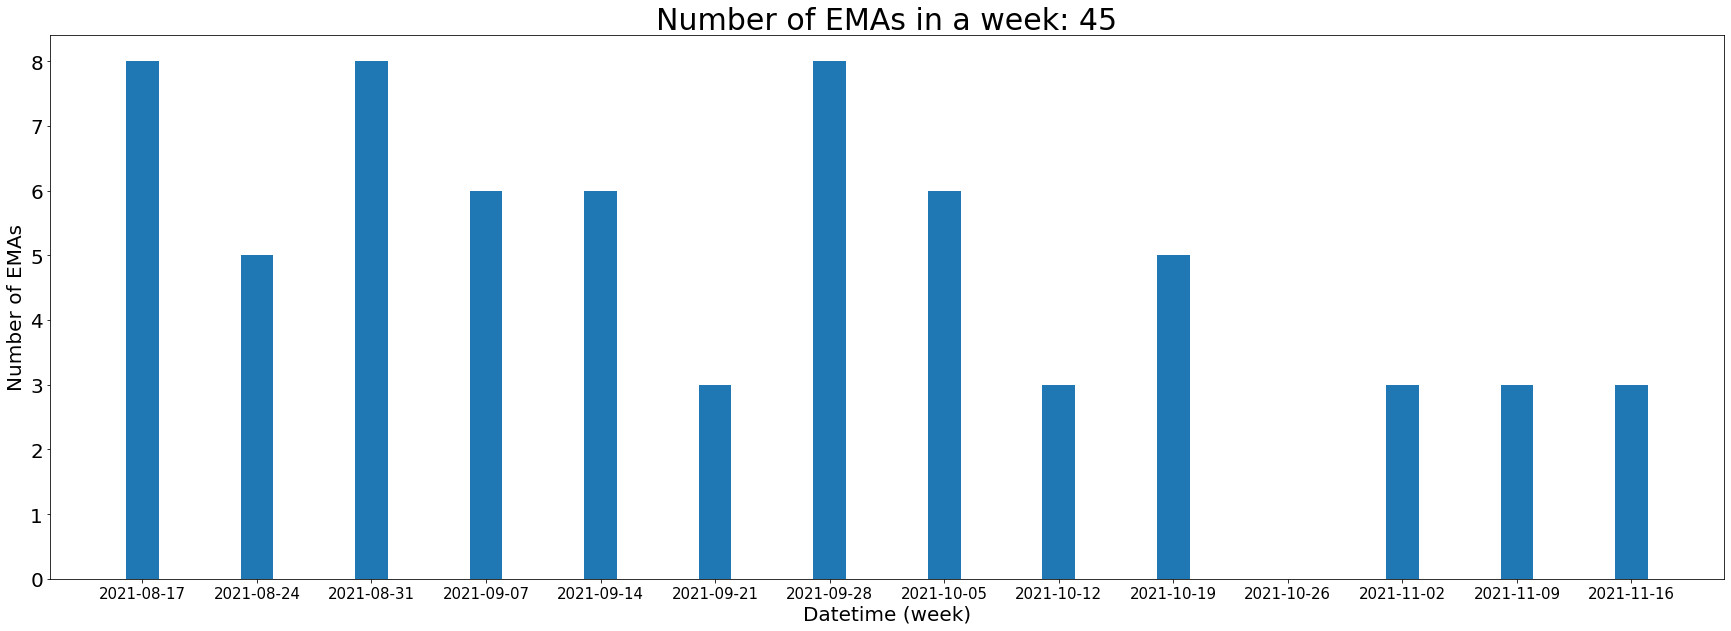

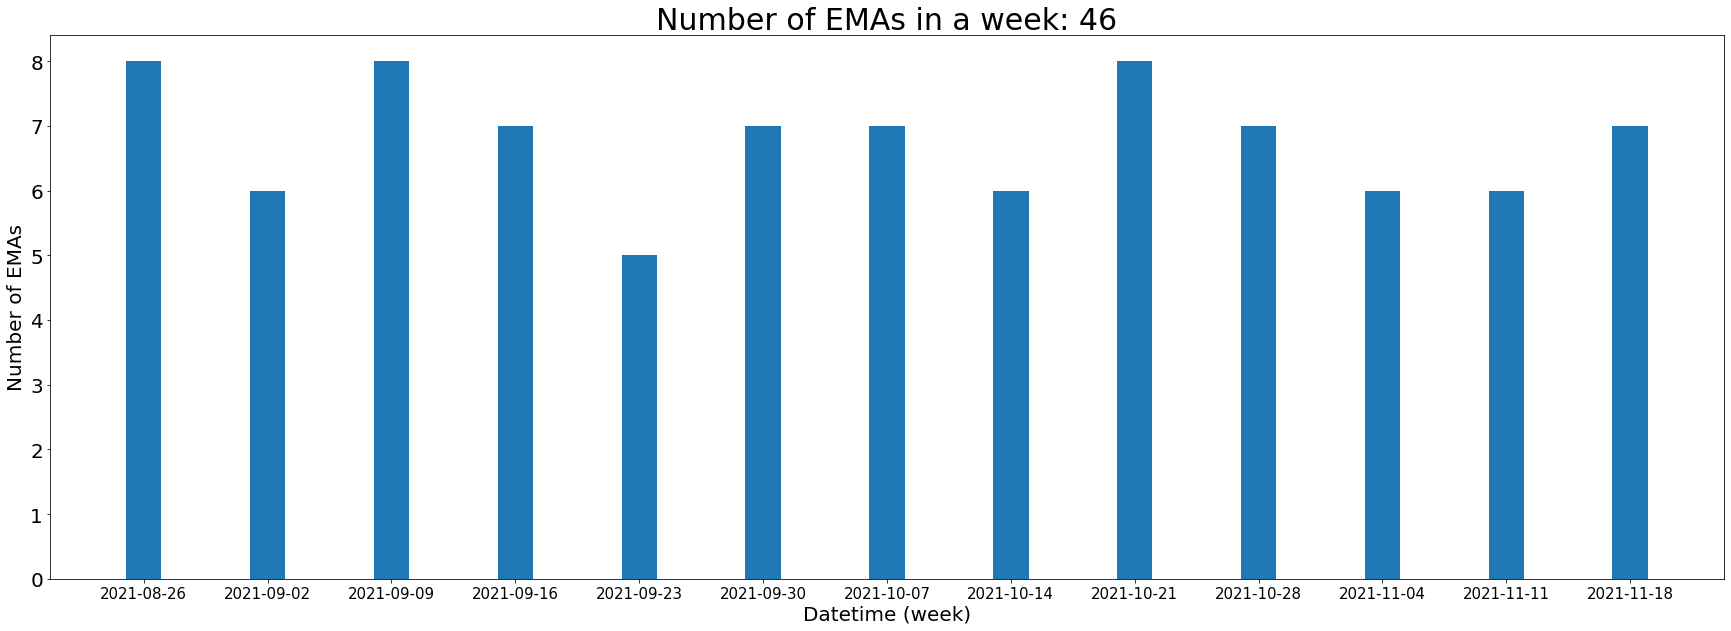

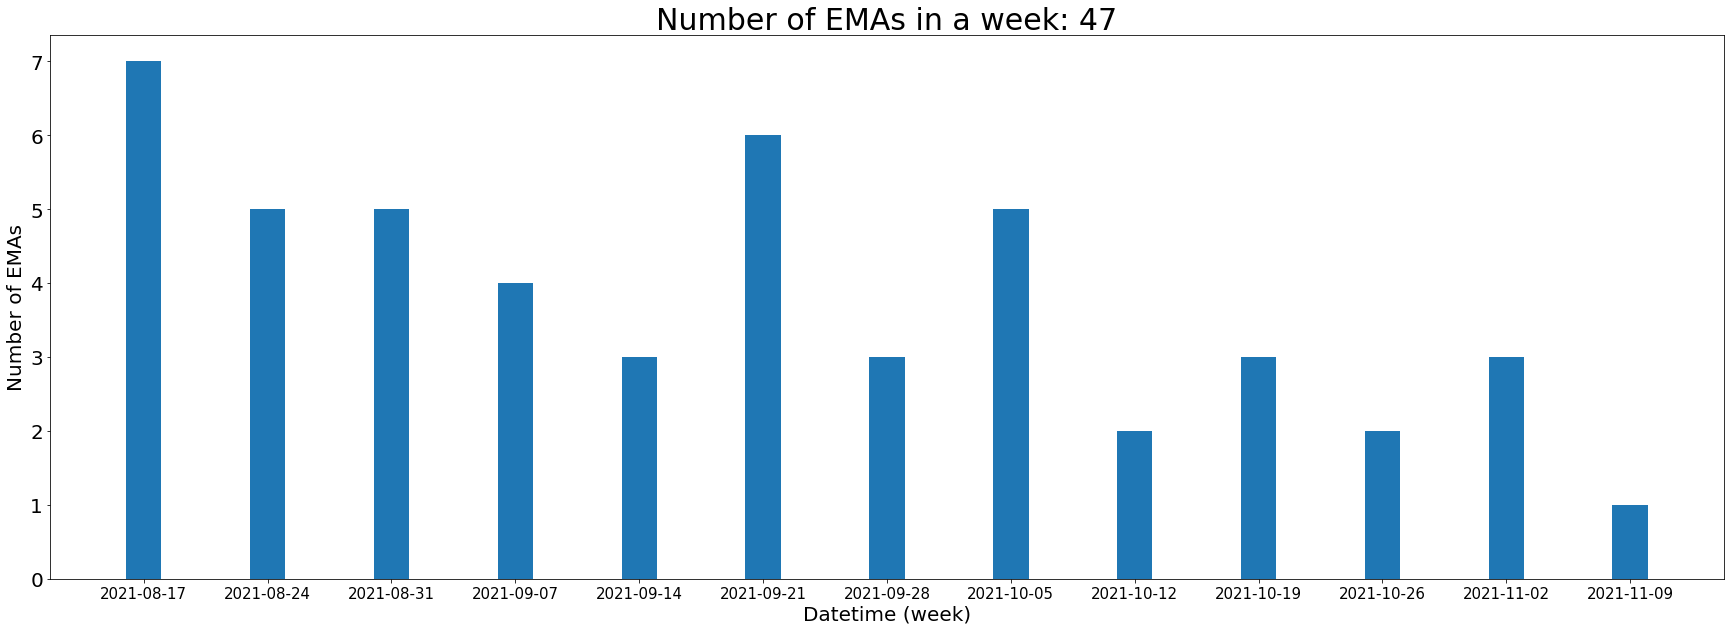

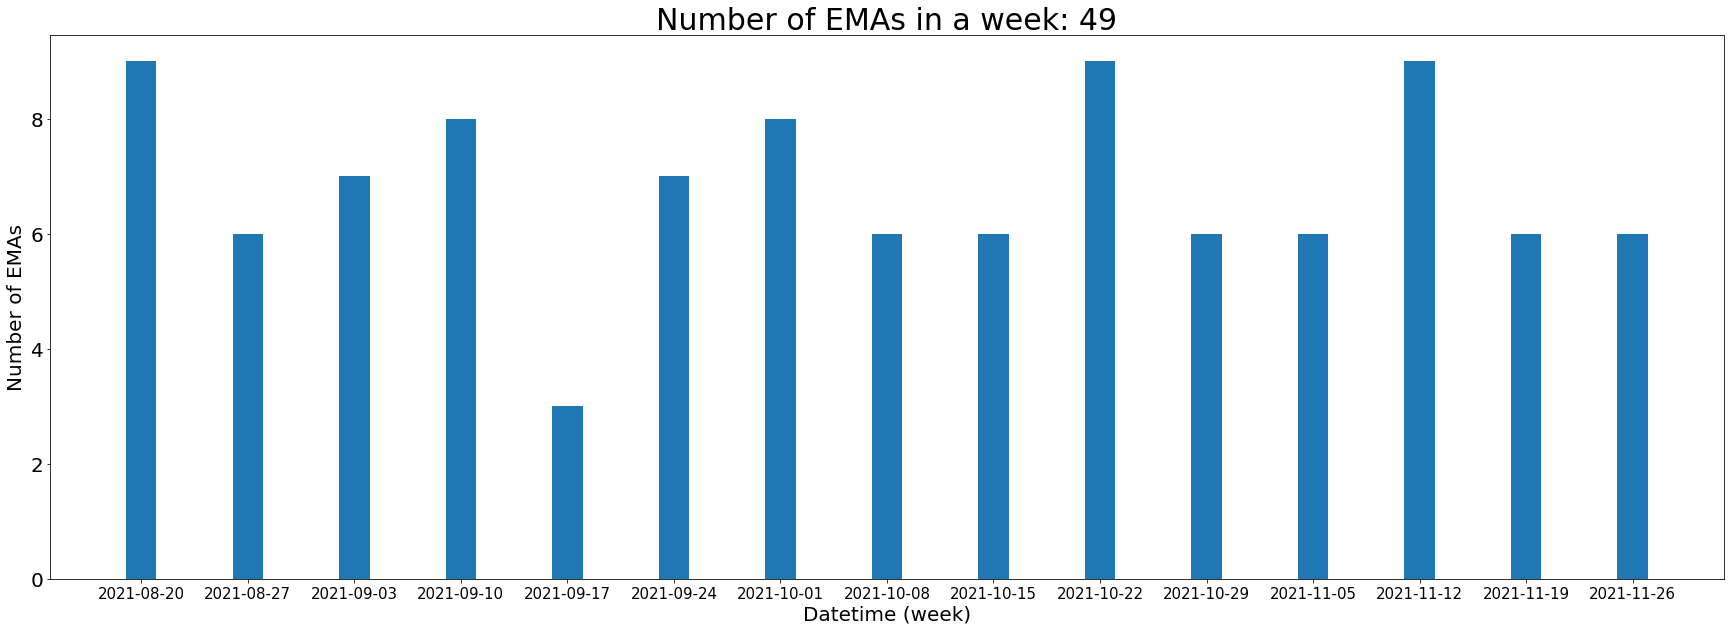

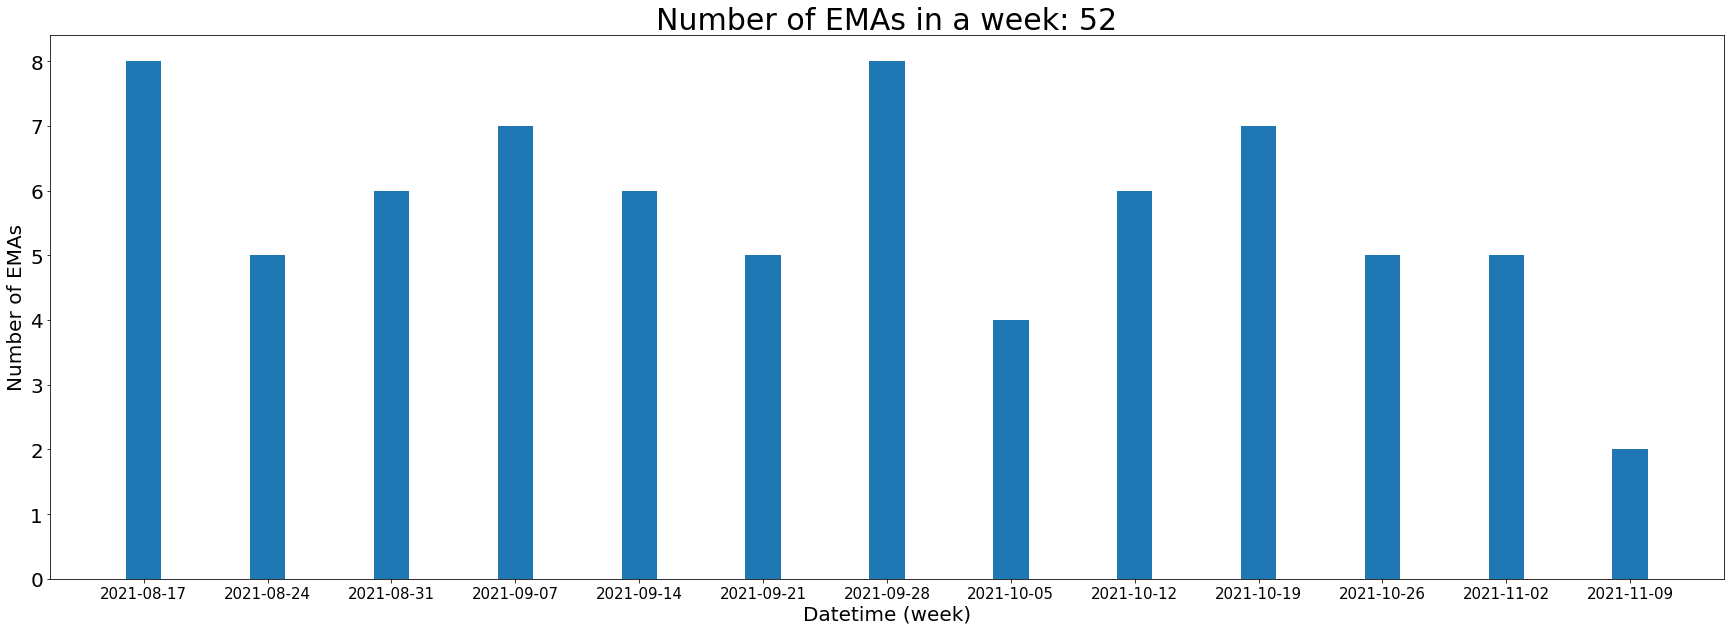

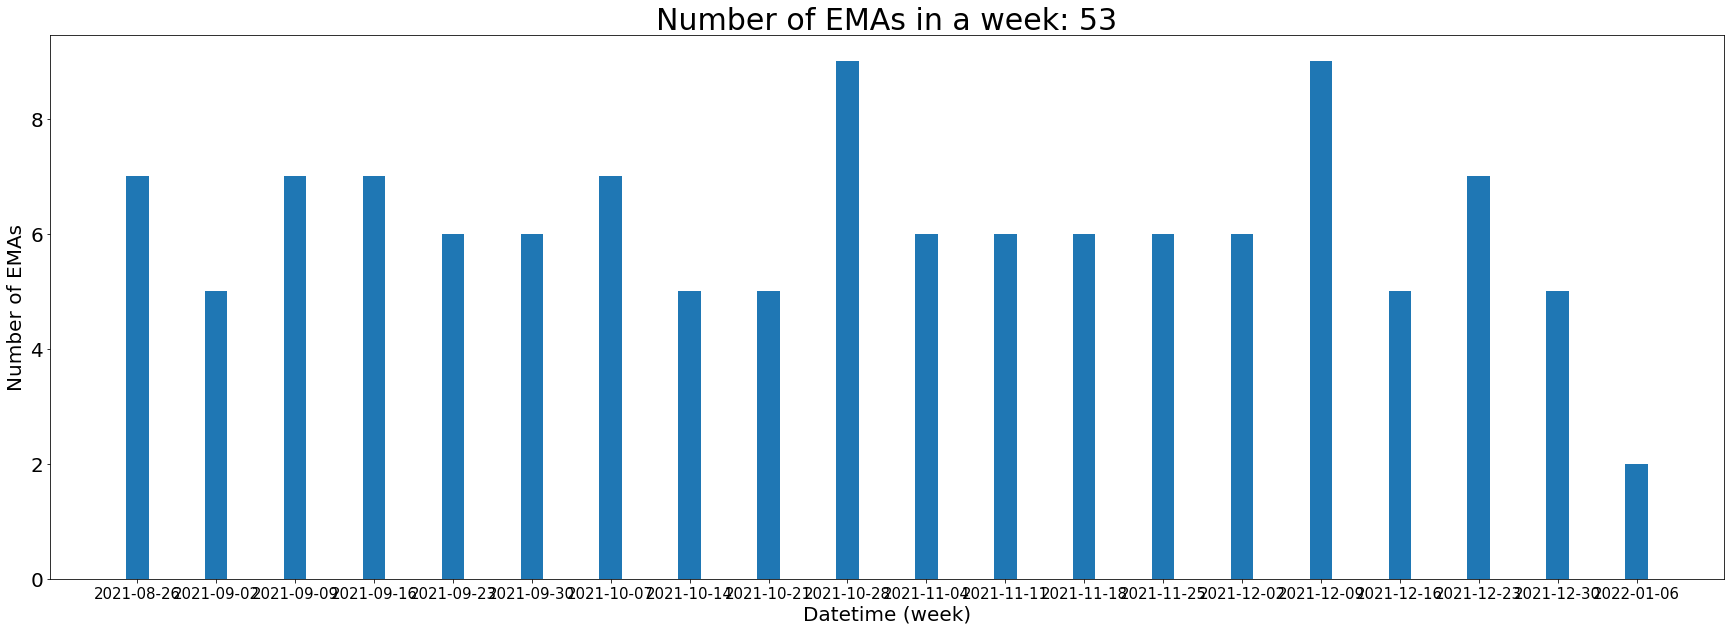

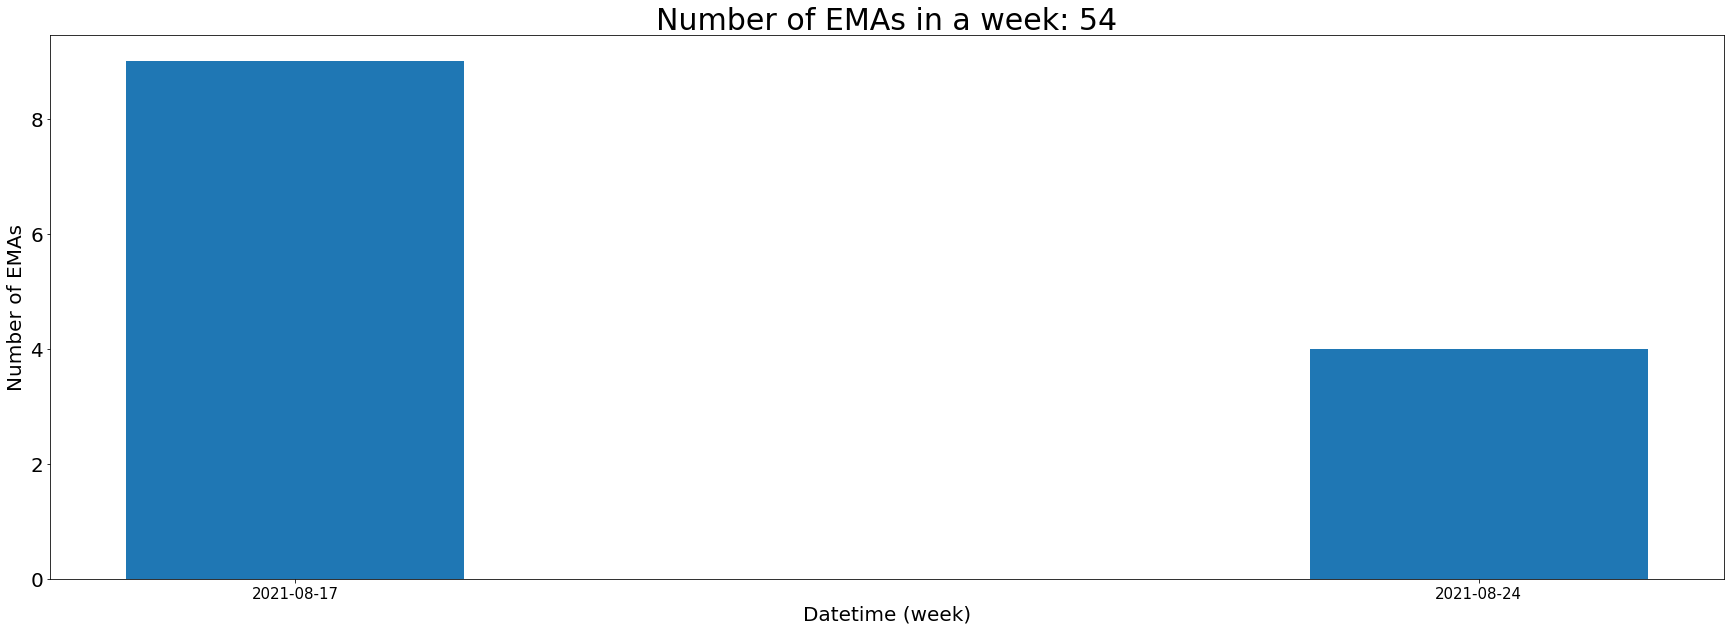

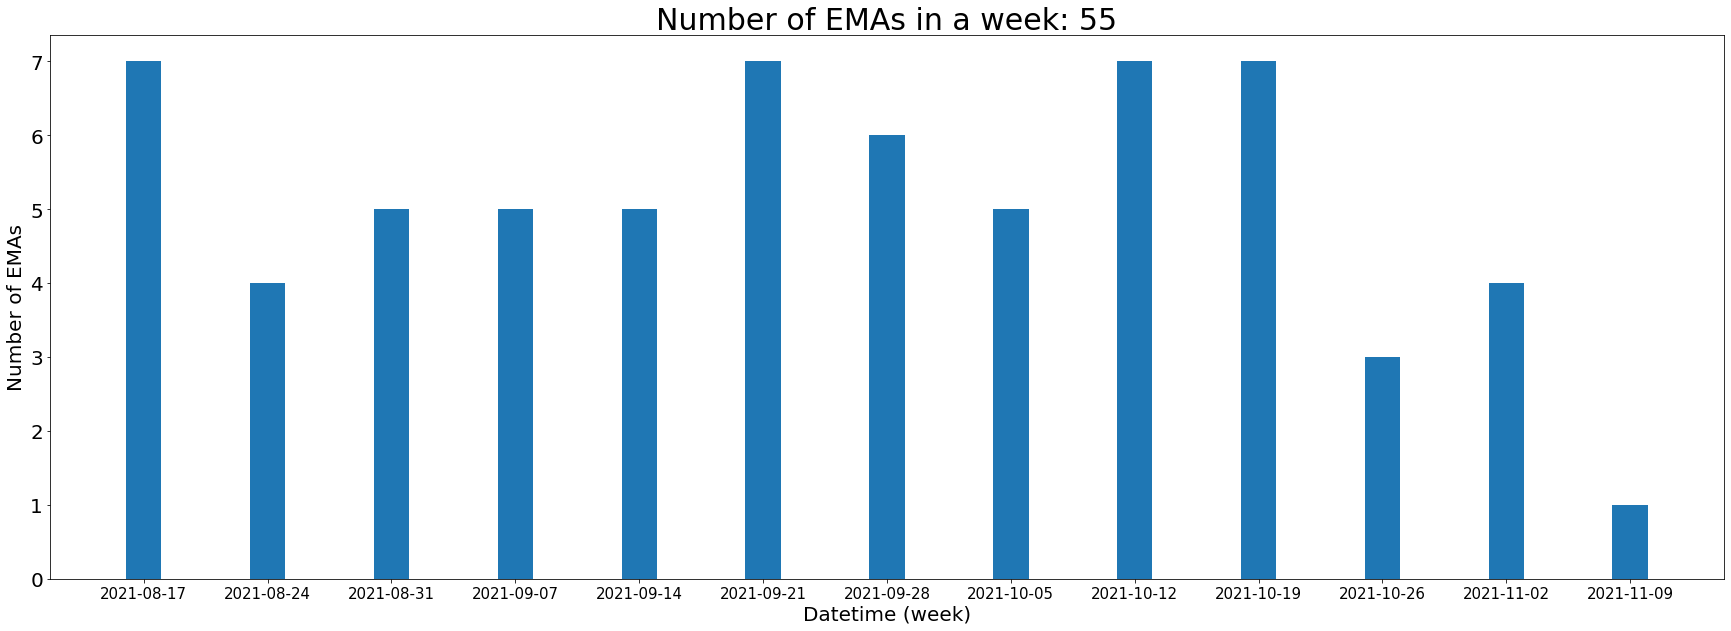

In [131]:
#removed_pids = list(aos_emas.loc[aos_emas['avg # of samples in a week'] < 4.7].index)
#aos users

for pid in list(aos_pids_common)[10:20]:
    start = list(aos_ema.loc[aos_ema['pid']==pid].index)[0]
    end = list(aos_ema.loc[aos_ema['pid']==pid].index)[-1]
    plt.figure(figsize=(30,10))
    plt.title('Number of EMAs in a week: {}'.format(pid), size = 30)
    plt.bar(pd.to_datetime(np.arange(start, end, 7*24*3600*1000), unit='ms', utc=True),  aos_dict_ema[pid], width=2)
    plt.xlabel('Datetime (week)', fontsize = 20)
    plt.ylabel('Number of EMAs', fontsize = 20)
    plt.xticks(pd.to_datetime(np.arange(start, end, 7*24*3600*1000), unit='ms', utc=True), fontsize = 15)
    plt.yticks(fontsize = 20)

#### Weekly Timeline Plot

In [122]:
def CountEMA(ema, pids):
    ema_dict = {}
    for pid in pids:
        df_ema = ema.loc[ema.pid == pid]
        sample_list = list()

        start = df_ema.index[0]
        end = df_ema.index[-1]
        week_dur = 7*24*3600*1000
        weeks = int((end-start)/week_dur)

        if weeks == 0: weeks = 1
        
        for i in range(weeks+1):
            df_window = df_ema[(df_ema.index>=start)&(df_ema.index<start+week_dur)]  
            sample_list.append(len(df_window))
            start += week_dur

        ema_dict[pid] = sample_list

    return ema_dict

def CountSamples(ema, sensor, pids, window_size):
    sample_dict = {}
    for pid in pids:
        df_ema = ema.loc[ema.pid == pid]
        df_sensor = sensor.loc[sensor.pid == pid]
        sample_list = list()
        
        for t in df_ema.index:   
            start = t-window_size*3600*1000 
            df_window = df_sensor[(df_sensor.index>=start)&(df_sensor.index<t)]  
            sample_list.append(len(df_window))

        sample_dict[pid] = np.mean(sample_list)

    return sample_dict

def PidsFiltering(cf):
    survived_pids = list()
    df = pd.DataFrame()
    th = "{}%".format(cf)

    dict_ema = CountEMA(aos_ema, aos_pids)
    ema_mean = list()
    for key in dict_ema:
        ema_list = dict_ema[key]
        ema_mean.append(np.mean(ema_list))
    df_ema = pd.DataFrame(index = aos_pids, columns=['avg # of samples in a week'], data = ema_mean)

    for ws in range(24, 3, -4): 
        dict_light = CountSamples(aos_ema, aos_light, aos_pids, ws)
        dict_sound = CountSamples(aos_ema, aos_sound, aos_pids, ws)
        dict_gravity = CountSamples(aos_ema, aos_gravity, aos_pids, ws)
        dict_gps = CountSamples(aos_ema, aos_gps, aos_pids, ws)

        df_light = pd.DataFrame(index = dict_light.keys(), columns = ['avg # of samples within {}h'.format(ws)], data = dict_light.values())
        df_sound = pd.DataFrame(index = dict_sound.keys(), columns = ['avg # of samples within {}h'.format(ws)], data = dict_sound.values())
        df_gravity = pd.DataFrame(index = dict_gravity.keys(), columns = ['avg # of samples within {}h'.format(ws)], data = dict_gravity.values())
        df_gps = pd.DataFrame(index = dict_gps.keys(), columns = ['avg # of samples within {}h'.format(ws)], data = dict_gps.values())

        light_pids = list(df_light.loc[df_light['avg # of samples within {}h'.format(ws)] >= df_light.describe().loc[th][0]].index)
        sound_pids = list(df_sound.loc[df_sound['avg # of samples within {}h'.format(ws)] >= df_sound.describe().loc[th][0]].index)
        gravity_pids = list(df_gravity.loc[df_gravity['avg # of samples within {}h'.format(ws)] >= df_gravity.describe().loc[th][0]].index)
        gps_pids = list(df_gps.loc[df_gps['avg # of samples within {}h'.format(ws)] >= df_gps.describe().loc[th][0]].index)
        ema_pids = list(df_ema.loc[df_ema['avg # of samples in a week'] >= df_ema.describe().loc[th][0]].index)

        filtered_pids = set(ema_pids) & set(sound_pids) & set(light_pids) & set(gravity_pids) & set(gps_pids)
        survived_pids.append(filtered_pids)
        nums = ['{}/{}'.format(round(df_light.describe().loc[th][0], 2), 4*ws),
                '{}/{}'.format(round(df_sound.describe().loc[th][0], 2), 4*ws),
                '{}/{}'.format(round(df_gravity.describe().loc[th][0], 2), 4*ws),
                '{}/{}'.format(round(df_gps.describe().loc[th][0], 2), 4*ws),
                '{}/{}'.format(len(filtered_pids), int(3.78*(100-cf)))
                ]
        df = pd.concat([pd.DataFrame(nums, columns = ['{} hour'.format(ws)]), df], axis=1)
   
    df.index = ['Light', 'Sound', 'Gravity', 'GPS', '# of Survived Pids']  
    
    return df, survived_pids

In [123]:
# filtered pids with # of samples (EMA, continuous sensing data)
result = PidsFiltering(25)
df_25 = result[0]
pids_25 = result[1]
spids_25 = pids_25[0] & pids_25[1] & pids_25[2] & pids_25[3] & pids_25[4] & pids_25[5]

In [ ]:
result = PidsFiltering(50)
df_50 = result[0]
pids_50 = result[1]
spids_50 = pids_50[0] & pids_50[1] & pids_50[2] & pids_50[3] & pids_50[4] & pids_50[5]

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt

def Sensor_NoSamples_with_EMA(pids):

    for pid in pids:
        df_ema = aos_ema.loc[aos_ema.pid == pid]
        df_light = aos_light.loc[aos_light.pid == pid]
        df_sound = aos_sound.loc[aos_sound.pid == pid]
        df_gravity = aos_gravity.loc[aos_gravity.pid == pid]
        df_wifi = aos_wifi.loc[aos_wifi.pid == pid]

        start = df_ema.index[0]-24*3600*1000
        end = df_ema.index[-1]
        week_dur = 7*24*3600*1000
        weeks = int((end-start)/week_dur)+1

        plt.rc('font',size=16)
        plt.figure(figsize=(40, weeks))
        plt.title('Number of Sensor Data Samples and EMAs per week: p{}'.format(pid), fontsize=30)

        if weeks == 0: weeks = 1
        
        for i in range(1, weeks+1):
            window_ema = df_ema[(df_ema.index>=start)&(df_ema.index<start+week_dur)]
            window_light = df_light[(df_light.index>=start)&(df_light.index<start+week_dur)]     
            window_sound = df_sound[(df_sound.index>=start)&(df_sound.index<start+week_dur)]
            window_gravity = df_gravity[(df_gravity.index>=start)&(df_gravity.index<start+week_dur)]      
            window_wifi = df_wifi[(df_wifi.index>=start)&(df_wifi.index<start+week_dur)]     
            start += week_dur

            window_light['timestamp'] = window_light.index
            window_light['timestamp'] = pd.to_datetime(window_light['timestamp'], unit='ms', utc=True)
            window_sound['timestamp'] = window_sound.index
            window_sound['timestamp'] = pd.to_datetime(window_sound['timestamp'], unit='ms', utc=True)
            window_gravity['timestamp'] = window_gravity.index
            window_gravity['timestamp'] = pd.to_datetime(window_gravity['timestamp'], unit='ms', utc=True)
            window_wifi['timestamp'] = window_wifi.index
            window_wifi['timestamp'] = pd.to_datetime(window_wifi['timestamp'], unit='ms', utc=True)
            window_ema['timestamp'] = window_ema.index
            window_ema['timestamp'] = pd.to_datetime(window_ema['timestamp'], unit='ms', utc=True)

            plt.scatter(window_wifi['timestamp']-timedelta(hours=24*7)*i, (i-0.4)*np.ones(window_wifi.shape[0]),label='week {}'.format(i), marker='.', color='silver', s=10)    
            plt.scatter(window_light['timestamp']-timedelta(hours=24*7)*i, (i-0.3)*np.ones(window_light.shape[0]), label='week {}'.format(i), marker='.', color='grey', s=10)   
            plt.scatter(window_sound['timestamp']-timedelta(hours=24*7)*i, (i-0.2)*np.ones(window_sound.shape[0]),label='week {}'.format(i), marker='.', color='darkgrey', s=10)    
            plt.scatter(window_gravity['timestamp']-timedelta(hours=24*7)*i, (i-0.1)*np.ones(window_gravity.shape[0]),label='week {}'.format(i), marker='.', color='black', s=10)    
            plt.scatter(window_ema['timestamp']-timedelta(hours=24*7)*i,  i*np.ones(window_ema.shape[0]),label='week {}'.format(i), marker='^', color='red', s=20)  

            plt.ylabel('Week', fontsize=20)
            plt.xlabel('Weekly Timeline', fontsize=20)
            plt.yticks(np.arange(1, weeks+1))
            plt.xticks([])
            plt.legend(('wifi', 'light', 'sound', 'gravity', 'ema'), loc='upper right')

In [ ]:
Sensor_NoSamples_with_EMA(spids_50)

# Data Cleaning & Feature Extraction

In [6]:
# pid 255 is excluded after repetitive response check
# 36 pids: aos_pids = [128, 644, 262, 391, 648, 139, 14, 400, 276, 21, 280, 408, 411, 797, 30, 543, 36, 553, 57, 63, 193, 67, 72, 713, 202, 337, 83, 599, 221, 741, 360, 624, 118, 119, 758, 255] 
# 35 pids: aos_pids = [128, 644, 262, 391, 648, 139, 14, 400, 276, 21, 280, 408, 411, 797, 30, 543, 36, 553, 57, 63, 193, 67, 72, 713, 202, 337, 83, 599, 221, 741, 360, 624, 118, 119, 758] 
import pickle

with open('aos_weekly_avg_samples.pickle', 'rb') as fw:
    aos_sample_list = pickle.load(fw)
with open('ios_weekly_avg_samples.pickle', 'rb') as fw:
    ios_sample_list = pickle.load(fw)

aos_ema_df = pd.read_csv('aos_weekly_avg_ema.csv', index_col=0)
ios_ema_df = pd.read_csv('ios_weekly_avg_ema.csv', index_col=0)

aos_pids = list(aos_ema_df.index)
aos_pids.sort()
ios_pids = list(ios_ema_df.index)
ios_pids.sort()

In [5]:
aos_sensors = ['SCREEN_STATE', 'SURVEY_EMA', 'KEYSTROKE_LOG', 'LOCATION_GPS', 'ACTIVITY_RECOGNITION', 'CALLS', 'SOUND_DATA', 'ANDROID_LIGHT', 'UNLOCK_STATE', 'ANDROID_SIGNIFICANT_MOTION', 'APPLICATION_USAGE', 'ANDROID_STEP_DETECTOR', 'TYPING', 'NOTIFICATIONS', 'ANDROID_GRAVITY']
ios_sensors = ['SCREEN_STATE', 'SURVEY_EMA', 'LOCATION_GPS', 'ACTIVITY_RECOGNITION', 'CALLS', 'SOUND_DATA', 'UNLOCK_STATE', 'ANDROID_SIGNIFICANT_MOTION', 'ANDROID_STEP_DETECTOR', 'ANDROID_GRAVITY']

In [6]:
aos_survey = pd.read_csv('aos_features/aos_survey.csv', index_col=0)
aos_survey['timestamp'] = pd.to_datetime(aos_survey['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
aos_ema = aos_survey[['pid', 'timestamp','depressed']]
aos_ema.set_index(['pid', 'timestamp'], inplace=True)

ios_survey = pd.read_csv('ios_features/ios_survey.csv', index_col=0)
ios_survey['timestamp'] = pd.to_datetime(ios_survey['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
ios_ema = ios_survey[['pid', 'timestamp','depressed']]
ios_ema.set_index(['pid', 'timestamp'], inplace=True)


In [7]:
import pickle

with open('pids.pickle', 'rb') as fw:
    pids_dict = pickle.load(fw)

In [8]:
aos_pids = pids_dict['aos_pids']
ios_pids = pids_dict['ios_pids']

# Survey EMA

### Previous Code

In [ ]:
'''from copy import copy 

# Indicate instances with unreliable data
def clean_ema_basedon_missing_data(us, ema, sensorName,  pids, gap_threshold_in_days=1):
   
    col = 'missing_{}_{}days'.format(sensorName, gap_threshold_in_days)    
    ema.insert(ema.shape[1],col, 0, allow_duplicates=True)

    for pid in pids:
        frame = copy(us.loc[pid])
        frame['diff'] = frame.index.to_series().diff() # time interval between lock state
        M = frame['diff']>timedelta(days=gap_threshold_in_days) # interval longer than the threshold (1 day)

        for row in frame[M].itertuples():
            end = row.Index
            start = end-row.diff
            # Get the period of ema when the lockstate interval is longer than 1 day
            M = (ema.index.get_level_values('pid')==pid)&((ema.index.get_level_values('timestamp')>start) & (ema.index.get_level_values('timestamp')<=end))
            ema.loc[M,col]=1     # insert 1
        
        
        if (ema.loc[pid].index.max() - frame.index.max()) > timedelta(days=gap_threshold_in_days):
            start = frame.index.max()
            end = ema.loc[pid].index.max()
            
            # In the case of the period of ema is longer than unlockstate ones, insert 1 
            M = (ema.index.get_level_values('pid')==pid)&((ema.index.get_level_values('timestamp')>start) & (ema.index.get_level_values('timestamp')<=end))
            ema.loc[M,col]=1

    return ema'''

In [ ]:
# Not used

from copy import copy 

def clean_ema_basedon_missing_data(us, ema, sensorName,  pids, gap_threshold_in_days=0.5):
   
    col = 'missing_{}_{}days'.format(sensorName, gap_threshold_in_days)    
    ema.insert(ema.shape[1],col, 0, allow_duplicates=True)

    for pid in pids:
        frame = copy(us.loc[pid])
        frame['diff'] = frame.index.to_series().diff() # time interval between lock state
        #M = frame.loc[frame['state']=='UNLOCK']['diff']>timedelta(days=gap_threshold_in_days) # interval longer than the threshold (1 day)
        M = (frame.loc[frame['state']=='UNLOCK']['diff']>timedelta(days=gap_threshold_in_days)) & (frame.loc[frame['state']=='UNLOCK']['diff']<timedelta(days=0.5))

        for row in frame.loc[frame['state']=='UNLOCK'][M].itertuples():
            end = row.Index
            start = end-row.diff
            # Get the period of ema when the lockstate interval is longer than 1 day
            M = (ema.index.get_level_values('pid')==pid)&((ema.index.get_level_values('timestamp')>start) & (ema.index.get_level_values('timestamp')<=end))
            ema.loc[M,col]=1     # insert 1
        
        
        if (ema.loc[pid].index.max() - frame.index.max()) > timedelta(days=0.5):
            start = frame.index.max()
            end = ema.loc[pid].index.max()
            
            # In the case of the period of ema is longer than unlockstate ones, insert 1 
            M = (ema.index.get_level_values('pid')==pid)&((ema.index.get_level_values('timestamp')>start) & (ema.index.get_level_values('timestamp')<=end))
            ema.loc[M,col]=1

    return ema

In [146]:
sensorName = 'SURVEY_EMA'
cols =  ['timestamp','ema_order', 'stress', 'eating', 'social_act','depressed_feeling','lack_of_interest', 'sleep_trouble', 'poor_appetite','bad_physchomotor_activity',
            'fatigue', 'negative_self_image','difficulty_focusing', 'suicide_thoughts', 'consistency_check', 'duration']
dtypes = {'ema_order':int, 'stress':int, 'eating':int, 'social_act':int,'lack_of_interest':int,'depressed_feeling':int, 'sleep_trouble':int, 'fatigue':int,'poor_appetite':int,
            'negative_self_image':int,'difficulty_focusing':int, 'bad_physchomotor_activity':int, 'suicide_thoughts':int, 'consistency_check':int, 'duration':int}
symptom_cols = ['lack_of_interest','depressed_feeling', 'sleep_trouble', 'fatigue','poor_appetite',
            'negative_self_image','difficulty_focusing', 'bad_physchomotor_activity', 'suicide_thoughts']
gap_threshold_in_days = 1

# Andriod
aos_survey = load_data(path=aos_path, sensorName=sensorName, pids=aos_pids, cols=cols)
aos_survey = aos_survey.astype(dtypes)
aos_survey[symptom_cols] = aos_survey[symptom_cols].astype('int8')

# ema with unlockstate
aos_survey = clean_ema_basedon_missing_data(aos_us, aos_survey, 'UNLOCK_STATE', aos_pids, gap_threshold_in_days=0.05)

# calculate phq aos depressed status
aos_survey['phq']=aos_survey[symptom_cols].sum(axis=1)
aos_survey['phq']=aos_survey['phq'].replace(0, np.nan)

conditions = [aos_survey['phq'] < 15, (aos_survey['phq'] >= 15) & (aos_survey['phq'] <= 45)]
choices = [0, 1]
aos_survey["depressed"] = np.select(conditions, choices, default=np.nan)

# iOS
ios_survey = load_data(path=ios_path, sensorName=sensorName, pids=ios_pids, cols=cols)
ios_survey = ios_survey.astype(dtypes)
ios_survey[symptom_cols] = ios_survey[symptom_cols].astype('int8')

# ema with unlockstate
ios_survey = clean_ema_basedon_missing_data(ios_us, ios_survey, 'UNLOCK_STATE', ios_pids, gap_threshold_in_days=0.05)

# calculate phq ios depressed status
ios_survey['phq']=ios_survey[symptom_cols].sum(axis=1)
ios_survey['phq']=ios_survey['phq'].replace(0, np.nan)

conditions = [ios_survey['phq'] < 15, (ios_survey['phq'] >= 15) & (ios_survey['phq'] <= 45)]
choices = [0, 1]
ios_survey["depressed"] = np.select(conditions, choices, default=np.nan)

100%|██████████| 221/221 [00:04<00:00, 44.29it/s]


### Labeling

In [48]:
sensorName = 'SURVEY_EMA'
cols =  ['timestamp','ema_order', 'stress', 'eating', 'social_act','depressed_feeling','lack_of_interest', 'sleep_trouble', 'poor_appetite','bad_physchomotor_activity',
            'fatigue', 'negative_self_image','difficulty_focusing', 'suicide_thoughts', 'consistency_check', 'duration']
dtypes = {'ema_order':int, 'stress':int, 'eating':int, 'social_act':int,'lack_of_interest':int,'depressed_feeling':int, 'sleep_trouble':int, 'fatigue':int,'poor_appetite':int,
            'negative_self_image':int,'difficulty_focusing':int, 'bad_physchomotor_activity':int, 'suicide_thoughts':int, 'consistency_check':int, 'duration':int}
symptom_cols = ['lack_of_interest','depressed_feeling', 'sleep_trouble', 'fatigue','poor_appetite',
            'negative_self_image','difficulty_focusing', 'bad_physchomotor_activity', 'suicide_thoughts']
gap_threshold_in_days = 1

# Andriod
aos_survey = load_data(path=aos_path, sensorName=sensorName, pids=aos_pids, cols=cols, dtypes = dtypes)
aos_survey[symptom_cols] = aos_survey[symptom_cols].astype('int8')

# ema with unlockstate: not valid, since unlock state has missing data
#aos_survey = clean_ema_basedon_missing_data(aos_us, aos_survey, 'UNLOCK_STATE', aos_pids, gap_threshold_in_days=0.05)

# calculate phq aos depressed status
aos_survey['phq']=aos_survey[symptom_cols].sum(axis=1)
aos_survey['phq']=aos_survey['phq'].replace(0, np.nan)

conditions = [aos_survey['phq'] < 15, (aos_survey['phq'] >= 15) & (aos_survey['phq'] <= 45)]
choices = [0, 1]
aos_survey["depressed"] = np.select(conditions, choices, default=np.nan)

#ios

ios_survey = load_data(path=ios_path, sensorName=sensorName, pids=ios_pids, cols=cols, dtypes = dtypes)
ios_survey[symptom_cols] = ios_survey[symptom_cols].astype('int8')

# ema with unlockstate
#ios_survey = clean_ema_basedon_missing_data(ios_us, ios_survey, 'UNLOCK_STATE', ios_pids, gap_threshold_in_days=1)

# calculate phq ios depressed status
ios_survey['phq']=ios_survey[symptom_cols].sum(axis=1)
ios_survey['phq']=ios_survey['phq'].replace(0, np.nan)

conditions = [ios_survey['phq'] < 15, (ios_survey['phq'] >= 15) & (ios_survey['phq'] <= 45)]
choices = [0, 1]
ios_survey["depressed"] = np.select(conditions, choices, default=np.nan)

100%|██████████| 221/221 [00:04<00:00, 46.19it/s]


### Remove Unreliable Data (Outlier)

#### Unlock state (not used)

In [ ]:
aos_survey.loc[aos_survey['missing_UNLOCK_STATE_0.05days']==1][:10]

In [ ]:
aos_survey['missing_UNLOCK_STATE_0.05days'].value_counts()

In [ ]:
# Remove all
aos_survey['missing_UNLOCK_STATE_0.05days'].value_counts()

In [ ]:
ratio_list = list()
un_miss_dict = {}
for pid in aos_pids:
    df = aos_survey.loc[pid]
    if len(df['missing_UNLOCK_STATE_0.05days'].value_counts()) == 2:
        good = df['missing_UNLOCK_STATE_0.05days'].value_counts()[0]
        bad = df['missing_UNLOCK_STATE_0.05days'].value_counts()[1]
        if bad == 0:
            pass
        else:
            ratio = good/bad
            ratio_list.append(ratio)
            if ratio < 10:
                un_miss_dict[pid] = ratio
                print(pid, ratio)

In [ ]:
np.mean(ratio_list)

In [ ]:
aos_survey.loc[202]['missing_UNLOCK_STATE_0.05days'].value_counts()

In [ ]:
aos_survey.loc[202].loc[aos_survey.loc[202]['missing_UNLOCK_STATE_0.05days']==1].head()

In [ ]:
ios_survey['missing_UNLOCK_STATE_1days'].value_counts()

#### Repetitive Reponse (Redundancy)

In [421]:
# Android

aos_uniq_ts = list()
aos_uniq_idx = list()
idx = 0
aos_pids.sort()

for p in aos_pids:
    ema_pid = aos_survey.loc[p]
    ema_ts = ema_pid.index.get_level_values('timestamp')
    uniq_pts = [ema_ts[0]]
    for i in range(len(ema_ts)-1):
        interval = ema_ts[i+1].timestamp() - ema_ts[i].timestamp()
        if interval > 3600*2: # interval should not be too long
            uniq_pts.append(ema_ts[i+1])
            aos_uniq_idx.append(idx)
        
        else:    
            print(p, ema_ts[i], ema_ts[i+1])
         #   print(p, aos_survey.index[idx], aos_survey.index[idx])
        idx+=1
    aos_uniq_idx.append(idx)
    idx+=1
    aos_uniq_ts += uniq_pts

re_ts = set(aos_survey.index.get_level_values('timestamp')) - set(aos_uniq_ts)
print(len(re_ts), len(aos_uniq_ts))

57 2022-02-03 19:32:29.508000+09:00 2022-02-03 20:06:22.831000+09:00
64 2021-11-21 14:07:16.910000+09:00 2021-11-21 15:50:54.441000+09:00
75 2021-08-29 10:01:27.004000+09:00 2021-08-29 11:18:15.319000+09:00
78 2021-08-26 16:27:14.122000+09:00 2021-08-26 17:00:55.810000+09:00
78 2021-10-16 20:57:32.254000+09:00 2021-10-16 21:05:28.324000+09:00
96 2021-08-14 12:10:03.363000+09:00 2021-08-14 12:27:12.957000+09:00
96 2021-08-14 16:29:12.024000+09:00 2021-08-14 16:29:44.454000+09:00
96 2021-08-14 20:00:23.978000+09:00 2021-08-14 20:01:26.295000+09:00
96 2021-08-17 12:00:25.660000+09:00 2021-08-17 12:02:19.432000+09:00
96 2021-08-17 16:00:35.042000+09:00 2021-08-17 16:15:09.747000+09:00
96 2021-08-17 20:30:14.884000+09:00 2021-08-17 20:59:46.459000+09:00
96 2021-08-20 12:10:18.470000+09:00 2021-08-20 12:12:58.228000+09:00
96 2021-08-20 16:01:42.513000+09:00 2021-08-20 16:02:50.412000+09:00
98 2021-10-04 16:03:10.340000+09:00 2021-10-04 17:33:01.779000+09:00
255 2021-09-04 20:00:43.517000+09:

In [49]:
# iOS

ios_uniq_ts = list()
ios_uniq_idx = list()
idx = 0
ios_pids.sort()

for p in ios_pids:
    ema_pid = ios_survey.loc[p]
    ema_ts = ema_pid.index.get_level_values('timestamp')
    uniq_pts = [ema_ts[0]]
    for i in range(len(ema_ts)-1):
        interval = ema_ts[i+1].timestamp() - ema_ts[i].timestamp()
        if interval > 3600*2: # interval should not be too long
            uniq_pts.append(ema_ts[i+1])
            ios_uniq_idx.append(idx)
        
        else:    
            print(p, ema_ts[i], ema_ts[i+1])
         #   print(p, ios_survey.index[idx], ios_survey.index[idx])
        idx+=1
    ios_uniq_idx.append(idx)
    idx+=1
    ios_uniq_ts += uniq_pts

re_ts = set(ios_survey.index.get_level_values('timestamp')) - set(ios_uniq_ts)
print(len(re_ts), len(ios_uniq_ts))

87 2021-09-05 16:19:53.916000+09:00 2021-09-05 16:23:25.498000+09:00
142 2022-01-23 15:24:27.915000+09:00 2022-01-23 16:01:54.199000+09:00
304 2021-11-22 18:09:00.071000+09:00 2021-11-22 18:09:13.150000+09:00
307 2021-11-25 16:11:52.097000+09:00 2021-11-25 16:22:31.051000+09:00
461 2021-12-03 20:51:31.851000+09:00 2021-12-03 20:51:51.309000+09:00
653 2021-10-31 17:40:36.208000+09:00 2021-10-31 18:40:34.896000+09:00
658 2021-11-22 13:04:14.353000+09:00 2021-11-22 14:22:12.115000+09:00
669 2022-01-01 10:07:59.076000+09:00 2022-01-01 10:35:48.259000+09:00
746 2022-01-04 20:04:22.415000+09:00 2022-01-04 20:53:26.212000+09:00
792 2021-12-04 20:06:15.181000+09:00 2021-12-04 20:54:50.309000+09:00
10 10783


#### Response Time Check

In [423]:
aos_survey['duration'].describe()

count    2.710300e+04
mean     1.039719e+07
std      4.879812e+07
min     -1.543900e+09
25%      2.156950e+04
50%      3.328600e+04
75%      1.402809e+07
max      1.843782e+09
Name: duration, dtype: float64

In [424]:
aos_survey['duration'].loc[(aos_survey['duration']<10000)] # 9 seconds is still acceptable. No filtered users by EMA duration

pid  timestamp                       
94   2021-12-30 20:02:18.257000+09:00          9603
     2022-01-13 20:18:19.502000+09:00          9982
103  2021-12-06 12:00:17.310000+09:00          9990
355  2021-11-12 12:04:50.942000+09:00          9878
596  2021-12-03 16:00:11.530000+09:00          9023
813  2021-11-24 16:05:21.666000+09:00   -1543900405
     2021-12-03 12:25:25.743000+09:00     -29381181
     2021-12-03 16:25:21.442000+09:00     -14985482
     2021-12-06 12:01:27.913000+09:00     -28743681
     2021-12-06 16:01:24.754000+09:00     -14346840
817  2021-11-27 12:56:15.627000+09:00    -255828224
     2021-11-27 16:56:22.834000+09:00    -241421017
     2021-11-27 20:56:20.374000+09:00    -227023477
Name: duration, dtype: int32

In [425]:
print(ios_survey['duration'].loc[(ios_survey['duration']<9000)]) # 9 seconds is still acceptable. Quite a lot!
print(len(ios_survey['duration'].loc[(ios_survey['duration']<9000)]))

pid  timestamp                       
150  2021-10-02 14:50:16.376000+09:00    7772
     2021-10-05 20:52:41.912000+09:00    7979
     2021-10-20 16:50:16.973000+09:00    8068
     2021-10-23 16:57:00.126000+09:00    8165
     2021-11-10 12:50:14.505000+09:00    6717
254  2021-11-02 18:51:46.158000+09:00    8848
     2021-11-08 14:16:46.549000+09:00    8968
     2021-11-11 18:02:06.725000+09:00    8699
     2021-11-29 18:32:43.729000+09:00    8595
     2021-12-11 14:43:25.143000+09:00    7678
259  2021-10-01 20:00:37.935000+09:00    8909
301  2021-11-13 16:59:29.233000+09:00    8818
304  2021-10-20 14:05:43.132000+09:00    8947
     2021-10-23 10:00:59.579000+09:00    7698
     2021-11-04 18:24:27.787000+09:00    7929
     2021-11-07 14:01:50.131000+09:00    8297
     2021-11-07 18:01:24.276000+09:00    8816
     2021-11-13 14:04:29.145000+09:00    8025
     2021-11-22 18:09:13.150000+09:00    8899
     2021-11-28 10:50:20.004000+09:00    8755
     2021-12-01 14:50:18.041000+09:00    8

18206


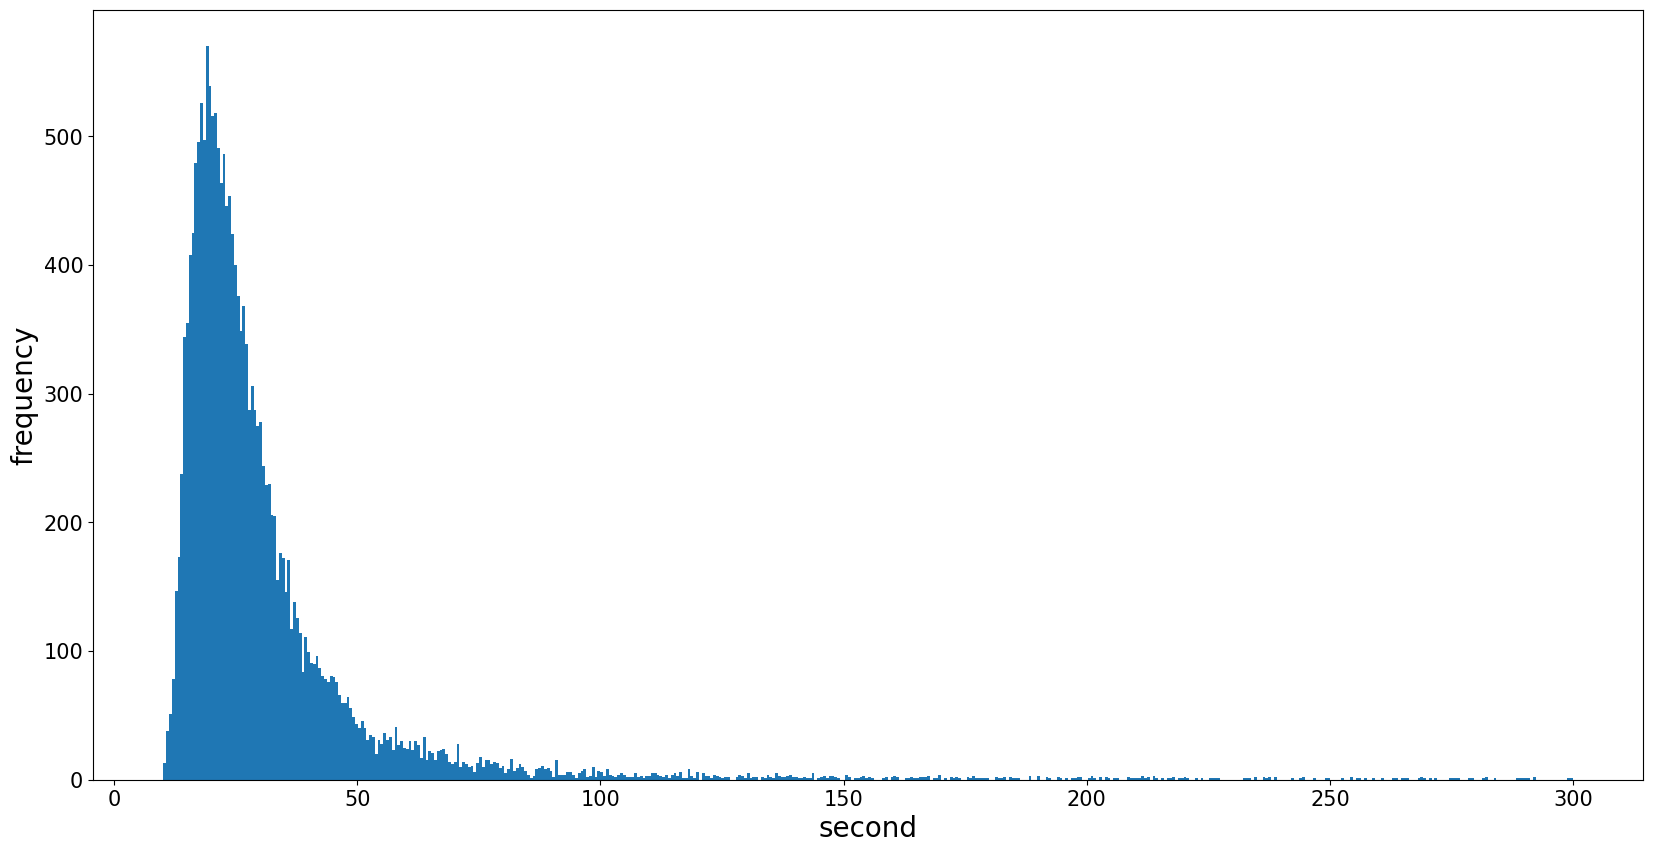

In [426]:
# Visualization
# Cut-off: 5 mins, 3 hours, ...   

plt.figure(figsize=(20,10))
plt.tick_params(labelsize = 15)
plt.xlabel('second', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
print(len(aos_survey['duration'].loc[(aos_survey['duration']>10000) & (aos_survey['duration']<300000)]))
plt.hist(aos_survey['duration'].loc[(aos_survey['duration']>10000) & (aos_survey['duration']<300000)]/1000, bins = 500)
plt.show()


10509


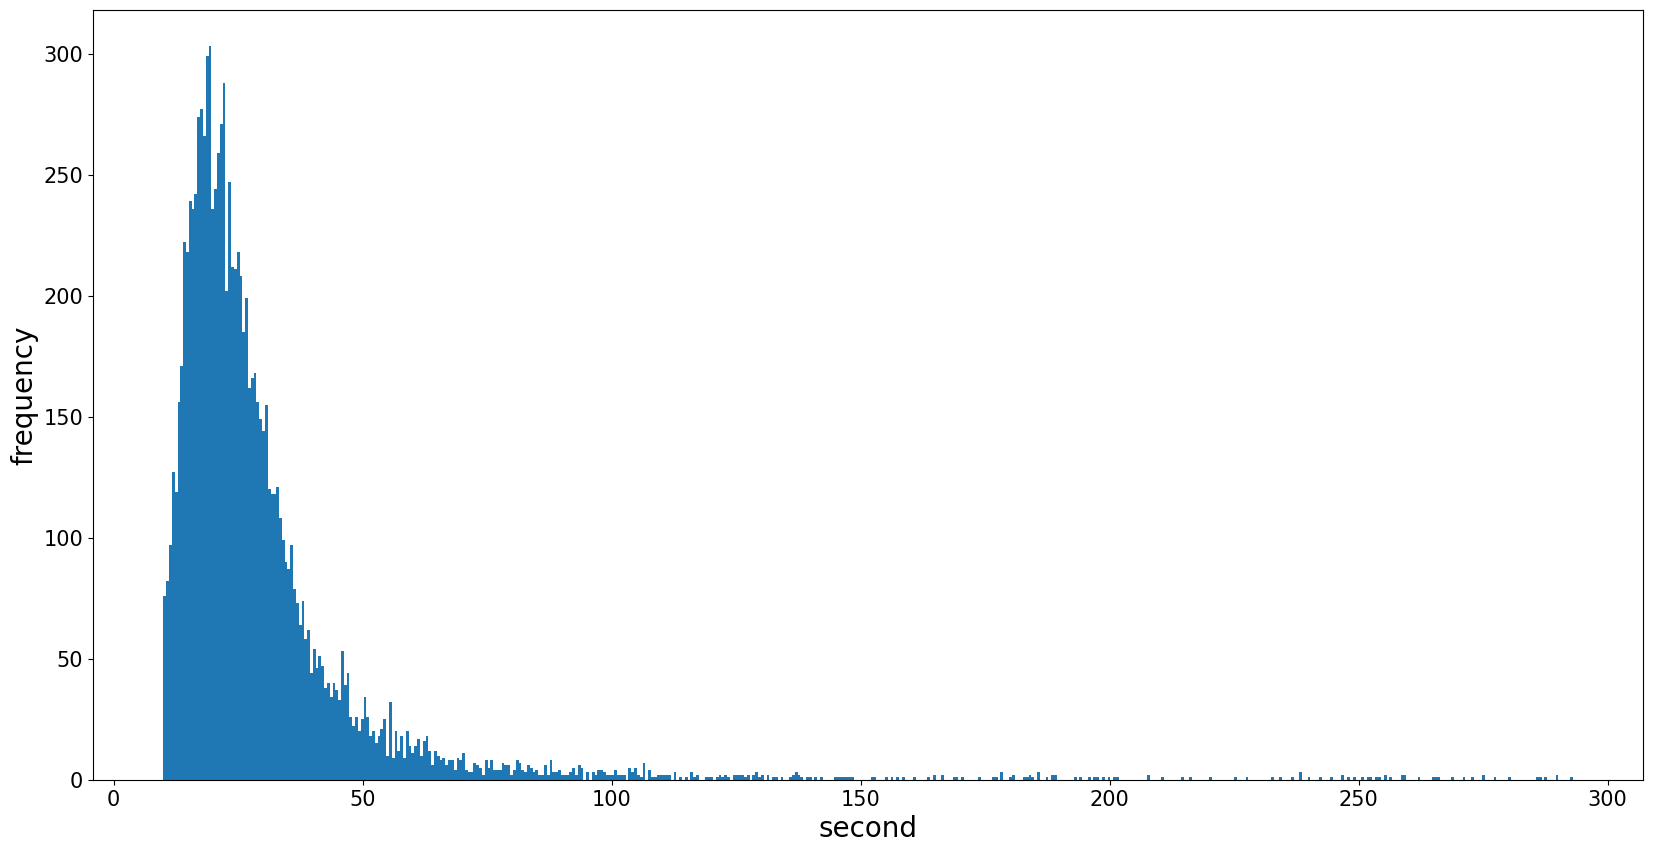

In [427]:
# Visualization
# Cut-off: 5 mins, 3 hours, ...   

plt.figure(figsize=(20,10))
plt.tick_params(labelsize = 15)
plt.xlabel('second', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
print(len(ios_survey['duration'].loc[(ios_survey['duration']>10000) & (ios_survey['duration']<300000)]))
plt.hist(ios_survey['duration'].loc[(ios_survey['duration']>10000) & (ios_survey['duration']<300000)]/1000, bins = 500)
plt.show()

#### Consistency Check

In [163]:
aos_survey.loc[np.abs(aos_survey['consistency_check']-aos_survey['depressed_feeling'])<3]

ema_order  stress  eating  social_act  \
pid timestamp                                                                 
6   2021-08-20 12:00:35.909000+09:00          1       3       3           3   
    2021-08-20 16:00:50.097000+09:00          2       3       3           2   
    2021-08-20 20:00:38.884000+09:00          3       3       3           3   
    2021-08-23 12:00:30.315000+09:00          1       3       3           2   
    2021-08-23 16:00:37.721000+09:00          2       2       3           2   
...                                         ...     ...     ...         ...   
863 2022-02-09 16:07:29.706000+09:00          2       3       1           4   
    2022-02-09 20:00:28.976000+09:00          3       3       3           3   
    2022-02-12 10:01:42.842000+09:00          1       3       1           3   
    2022-02-12 14:03:02.453000+09:00          2       3       3           3   
    2022-02-12 18:01:23.017000+09:00          3       3       3           4   

                                      depressed_feeling  lack_of_interest  \
pid timestamp                                                               
6   2021-08-20 12:00:35.909000+09:00                  1                 1   
    2021-08-20 16:00:50.097000+09:00                  1                 1   
    2021-08-20 20:00:38.884000+09:00                  1                 1   
    2021-08-23 12:00:30.315000+09:00                  2                 1   
    2021-08-23 16:00:37.721000+09:00                  2                 1   
...                                                 ...               ...   
863 2022-02-09 16:07:29.706000+09:00                  4                 2   
    2022-02-09 20:00:28.976000+09:00                  2                 2   
    2022-02-12 10:01:42.842000+09:00                  3                 3   
    2022-02-12 14:03:02.453000+09:00                  4                 2   
    2022-02-12 18:01:23.017000+09:00                  3                 3   

                                      sleep_trouble  poor_appetite  \
pid timestamp                                                        
6   2021-08-20 12:00:35.909000+09:00              1              1   
    2021-08-20 16:00:50.097000+09:00              1              1   
    2021-08-20 20:00:38.884000+09:00              1              1   
    2021-08-23 12:00:30.315000+09:00              1              1   
    2021-08-23 16:00:37.721000+09:00              1              1   
...                                             ...            ...   
863 2022-02-09 16:07:29.706000+09:00              3              3   
    2022-02-09 20:00:28.976000+09:00              3              3   
    2022-02-12 10:01:42.842000+09:00              5              3   
    2022-02-12 14:03:02.453000+09:00              4              3   
    2022-02-12 18:01:23.017000+09:00              2              3   

                                      bad_physchomotor_activity  fatigue  \
pid timestamp                                                              
6   2021-08-20 12:00:35.909000+09:00                          1        1   
    2021-08-20 16:00:50.097000+09:00                          1        1   
    2021-08-20 20:00:38.884000+09:00                          1        1   
    2021-08-23 12:00:30.315000+09:00                          1        2   
    2021-08-23 16:00:37.721000+09:00                          1        2   
...                                                         ...      ...   
863 2022-02-09 16:07:29.706000+09:00                          3        3   
    2022-02-09 20:00:28.976000+09:00                          3        3   
    2022-02-12 10:01:42.842000+09:00                          3        4   
    2022-02-12 14:03:02.453000+09:00                          4        4   
    2022-02-12 18:01:23.017000+09:00                          4        3   

                                      negative_self_image  \
pid timestamp                                  

In [428]:
aos_survey = aos_survey.iloc[aos_uniq_idx] # remove redundancy
aos_survey = aos_survey.loc[np.abs(aos_survey['consistency_check']-aos_survey['depressed_feeling'])<3] # remove inconsistent responses
# lock/unlock state can have missing data
#aos_survey = aos_survey.loc[aos_survey['missing_UNLOCK_STATE_0.05days']==0] 

In [50]:
ios_survey = ios_survey.iloc[ios_uniq_idx] # remove redundancy
ios_survey = ios_survey.loc[np.abs(ios_survey['consistency_check']-ios_survey['depressed_feeling'])<3] # remove inconsistent responses
ios_survey = ios_survey.loc[(ios_survey['duration']>9000)] # remove reponses with duration less than 9 seconds

In [51]:
ios_survey

ema_order  stress  eating  social_act  \
pid timestamp                                                                 
43  2021-08-25 10:06:39.348000+09:00          1       3       1           2   
    2021-08-25 18:00:49.936000+09:00          3       3       2           3   
    2021-08-28 12:02:04.406000+09:00          1       3       2           5   
    2021-08-28 16:00:53.829000+09:00          2       4       1           2   
    2021-08-28 20:09:03.428000+09:00          3       3       2           2   
...                                         ...     ...     ...         ...   
855 2022-02-09 16:02:12.628000+09:00          2       5       3           1   
    2022-02-09 20:31:00.382000+09:00          3       5       3           2   
    2022-02-12 12:08:16.224000+09:00          1       3       3           1   
    2022-02-12 16:06:47.025000+09:00          2       5       4           1   
    2022-02-12 20:21:36.373000+09:00          3       5       3           1   

                                      depressed_feeling  lack_of_interest  \
pid timestamp                                                               
43  2021-08-25 10:06:39.348000+09:00                  2                 3   
    2021-08-25 18:00:49.936000+09:00                  1                 1   
    2021-08-28 12:02:04.406000+09:00                  1                 2   
    2021-08-28 16:00:53.829000+09:00                  1                 1   
    2021-08-28 20:09:03.428000+09:00                  1                 1   
...                                                 ...               ...   
855 2022-02-09 16:02:12.628000+09:00                  1                 1   
    2022-02-09 20:31:00.382000+09:00                  1                 1   
    2022-02-12 12:08:16.224000+09:00                  1                 1   
    2022-02-12 16:06:47.025000+09:00                  1                 1   
    2022-02-12 20:21:36.373000+09:00                  1                 1   

                                      sleep_trouble  poor_appetite  \
pid timestamp                                                        
43  2021-08-25 10:06:39.348000+09:00              5              3   
    2021-08-25 18:00:49.936000+09:00              1              4   
    2021-08-28 12:02:04.406000+09:00              4              4   
    2021-08-28 16:00:53.829000+09:00              1              4   
    2021-08-28 20:09:03.428000+09:00              1              5   
...                                             ...            ...   
855 2022-02-09 16:02:12.628000+09:00              1              1   
    2022-02-09 20:31:00.382000+09:00              1              1   
    2022-02-12 12:08:16.224000+09:00              2              1   
    2022-02-12 16:06:47.025000+09:00              1              1   
    2022-02-12 20:21:36.373000+09:00              1              1   

                                      bad_physchomotor_activity  fatigue  \
pid timestamp                                                              
43  2021-08-25 10:06:39.348000+09:00                          2        3   
    2021-08-25 18:00:49.936000+09:00                          1        2   
    2021-08-28 12:02:04.406000+09:00                          1        3   
    2021-08-28 16:00:53.829000+09:00                          1        1   
    2021-08-28 20:09:03.428000+09:00                          1        3   
...                                                         ...      ...   
855 2022-02-09 16:02:12.628000+09:00                          1        2   
    2022-02-09 20:31:00.382000+09:00                          1        1   
    2022-02-12 12:08:16.224000+09:00                          1        4   
    2022-02-12 16:06:47.025000+09:00                          1        1   
    2022-02-12 20:21:36.373000+09:00                          1        1   

                                      negative_self_image  \
pid timestamp                                  

In [430]:
print(aos_survey.depressed.value_counts())
print(ios_survey.depressed.value_counts())


0.0    16619
1.0    10265
Name: depressed, dtype: int64
1.0    5799
0.0    4857
Name: depressed, dtype: int64


In [431]:
#save data 

aos_ema = aos_survey.copy()
aos_ema = aos_ema.reset_index()
aos_ema['timestamp'] = aos_ema['timestamp'].apply(lambda x: x.value)/1000000
aos_ema.to_csv('aos_features/aos_survey.csv')

ios_ema = ios_survey.copy()
ios_ema = ios_ema.reset_index()
ios_ema['timestamp'] = ios_ema['timestamp'].apply(lambda x: x.value)/1000000
ios_ema.to_csv('ios_features/ios_survey.csv')

### Discarding Pids with Imbalanced Label (TBD)

In [433]:
aos_dunskewed = []
naos_dunskewed = []
aos_dpids = list()
naos_dpids = list()
for pid in aos_pids:
    df_pids = aos_ema.loc[aos_ema.pid==pid]
    depressed_count = len(df_pids.loc[df_pids.depressed==1])
    ndepressed_count = len(df_pids.loc[df_pids.depressed==0])
    if depressed_count > ndepressed_count:
      if (ndepressed_count/depressed_count) !=0:
        aos_dunskewed.append(pid)
      else: aos_dpids.append(pid)
    else :
      if (depressed_count/ndepressed_count) !=0:
        naos_dunskewed.append(pid)
      else: naos_dpids.append(pid)

aos_pids_ordered = []
aos_pids_ordered.extend(aos_dunskewed+aos_dpids+naos_dunskewed+naos_dpids)   

In [434]:
ios_dunskewed = []
nios_dunskewed = []
ios_dpids = list()
nios_dpids = list()
for pid in ios_pids:
    df_pids = ios_ema.loc[ios_ema.pid==pid]
    depressed_count = len(df_pids.loc[df_pids.depressed==1])
    ndepressed_count = len(df_pids.loc[df_pids.depressed==0])
    if depressed_count > ndepressed_count:
      if (ndepressed_count/depressed_count) !=0:
        ios_dunskewed.append(pid)
      else: ios_dpids.append(pid)
    else :
      if (depressed_count/ndepressed_count) !=0:
        nios_dunskewed.append(pid)
      else: nios_dpids.append(pid)

ios_pids_ordered = []
ios_pids_ordered.extend(ios_dunskewed+ios_dpids+nios_dunskewed+nios_dpids)   

In [435]:
print('---------------Android Users------------')
print('Users with more depressed labels')
print('# of users with one constant label:', len(aos_dpids))
print('# of users with two labels:', len(aos_dunskewed))
print('Users with less depressed labels')
print('# of users with one constant label:', len(naos_dpids))
print('# of users with two labels:', len(naos_dunskewed))
print('---------------iOS Users----------------')
print('Users with more depressed labels')
print('# of users with one constant label:', len(ios_dpids))
print('# of users with two labels:', len(ios_dunskewed))
print('Users with less depressed labels')
print('# of users with one constant label:', len(nios_dpids))
print('# of users with two labels:', len(nios_dunskewed))

---------------Android Users------------
Users with more depressed labels
# of users with one constant label: 50
# of users with two labels: 69
Users with less depressed labels
# of users with one constant label: 65
# of users with two labels: 172
---------------iOS Users----------------
Users with more depressed labels
# of users with one constant label: 49
# of users with two labels: 70
Users with less depressed labels
# of users with one constant label: 21
# of users with two labels: 81


# 1. Environment Sensors

## Gravity

In [53]:
sensorName = 'ANDROID_GRAVITY'
cols = ['timestamp','X', 'Y', 'Z']
dtypes = {'X':float, 'Y':float, 'Z':float}

aos_gravity = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols, dtypes = dtypes) 
ios_gravity = load_data(path = ios_path, sensorName=sensorName, pids=ios_pids, cols=cols, dtypes = dtypes) 

100%|██████████| 221/221 [00:05<00:00, 37.08it/s]


In [161]:
a = aos_gravity.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('aos_preprocessed/aos_GRAVITY.csv')

a = ios_gravity.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('ios_preprocessed/ios_GRAVITY.csv')

### Visualization

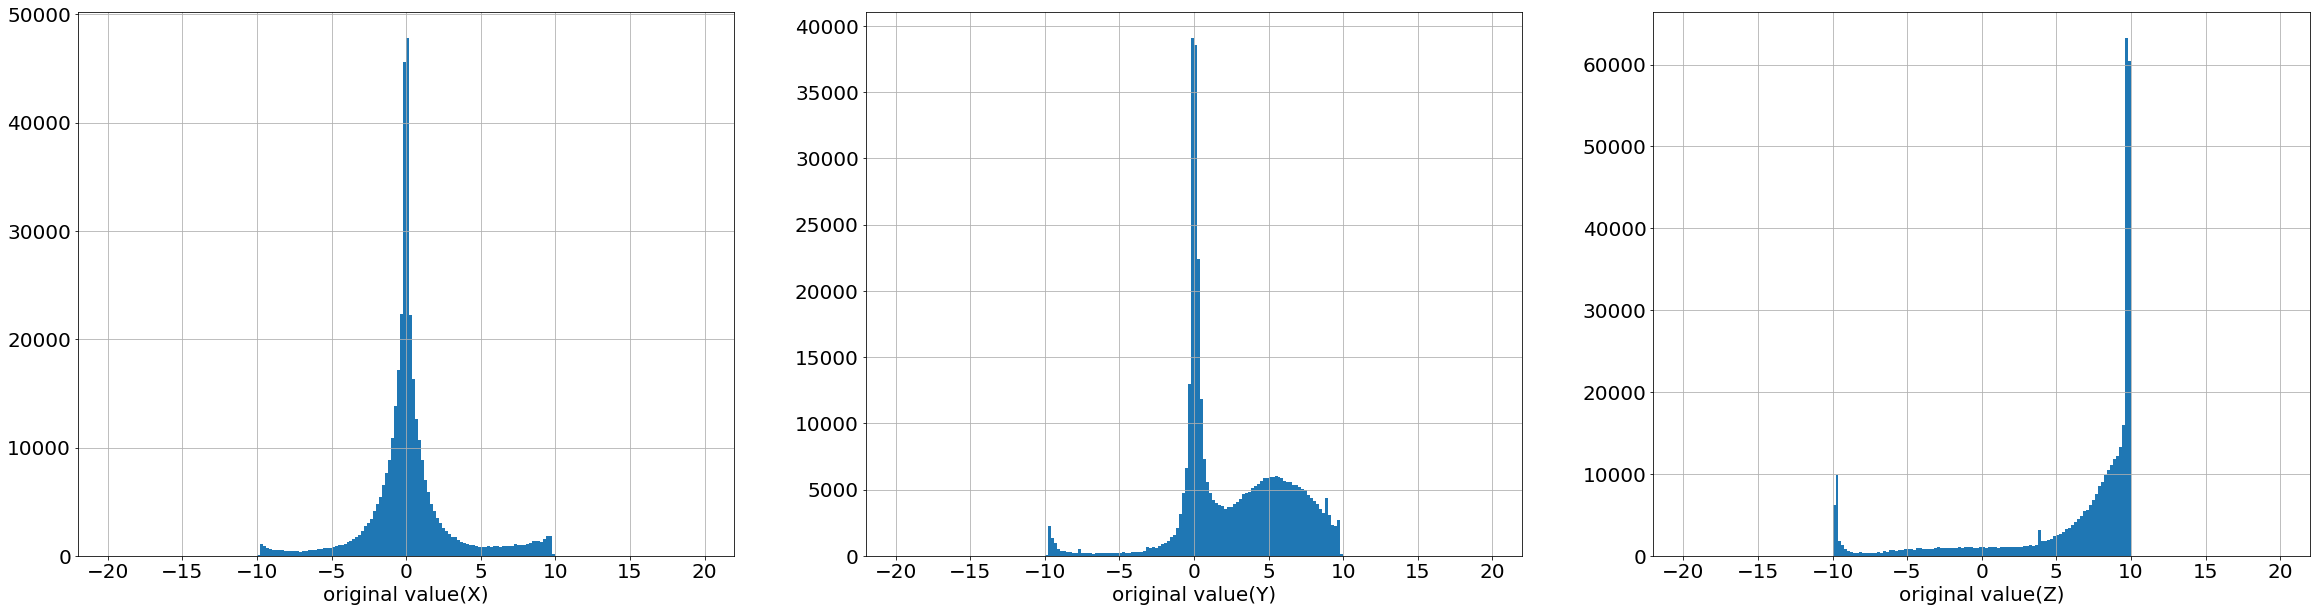

In [12]:
plt.rc('font',size=20)

from scipy.stats import yeojohnson

fig, axes = plt.subplots(ncols=3, figsize=(40,10))
axes[0].hist(aos_gravity['X'],range=[-20,20], bins=200)
axes[0].set_xlabel('original value(X)')
axes[0].grid(True)

axes[1].hist(aos_gravity['Y'],range=[-20,20], bins=200)
axes[1].set_xlabel('original value(Y)')
axes[1].grid(True)

axes[2].hist(aos_gravity['Z'],range=[-20,20], bins=200)
axes[2].set_xlabel('original value(Z)')
axes[2].grid(True)

In [ ]:
import plotly.graph_objs as go


fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=aos_grav_p118.index, y=aos_grav_p118['X'],
                    mode='lines',
                    line=dict(color="#E91E63"),
                    name='X_axis', yaxis="y1",))
fig.add_trace(go.Scatter(x=aos_grav_p118.index, y=aos_grav_p118['Y'],
                    mode='lines',
                    line=dict(color="#795548"),
                    name='Y_axis', yaxis="y2",))
fig.add_trace(go.Scatter(x=aos_grav_p118.index, y=aos_grav_p118['Z'],
                    mode='lines',
                    line=dict(color="#2196F3"),
                    name='Z_axis', yaxis="y3",))
fig.add_trace(go.Scatter(x=aos_grav_p118.index, y=np.sqrt(aos_grav_p118['X']**2+aos_grav_p118['Y']**2+aos_grav_p118['Z']**2),
                    mode='lines',
                    line=dict(color="#00ff00"),
                    name='Magnitude', yaxis="y4",))

# style all the traces
fig.update_traces(
    hoverinfo="name+x",
    line={"width": 0.5},
    marker={"size": 8},
    mode="lines",
    showlegend=False 
)


# Update axes
fig.update_layout(
    xaxis=dict(
        autorange=True, # Determines whether or not range of axis is computed in relation to input data. one of ( True | False | "reversed" )
        rangeslider=dict(
            autorange=True, 
        ),
        type="date" # Sets the axis type, reference: https://plotly.com/python/reference/layout/xaxis/#layout-xaxis-type
                    # one of ( "-" | "linear" | "log" | "date" | "category" | "multicategory" )
    ),

    yaxis1=dict(
        anchor="x",
        autorange=True,
        domain=[0.2, 0.4], # Set visualization range for sub plot
        linecolor="#E91E63", # Select the line color
        mirror=True, # Determines if the axis lines or/and ticks are mirrored to the opposite side of the plotting area. 
                     # one of ( True | "ticks" | False | "all" | "allticks" )
                     # reference: https://plotly.com/python/reference/layout/xaxis/#layout-xaxis-mirror
        showline=True,
        side="right",
        tickfont={"color": "#E91E63"}, # Set the tickfont color

        tickmode="auto", # Sets the tick mode for this axis, one of ( "auto" | "linear" | "array" ), 
                         # reference: https://plotly.com/python/reference/layout/xaxis/#layout-xaxis-tickmode

        ticks="", # Determines whether ticks are drawn or not. If "", this axis' ticks are not drawn.
                  # one of ( "outside" | "inside" | "" ), reference: https://plotly.com/python/reference/layout/xaxis/#layout-xaxis-ticks

        title="X_axis", # Set title of data

        titlefont={"color": "#E91E63"}, # Set the title font color
        type="linear", 
        zeroline=False
    ),

    yaxis2=dict(
        anchor="x",
        autorange=True,
        domain=[0.4, 0.6], 
        linecolor="#795548", 
        mirror=True,
        showline=True,
        side="right",
        tickfont={"color": "#795548"}, 
        tickmode="auto",
        ticks="",
        title="Y_axis", 
        titlefont={"color": "#795548"}, 
        type="linear",
        zeroline=False
    ),

    yaxis3=dict(
        anchor="x",
        autorange=True,
        domain=[0.6, 0.8], 
        linecolor="#2196F3", 
        mirror=True,
        showline=True,
        side="right",
        tickfont={"color": "#2196F3"}, 
        tickmode="auto",
        ticks="",
        title="Z_axis", 
        titlefont={"color": "#2196F3"}, 
        type="linear",
        zeroline=False
    ),

    yaxis4=dict(
        anchor="x",
        autorange=True,
        domain=[0.8, 1], 
        linecolor="#00ff00", 
        mirror=True,
        showline=True,
        side="right",
        tickfont={"color": "#00ff00"}, 
        tickmode="auto",
        ticks="",
        title="Magnitude", 
        titlefont={"color": "#00ff00"}, 
        type="linear",
        zeroline=False
    ))

# Update layout
fig.update_layout(
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
)

fig.show()

### Feature Extraction

In [54]:
def get_gravity_features(feature, survey, pids, window_size):

    _d_name = 'GRAVITY'
    _w_name = '{}HR'.format(window_size)
    cluster_list = list()

    gravity_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')
    
    for pid in tqdm(pids):
        ema = survey.loc[pid]
        data_source = feature.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t - timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
            features = defaultdict(lambda: np.nan)
        
            if len(d_window) == 0:
                pass
            else:  
                for gravity_component in ['X','Y','Z']:  
                    avg ='{}#{}#{}#mean'.format(_d_name,_w_name, gravity_component) 
                    mi ='{}#{}#{}#min'.format(_d_name,_w_name, gravity_component) 
                    ma ='{}#{}#{}#max'.format(_d_name,_w_name, gravity_component) 
                    std ='{}#{}#{}#std'.format(_d_name,_w_name, gravity_component) 
                    kurt ='{}#{}#{}#kurtosis'.format(_d_name,_w_name, gravity_component) 
                    ske ='{}#{}#{}#skewness'.format(_d_name,_w_name, gravity_component) 

                    features[avg]=d_window[gravity_component].mean()
                    features[mi]=d_window[gravity_component].min()
                    features[ma]=d_window[gravity_component].max()
                    features[std]=d_window[gravity_component].std()
                    features[kurt]=kurtosis(d_window[gravity_component])
                    features[ske]=skew(d_window[gravity_component])

            output_table = output_table.append(features, ignore_index=True)

        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        output_table.interpolate(method='linear', inplace=True, limit_direction="both")
        gravity_df = pd.concat([gravity_df, output_table])

    if pids == aos_pids:
        gravity_df.to_csv('aos_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 
    else:
        gravity_df.to_csv('ios_features/ios_{}_{}.csv'.format(_d_name,_w_name)) 
    
    return gravity_df

In [55]:
for w in range(4, 5, 4):
 #   get_gravity_features(aos_gravity, aos_ema, aos_pids, w)
    get_gravity_features(ios_gravity, ios_ema, ios_pids, w)

Processing for window size = 4
-------------------------------------------


100%|██████████| 221/221 [00:24<00:00,  9.08it/s]


In [56]:
len(ios_ema)

10656

## Ambient Sound
* every 15 mins
* Numerical(continuous)
* Pitch, sound energy
* pitch of 81.0625 likely to background noise, this implies occurrance of a sound w/ pitch is not enough 

In [86]:
sensorName = 'SOUND_DATA'
cols = ['timestamp', 'measure', 'flag']
dtypes = {'measure':float, 'flag':'category'}

aos_sound = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols, dtypes = dtypes) 
aos_sound.loc[aos_sound.flag == 'PITCH', 'measure'] = aos_sound.loc[aos_sound.flag == 'PITCH', 'measure']  - 81.066180 # 81.0625

ios_sound = load_data(path = ios_path, sensorName=sensorName, pids=ios_pids, cols=cols, dtypes = dtypes) 
ios_sound.loc[ios_sound.flag == 'PITCH', 'measure'] = ios_sound.loc[ios_sound.flag == 'PITCH', 'measure']  - 21.21078


100%|██████████| 191/191 [00:01<00:00, 112.11it/s]


In [193]:
a = aos_sound.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('aos_preprocessed/aos_SOUND.csv')

a = ios_sound.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('ios_preprocessed/ios_SOUND.csv')

### Data Analysis

In [29]:
aos_sound.loc[aos_sound.flag == 'PITCH'].describe()

,measure
count,142633.000000
mean,5.135188
std,39.333411
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,767.010720


In [14]:
aos_sound.loc[aos_sound.flag == 'PITCH'].value_counts()

measure     flag 
0.000000    PITCH    138642
76.433820   PITCH       213
169.502000  PITCH        84
359.933820  PITCH        83
143.933820  PITCH        83
                      ...  
3.741510    PITCH         2
20.080610   PITCH         2
0.600484    PITCH         2
13.164590   PITCH         1
15.644346   PITCH         1
Length: 124, dtype: int64

In [15]:
aos_sound.flag.value_counts()

ENERGY    253361
PITCH     142633
Name: flag, dtype: int64

In [ ]:
aos_sound.min()

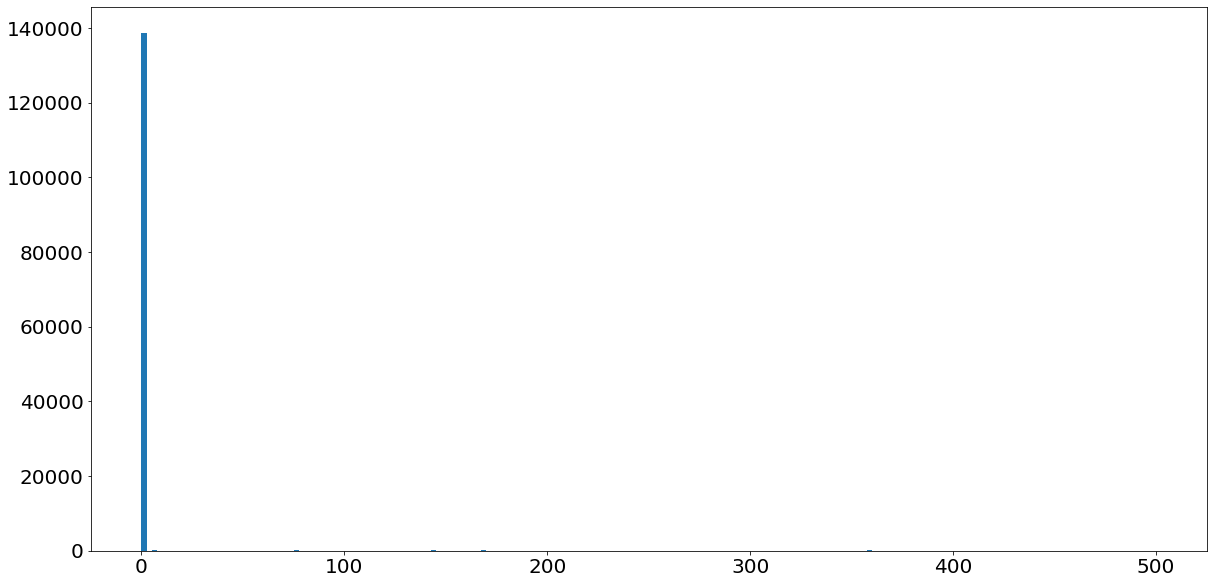

In [30]:
plt.figure(figsize=(20,10))
plt.hist(aos_sound.loc[aos_sound.flag == 'PITCH'].measure, bins=200, range=[0, 500])
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

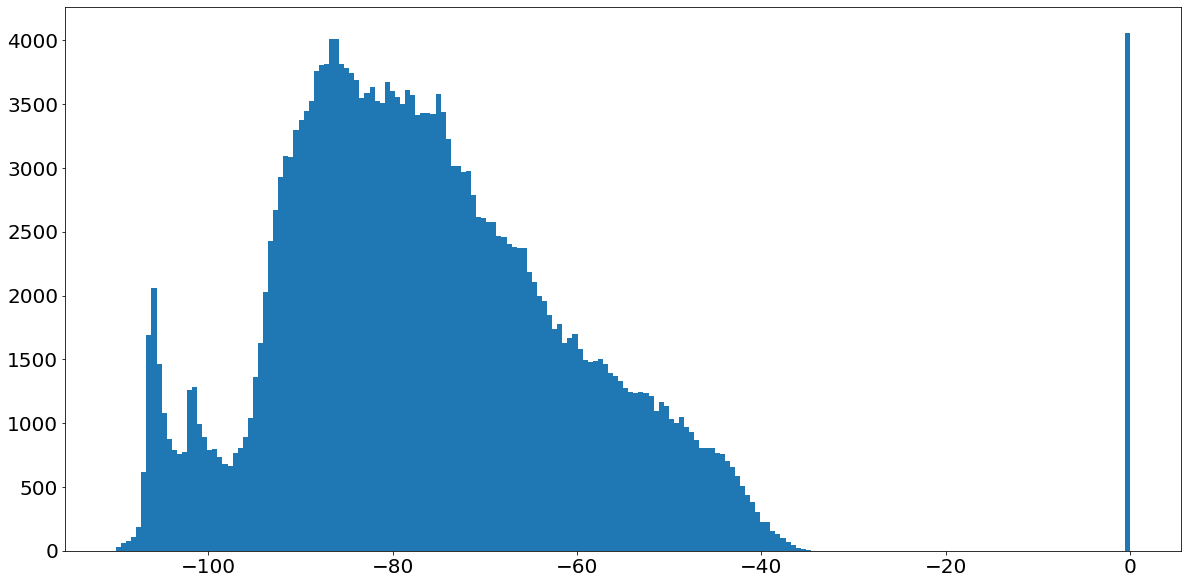

In [16]:
plt.figure(figsize=(20,10))
plt.hist(aos_sound.loc[aos_sound.flag == 'ENERGY'].measure, bins=200)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### Feature Extraction

In [87]:
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings(action='ignore')

def get_sound_features(feature, survey, pids, window_size):

    _d_name = 'SOUND'
    _w_name = '{}HR'.format(window_size)
    sound_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')
    
    for pid in tqdm(pids):
        ema = survey.loc[pid]
        data_source = feature.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t- timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
                        
            features = defaultdict(lambda: np.nan)
            if len(d_window)==0:
                output_table = output_table.append(features, ignore_index=True)
                continue

            for sound_flag in ['PITCH', 'ENERGY']:                
                d_window_flag = d_window[d_window.flag==sound_flag]
                avg ='{}#{}#{}#mean'.format(_d_name,_w_name, sound_flag) 
                std ='{}#{}#{}#std'.format(_d_name,_w_name, sound_flag) 
                kurt ='{}#{}#{}#kurtosis'.format(_d_name,_w_name, sound_flag) 
                ske ='{}#{}#{}#skewness'.format(_d_name,_w_name, sound_flag) 

                features[avg]=d_window_flag['measure'].mean()
                features[std]=d_window_flag['measure'].std()
                features[kurt]=kurtosis(d_window_flag['measure'])
                features[ske]=skew(d_window_flag['measure'])

            output_table = output_table.append(features, ignore_index=True)
    
        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        output_table.interpolate(method='linear', inplace=True, limit_direction="both")
        sound_df = pd.concat([sound_df, output_table])
        
    sound_df.interpolate(method='linear', inplace=True, limit_direction="both")
    if pids == aos_pids:
        sound_df.to_csv('aos_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 
    else:
        sound_df.to_csv('ios_features/ios_{}_{}.csv'.format(_d_name,_w_name)) 

    return sound_df

In [89]:
for w in range(4, 5, 4):
    get_sound_features(aos_sound, aos_ema, aos_pids, w)
    get_sound_features(ios_sound, ios_ema, ios_pids, w)

Processing for window size = 4
-------------------------------------------


100%|██████████| 191/191 [00:21<00:00,  8.74it/s]


#### Interpolation

In [174]:
a = get_sound_features(aos_sound, aos_ema, aos_pids, 4)

Processing for window size = 4
-------------------------------------------


100%|██████████| 35/35 [00:09<00:00,  3.65it/s]


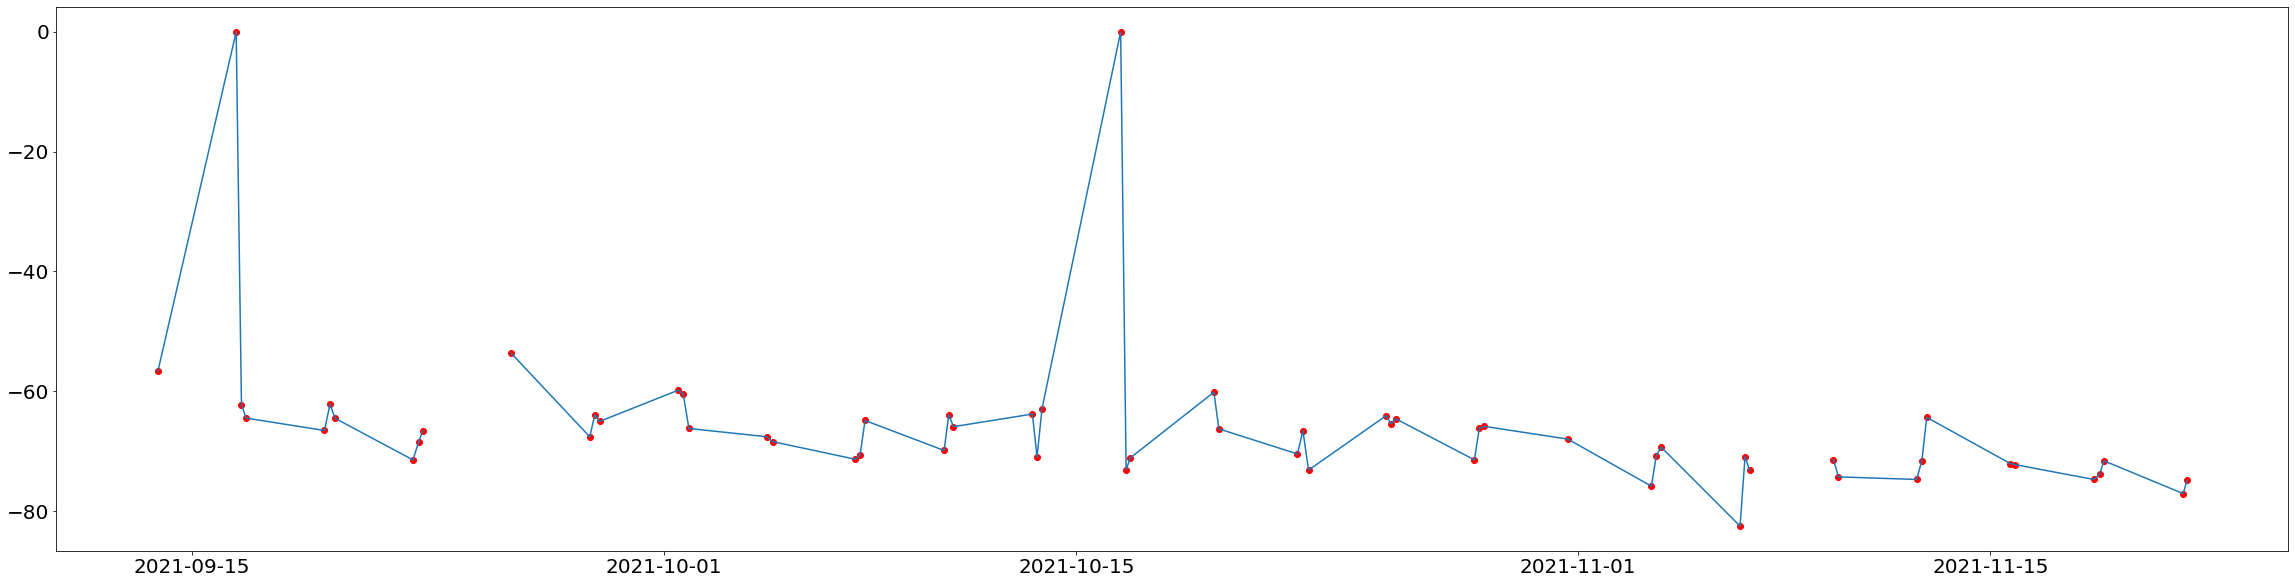

In [163]:
plt.figure(figsize=(40,10))
plt.scatter(a.loc[14].index, a.loc[14]['SOUND#4HR#ENERGY#mean'], color='r')
plt.plot(a.loc[14].index, a.loc[14]['SOUND#4HR#ENERGY#mean'])
plt.yticks(size=20)
plt.xticks(size=20)

plt.show()

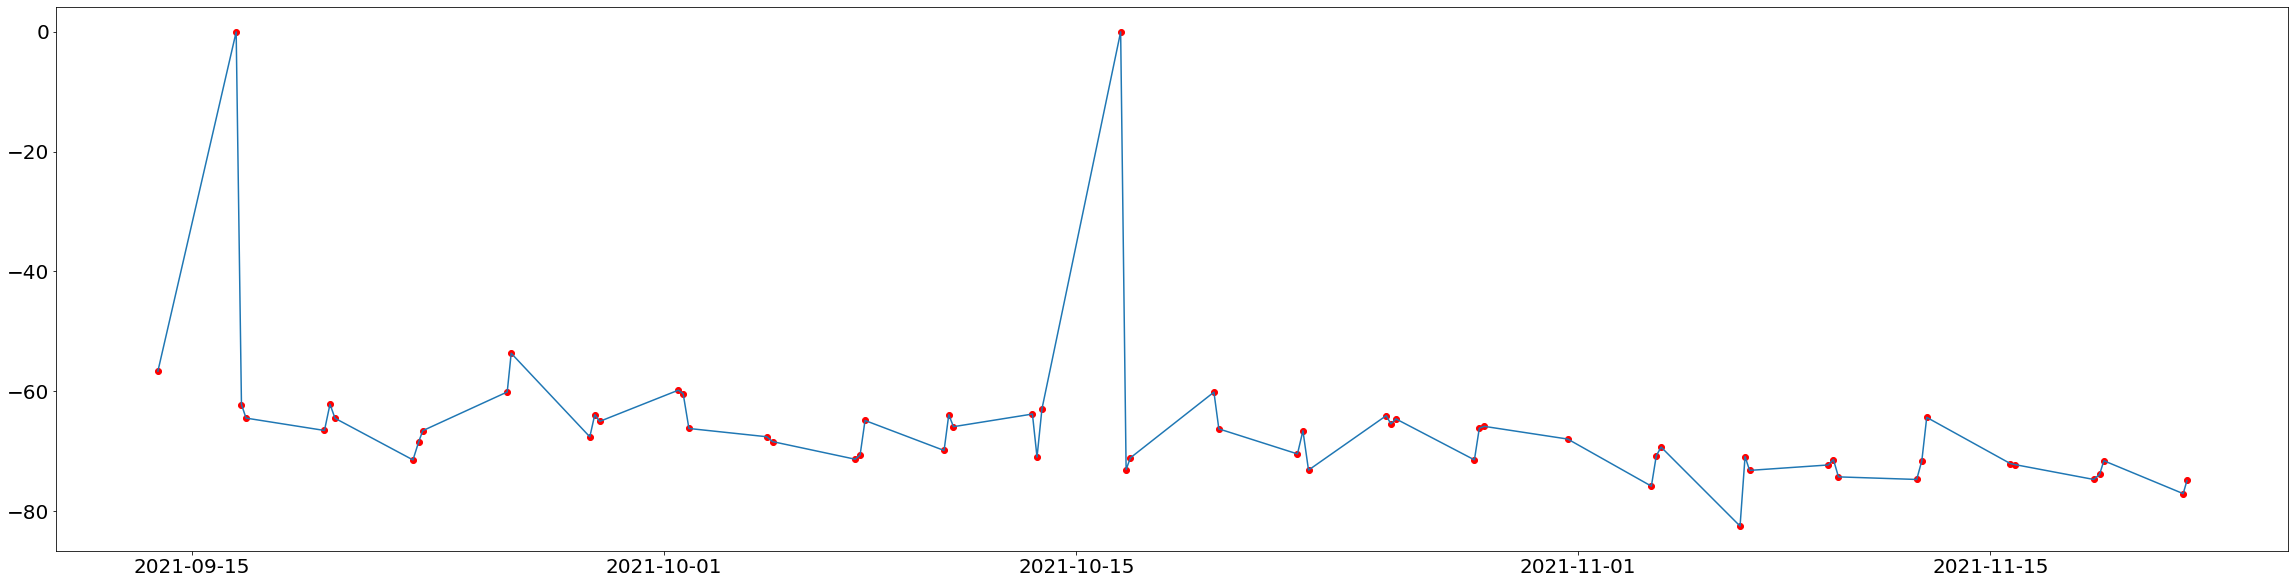

In [160]:
plt.figure(figsize=(40,10))
plt.scatter(a.loc[14].index, a.loc[14]['SOUND#4HR#ENERGY#mean'], color='r')
plt.plot(a.loc[14].index, a.loc[14]['SOUND#4HR#ENERGY#mean'])
plt.yticks(size=20)
plt.xticks(size=20)

plt.show()

## Ambient Light
* Exclude too high brightness values > 1000 lumens (TBD)
* Log transformation: https://docs.microsoft.com/en-us/windows/win32/sensorsapi/understanding-and-interpreting-lux-values

In [208]:
sensorName = 'ANDROID_LIGHT'
cols = ['timestamp','Brightness']
dtypes = {'Brightness':'float16'}

aos_light = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols, dtypes = dtypes) 

# Perceived light intensity (lx)
aos_light['Brightness_Log'] = np.log10(aos_light['Brightness'])
aos_light = aos_light[aos_light['Brightness']<=100000]
aos_light['Brightness_Log'] = aos_light['Brightness_Log'].apply(lambda x: 0 if x<0 else x)

100%|██████████| 336/336 [00:08<00:00, 40.47it/s]


In [209]:
a = aos_light.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('aos_preprocessed/aos_LIGHT.csv')

### Visualization

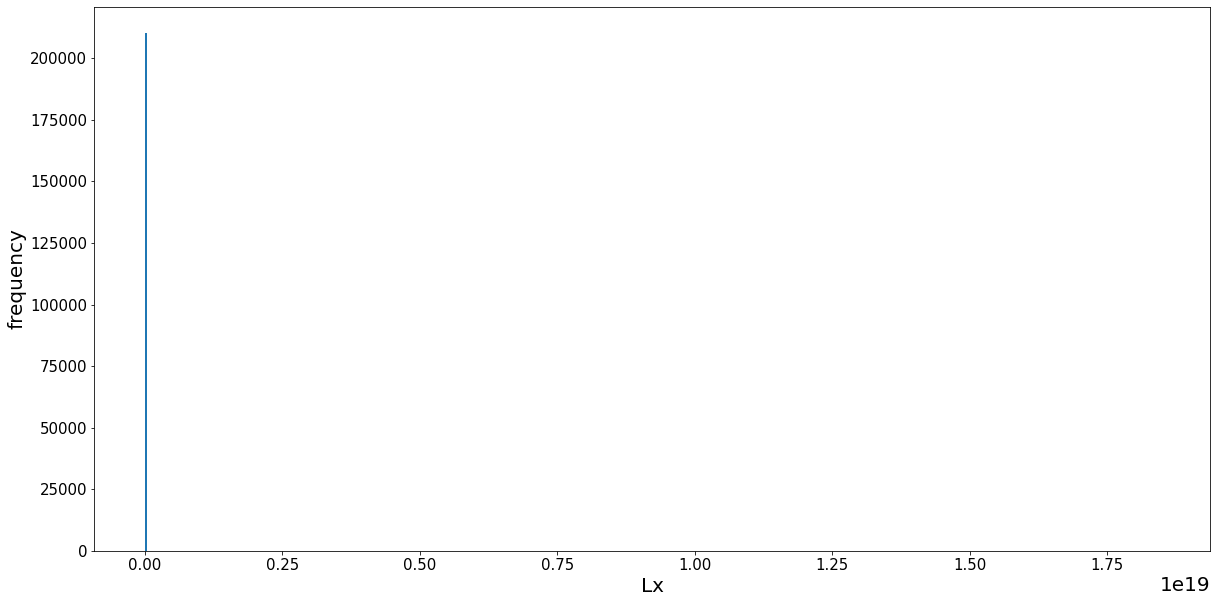

In [120]:
plt.figure(figsize=(20,10))
plt.tick_params(labelsize = 15)
plt.xlabel('Lx', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
plt.hist(aos_light['Brightness'], bins = 500)
plt.show()

### Actual vs Perceived Brightness

In [181]:
aos_light['Brightness_Log'] = np.log10(aos_light['Brightness'])

### Handling Missing Data (Outlier removal)

In [134]:
aos_light.describe()

,Brightness,Brightness_Log
count,210251.000000,2.102510e+05
mean,172.596858,-inf
std,1118.136440,NaN
min,0.000000,-inf
25%,1.000000,0.000000e+00
50%,33.000000,1.518514e+00
75%,163.000000,2.212188e+00
max,98769.000000,4.994621e+00


In [182]:
aos_light = aos_light[aos_light['Brightness']<=100000]
aos_light['Brightness_Log'] = aos_light['Brightness_Log'].apply(lambda x: 0 if x<0 else x)

In [183]:
aos_light.describe()

,Brightness,Brightness_Log
count,210251.000000,210251.000000
mean,172.596858,1.339637
std,1118.136440,1.003542
min,0.000000,0.000000
25%,1.000000,0.000000
50%,33.000000,1.518514
75%,163.000000,2.212188
max,98769.000000,4.994621


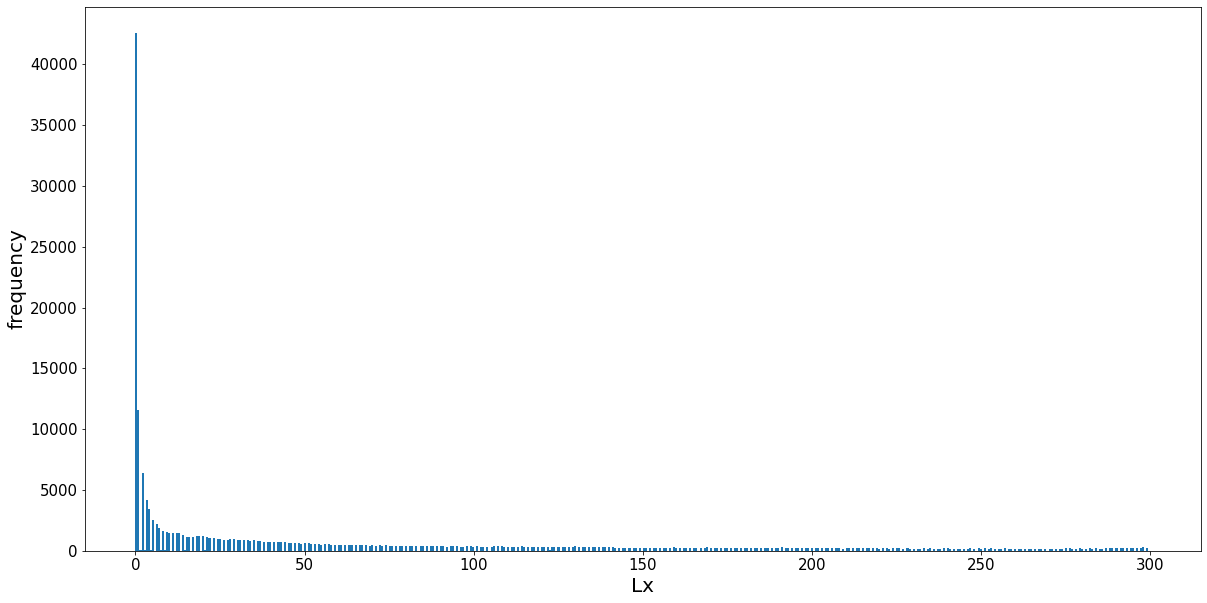

In [137]:
plt.figure(figsize=(20,10))
plt.tick_params(labelsize = 15)
plt.xlabel('Lx', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
plt.hist(aos_light['Brightness'].loc[aos_light['Brightness']<300], bins = 500)
plt.show()

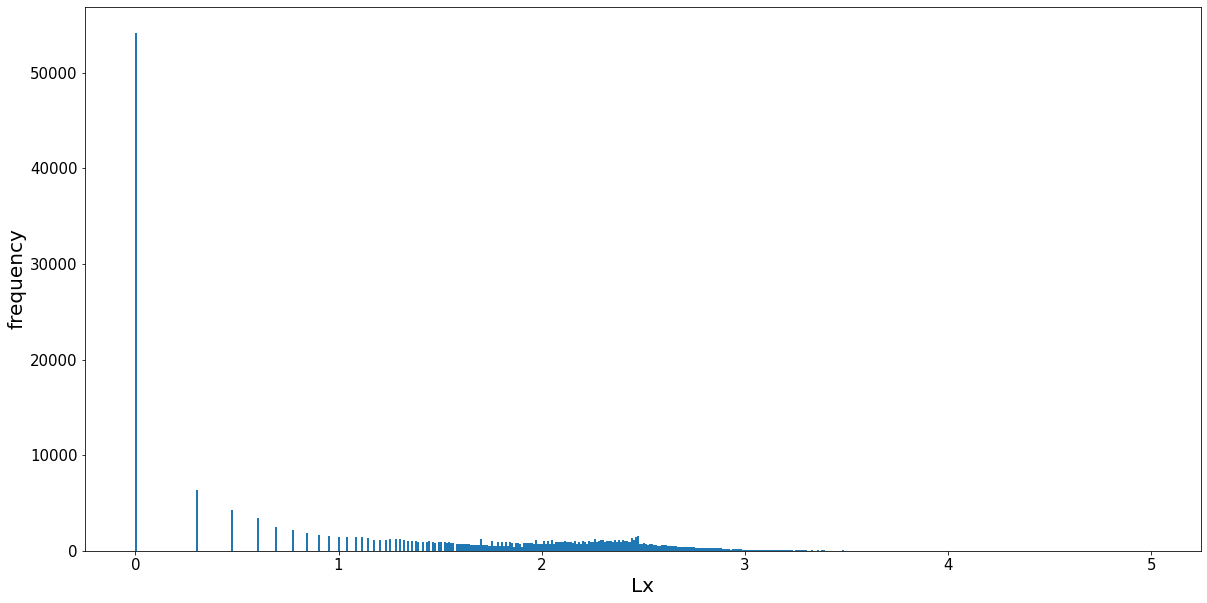

In [138]:
plt.figure(figsize=(20,10))
plt.tick_params(labelsize = 15)
plt.xlabel('Lx', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
plt.hist(aos_light['Brightness_Log'].loc[aos_light['Brightness_Log']>=0], bins = 500)
plt.show()

In [ ]:
plt.rc('font',size=20)

fig, axes = plt.subplots(ncols=2, figsize=(40,20))
axes[0].hist(aos_light['Brightness'],range=[0,1000], bins=500)
axes[0].set_xlabel('original (lux)')
axes[0].grid(True)

axes[1].hist( aos_light['Brightness_Log'], range=[0,10], bins=500)
axes[1].set_xlabel('log transformation (lux)')
axes[1].grid(True)

In [142]:
print(len(aos_light['Brightness_Log'].loc[aos_light['Brightness_Log']==0])/len(aos_light))
aos_light['Brightness_Log'].value_counts()

0.2572829617932852


0.000000    54094
0.301030     6362
0.477121     4191
0.602060     3384
0.698970     2470
            ...  
3.999739        1
3.731911        1
3.085291        1
3.131298        1
3.368473        1
Name: Brightness_Log, Length: 4411, dtype: int64

### Feature Extraction

In [210]:
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings(action='ignore')

def get_light_features(feature, survey, pids, window_size):

    _d_name = 'LIGHT'
    _w_name = '{}HR'.format(window_size)
    light_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')
    
    for pid in tqdm(pids):
        ema = survey.loc[pid]
        data_source = feature.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t- timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
                        
            features = defaultdict(lambda: np.nan)
            if len(d_window)==0:
                output_table = output_table.append(features, ignore_index=True)
                continue

            features['{}#{}#count_0'.format(_d_name,_w_name)] = len(d_window[d_window.Brightness_Log==0])

            for lux in ['Brightness_Log']: # 'Brightness' 
                avg ='{}#{}#{}#mean'.format(_d_name,_w_name, lux) 
                std ='{}#{}#{}#std'.format(_d_name,_w_name, lux) 
                kurt ='{}#{}#{}#kurtosis'.format(_d_name,_w_name, lux) 
                ske ='{}#{}#{}#skewness'.format(_d_name,_w_name, lux) 

                features[avg]=d_window[lux].mean()
                features[std]=d_window[lux].std()
                features[kurt]=kurtosis(d_window[lux])
                features[ske]=skew(d_window[lux])

            output_table = output_table.append(features, ignore_index=True)
    
        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        output_table.interpolate(method='linear', inplace=True, limit_direction="both")
        light_df = pd.concat([light_df, output_table])

    light_df.to_csv('aos_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 
    
    return light_df

In [ ]:
for w in range(4, 5, 4):
    get_light_features(aos_light, aos_ema, aos_pids, w)

#### Interpolation

In [203]:
a = get_light_features(aos_light, aos_ema, aos_pids, 4)

Processing for window size = 4
-------------------------------------------


100%|██████████| 35/35 [00:05<00:00,  6.69it/s]


In [257]:
a['LIGHT#4HR#count_0'].value_counts()[0]/len(a)

0.35047807451368285

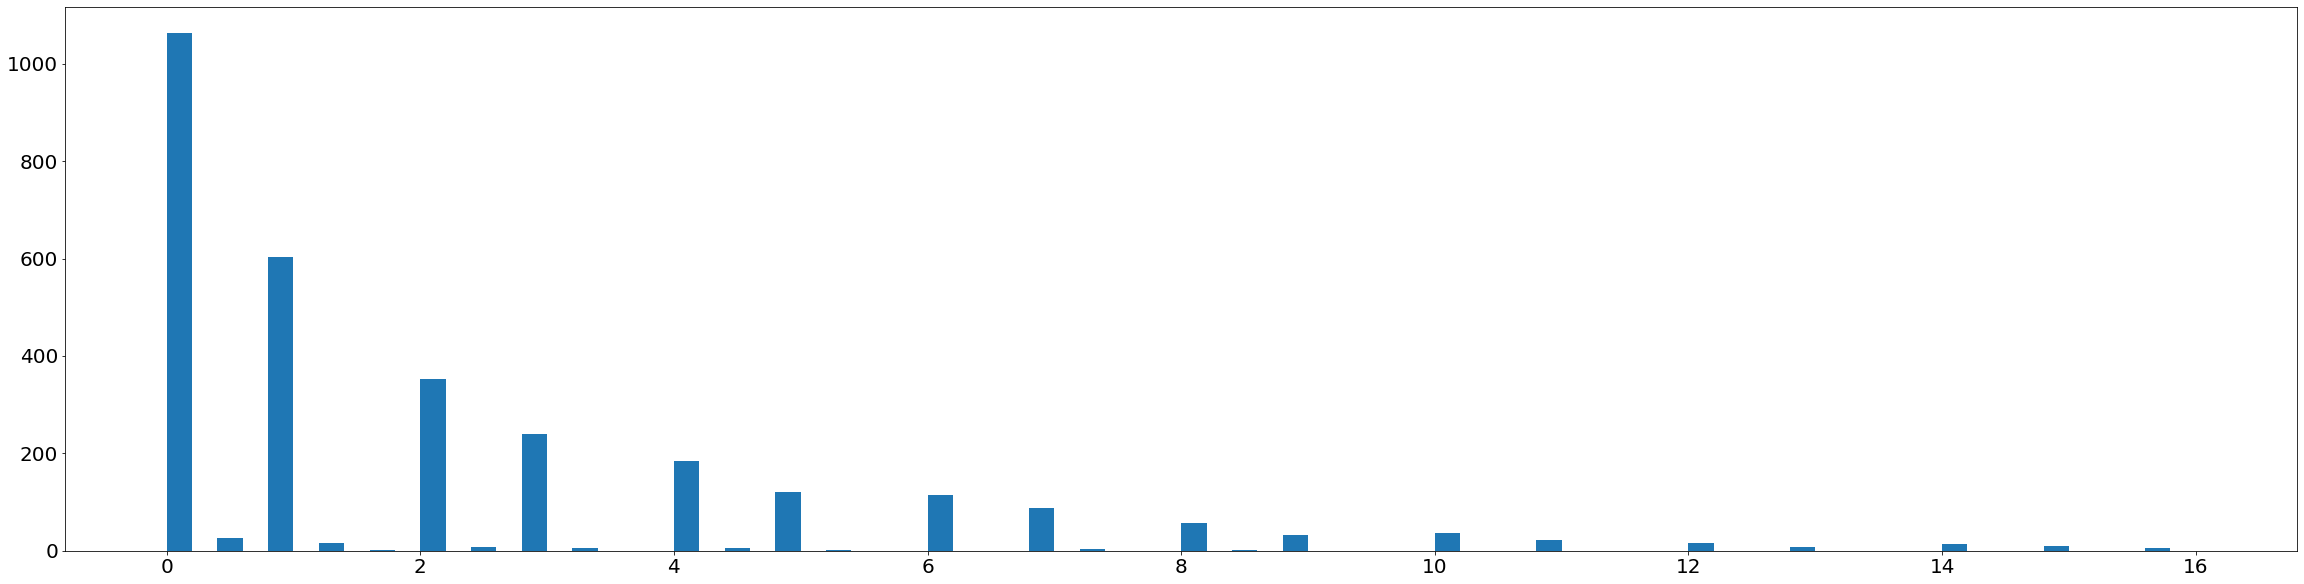

In [254]:
plt.figure(figsize=(40,10))
plt.hist(a['LIGHT#4HR#count_0'], bins=40,  width=0.2, align = 'mid')
plt.yticks(size=20)
plt.xticks(size=20)

plt.show()

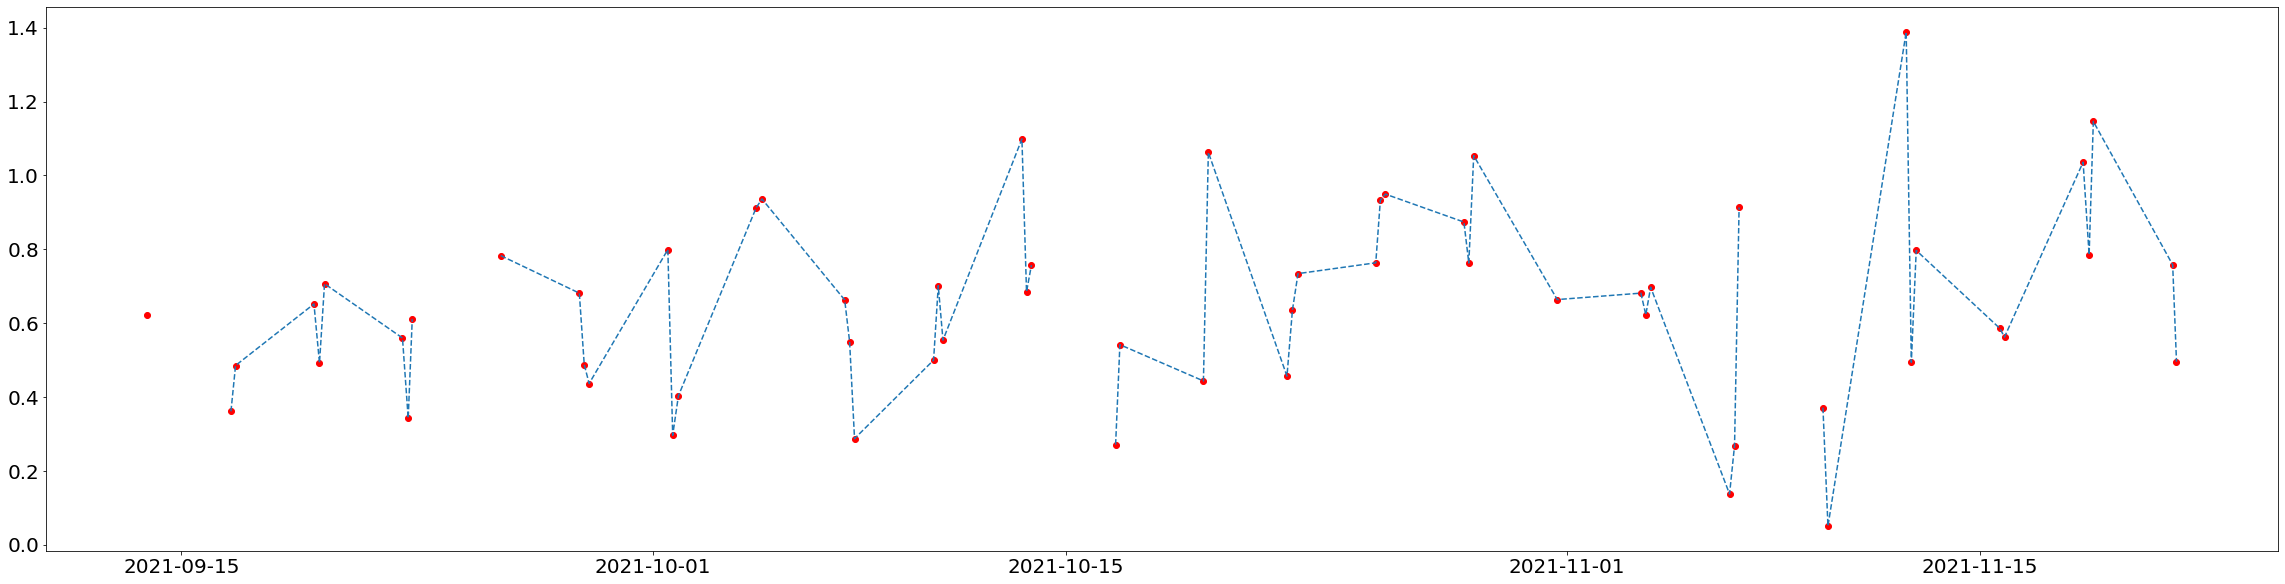

In [194]:
plt.figure(figsize=(40,10))
plt.scatter(a.loc[14].index, a.loc[14]['LIGHT#4HR#Brightness_Log#std'], color='r')
plt.plot(a.loc[14].index, a.loc[14]['LIGHT#4HR#Brightness_Log#std'], '--')
plt.yticks(size=20)
plt.xticks(size=20)

plt.show()

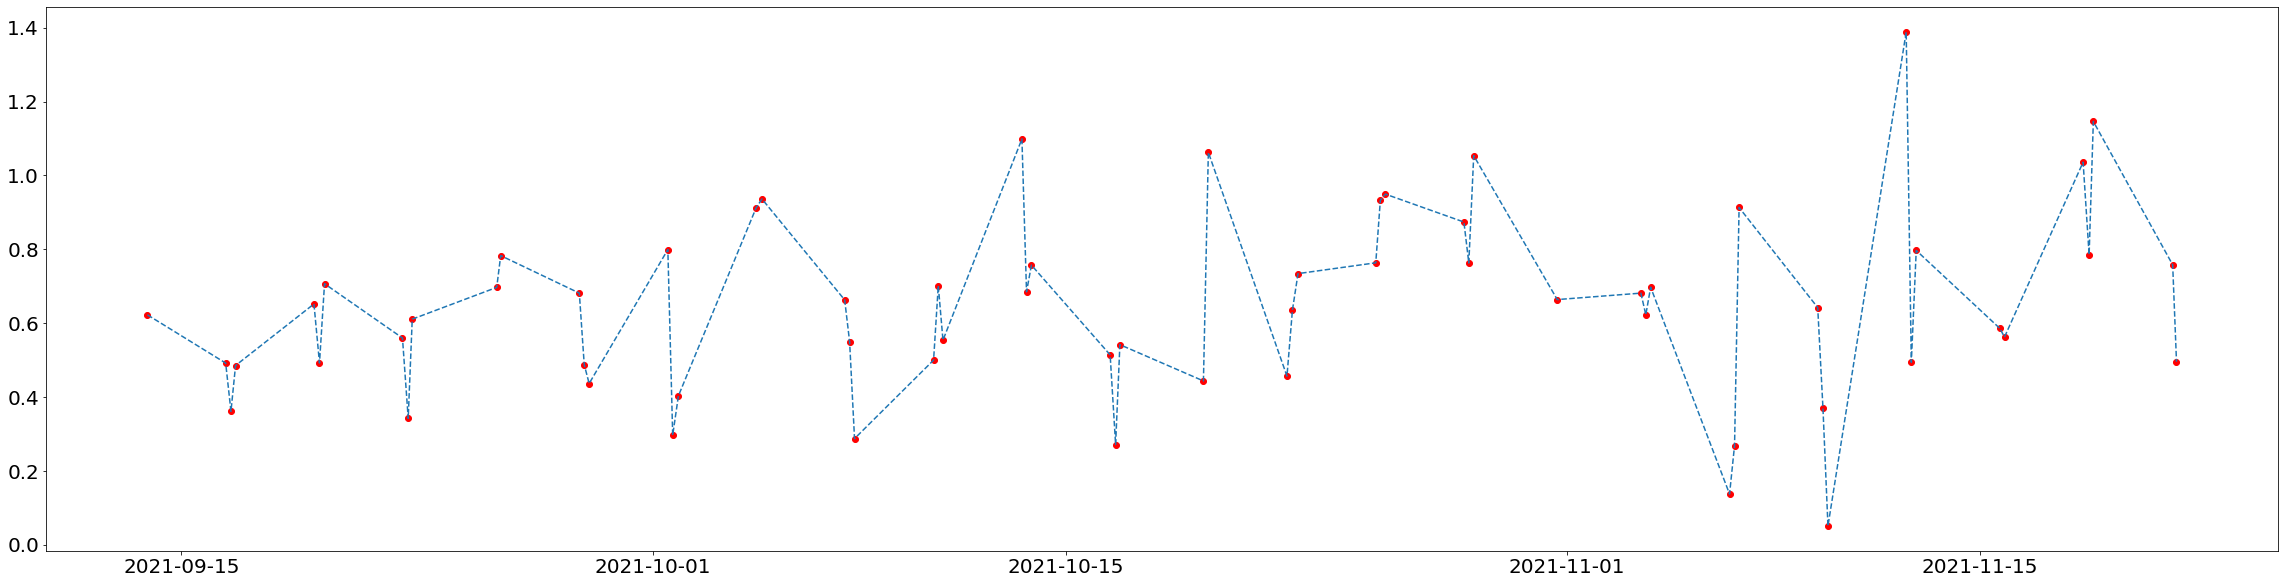

In [197]:
plt.figure(figsize=(40,10))
plt.scatter(a.loc[14].index, a.loc[14]['LIGHT#4HR#Brightness_Log#std'], color='r')
plt.plot(a.loc[14].index, a.loc[14]['LIGHT#4HR#Brightness_Log#std'], '--')
plt.yticks(size=20)
plt.xticks(size=20)

plt.show()

# 2. Social Activity

## Calendar (Not used)

In [ ]:
sensorName = 'CALENDAR'
cols = ['timestamp', 'num_events', 'flag']
dtypes = {'num_events':int, 'flag':'category'}

calendar = load_data(path = aos_path, sensorName=sensorName, pids = aos_pids, cols=cols) 
calendar = calendar.astype(dtypes)

calendar.insert(calendar.shape[1], 'num_events_diff', np.nan, allow_duplicates=True)

for pid in tqdm(calendar.index.get_level_values('pid').unique()):
    calendar.loc[pid].num_events_diff = calendar.loc[pid,'num_events'].diff()

In [ ]:
calendar.loc[14].index[0].day

In [ ]:
warnings.filterwarnings(action='ignore')


for window_size in range(4, 25, 4):
    _d_name = 'SCREEN_STATE'
    _w_name = '{}HR'.format(window_size)
    cluster_list = list()

    screen_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')
    
    for pid in tqdm(aos_pids):
        ema = aos_ema.loc[pid]
        data_source = aos_screen.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t - timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
        
            if len(d_window) == 0:
                features = defaultdict(lambda: np.nan)
            else:        
                N_on = len(d_window.loc[d_window.state=='ON'])
                N_off = len(d_window.loc[d_window.state=='OFF'])
                p_on = N_on/(N_on+N_off)
                p_off = N_off/(N_on+N_off)
                ent = -(p_on*np.log2(p_on)+p_off*np.log2(p_off))


                features = defaultdict(lambda: np.nan)
                features['{}#{}#onCount'.format(_d_name,_w_name)] = N_on
                features['{}#{}#offCount'.format(_d_name,_w_name)] = N_off
                features['{}#{}#entropy'.format(_d_name,_w_name)] = ent  
                features['{}#{}#normalized_entropy'.format(_d_name,_w_name)] = ent/np.log2(N_on+N_off)

            output_table = output_table.append(features, ignore_index=True)

        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        screen_df = pd.concat([screen_df, output_table])
        screen_df.to_csv('aos_data/aos_{}_{}.csv'.format(_d_name,_w_name)) 

### Variance Analysis

In [ ]:
output_table = pd.DataFrame()
for pid in aos_pids: 
    df = calendar.loc[pid]
    df_time = df.index
    start = df_time[0]
    end = df_time[-1]
    #print('pid:', pid, '| standard deviation:', df.num_events.std(),'| Duration:', end-start)
    #print('--------------------------------------------------------------------------------')
    features = defaultdict(lambda: np.nan)
    features['standard deviation'] = df.num_events.std()
    features['duration'] =  end-start
    output_table = output_table.append(features, ignore_index=True)
output_table.index = aos_pids

In [ ]:
output_table.describe()

In [ ]:
df_pid.index[0]

In [ ]:
f, ax = plt.subplots(5, 7)
f.set_size_inches((40, 15))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

for i in range(35):
    df_pid = calendar.loc[aos_pids[i]]['num_events']

    if i < 5:
        j = 0
        ax[i, j].plot(df_pid)
        ax[i, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i, j].set_xlabel('time')
        ax[i, j].set_ylabel('Number of Events')
        ax[i, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])
        
    elif (i>=5) & (i<10):
        j = 1    
        ax[i-5, j].plot(df_pid)
        ax[i-5, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-5, j].set_xlabel('time')
        ax[i-5, j].set_ylabel('Number of Events')
        ax[i-5, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])
        
    elif (i>=10) & (i<15):
        j = 2    
        ax[i-10, j].plot(df_pid)
        ax[i-10, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-10, j].set_xlabel('time')
        ax[i-10, j].set_ylabel('Number of Events')
        ax[i-10, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])

    elif (i>=15) & (i<20):
        j = 3    
        ax[i-15, j].plot(df_pid)
        ax[i-15, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-15, j].set_xlabel('time')
        ax[i-15, j].set_ylabel('Number of Events')
        ax[i-15, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])

    elif (i>=20) & (i<25):
        j = 4    
        ax[i-20, j].plot(df_pid)
        ax[i-20, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-20, j].set_xlabel('time')
        ax[i-20, j].set_ylabel('Number of Events')
        ax[i-20, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])

    elif (i>=25) & (i<30):
        j = 5    
        ax[i-25, j].plot(df_pid)
        ax[i-25, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-25, j].set_xlabel('time')
        ax[i-25, j].set_ylabel('Number of Events')
        ax[i-25, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])

    elif (i>=30) & (i<35):
        j = 6    
        ax[i-30, j].plot(df_pid)
        ax[i-30, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-30, j].set_xlabel('time')
        ax[i-30, j].set_ylabel('Number of Events')
        ax[i-30, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])
    
    else: pass

plt.show()

In [ ]:
f, ax = plt.subplots(5, 7)
f.set_size_inches((40, 15))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

for i in range(35):
    if i < 5:
        j = 0
        ax[i, j].hist(calendar['num_events'].loc[aos_pids[i]].reset_index().drop('timestamp', axis=1))
        ax[i, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i, j].set_xlabel('# of events')
        ax[i, j].set_ylabel('frequency')
    elif (i>=5) & (i<10):
        j = 1    
        ax[i-5, j].hist(calendar['num_events'].loc[aos_pids[i]].reset_index().drop('timestamp', axis=1))
        ax[i-5, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-5, j].set_xlabel('# of events')
        ax[i-5, j].set_ylabel('frequency')
    elif (i>=10) & (i<15):
        j = 2    
        ax[i-10, j].hist(calendar['num_events'].loc[aos_pids[i]].reset_index().drop('timestamp', axis=1))
        ax[i-10, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-10, j].set_xlabel('# of events')
        ax[i-10, j].set_ylabel('frequency')
    elif (i>=15) & (i<20):
        j = 3    
        ax[i-15, j].hist(calendar['num_events'].loc[aos_pids[i]].reset_index().drop('timestamp', axis=1))
        ax[i-15, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-15, j].set_xlabel('# of events')
        ax[i-15, j].set_ylabel('frequency')
    elif (i>=20) & (i<25):
        j = 4    
        ax[i-20, j].hist(calendar['num_events'].loc[aos_pids[i]].reset_index().drop('timestamp', axis=1))
        ax[i-20, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-20, j].set_xlabel('# of events')
        ax[i-20, j].set_ylabel('frequency')
    elif (i>=25) & (i<30):
        j = 5    
        ax[i-25, j].hist(calendar['num_events'].loc[aos_pids[i]].reset_index().drop('timestamp', axis=1))
        ax[i-25, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-25, j].set_xlabel('# of events')
        ax[i-25, j].set_ylabel('frequency')
    elif (i>=30) & (i<35):
        j = 6    
        ax[i-30, j].hist(calendar['num_events'].loc[aos_pids[i]].reset_index().drop('timestamp', axis=1))
        ax[i-30, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-30, j].set_xlabel('# of events')
        ax[i-30, j].set_ylabel('frequency')
    
    else: pass

plt.show()

In [ ]:
calendar = calendar.reset_index()
calendar['timestamp'] = calendar['timestamp'].apply(lambda x: x.value) 
calendar.to_csv('data_filtered/calendar.csv')

In [ ]:
calendar.num_events_diff.value_counts()[0.0] / len(calendar)

## Stored Media (Not used)

In [ ]:
sensorName = 'STORED_MEDIA'
cols = ['timestamp', 'count', 'media']
dtypes = {'count':int, 'media':'category'}

mediaStorage = load_data(path = aos_path, sensorName=sensorName, pids = aos_pids, cols=cols)
mediaStorage = mediaStorage.astype(dtypes)

for media_type in ['IMAGE', 'VIDEO', 'MUSIC']:
    mediaStorage.insert(mediaStorage.shape[1], f'{media_type}_cnt', np.nan, allow_duplicates=True)
    mediaStorage.insert(mediaStorage.shape[1], f'{media_type}_cnt_diff', np.nan, allow_duplicates=True)
    mediaStorage.loc[mediaStorage.media == media_type, f'{media_type}_cnt'] = mediaStorage.loc[mediaStorage.media == media_type, 'count'] 

mediaStorage['MUSIC_cnt']=mediaStorage['MUSIC_cnt'].shift(-2)
mediaStorage['VIDEO_cnt']=mediaStorage['VIDEO_cnt'].shift(-1)
mediaStorage.dropna(subset=['MUSIC_cnt', 'VIDEO_cnt', 'IMAGE_cnt'], how='any', inplace=True)
mediaStorage.drop(columns=['media', 'count'], inplace=True)

for pid in tqdm(mediaStorage.index.get_level_values('pid').unique()):
    for media_type in ['IMAGE', 'VIDEO', 'MUSIC']:
        mediaStorage.loc[pid][f'{media_type}_cnt_diff'] = mediaStorage.loc[pid][f'{media_type}_cnt'].diff()

In [ ]:
aos_media = mediaStorage.dropna()

In [ ]:
aos_media.isnull().sum()

### Feature Engineering

In [ ]:
warnings.filterwarnings(action='ignore')


for window_size in range(4, 25, 4):
    _d_name = 'STORED_MEDIA'
    _w_name = '{}HR'.format(window_size)
    cluster_list = list()

    screen_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')
    
    for pid in tqdm(aos_pids):
        ema = aos_ema.loc[pid]
        data_source = aos_screen.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t - timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
        
            if len(d_window) == 0:
                features = defaultdict(lambda: np.nan)
            else:        
                N_on = len(d_window.loc[d_window.state=='ON'])
                N_off = len(d_window.loc[d_window.state=='OFF'])
                p_on = N_on/(N_on+N_off)
                p_off = N_off/(N_on+N_off)
                ent = -(p_on*np.log2(p_on)+p_off*np.log2(p_off))


                features = defaultdict(lambda: np.nan)
                features['{}#{}#onCount'.format(_d_name,_w_name)] = N_on
                features['{}#{}#offCount'.format(_d_name,_w_name)] = N_off
                features['{}#{}#entropy'.format(_d_name,_w_name)] = ent  
                features['{}#{}#normalized_entropy'.format(_d_name,_w_name)] = ent/np.log2(N_on+N_off)

            output_table = output_table.append(features, ignore_index=True)

        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        screen_df = pd.concat([screen_df, output_table])
        screen_df.to_csv('aos_data/aos_{}_{}.csv'.format(_d_name,_w_name)) 

### Variance Analysis

In [ ]:
f, ax = plt.subplots(5, 7)
f.set_size_inches((40, 15))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

for i in range(35):
    df_pid = mediaStorage.loc[aos_pids[i]]['IMAGE_cnt']

    if i < 5:
        j = 0
        ax[i, j].plot(df_pid)
        ax[i, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i, j].set_xlabel('time')
        ax[i, j].set_ylabel('Number of Images')
        ax[i, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])
        
    elif (i>=5) & (i<10):
        j = 1    
        ax[i-5, j].plot(df_pid)
        ax[i-5, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-5, j].set_xlabel('time')
        ax[i-5, j].set_ylabel('Number of Images')
        ax[i-5, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])
        
    elif (i>=10) & (i<15):
        j = 2    
        ax[i-10, j].plot(df_pid)
        ax[i-10, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-10, j].set_xlabel('time')
        ax[i-10, j].set_ylabel('Number of Images')
        ax[i-10, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])

    elif (i>=15) & (i<20):
        j = 3    
        ax[i-15, j].plot(df_pid)
        ax[i-15, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-15, j].set_xlabel('time')
        ax[i-15, j].set_ylabel('Number of Images')
        ax[i-15, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])

    elif (i>=20) & (i<25):
        j = 4    
        ax[i-20, j].plot(df_pid)
        ax[i-20, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-20, j].set_xlabel('time')
        ax[i-20, j].set_ylabel('Number of Images')
        ax[i-20, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])

    elif (i>=25) & (i<30):
        j = 5    
        ax[i-25, j].plot(df_pid)
        ax[i-25, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-25, j].set_xlabel('time')
        ax[i-25, j].set_ylabel('Number of Images')
        ax[i-25, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])

    elif (i>=30) & (i<35):
        j = 6    
        ax[i-30, j].plot(df_pid)
        ax[i-30, j].set_title('pid {}'.format(aos_pids[i]))
        ax[i-30, j].set_xlabel('time')
        ax[i-30, j].set_ylabel('Number of Images')
        ax[i-30, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])
    
    else: pass

plt.show()

In [ ]:
mediaStorage = mediaStorage.reset_index()
mediaStorage['timestamp'] = mediaStorage['timestamp'].apply(lambda x: x.value) 
mediaStorage.to_csv('data_filtered/mediaStorage.csv')

# 3. Physical Activity

## WiFi (Not used)

In [ ]:
sensorName = 'ANDROID_WIFI'
cols = ['timestamp','APs','flag']
dtypes = {'APs':str,'flag':'category'}

aos_wifi = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols) 
aos_wifi = aos_wifi.astype(dtypes)

aos_wifi = aos_wifi[aos_wifi.flag=='SSID']

# most of APs include null data ' ' 
aos_wifi['APs']  = aos_wifi['APs'].str.replace(',,', ',')
aos_wifi.insert(aos_wifi.shape[1],'num_APs',aos_wifi.APs.str.count(',')+1,allow_duplicates=True)
aos_wifi.loc[aos_wifi.APs=="[]",'num_APs']=0# fix empty case

# convert data type from string to list
aos_wifi['APs'] = aos_wifi['APs'].apply(lambda x: x[1:-1].split(',') if len(x)>0 else x ) 

In [ ]:
aos_wifi

In [ ]:
from collections import Iterable
def flatten(lis):
     for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                yield x
        else:        
             yield item

def get_wifi_features(feature, survey, interval, window_size):
    ema = survey.copy()
    data_source = feature.copy()
    _d_name = 'wifi'
    _w_name = '{}HR'.format(interval)  
    df = pd.DataFrame()

    for p in tqdm(set(ema.index.get_level_values('pid'))):
        ema_pid = ema.loc[p]
        data_pid = data_source.loc[p]
        ema_ts = pd.to_datetime(ema_pid.index.get_level_values('timestamp'), unit='ns', utc=True)
        ds_ts = pd.to_datetime(data_pid.index.get_level_values('timestamp'), unit='ns', utc=True)
        output_table = pd.DataFrame()
        
        for t in ema_ts:          
            start = t-timedelta(hours=interval)
            df_window = data_pid[(ds_ts>=start)&(ds_ts<t)]  
            window_start = start
            w_ts = pd.to_datetime(df_window.index.get_level_values('timestamp'), unit='ns', utc=True)

            for i in range(int(interval/window_size)):
                ws = timedelta(hours=window_size)         
                d_window = df_window[(w_ts>=window_start)&(w_ts<window_start+ws)]  
                features = defaultdict(lambda: 0)
                flattened_wifi_names = list(flatten(d_window['APs'].str.replace("[", "").str.replace("]", "").str.split(",").values.tolist()))
                features['pid'] = p
                if len(d_window)==0:
                    output_table = output_table.append(features, ignore_index=True)
                    continue
                features['{}#{}#unique_APs'.format(_d_name, _w_name)] = len(set(flattened_wifi_names))   
        
                window_start = window_start + ws    
                output_table = output_table.append(features, ignore_index=True)
        df = pd.concat([df, output_table])
   
    df.set_index('pid', inplace=True)
    df.index = df.index.astype(int)
    
    return df

In [ ]:
for i in range(4, 28, 4):
    get_wifi_features(aos_fwifi, aos_fema, interval=i, window_size=0.5).to_csv('AOS/aos_wifi_{}_0.5.csv'.format(i))


## Activity Recognition (TBD)

In [111]:
sensorName = 'ACTIVITY_RECOGNITION'
cols = ['timestamp', 'activity','state']
dtypes = {'activity':'category','state':'category'}

activity = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols) 

activity.insert(activity.shape[1],'duration_in_sec',-1,allow_duplicates=True) # insert data as 'duration in sec' as last column
for pid in tqdm(activity.index.get_level_values('pid').unique()): # tqdm: show progress bar
    activity.loc[pid,'duration_in_sec'] = (activity.loc[pid].index.to_series().diff().shift(-1)).dt.total_seconds().values

activity = activity.astype(dtypes)
aos_act = activity.dropna() # Do not know the duration of the last activity of each user (34 missing values)

100%|██████████| 34/34 [00:00<00:00, 297.66it/s]


In [112]:
print(set(aos_act.activity))
print(set(aos_act.state))

{'STILL', 'WALKING', 'IN_VEHICLE', 'RUNNING', 'ON_BICYCLE'}
{'ENTER', 'EXIT'}


In [113]:
# state == 'EXIT' should not be collected
aos_act.loc[aos_act.state == 'EXIT']

,,activity,state,duration_in_sec
pid,timestamp,,,
21,2021-10-16 11:32:43.634000+09:00,STILL,EXIT,488.08


In [114]:
aos_act = aos_act.loc[aos_act.state == 'ENTER']
aos_act = aos_act.drop('state', axis=1) # Data is collected when the each activity was detected. 'EXIT' should not exist. 

In [115]:
aos_act

activity  duration_in_sec
pid timestamp                                                    
14  2021-09-15 10:38:17.510000+09:00     WALKING          578.884
    2021-09-15 10:47:56.394000+09:00       STILL         3091.845
    2021-09-15 11:39:28.239000+09:00     WALKING          135.375
    2021-09-15 11:41:43.614000+09:00       STILL           28.672
    2021-09-15 11:42:12.286000+09:00     WALKING          605.106
...                                          ...              ...
797 2022-02-11 15:42:15.290000+09:00       STILL       153130.546
    2022-02-13 10:14:25.836000+09:00  IN_VEHICLE          871.624
    2022-02-13 10:28:57.460000+09:00     WALKING          313.070
    2022-02-13 10:34:10.530000+09:00       STILL         3796.695
    2022-02-13 11:37:27.225000+09:00     WALKING          136.522

[60357 rows x 2 columns]

In [131]:
aos_act['duration_in_sec'] = aos_act['duration_in_sec'].apply(lambda x: 36000 if x>36000 else x)

### Activity Duration Analysis

In [116]:
aos_vehicle = aos_act.loc[aos_act.activity == 'IN_VEHICLE']
aos_bike = aos_act.loc[aos_act.activity == 'ON_BICYCLE']
aos_run = aos_act.loc[aos_act.activity == 'RUNNING']
aos_still = aos_act.loc[aos_act.activity == 'STILL']
aos_walk = aos_act.loc[aos_act.activity == 'WALKING']

In [117]:
act_describe = pd.concat([aos_vehicle.describe(),aos_bike.describe(), aos_run.describe(), aos_still.describe(), aos_walk.describe()], axis=1) 
act_describe.columns = ['IN_VEHICLE', 'ON_BICYCLE', 'RUNNING', 'STILL', 'WALKING']

In [118]:
act_describe

,IN_VEHICLE,ON_BICYCLE,RUNNING,STILL,WALKING
count,11463.000000,720.000000,729.000000,2.397500e+04,23470.000000
mean,928.699495,342.703708,137.756665,1.041741e+04,546.008577
std,3072.910807,370.323431,238.445874,3.404027e+04,1454.617029
min,0.002000,4.408000,0.249000,4.000000e-03,0.008000
25%,191.234500,103.607750,33.741000,2.404185e+02,180.774250
50%,559.407000,227.826000,65.885000,1.424227e+03,345.124500
75%,1071.665500,462.031500,139.699000,7.485874e+03,622.773750
max,174767.147000,3628.917000,3224.310000,2.853195e+06,90353.955000


#### In Vehicle

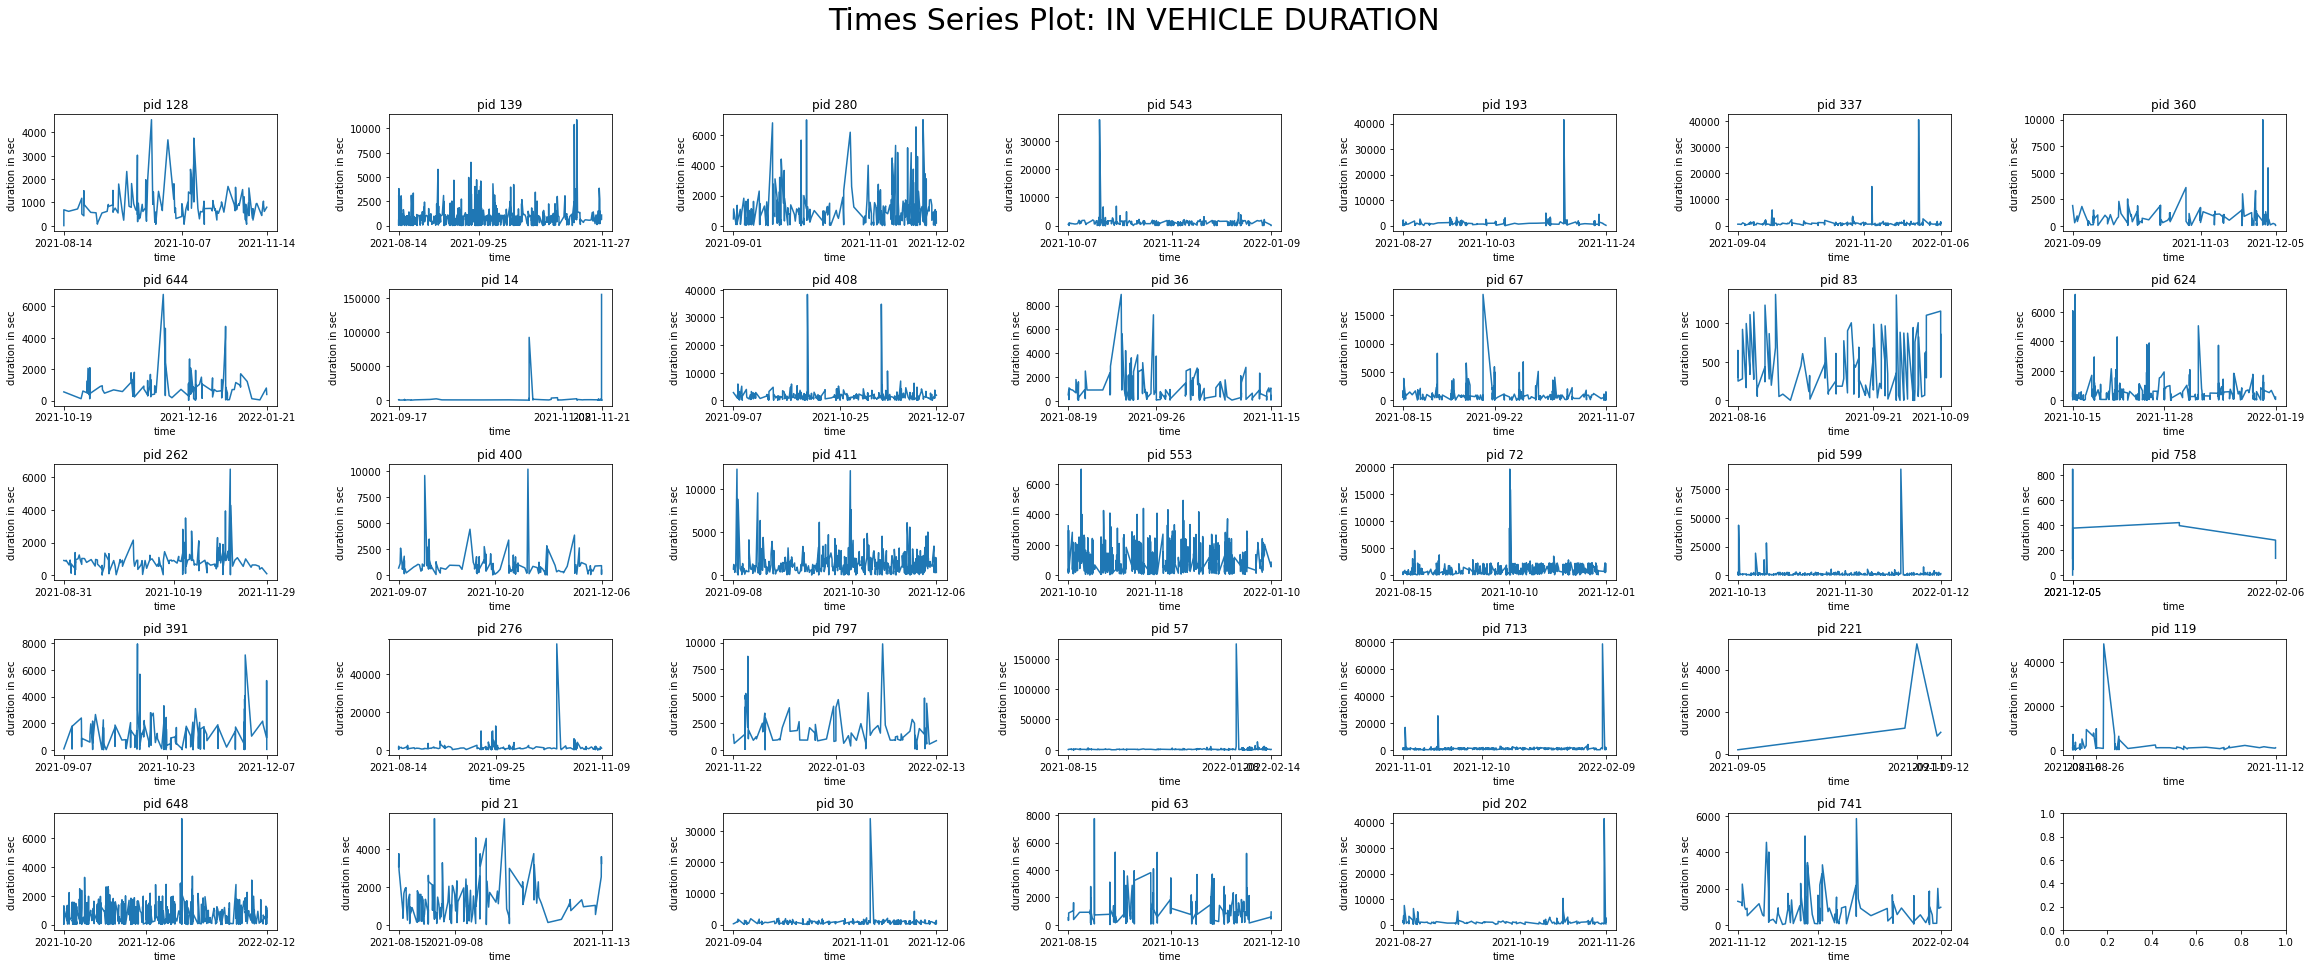

In [164]:
f, ax = plt.subplots(5, 7)
f.set_size_inches((40, 15))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.suptitle('Times Series Plot: IN VEHICLE DURATION', fontsize = 30)

vehicle_pids = list(set(aos_vehicle.index.get_level_values('pid')))

for i in range(len(vehicle_pids)):
    df_pid = aos_vehicle.loc[vehicle_pids[i]]['duration_in_sec']

    if i < 5:
        j = 0
        ax[i, j].plot(df_pid)
        ax[i, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i, j].set_xlabel('time')
        ax[i, j].set_ylabel('duration in sec')
        ax[i, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])
        
    elif (i>=5) & (i<10):
        j = 1    
        ax[i-5, j].plot(df_pid)
        ax[i-5, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-5, j].set_xlabel('time')
        ax[i-5, j].set_ylabel('duration in sec')
        ax[i-5, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])
        
    elif (i>=10) & (i<15):
        j = 2    
        ax[i-10, j].plot(df_pid)
        ax[i-10, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-10, j].set_xlabel('time')
        ax[i-10, j].set_ylabel('duration in sec')
        ax[i-10, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])

    elif (i>=15) & (i<20):
        j = 3    
        ax[i-15, j].plot(df_pid)
        ax[i-15, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-15, j].set_xlabel('time')
        ax[i-15, j].set_ylabel('duration in sec')
        ax[i-15, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])

    elif (i>=20) & (i<25):
        j = 4    
        ax[i-20, j].plot(df_pid)
        ax[i-20, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-20, j].set_xlabel('time')
        ax[i-20, j].set_ylabel('duration in sec')
        ax[i-20, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])

    elif (i>=25) & (i<30):
        j = 5    
        ax[i-25, j].plot(df_pid)
        ax[i-25, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-25, j].set_xlabel('time')
        ax[i-25, j].set_ylabel('duration in sec')
        ax[i-25, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])

    elif (i>=30) & (i<35):
        j = 6    
        ax[i-30, j].plot(df_pid)
        ax[i-30, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-30, j].set_xlabel('time')
        ax[i-30, j].set_ylabel('duration in sec')
        ax[i-30, j].set_xticks([df_pid.index[0], df_pid.index[int(len(df_pid)/2)], df_pid.index[-1]])
    
    else: pass

plt.show()

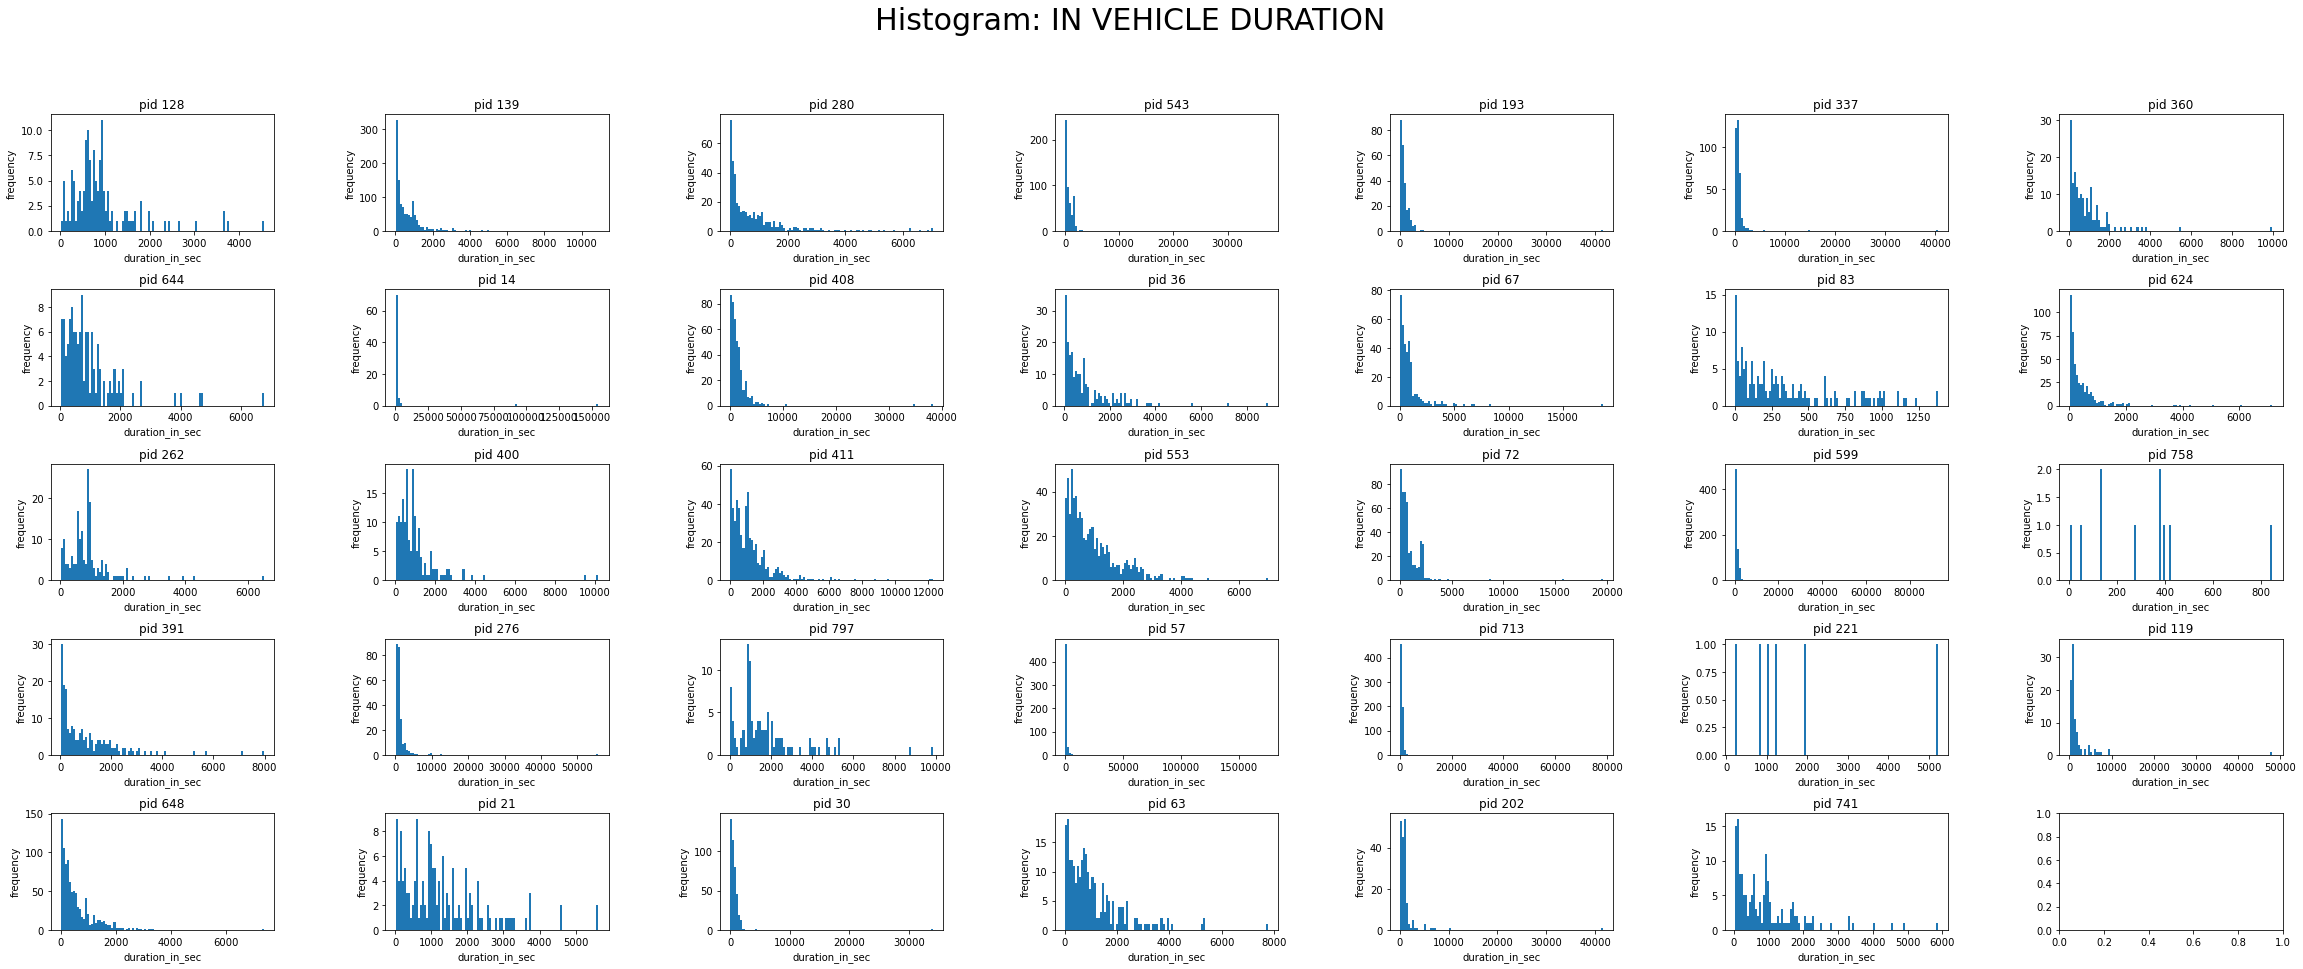

In [168]:
f, ax = plt.subplots(5, 7)
f.set_size_inches((40, 15))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.suptitle('Histogram: IN VEHICLE DURATION', fontsize = 30)

vehicle_pids = list(set(aos_vehicle.index.get_level_values('pid')))

for i in range(len(vehicle_pids)):
    df_pid = aos_vehicle.loc[vehicle_pids[i]]['duration_in_sec']

    if i < 5:
        j = 0
        ax[i, j].hist(df_pid, bins=100)
        ax[i, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i, j].set_xlabel('duration_in_sec')
        ax[i, j].set_ylabel('frequency')
        
    elif (i>=5) & (i<10):
        j = 1    
        ax[i-5, j].hist(df_pid, bins=100)
        ax[i-5, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-5, j].set_xlabel('duration_in_sec')
        ax[i-5, j].set_ylabel('frequency')
        
    elif (i>=10) & (i<15):
        j = 2    
        ax[i-10, j].hist(df_pid, bins=100)
        ax[i-10, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-10, j].set_xlabel('duration_in_sec')
        ax[i-10, j].set_ylabel('frequency')

    elif (i>=15) & (i<20):
        j = 3    
        ax[i-15, j].hist(df_pid, bins=100)
        ax[i-15, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-15, j].set_xlabel('duration_in_sec')
        ax[i-15, j].set_ylabel('frequency')

    elif (i>=20) & (i<25):
        j = 4    
        ax[i-20, j].hist(df_pid, bins=100)
        ax[i-20, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-20, j].set_xlabel('duration_in_sec')
        ax[i-20, j].set_ylabel('frequency')

    elif (i>=25) & (i<30):
        j = 5    
        ax[i-25, j].hist(df_pid, bins=100)
        ax[i-25, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-25, j].set_xlabel('duration_in_sec')
        ax[i-25, j].set_ylabel('frequency')

    elif (i>=30) & (i<35):
        j = 6    
        ax[i-30, j].hist(df_pid, bins=100)
        ax[i-30, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-30, j].set_xlabel('duration_in_sec')
        ax[i-30, j].set_ylabel('frequency')
    
    else: pass

plt.show()

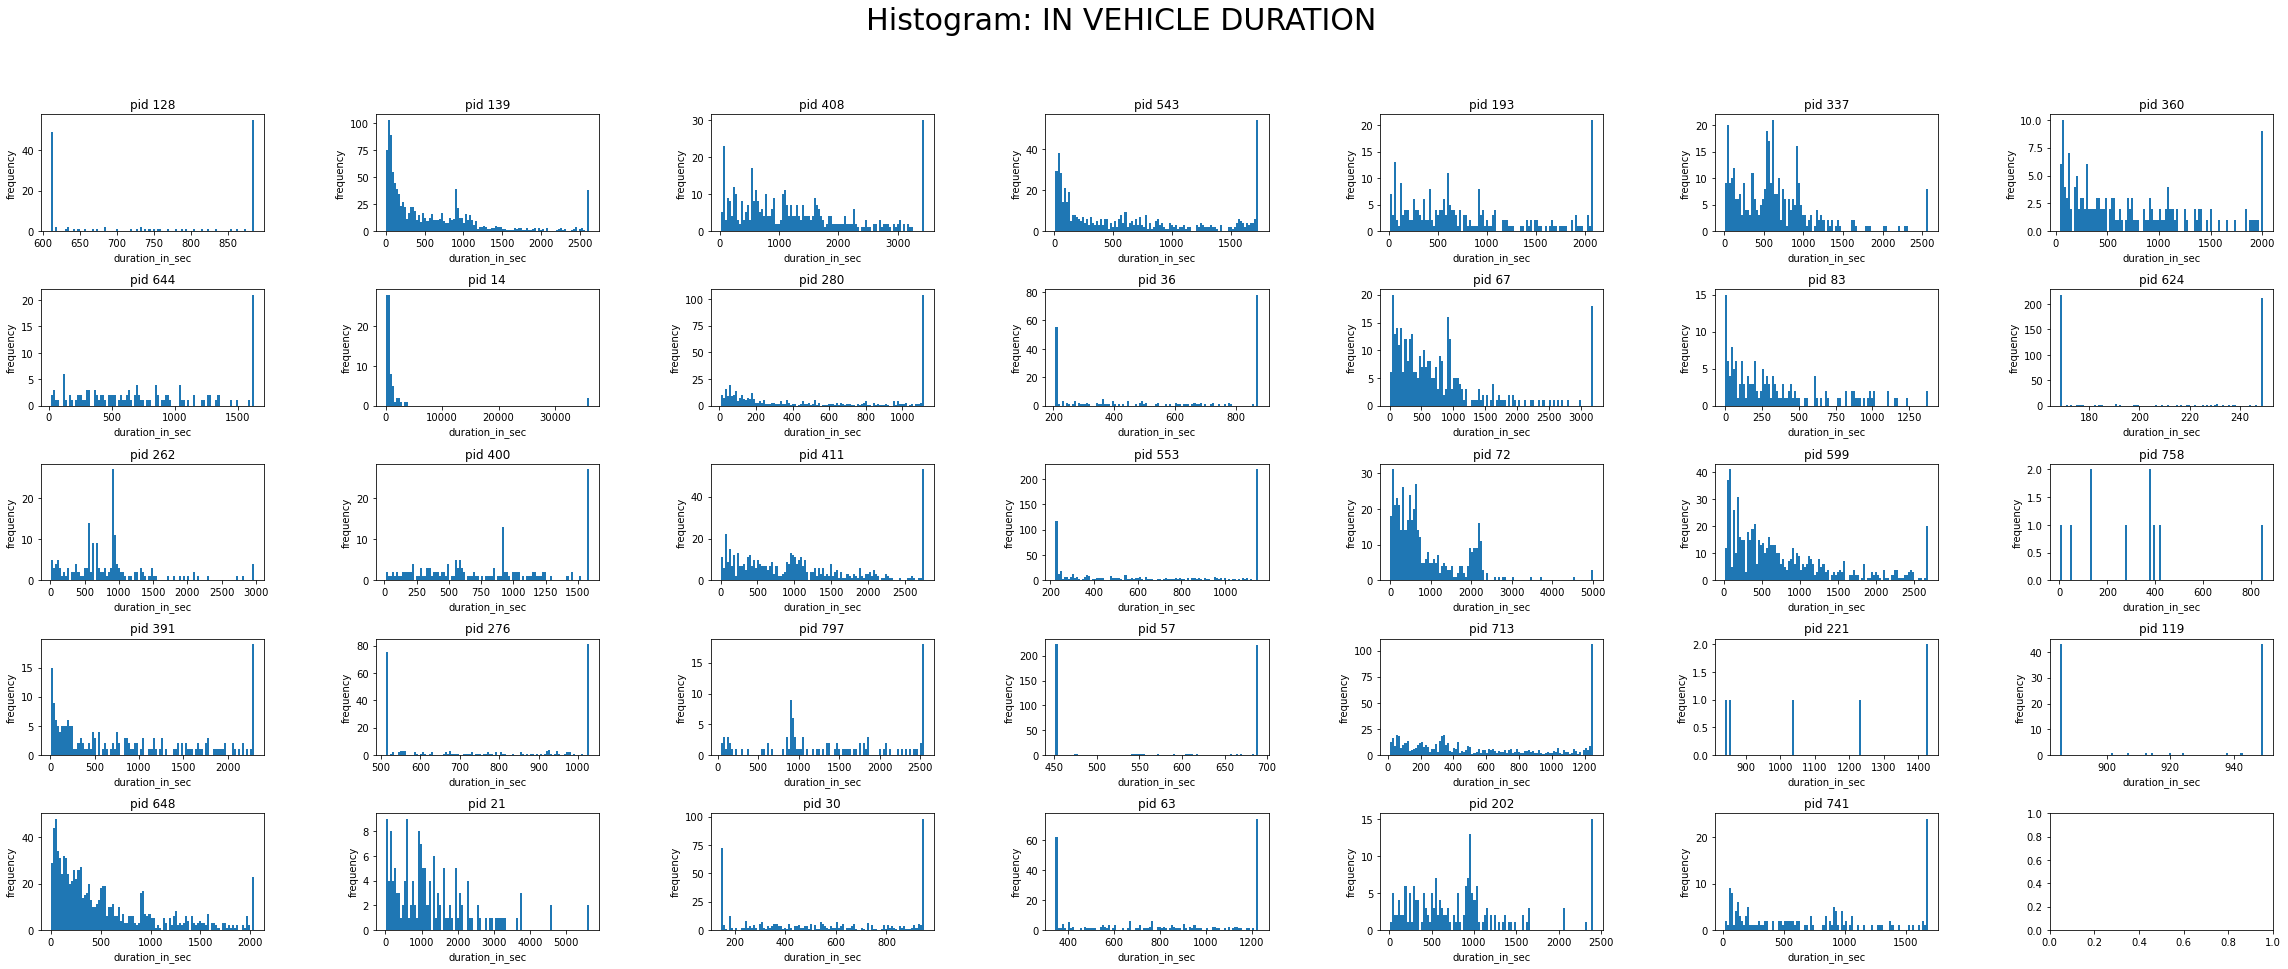

In [167]:
f, ax = plt.subplots(5, 7)
f.set_size_inches((40, 15))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.suptitle('Histogram: IN VEHICLE DURATION', fontsize = 30)

vehicle_pids = list(set(aos_vehicle_mad.index.get_level_values('pid')))

for i in range(len(vehicle_pids)):
    df_pid = aos_vehicle_mad.loc[vehicle_pids[i]]['duration_in_sec']

    if i < 5:
        j = 0
        ax[i, j].hist(df_pid, bins=100)
        ax[i, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i, j].set_xlabel('duration_in_sec')
        ax[i, j].set_ylabel('frequency')
        
    elif (i>=5) & (i<10):
        j = 1    
        ax[i-5, j].hist(df_pid, bins=100)
        ax[i-5, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-5, j].set_xlabel('duration_in_sec')
        ax[i-5, j].set_ylabel('frequency')
        
    elif (i>=10) & (i<15):
        j = 2    
        ax[i-10, j].hist(df_pid, bins=100)
        ax[i-10, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-10, j].set_xlabel('duration_in_sec')
        ax[i-10, j].set_ylabel('frequency')

    elif (i>=15) & (i<20):
        j = 3    
        ax[i-15, j].hist(df_pid, bins=100)
        ax[i-15, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-15, j].set_xlabel('duration_in_sec')
        ax[i-15, j].set_ylabel('frequency')

    elif (i>=20) & (i<25):
        j = 4    
        ax[i-20, j].hist(df_pid, bins=100)
        ax[i-20, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-20, j].set_xlabel('duration_in_sec')
        ax[i-20, j].set_ylabel('frequency')

    elif (i>=25) & (i<30):
        j = 5    
        ax[i-25, j].hist(df_pid, bins=100)
        ax[i-25, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-25, j].set_xlabel('duration_in_sec')
        ax[i-25, j].set_ylabel('frequency')

    elif (i>=30) & (i<35):
        j = 6    
        ax[i-30, j].hist(df_pid, bins=100)
        ax[i-30, j].set_title('pid {}'.format(vehicle_pids[i]))
        ax[i-30, j].set_xlabel('duration_in_sec')
        ax[i-30, j].set_ylabel('frequency')
    
    else: pass

plt.show()

#### On Bicycle

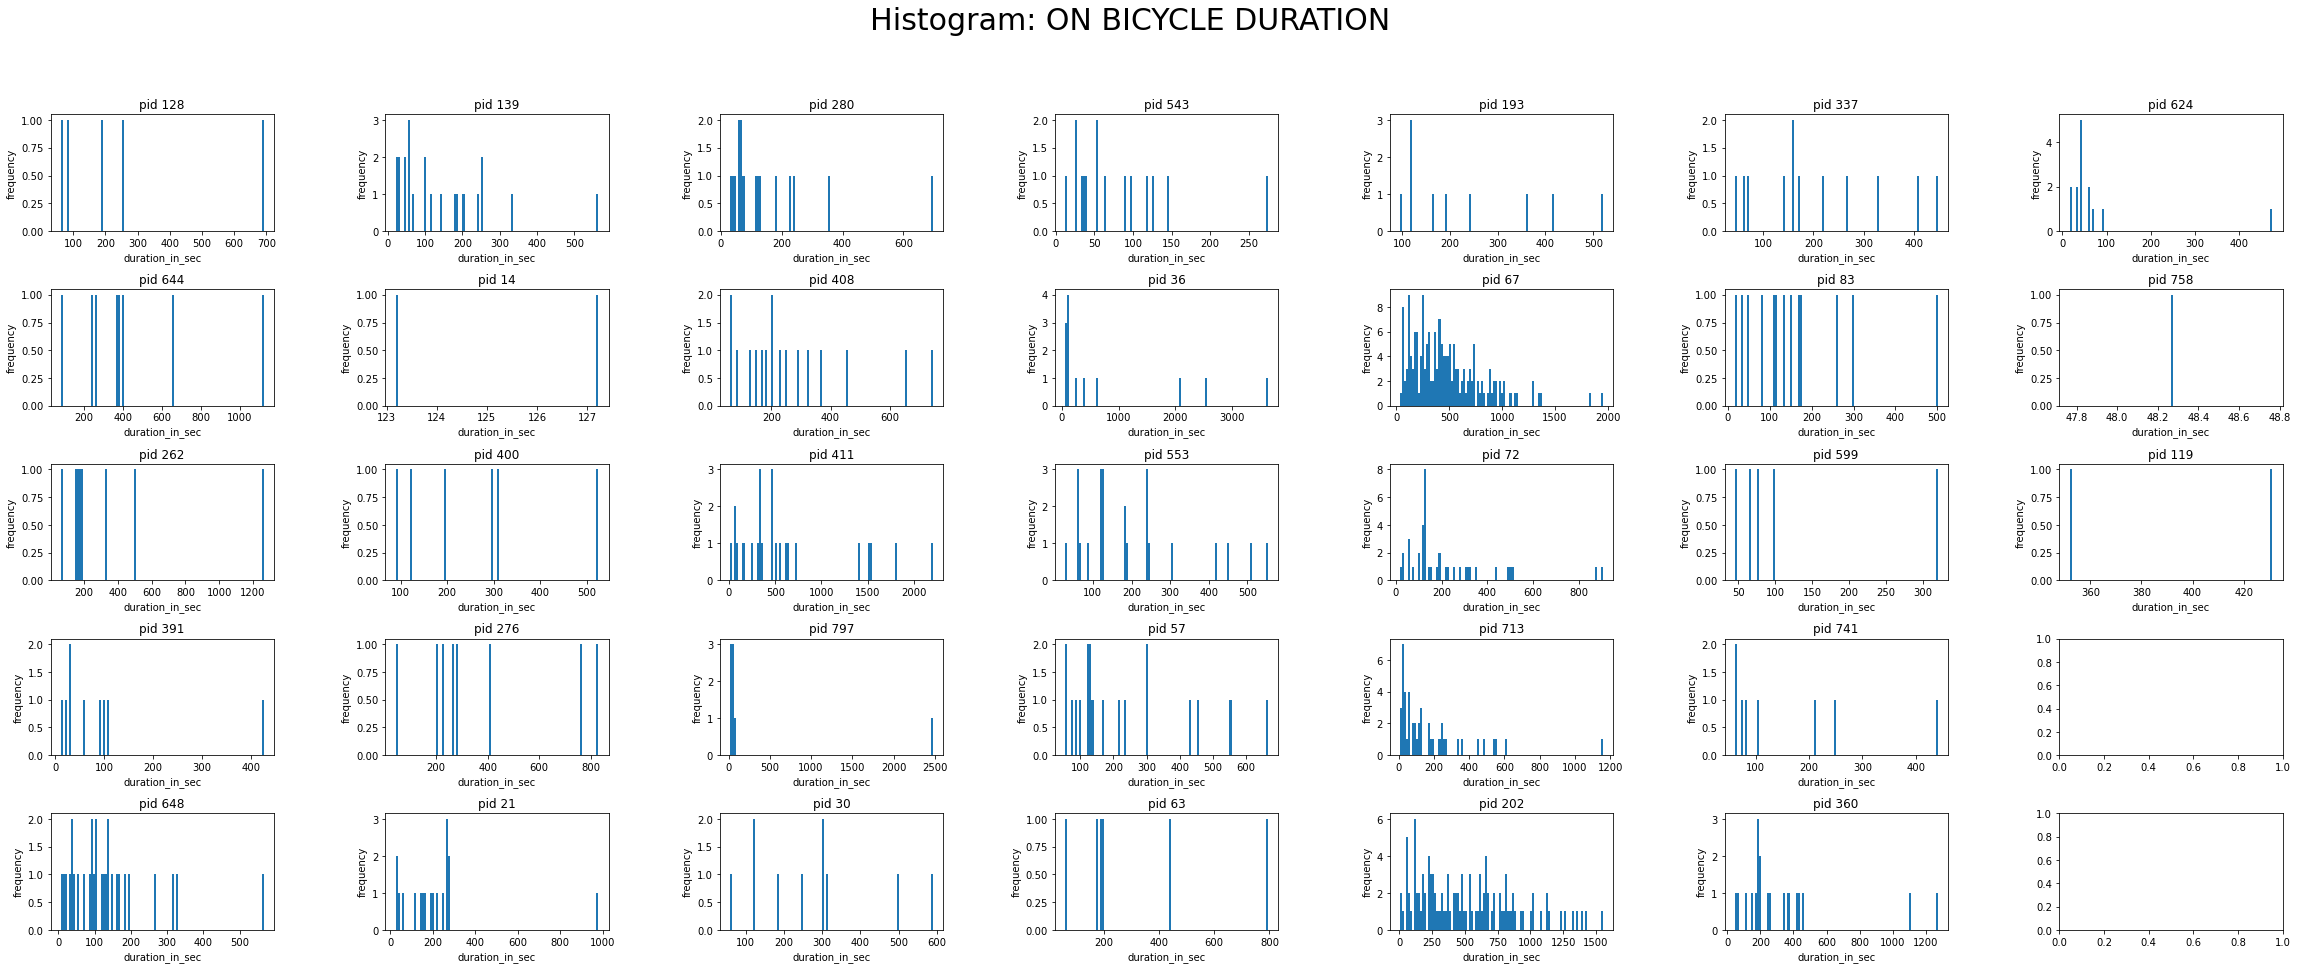

In [29]:
f, ax = plt.subplots(5, 7)
f.set_size_inches((40, 15))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.suptitle('Histogram: ON BICYCLE DURATION', fontsize = 30)

bike_pids = list(set(aos_bike.index.get_level_values('pid')))

for i in range(len(bike_pids)):
    df_pid = aos_bike.loc[bike_pids[i]]['duration_in_sec']

    if i < 5:
        j = 0
        ax[i, j].hist(df_pid, bins=100)
        ax[i, j].set_title('pid {}'.format(bike_pids[i]))
        ax[i, j].set_xlabel('duration_in_sec')
        ax[i, j].set_ylabel('frequency')
        
    elif (i>=5) & (i<10):
        j = 1    
        ax[i-5, j].hist(df_pid, bins=100)
        ax[i-5, j].set_title('pid {}'.format(bike_pids[i]))
        ax[i-5, j].set_xlabel('duration_in_sec')
        ax[i-5, j].set_ylabel('frequency')
        
    elif (i>=10) & (i<15):
        j = 2    
        ax[i-10, j].hist(df_pid, bins=100)
        ax[i-10, j].set_title('pid {}'.format(bike_pids[i]))
        ax[i-10, j].set_xlabel('duration_in_sec')
        ax[i-10, j].set_ylabel('frequency')

    elif (i>=15) & (i<20):
        j = 3    
        ax[i-15, j].hist(df_pid, bins=100)
        ax[i-15, j].set_title('pid {}'.format(bike_pids[i]))
        ax[i-15, j].set_xlabel('duration_in_sec')
        ax[i-15, j].set_ylabel('frequency')

    elif (i>=20) & (i<25):
        j = 4    
        ax[i-20, j].hist(df_pid, bins=100)
        ax[i-20, j].set_title('pid {}'.format(bike_pids[i]))
        ax[i-20, j].set_xlabel('duration_in_sec')
        ax[i-20, j].set_ylabel('frequency')

    elif (i>=25) & (i<30):
        j = 5    
        ax[i-25, j].hist(df_pid, bins=100)
        ax[i-25, j].set_title('pid {}'.format(bike_pids[i]))
        ax[i-25, j].set_xlabel('duration_in_sec')
        ax[i-25, j].set_ylabel('frequency')

    elif (i>=30) & (i<35):
        j = 6    
        ax[i-30, j].hist(df_pid, bins=100)
        ax[i-30, j].set_title('pid {}'.format(bike_pids[i]))
        ax[i-30, j].set_xlabel('duration_in_sec')
        ax[i-30, j].set_ylabel('frequency')
    
    else: pass

plt.show()

#### WALK

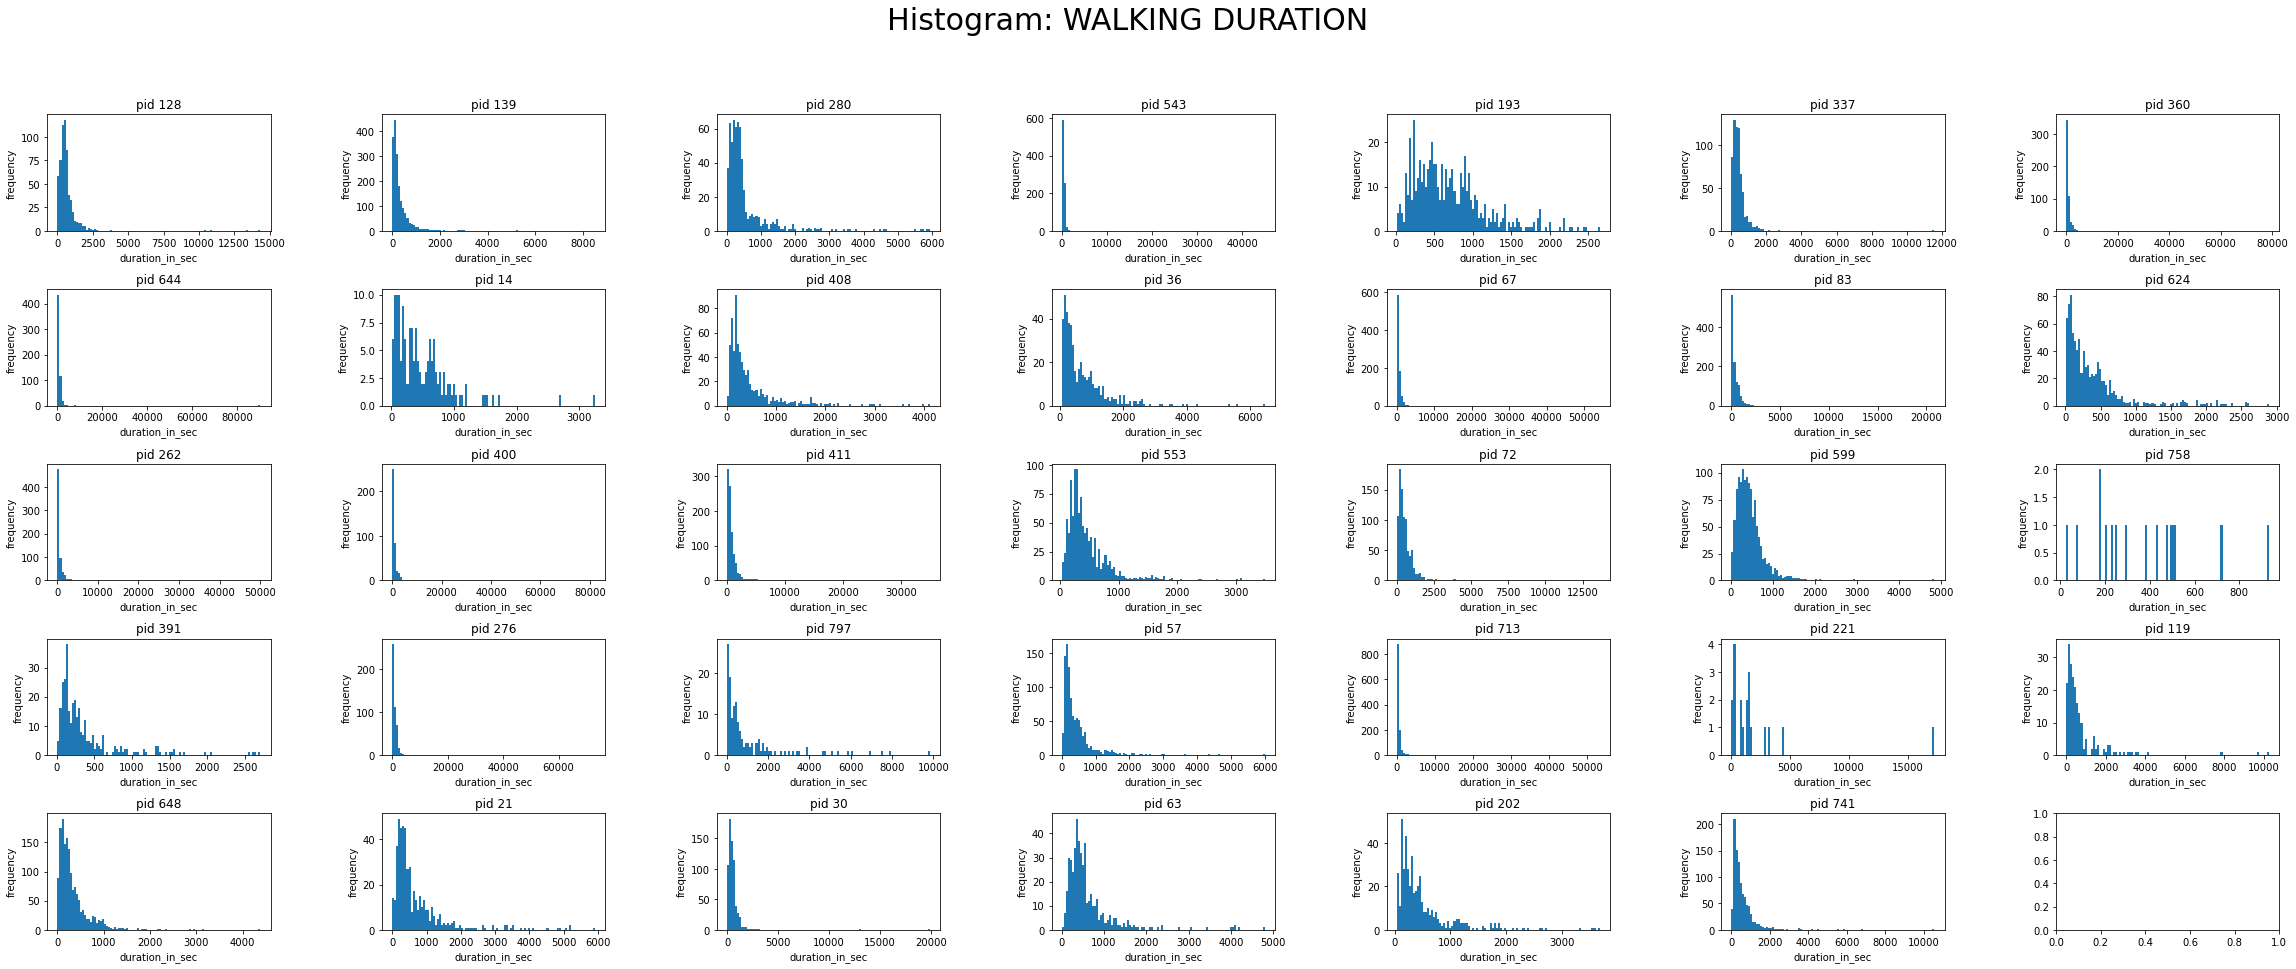

In [30]:
f, ax = plt.subplots(5, 7)
f.set_size_inches((40, 15))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.suptitle('Histogram: WALKING DURATION', fontsize = 30)

walk_pids = list(set(aos_walk.index.get_level_values('pid')))

for i in range(len(walk_pids)):
    df_pid = aos_walk.loc[walk_pids[i]]['duration_in_sec']

    if i < 5:
        j = 0
        ax[i, j].hist(df_pid, bins=100)
        ax[i, j].set_title('pid {}'.format(walk_pids[i]))
        ax[i, j].set_xlabel('duration_in_sec')
        ax[i, j].set_ylabel('frequency')
        
    elif (i>=5) & (i<10):
        j = 1    
        ax[i-5, j].hist(df_pid, bins=100)
        ax[i-5, j].set_title('pid {}'.format(walk_pids[i]))
        ax[i-5, j].set_xlabel('duration_in_sec')
        ax[i-5, j].set_ylabel('frequency')
        
    elif (i>=10) & (i<15):
        j = 2    
        ax[i-10, j].hist(df_pid, bins=100)
        ax[i-10, j].set_title('pid {}'.format(walk_pids[i]))
        ax[i-10, j].set_xlabel('duration_in_sec')
        ax[i-10, j].set_ylabel('frequency')

    elif (i>=15) & (i<20):
        j = 3    
        ax[i-15, j].hist(df_pid, bins=100)
        ax[i-15, j].set_title('pid {}'.format(walk_pids[i]))
        ax[i-15, j].set_xlabel('duration_in_sec')
        ax[i-15, j].set_ylabel('frequency')

    elif (i>=20) & (i<25):
        j = 4    
        ax[i-20, j].hist(df_pid, bins=100)
        ax[i-20, j].set_title('pid {}'.format(walk_pids[i]))
        ax[i-20, j].set_xlabel('duration_in_sec')
        ax[i-20, j].set_ylabel('frequency')

    elif (i>=25) & (i<30):
        j = 5    
        ax[i-25, j].hist(df_pid, bins=100)
        ax[i-25, j].set_title('pid {}'.format(walk_pids[i]))
        ax[i-25, j].set_xlabel('duration_in_sec')
        ax[i-25, j].set_ylabel('frequency')

    elif (i>=30) & (i<35):
        j = 6    
        ax[i-30, j].hist(df_pid, bins=100)
        ax[i-30, j].set_title('pid {}'.format(walk_pids[i]))
        ax[i-30, j].set_xlabel('duration_in_sec')
        ax[i-30, j].set_ylabel('frequency')
    
    else: pass

plt.show()

#### STILL

#### RUN

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Histogram of Running Duration')
plt.tick_params(labelsize = 15)
plt.xlabel('Duration_in_sec', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
plt.hist(aos_run['duration_in_sec'], bins = 500)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Histogram of Bike Riding Duration')
plt.tick_params(labelsize = 15)
plt.xlabel('Duration_in_sec', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
plt.hist(aos_bike['duration_in_sec'], bins = 500)
plt.show()

In [169]:
# Outlier Removal Methods: upper bound & lower bound

def MAD(df):
    df_removed = pd.DataFrame()
    for pid in tqdm(list(set(df.index.get_level_values('pid')))):
        data = df.loc[pid]['duration_in_sec']
        median = np.median(data, axis=0)
        diff_list = list()
        for x in data:
            diff = np.abs(x-median)
            diff_list.append(diff)
        mad = np.median(diff)
        ub = median + 3*mad
        lb = median - 3*mad
     #   if ub > 36000:
     #       ub = 36000
        data = data.apply(lambda x: lb if x<lb else x)
        data = data.apply(lambda x: ub if x>ub else x)
        data = pd.DataFrame(data)
        data['pid'] = pid
        data['timestamp'] = data.index
        df_removed = pd.concat([df_removed, data])
        
    df_removed.set_index(['pid','timestamp'], inplace=True)
    df_removed.columns = ['duration_in_sec']    
    #df['duration_in_sec'] = df_removed    

    return df_removed

def IQR(df):
    df_removed = pd.DataFrame()
    for pid in tqdm(list(set(df.index.get_level_values('pid')))):
        data = df.loc[pid]['duration_in_sec']
        
        Q_1 = data.describe()['25%']
        Q_3 = data.describe()['75%']
        IQR = Q_3 - Q_1
        ub = Q_3 + 1.5*IQR
        lb = Q_1 - 1.5*IQR
      #  if ub > 36000:
      #      ub = 36000
        
        data = data.apply(lambda x: lb if x<lb else x)
        data = data.apply(lambda x: ub if x>ub else x)
        data = pd.DataFrame(data)
        data['pid'] = pid
        data['timestamp'] = data.index
        df_removed = pd.concat([df_removed, data])
        
    df_removed.set_index(['pid','timestamp'], inplace=True)
    df_removed.columns = ['duration_in_sec']    
    #df['duration_in_sec'] = df_removed    

    return df_removed

Why pandas apply method is slow, and how Terality accelerates it by 80x

In [170]:
aos_vehicle_mad = MAD(aos_vehicle)
aos_bike_mad = MAD(aos_bike)
aos_run_mad = MAD(aos_run)
aos_still_mad = MAD(aos_still)
aos_walk_mad = MAD(aos_walk)

act_describe_mad = pd.concat([aos_vehicle_mad.describe(),aos_bike_mad.describe(), aos_run_mad.describe(), aos_still_mad.describe(), aos_walk_mad.describe()], axis=1) 
act_describe_mad.columns = ['IN_VEHICLE', 'ON_BICYCLE', 'RUNNING', 'STILL', 'WALKING']

100%|██████████| 34/34 [00:00<00:00, 183.86it/s]


In [171]:
act_describe_mad

,IN_VEHICLE,ON_BICYCLE,RUNNING,STILL,WALKING
count,11463.000000,720.000000,729.000000,23975.000000,23470.000000
mean,726.297314,296.691426,108.866815,4348.417002,453.881732
std,1790.351255,281.941953,149.672057,10368.453552,430.518011
min,0.027000,4.408000,0.249000,0.004000,0.008000
25%,223.323000,115.572250,34.419000,301.333000,186.757000
50%,553.545000,195.367000,61.346000,1157.228000,358.354500
75%,974.088500,404.851000,126.060000,4516.921000,589.658000
max,155120.302000,2481.230000,2112.912000,209258.586000,5935.415000


In [123]:
act_mad = pd.concat([aos_vehicle_mad,aos_bike_mad, aos_run_mad, aos_still_mad, aos_walk_mad]) 


In [125]:
aos_vehicle_mad

duration_in_sec
pid timestamp                                        
128 2021-08-15 08:24:53.363000+09:00          610.704
    2021-08-15 08:24:58.567000+09:00          683.154
    2021-08-17 12:01:00.923000+09:00          616.690
    2021-08-21 13:10:43.776000+09:00          719.600
    2021-08-23 10:28:56.949000+09:00          885.936
...                                               ...
119 2021-11-05 18:54:08.881000+09:00          949.193
    2021-11-07 16:25:56.752000+09:00          949.193
    2021-11-09 15:40:18.267000+09:00          949.193
    2021-11-12 13:23:18.341000+09:00          885.266
    2021-11-12 18:18:03.690000+09:00          906.575

[11463 rows x 1 columns]

In [124]:
act_mad

duration_in_sec
pid timestamp                                        
128 2021-08-15 08:24:53.363000+09:00          610.704
    2021-08-15 08:24:58.567000+09:00          683.154
    2021-08-17 12:01:00.923000+09:00          616.690
    2021-08-21 13:10:43.776000+09:00          719.600
    2021-08-23 10:28:56.949000+09:00          885.936
...                                               ...
119 2021-11-16 17:09:16.851000+09:00           17.910
    2021-11-16 17:09:34.761000+09:00           43.566
    2021-11-16 17:11:22.461000+09:00          691.371
    2021-11-17 12:13:23.470000+09:00          683.347
    2021-11-17 12:57:23.540000+09:00         1371.039

[60357 rows x 1 columns]

In [351]:
aos_vehicle_IQR = IQR(aos_vehicle)
aos_bike_IQR = IQR(aos_bike)
aos_run_IQR = IQR(aos_run)
aos_still_IQR = IQR(aos_still)
aos_walk_IQR = IQR(aos_walk)

act_describe_IQR = pd.concat([aos_vehicle_IQR.describe(),aos_bike_IQR.describe(), aos_run_IQR.describe(), aos_still_IQR.describe(), aos_walk_IQR.describe()], axis=1) 
act_describe_IQR.columns = ['IN_VEHICLE', 'ON_BICYCLE', 'RUNNING', 'STILL', 'WALKING']

100%|██████████| 34/34 [00:00<00:00, 139.92it/s]


In [130]:
act_describe

,IN_VEHICLE,ON_BICYCLE,RUNNING,STILL,WALKING
count,11463.000000,720.000000,729.000000,2.397500e+04,23470.000000
mean,928.699495,342.703708,137.756665,1.041741e+04,546.008577
std,3072.910807,370.323431,238.445874,3.404027e+04,1454.617029
min,0.002000,4.408000,0.249000,4.000000e-03,0.008000
25%,191.234500,103.607750,33.741000,2.404185e+02,180.774250
50%,559.407000,227.826000,65.885000,1.424227e+03,345.124500
75%,1071.665500,462.031500,139.699000,7.485874e+03,622.773750
max,174767.147000,3628.917000,3224.310000,2.853195e+06,90353.955000


In [352]:
act_describe_IQR

,IN_VEHICLE,ON_BICYCLE,RUNNING,STILL,WALKING
count,11463.000000,720.000000,729.000000,23975.000000,23470.000000
mean,760.538103,319.397592,114.787386,5882.254805,460.702696
std,715.795787,299.017157,138.018830,10891.369921,399.251639
min,0.002000,4.408000,0.249000,0.004000,0.008000
25%,191.234500,101.971781,33.742000,240.418500,180.774250
50%,559.407000,224.005500,65.885000,1424.227000,345.124500
75%,1070.551500,449.425750,136.202000,6544.504750,622.773750
max,3907.542500,1552.192000,1271.124000,135898.329000,3524.655500


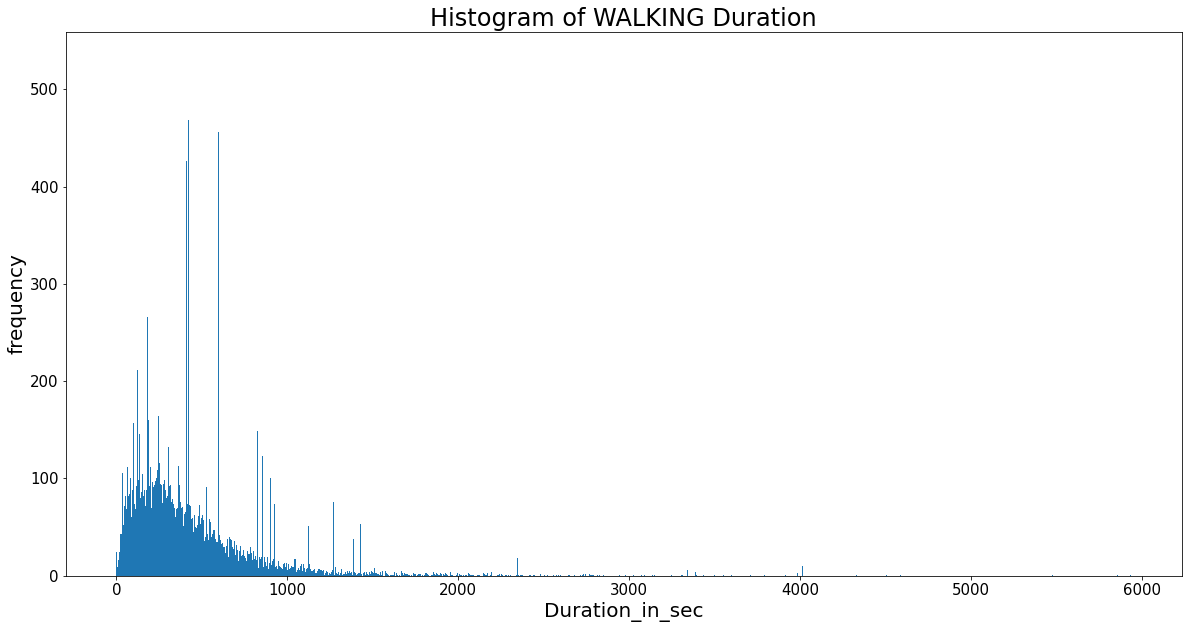

In [368]:
plt.figure(figsize=(20,10))
plt.title('Histogram of WALKING Duration')
plt.tick_params(labelsize = 15)
plt.xlabel('Duration_in_sec', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
plt.hist(aos_walk_mad['duration_in_sec'].loc[aos_walk_mad['duration_in_sec']<10000], bins = 2000)
plt.show()

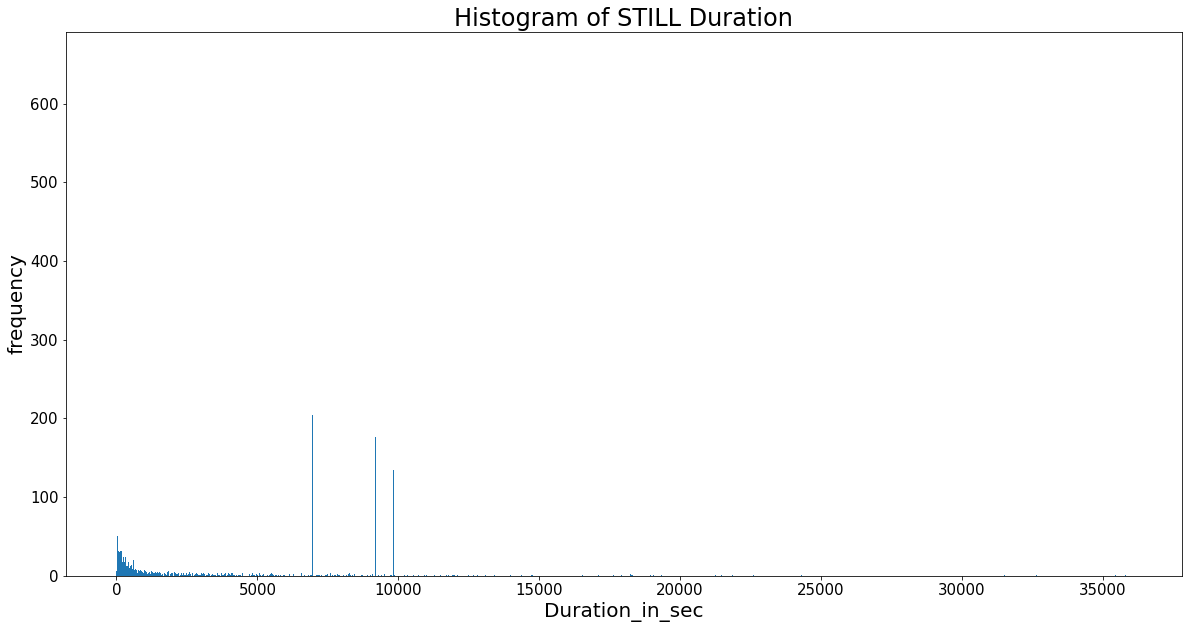

In [386]:
plt.figure(figsize=(20,10))
plt.title('Histogram of STILL Duration')
plt.tick_params(labelsize = 15)
plt.xlabel('Duration_in_sec', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
plt.hist(aos_still_mad['duration_in_sec'].loc[aos_still_mad['duration_in_sec']<36000], bins = 20000)
plt.show()

In [388]:
len(aos_still_mad['duration_in_sec'].loc[aos_still_mad['duration_in_sec']>36000])/35

14.028571428571428

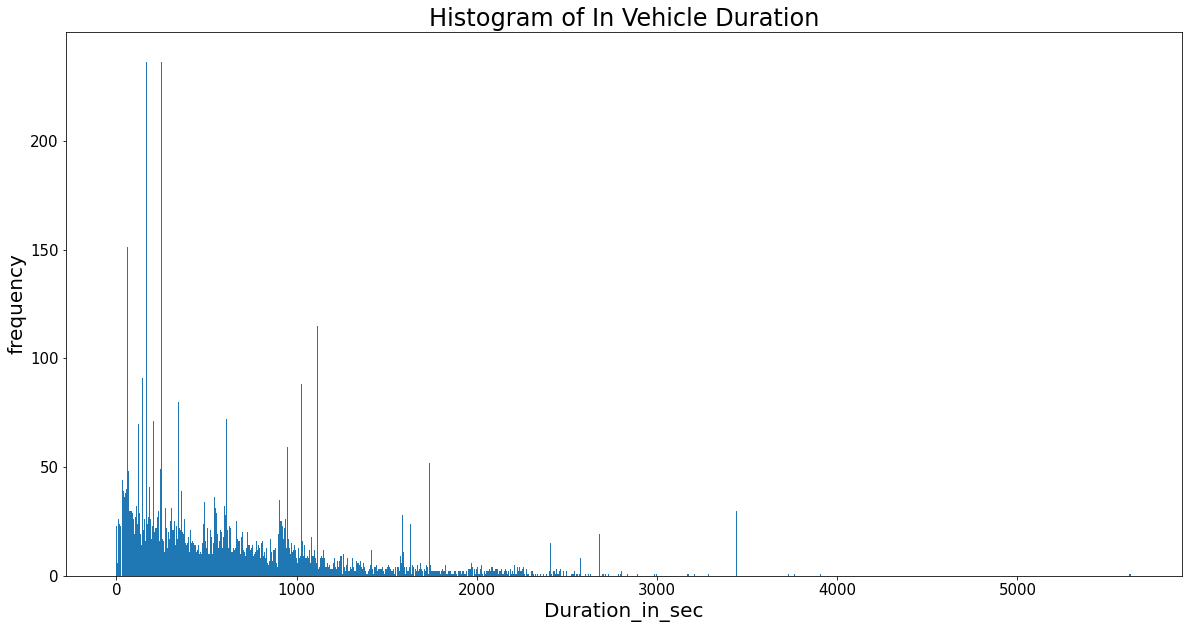

In [369]:
plt.figure(figsize=(20,10))
plt.title('Histogram of In Vehicle Duration')
plt.tick_params(labelsize = 15)
plt.xlabel('Duration_in_sec', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
plt.hist(aos_vehicle_mad['duration_in_sec'].loc[aos_vehicle_mad['duration_in_sec']<10000], bins = 2000)
plt.show()

### Feature Extraction

In [141]:
len(set(aos_act.index.get_level_values('pid'))) == len(aos_pids)

False

In [134]:
def get_activity_features(feature, survey, pids, window_size):
    _d_name = 'ACTIVITY'
    _w_name = '{}HR'.format(window_size)
    activity_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')
    
    for pid in tqdm(aos_pids):
        ema = survey.loc[pid]
        data_source = feature.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t - timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
            features = defaultdict(lambda: np.nan)

            if len(d_window) == 0:
                features = defaultdict(lambda: np.nan)
            else:    
                for cat in d_window.activity.unique():
                    key ='{}#{}#{}#dur'.format(_d_name,_w_name, cat) 
                    f = d_window[d_window.activity==cat]['duration_in_sec'].sum()
                    features[key]= f
            output_table = output_table.append(features, ignore_index=True)

        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        activity_df = pd.concat([activity_df, output_table])
        activity_df.fillna(0, inplace=True)
       # activity_df.to_csv('aos_data/aos_{}_{}.csv'.format(_d_name,_w_name)) 
    
    return activity_df

In [135]:
get_activity_features(aos_act, aos_ema, aos_pids, 4)

Processing for window size = 4
-------------------------------------------


 26%|██▌       | 9/35 [00:01<00:05,  4.60it/s]


KeyError: 118

## Significant Motion

In [13]:
ios_sensors

['SCREEN_STATE',
 'SURVEY_EMA',
 'LOCATION_GPS',
 'ACTIVITY_RECOGNITION',
 'CALLS',
 'SOUND_DATA',
 'UNLOCK_STATE',
 'ANDROID_SIGNIFICANT_MOTION',
 'ANDROID_STEP_DETECTOR',
 'ANDROID_GRAVITY']

In [26]:
sensorName = 'ANDROID_SIGNIFICANT_MOTION'
cols = ['timestamp']
dtypes = {'timestamp':np.int64}

aos_sig = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols, dtypes = dtypes) 
aos_sig.insert(0,'num_motion', 1, allow_duplicates=False)

ios_sig = load_data(path = ios_path, sensorName=sensorName, pids=ios_pids, cols=cols, dtypes=dtypes) 
ios_sig.insert(0,'num_motion', 1, allow_duplicates=False)

100%|██████████| 191/191 [00:03<00:00, 50.40it/s]


In [29]:
a = aos_sig.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('aos_preprocessed/aos_SIGNIFICANT_MOTION.csv')

a = ios_sig.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('ios_preprocessed/ios_SIGNIFICANT_MOTION.csv')


In [ ]:
for pid in aos_pids:
    plt.figure(figsize=(30,1))
    plt.title('{}'.format(pid), size=20)
    plt.scatter(aos_sig.loc[pid].index, aos_sig.loc[pid].num_motion)

In [38]:
def get_sig_motion_features(feature, survey, pids, window_size):

    _d_name = 'SIGNIFICANT_MOTION'
    _w_name = '{}HR'.format(window_size)
    sig_motion_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')
    
    for pid in tqdm(pids):
        ema = survey.loc[pid]
        data_source = feature.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t - timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
            features = defaultdict(lambda: 0)

            if len(d_window) == 0:
                features = defaultdict(lambda: 0)
               
            else:
                features['{}#{}#count'.format(_d_name,_w_name)] = len(d_window)  
            output_table = output_table.append(features, ignore_index=True)

        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        sig_motion_df = pd.concat([sig_motion_df, output_table])
        sig_motion_df.fillna(0, inplace=True)

        if pids == aos_pids:
            sig_motion_df.to_csv('aos_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 
        else:
            sig_motion_df.to_csv('ios_features/ios_{}_{}.csv'.format(_d_name,_w_name)) 
    
    return sig_motion_df

In [39]:
for w in range(4, 5, 4):
    aos_sig_df = get_sig_motion_features(aos_sig, aos_ema, aos_pids, w)
    ios_sig_df = get_sig_motion_features(ios_sig, ios_ema, ios_pids, w)


Processing for window size = 4
-------------------------------------------


100%|██████████| 336/336 [01:41<00:00,  3.31it/s]


Processing for window size = 4
-------------------------------------------


100%|██████████| 191/191 [00:28<00:00,  6.79it/s]


## Step

In [40]:
sensorName = 'ANDROID_STEP_DETECTOR'
cols = ['timestamp']
dtypes = {'timestamp':np.int64}

aos_step = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols, dtypes = dtypes) 
aos_step.insert(0,'num_steps',1,allow_duplicates=True)

ios_step = load_data(path = ios_path, sensorName=sensorName, pids=ios_pids, cols=cols, dtypes = dtypes) 
ios_step.insert(0,'num_steps',1,allow_duplicates=True)

100%|██████████| 191/191 [00:05<00:00, 34.25it/s]


In [41]:
a = aos_step.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('aos_preprocessed/aos_STEP.csv')

a = ios_step.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('ios_preprocessed/ios_STEP.csv')

In [43]:
def get_step_features(feature, survey, pids, window_size):
    _d_name = 'STEP'
    _w_name = '{}HR'.format(window_size)
    step_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')
    
    for pid in tqdm(pids):
        ema = survey.loc[pid]
        data_source = feature.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t - timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
            features = defaultdict(lambda: np.nan)

            if len(d_window) == 0:
                features = defaultdict(lambda: np.nan)
            else:    
                features['{}#{}#count'.format(_d_name,_w_name)] = len(d_window)  
            output_table = output_table.append(features, ignore_index=True)

        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        step_df = pd.concat([step_df, output_table])
    
    step_df.fillna(0, inplace=True)
    if pids == aos_pids:
        step_df.to_csv('aos_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 
    else:
        step_df.to_csv('ios_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 

    return step_df

In [44]:
for w in range(4, 5, 4):
    get_step_features(aos_step, aos_ema, aos_pids, w)
    get_step_features(ios_step, ios_ema, ios_pids, w)

Processing for window size = 4
-------------------------------------------


100%|██████████| 336/336 [02:12<00:00,  2.53it/s]


Processing for window size = 4
-------------------------------------------


100%|██████████| 191/191 [00:15<00:00, 12.67it/s]


## Location
10-LOCATION_GPS: timestamp - latitude - longitude - speed - accuracy - altitude
* Timestamp - unix epoch time
* Latitude & longitude & altitude values of the location
* Speed - speed value (it is always 0.0)
* Accuracy - gps accuracy 
* Note: There is a slight difference between Android and iOS for this data source. The iOS misses accuracy. So for iOS, the format is: timestamp - latitude - longitude - speed - altitude

TBD: additional pre-processing 
* KalmanFilter 
* walking 4km/h  running 8km/h 
* outlier detection

In [46]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

cols = ['timestamp', 'latitude', 'longitude', 'speed', 'accuracy',  'altitude']
sensorName = 'LOCATION_GPS'
dtypes={'latitude':np.float64, 'longitude':np.float64, 'speed':np.float64, 'accuracy':np.float64, 'altitude':np.float64}                             


aos_location = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols, dtypes = dtypes) 

# Remove data points with accuracy less than 200m
aos_location = aos_location.loc[aos_location['accuracy']<200]
aos_location = aos_location.drop(['speed', 'accuracy', 'altitude'], axis=1)

ios_location = load_data(path = ios_path, sensorName=sensorName, pids=ios_pids, cols=cols, dtypes = dtypes) 

# Remove data points with accuracy less than 200m
ios_location = ios_location.loc[ios_location['accuracy']<200]
ios_location = ios_location.drop(['speed', 'accuracy', 'altitude'], axis=1)

100%|██████████| 191/191 [00:12<00:00, 15.90it/s]


### POI Clustering

In [105]:
from poi import PoiCluster

DISTANCE_MAX_IN_METRE = 200 #@param {type:"slider", min:25, max:500, step:25}
REGION_SIZE_IN_METRE = 300 #@param {type:"slider", min:25, max:500, step:25}
MAXIMUM_TIME_IN_MIN = 60 #@param {type:"slider", min:60, max:120, step:20}
MINIMUM_TIME_IN_MIN = 5 #@

cluster = PoiCluster(
    d_max=DISTANCE_MAX_IN_METRE,
    r_max=REGION_SIZE_IN_METRE,
    t_max=MAXIMUM_TIME_IN_MIN * 60 * 1000,
    t_min=MINIMUM_TIME_IN_MIN * 60 * 1000
)

aos_pids_nohome = list()
aos_gps_list = list()
for pid in tqdm(aos_pids):
    pid_loc = aos_location.loc[pid]
    pid_loc = pid_loc.reset_index()
    pid_loc['timestamp'] = pid_loc['timestamp'].apply(lambda x: x.value)/1000000 
    timestamps = pid_loc.loc[:, 'timestamp'].values
    loc_degrees = pid_loc.loc[:, ['latitude', 'longitude']].to_numpy()
    loc_radians = np.radians(loc_degrees) 

    cluster.fit(loc_radians, timestamps)
    labels = cluster.predict(loc_radians)

    CLUSTER_POI = pd.DataFrame(
        np.column_stack([pid_loc.to_numpy(), labels]), 
        columns=['timestamp', 'latitude', 'longitude', 'label']
    )
    CLUSTER_POI['pid'] = pid
    CLUSTER_POI['timestamps'] = pd.to_datetime(CLUSTER_POI['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    M_night = (CLUSTER_POI.timestamps.dt.hour>=22) | (CLUSTER_POI.timestamps.dt.hour<7) 
    if len(CLUSTER_POI.loc[M_night]) == 0:
        aos_pids_nohome.append(pid)
        continue
    HOME_CLUSTER_ID = CLUSTER_POI.loc[M_night]['label'].value_counts().index[0] # most frequent cluster at nioght is HOME
    HOME_CLUSTER_CENTER = CLUSTER_POI.loc[CLUSTER_POI.label==HOME_CLUSTER_ID][['latitude','longitude']].mean()
    #SIGNIFICANT_CLUSTER_ID = CLUSTER_POI[~CLUSTER_POI['label'].isin([HOME_CLUSTER_ID,-1])].value_counts().index[0]
    
    CLUSTER_POI['label'] = CLUSTER_POI['label'].replace(HOME_CLUSTER_ID, 'HOME')
    #CLUSTER_POI['label'] = CLUSTER_POI['label'].replace(SIGNIFICANT_CLUSTER_ID, 'WORK')    
    aos_gps_list.append(CLUSTER_POI)
    
aos_gps = pd.concat(aos_gps_list)
aos_gps.set_index(['pid','timestamps'], inplace=True)
aos_gps['longitude'] = aos_gps['longitude'].astype(float)
aos_gps['latitude'] = aos_gps['latitude'].astype(float)
aos_gps['timestamp'] = aos_gps['timestamp'].astype(np.int64)
aos_gps['label'] = aos_gps['label'].astype('category')


ios_pids_nohome = list()
ios_gps_list = list()
for pid in tqdm(ios_pids):
    pid_loc = ios_location.loc[pid]
    pid_loc = pid_loc.reset_index()
    pid_loc['timestamp'] = pid_loc['timestamp'].apply(lambda x: x.value)/1000000 
    timestamps = pid_loc.loc[:, 'timestamp'].values
    loc_degrees = pid_loc.loc[:, ['latitude', 'longitude']].to_numpy()
    loc_radians = np.radians(loc_degrees) 
    try:
        cluster.fit(loc_radians, timestamps)
    except ValueError:
        ios_pids_nohome.append(pid)
        continue

    labels = cluster.predict(loc_radians)

    CLUSTER_POI = pd.DataFrame(
        np.column_stack([pid_loc.to_numpy(), labels]), 
        columns=['timestamp', 'latitude', 'longitude', 'label']
    )
    CLUSTER_POI['pid'] = pid
    CLUSTER_POI['timestamps'] = pd.to_datetime(CLUSTER_POI['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    M_night = (CLUSTER_POI.timestamps.dt.hour>=22) | (CLUSTER_POI.timestamps.dt.hour<7) 
    if len(CLUSTER_POI.loc[M_night]) == 0:
        ios_pids_nohome.append(pid)
        continue
    HOME_CLUSTER_ID = CLUSTER_POI.loc[M_night]['label'].value_counts().index[0] # most frequent cluster at nioght is HOME
    HOME_CLUSTER_CENTER = CLUSTER_POI.loc[CLUSTER_POI.label==HOME_CLUSTER_ID][['latitude','longitude']].mean()
    #SIGNIFICANT_CLUSTER_ID = CLUSTER_POI[~CLUSTER_POI['label'].isin([HOME_CLUSTER_ID,-1])].value_counts().index[0]
    
    CLUSTER_POI['label'] = CLUSTER_POI['label'].replace(HOME_CLUSTER_ID, 'HOME')
    #CLUSTER_POI['label'] = CLUSTER_POI['label'].replace(SIGNIFICANT_CLUSTER_ID, 'WORK')    
    ios_gps_list.append(CLUSTER_POI)
    
ios_gps = pd.concat(ios_gps_list)
ios_gps.set_index(['pid','timestamps'], inplace=True)
ios_gps['longitude'] = ios_gps['longitude'].astype(float)
ios_gps['latitude'] = ios_gps['latitude'].astype(float)
ios_gps['timestamp'] = ios_gps['timestamp'].astype(np.int64)
ios_gps['label'] = ios_gps['label'].astype('category')


100%|██████████| 191/191 [00:18<00:00, 10.51it/s]


In [107]:
print(aos_pids_nohome,ios_pids_nohome) 

[162] [115, 240, 312, 333, 376, 530, 575, 605]


In [125]:
a = aos_gps.copy()
a = a.reset_index()
a.drop('timestamps', axis=1, inplace=True)
a.to_csv('aos_preprocessed/aos_LOCATION.csv')

a = ios_gps.copy()
a = a.reset_index()
a.drop('timestamps', axis=1, inplace=True)
a.to_csv('ios_preprocessed/ios_LOCATION.csv')

In [ ]:
aos_gps.loc[128].label.value_counts()[:10] # stay in home too often....


In [ ]:
'''work_pid = list()
nonwork_pid = list()
for pid in aos_pids:
    std_lat = aos_gps.loc[pid].loc[aos_gps.loc[pid]['label'] == 'WORK'].latitude.astype(float).describe()['std']
    if std_lat > 0.001:
        nonwork_pid.append(pid)
    else:
        work_pid.append(pid)'''

In [ ]:
fig = go.Figure()
MAPBOX_ACCESS_TOKEN = 'pk.eyJ1Ijoia2VsdHBvd2VyMCIsImEiOiJjazFiZ3cxZzUwMjVhM2hyMTBvcHYwcHlxIn0.mZTYvOHmJeqBANdFC1HFkw' 


for label in aos_gps.loc[14].loc[:, 'label'].unique():
  sub = aos_gps.loc[14].loc[lambda x: x['label'] == label, :]
  fig.add_trace(
      go.Scattermapbox(
          lat=sub.loc[:, 'latitude'], 
          lon=sub.loc[:, 'longitude'],
          name=label,
          hovertext=label,
          opacity=0.2 if label == 'NONE' else 1.0,
         
      )
  )

fig.update_layout(
    autosize=True,
    mapbox=go.layout.Mapbox(
        accesstoken=MAPBOX_ACCESS_TOKEN,
        center=go.layout.mapbox.Center(
            lat=float(aos_gps.loc[14]['latitude'][0]),
            lon=float(aos_gps.loc[14]['longitude'][0])
        ),
        zoom=10
    )
)
fig.show()

In [304]:
# Filter out 'stop places': remove data while on the move
none_idx = aos_gps[aos_gps.label=='NONE'].index
aos_gps = aos_gps.drop(none_idx)

In [ ]:
aos_pids[:10]

In [ ]:
aos_gps.loc[128].label.value_counts()[0]

In [ ]:
home_pids = list()
for pid in aos_pids:
    h = aos_gps.loc[pid].label.value_counts()[0]
    l = len(aos_gps.loc[pid])
    if h/l > 0.7:
        home_pids.append(pid)

In [ ]:
len(home_pids)

In [ ]:
aos_gps.loc[14].label.value_counts() # stay in home too often....

### Feature Engineering

In [137]:
warnings.filterwarnings(action='ignore')

def get_location_features(feature, survey, pids, window_size):

    _d_name = 'LOCATION'
    _w_name = '{}HR'.format(window_size)
    cluster_list = list()

    gps_df = pd.DataFrame()

    for pid in tqdm(pids):
        ema = survey.loc[pid]
        data_source = feature.loc[pid]

        lon = data_source.loc[data_source.label=='HOME'].longitude.mean()
        lat = data_source.loc[data_source.label=='HOME'].latitude.mean()
        home_pl = (lat, lon)

        # for calculating number of different significant places visited
        sig = list(data_source.label.value_counts()[:10].index)

        output_table = pd.DataFrame()

        for t in ema.index:
            start = t - timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
        
            if len(d_window) == 0:
                features = defaultdict(lambda: np.nan)

            elif len(set(d_window['label'])) == 1:
                features = defaultdict(lambda: np.nan)
                features['{}#{}#total_distance'.format(_d_name,_w_name)] = 0   
                features['{}#{}#max_distance'.format(_d_name,_w_name)] = 0
                features['{}#{}#max_dist_home'.format(_d_name,_w_name)] = 0
                features['{}#{}#radius_gyration'.format(_d_name, _w_name)] = 0
                features['{}#{}#std_displacement'.format(_d_name, _w_name)] = 0
                features['{}#{}#num_places'.format(_d_name, _w_name)] = 1
                features['{}#{}#num_significant_places'.format(_d_name, _w_name)] = 1

            else:
                UNIQUE_CLUSTERS = list(d_window['label'].unique())
                # for calculating distance between each visited place and home
                dist_home_list = list()
                for cluster in UNIQUE_CLUSTERS:
                    lon = d_window.loc[d_window.label==cluster].longitude.mean()
                    lat = d_window.loc[d_window.label==cluster].latitude.mean()
                    cluster_pl = (lat, lon)  
                    dist_home = haversine(home_pl, cluster_pl , unit = 'm') # distance from home
                    dist_home_list.append(dist_home)
            
                lon_cent = d_window.longitude.mean()
                lat_cent = d_window.latitude.mean()
                cent_pl = (lat_cent, lon_cent) 
                cent_idx_list = [0]
                dist_two_list = list()
                dur_list = list()
                dist_cent_list = list()
                

                for i in range(len(d_window)-1):
                    cent_idx = 0
                    
                    if d_window['label'].iloc[i] != d_window['label'].iloc[i+1]:
                        if i == 0:
                            df = pd.DataFrame(d_window.iloc[0:1])
                        elif i == len(d_window)-2:
                            df = pd.DataFrame(d_window.iloc[-1:])
                        else:
                            df = d_window.iloc[cent_idx_list[cent_idx]+1:i+1]

                        # for calculating distance between different locations
                        fst_pl = (d_window.iloc[i]['latitude'], d_window.iloc[i]['longitude'])
                        sec_pl = (d_window.iloc[i+1]['latitude'], d_window.iloc[i+1]['longitude'])
                        dist_two = haversine(fst_pl, sec_pl , unit = 'm')
                        dist_two_list.append(dist_two)

                        # for calculating distance between each visited place and centroid
                    #  id = df['label'].iloc[i]
                        ta = df['timestamp'].iloc[0]
                        td = df['timestamp'].iloc[-1]
                        dur = td-ta
                        dist_cent = haversine(fst_pl, cent_pl , unit = 'm') # distance from centroid
                        val = dur*(dist_cent**2)

                        cent_idx_list.append(i)
                        cent_idx += 1
                        dur_list.append(dur)
                        dist_cent_list.append(val)
                        
            #  id = d_window['label'].iloc[-1]
                dist_cent = haversine(sec_pl, cent_pl, unit = 'm')
                ta = d_window['timestamp'].iloc[i+1]
                td = d_window['timestamp'].iloc[-1]
                dur = td-ta
                dur_list.append(dur)
                dist_cent_list.append(dur*(dist_cent**2))

                radius_gy = np.sqrt( (1/sum(dur_list))*sum(dist_cent_list) ) # radius of gyration
                std_dist = np.std(dist_two_list) # STD of the displacements
                max_dist_home = max(dist_home_list) # max distance from home
                total_dist = sum(dist_two_list) # total distance traveled]
                max_dist = max(dist_two_list) # max distance between two locations
                num_uniq = len(UNIQUE_CLUSTERS) # number of different places visited
                num_sig = len(set(UNIQUE_CLUSTERS)&set(sig)) # number of significant places visited

                features = defaultdict(lambda: np.nan)
                features['{}#{}#total_distance'.format(_d_name,_w_name)] = total_dist       
                features['{}#{}#max_distance'.format(_d_name,_w_name)] = max_dist
                features['{}#{}#max_dist_home'.format(_d_name,_w_name)] = max_dist_home
                features['{}#{}#radius_gyration'.format(_d_name, _w_name)] = radius_gy
                features['{}#{}#std_displacement'.format(_d_name, _w_name)] = std_dist
                features['{}#{}#num_places'.format(_d_name, _w_name)] =  num_uniq
                features['{}#{}#num_significant_places'.format(_d_name, _w_name)] = num_sig 
                        
            output_table = output_table.append(features, ignore_index=True)

        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        gps_df = pd.concat([gps_df, output_table])
    
    gps_df.fillna(0, inplace=True)
    if pids == aos_lpids:
        gps_df.to_csv('aos_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 
    else:
        gps_df.to_csv('ios_features/ios_{}_{}.csv'.format(_d_name,_w_name)) 

    return gps_df

In [132]:
len(list(set(aos_pids)-{162}))

335

In [138]:
aos_lpids = list(set(aos_pids)-{162})
ios_lpids = list(set(ios_pids)-{115, 240, 312, 333, 376, 530, 575, 605}) 

In [139]:
for w in range(4, 5, 4):
    get_location_features(aos_gps, aos_ema, aos_lpids, w)
    get_location_features(ios_gps, ios_ema, ios_lpids, w)

100%|██████████| 335/335 [02:25<00:00,  2.30it/s]


### Further Analysis

In [308]:
a = get_location_features(aos_gps, aos_ema, aos_pids, 4)

In [351]:
# Missing values occur during morning time in general.
a.loc[a['LOCATION#4HR#max_distance'].isnull()][:20]

LOCATION#4HR#total_distance  \
pid timestamp                                                          
14  2021-09-16 12:09:20.220999936+09:00                          NaN   
    2021-09-25 16:46:19.928999936+09:00                          NaN   
    2021-11-09 12:00:37.523000064+09:00                          NaN   
21  2021-09-11 15:56:39.100999936+09:00                          NaN   
    2021-09-22 10:00:29.756999936+09:00                          NaN   
    2021-09-25 10:00:31.260000+09:00                             NaN   
    2021-10-10 10:00:32.497999872+09:00                          NaN   
    2021-10-13 10:08:07.457999872+09:00                          NaN   
    2021-10-22 10:00:24.807000064+09:00                          NaN   
    2021-11-15 10:02:10.231000064+09:00                          NaN   
30  2021-09-16 12:00:33.910000128+09:00                          NaN   
    2021-09-28 10:00:55.376999936+09:00                          NaN   
    2021-10-10 10:00:37.924999936+09:00                          NaN   
    2021-10-13 10:08:17.315000064+09:00                          NaN   
    2021-10-22 10:00:41.206000128+09:00                          NaN   
    2021-11-06 18:22:01.160999936+09:00                          NaN   
    2021-11-21 10:54:44.950000128+09:00                          NaN   
57  2021-08-20 10:09:43.436999936+09:00                          NaN   
    2021-08-26 11:05:22.508000+09:00                             NaN   
    2021-08-29 10:01:13.086000128+09:00                          NaN   

                                         LOCATION#4HR#max_distance  \
pid timestamp                                                        
14  2021-09-16 12:09:20.220999936+09:00                        NaN   
    2021-09-25 16:46:19.928999936+09:00                        NaN   
    2021-11-09 12:00:37.523000064+09:00                        NaN   
21  2021-09-11 15:56:39.100999936+09:00                        NaN   
    2021-09-22 10:00:29.756999936+09:00                        NaN   
    2021-09-25 10:00:31.260000+09:00                           NaN   
    2021-10-10 10:00:32.497999872+09:00                        NaN   
    2021-10-13 10:08:07.457999872+09:00                        NaN   
    2021-10-22 10:00:24.807000064+09:00                        NaN   
    2021-11-15 10:02:10.231000064+09:00                        NaN   
30  2021-09-16 12:00:33.910000128+09:00                        NaN   
    2021-09-28 10:00:55.376999936+09:00                        NaN   
    2021-10-10 10:00:37.924999936+09:00                        NaN   
    2021-10-13 10:08:17.315000064+09:00                        NaN   
    2021-10-22 10:00:41.206000128+09:00                        NaN   
    2021-11-06 18:22:01.160999936+09:00                        NaN   
    2021-11-21 10:54:44.950000128+09:00                        NaN   
57  2021-08-20 10:09:43.436999936+09:00                        NaN   
    2021-08-26 11:05:22.508000+09:00                           NaN   
    2021-08-29 10:01:13.086000128+09:00                        NaN   

                                         LOCATION#4HR#max_dist_home  \
pid timestamp                                                         
14  2021-09-16 12:09:20.220999936+09:00                         NaN   
    2021-09-25 16:46:19.928999936+09:00                         NaN   
    2021-11-09 12:00:37.523000064+09:00                         NaN   
21  2021-09-11 15:56:39.100999936+09:00                         NaN   
    2021-09-22 10:00:29.756999936+09:00                         NaN   
    2021-09-25 10:00:31.260000+09:00                            NaN   
    2021-10-10 10:00:32.497999872+09:00                         NaN   
    2021-10-13 10:08:07.457999872+09:00                         NaN   
    2021-10-22 10:00:24.807000064+09:00                         NaN   
    2021-11-15 10:02:10.231000064+09:00                         NaN   
30  2021-09-16 12:00:33.910000128+09:00                        

In [356]:
a.loc[118][a.loc[118]['LOCATION#4HR#max_distance'].isnull()]

,LOCATION#4HR#total_distance,LOCATION#4HR#max_distance,LOCATION#4HR#max_dist_home,LOCATION#4HR#radius_gyration,LOCATION#4HR#std_displacement,LOCATION#4HR#num_places,LOCATION#4HR#num_significant_places
timestamp,,,,,,,
2021-11-15 10:00:33.036999936+09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-15 14:01:15.916999936+09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


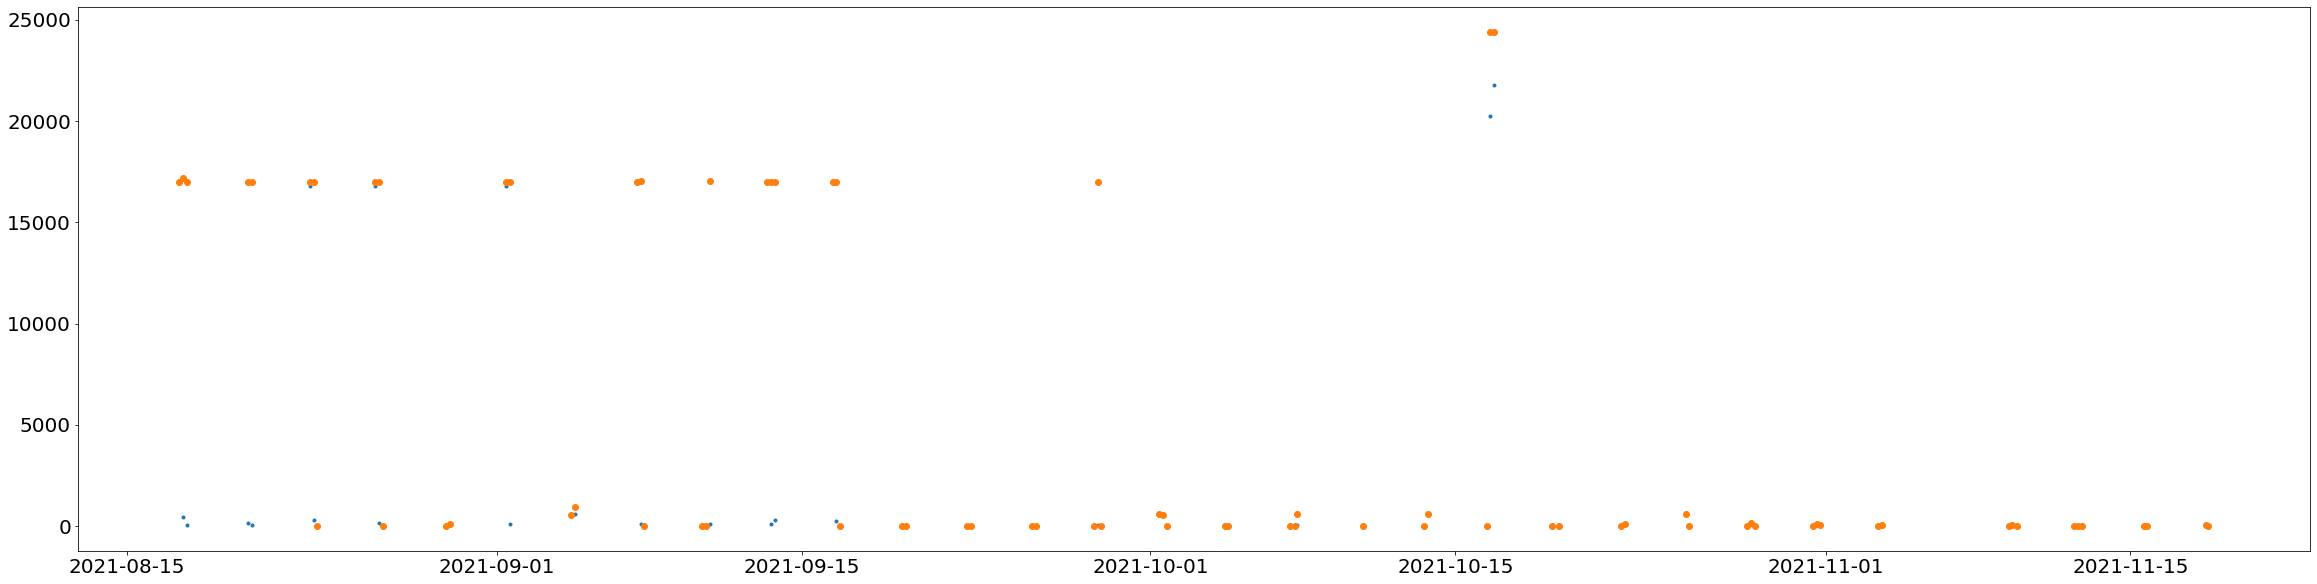

In [341]:
plt.figure(figsize=(40,10))
plt.plot(a.loc[21].index, a.loc[21]['LOCATION#4HR#max_distance'], '.')
plt.plot(a.loc[21].index, a.loc[21]['LOCATION#4HR#max_dist_home'], 'o' )
plt.yticks(size=20)
plt.xticks(size=20)
plt.show()

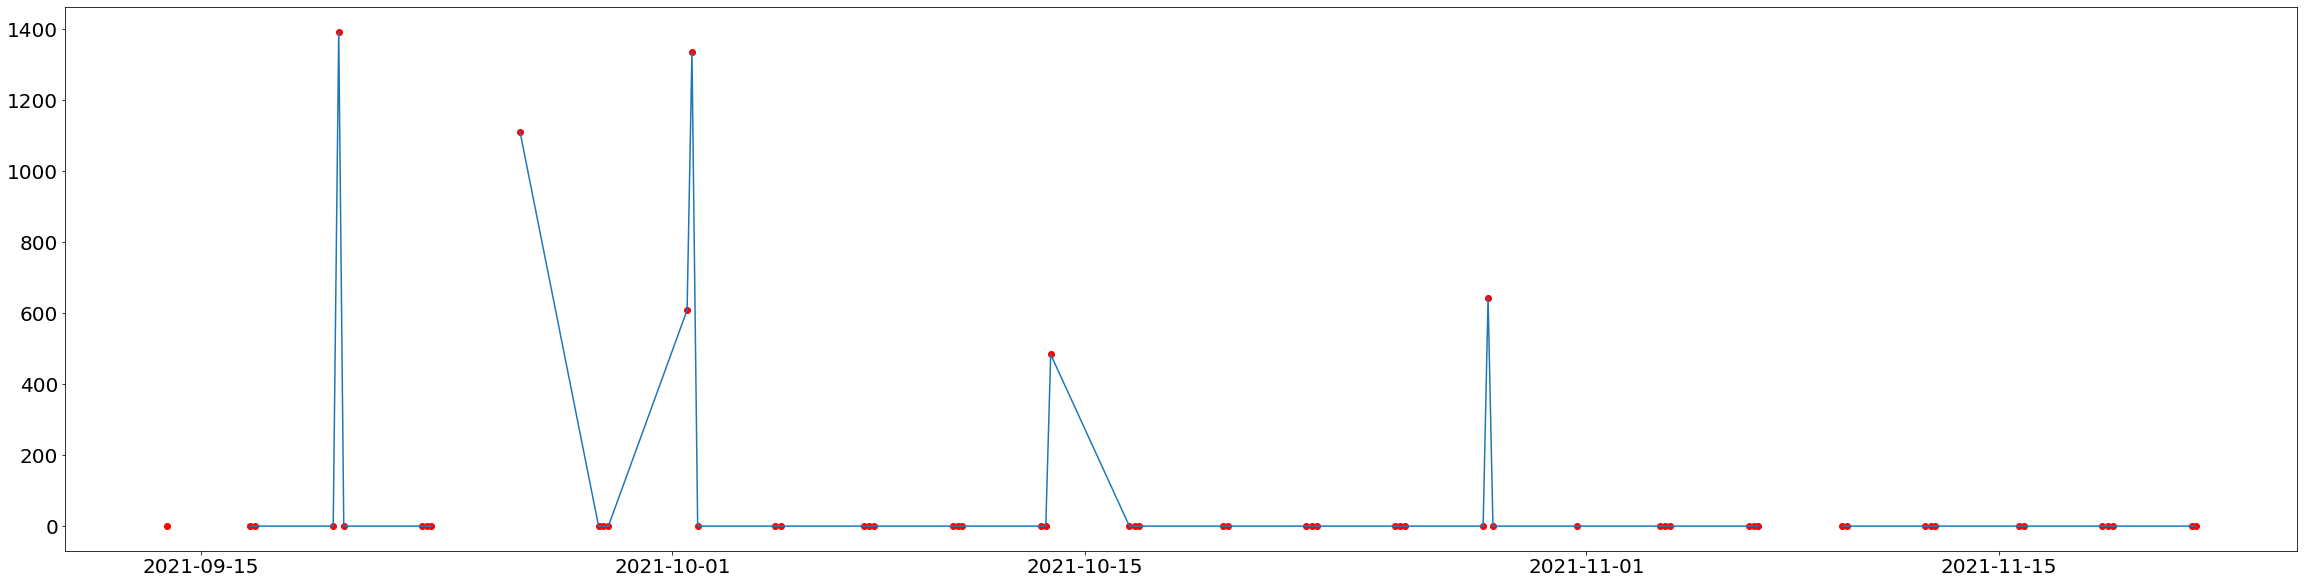

In [315]:
plt.figure(figsize=(40,10))
plt.scatter(a.loc[14].index, a.loc[14]['LOCATION#4HR#total_distance'], color='r')
plt.plot(a.loc[14].index, a.loc[14]['LOCATION#4HR#total_distance'])
plt.yticks(size=20)
plt.xticks(size=20)

plt.show()

# 4. Smartphone Usage

## Unlock State

In [12]:
# Unlock state data processing
import warnings
warnings.filterwarnings('ignore')

sensorName = 'UNLOCK_STATE'
cols=['timestamp','state']
dtypes={'pid':'int16', 'state':'category'}  # save memory (instead of using object)

# android
us_aos = load_data(path = aos_path, sensorName=sensorName, pids = aos_pids, cols=cols, dtypes = dtypes) 
us_aos.insert(us_aos.shape[1],'duration_in_sec',np.nan,allow_duplicates=True)

for pid in tqdm(aos_pids):
    us_aos.loc[pid].duration_in_sec = us_aos.loc[pid].index.to_series().diff().dt.total_seconds()
        
M_for_non_positive = us_aos['duration_in_sec']<=0
print('M_for_non_positive',M_for_non_positive.sum())

us_aos = us_aos[~M_for_non_positive]
us_aos['duration_in_sec'] = us_aos['duration_in_sec'].shift(-1).astype('float32')
us_aos.dropna(inplace=True)



# ios
us_ios = load_data(path = ios_path, sensorName=sensorName, pids = ios_pids, cols=cols,  dtypes = dtypes) 
us_ios.insert(us_ios.shape[1],'duration_in_sec',np.nan,allow_duplicates=True)

for pid in tqdm(ios_pids):
    us_ios.loc[pid].duration_in_sec = us_ios.loc[pid].index.to_series().diff().dt.total_seconds()
        
M_for_non_positive = us_ios['duration_in_sec']<=0
print('M_for_non_positive',M_for_non_positive.sum())
us_ios = us_ios[~M_for_non_positive]
us_ios['duration_in_sec'] = us_ios['duration_in_sec'].shift(-1).astype('float32')
us_ios.dropna(inplace=True)

'''
ds_shifted = us_aos[['state']].shift(-1)
M_equal = (ds_shifted['state']==us_aos['state'])&(ds_shifted.index.get_level_values(0)==us_aos.index.get_level_values(0))
print('M_equal',M_equal.sum())
aos_us = us_aos[~M_equal]

#us_aos = us_aos[us_aos.state=='LOCK'] 
aos_us['duration_in_sec'] = aos_us['duration_in_sec'].shift(-1).astype('float32')
aos_us.dropna(inplace=True)

ds_shifted = us_ios[['state']].shift(-1)
M_equal = (ds_shifted['state']==us_ios['state'])&(ds_shifted.index.get_level_values(0)==us_ios.index.get_level_values(0))
print('M_equal',M_equal.sum())
ios_us = us_ios[~M_equal]

#us_ios = us_ios[us_ios.state=='LOCK'] 
ios_us['duration_in_sec'] = ios_us['duration_in_sec'].shift(-1).astype('float32')
ios_us.dropna(inplace=True)'''

100%|██████████| 301/301 [00:06<00:00, 43.76it/s]


M_for_non_positive 0


100%|██████████| 99/99 [00:00<00:00, 204.59it/s]


M_for_non_positive 0


"\nds_shifted = us_aos[['state']].shift(-1)\nM_equal = (ds_shifted['state']==us_aos['state'])&(ds_shifted.index.get_level_values(0)==us_aos.index.get_level_values(0))\nprint('M_equal',M_equal.sum())\naos_us = us_aos[~M_equal]\n\n#us_aos = us_aos[us_aos.state=='LOCK'] \naos_us['duration_in_sec'] = aos_us['duration_in_sec'].shift(-1).astype('float32')\naos_us.dropna(inplace=True)\n\nds_shifted = us_ios[['state']].shift(-1)\nM_equal = (ds_shifted['state']==us_ios['state'])&(ds_shifted.index.get_level_values(0)==us_ios.index.get_level_values(0))\nprint('M_equal',M_equal.sum())\nios_us = us_ios[~M_equal]\n\n#us_ios = us_ios[us_ios.state=='LOCK'] \nios_us['duration_in_sec'] = ios_us['duration_in_sec'].shift(-1).astype('float32')\nios_us.dropna(inplace=True)"

#### Short Duration

In [13]:
aos_us = us_aos.copy()
aos_us = aos_us.reset_index()
aos_us['timestamp'] = aos_us['timestamp'].apply(lambda x: x.value) 
aos_us['timestamp'] = aos_us['timestamp']/1000000

ios_us = us_ios.copy()
ios_us = ios_us.reset_index()
ios_us['timestamp'] = ios_us['timestamp'].apply(lambda x: x.value) 
ios_us['timestamp'] = ios_us['timestamp']/1000000

# cut-off for unreliable data(too short duration)
aos_short = (aos_us.loc[aos_us['duration_in_sec']<=0.2])
ios_short = (ios_us.loc[ios_us['duration_in_sec']<=0.2])
aos_us = aos_us.drop(aos_short.index).reset_index(drop=True)
ios_us = ios_us.drop(ios_short.index).reset_index(drop=True)

In [14]:
print('-'*10, 'Android', '-'*10)
print(aos_us.state.value_counts())
ds_shifted = aos_us[['state']].shift(-1)
aos_equal = (ds_shifted['state']==aos_us['state'])&(ds_shifted.index.get_level_values(0)==aos_us.index.get_level_values(0))
aos_us_re = aos_us[~aos_equal]
print('M_equal',aos_equal.sum())

print('-'*10, 'iOS', '-'*10)
print(ios_us.state.value_counts())
ds_shifted = ios_us[['state']].shift(-1)
ios_equal = (ds_shifted['state']==ios_us['state'])&(ds_shifted.index.get_level_values(0)==ios_us.index.get_level_values(0))
ios_us_re = ios_us[~ios_equal]
print('M_equal',ios_equal.sum())

---------- Android ----------
UNLOCK    1102659
LOCK      1089422
Name: state, dtype: int64
M_equal 14509
---------- iOS ----------
LOCK      209701
UNLOCK    182356
Name: state, dtype: int64
M_equal 30377


In [15]:
#aos_eidx1 = aos_equal.loc[aos_equal == True].index
aos_eidx1 = list()
aos_eidx2 = list()
for i in range(1, len(aos_equal)):
    if aos_us['pid'].iloc[i-1] != aos_us['pid'].iloc[i]:
        continue
    if aos_equal.iloc[i-1] == True:    
        aos_eidx1.append(pd.DataFrame(aos_equal).iloc[i-1].name)
        aos_eidx2.append(pd.DataFrame(aos_equal).iloc[i].name)
#ios_eidx1 = ios_equal.loc[ios_equal == True].index
ios_eidx1 = list()
ios_eidx2 = list()
for i in range(1, len(ios_equal)):
    if ios_us['pid'].iloc[i-1] != ios_us['pid'].iloc[i]:
        continue
    if ios_equal.iloc[i-1] == True:
        ios_eidx1.append(pd.DataFrame(ios_equal).iloc[i-1].name)
        ios_eidx2.append(pd.DataFrame(ios_equal).iloc[i].name)

In [16]:
import random 

aos_new = list()

for idx1, idx2 in tqdm(zip(aos_eidx1, aos_eidx2)):
    pid = aos_us['pid'].iloc[idx1]
    cols = aos_us.columns
    start = int(aos_us['timestamp'].iloc[idx1]) 
    end = int(aos_us['timestamp'].iloc[idx2])
    new_ts = random.randrange(start+100, end-100)
    dur = (end - new_ts)/1000
    
    if aos_us['state'].loc[idx1] == "UNLOCK":
        df = pd.DataFrame([[pid, new_ts, 'LOCK', dur]], columns = cols)
    elif aos_us['state'].loc[idx1] == "LOCK":
        df = pd.DataFrame([[pid, new_ts, 'UNLOCK', dur]], columns = cols)
    aos_new.append(df)

aos_new_df = pd.concat(aos_new)
aos_us_new = pd.concat([aos_new_df, aos_us])

aos_us = list()
for pid in aos_pids:
    df = aos_us_new.loc[aos_us_new['pid']==pid]
    aos_us.append(df.sort_values(by='timestamp'))

aos_us = pd.concat(aos_us).reset_index(drop=True)

a = list()
for pid in tqdm(aos_pids):
    a.append(aos_us.loc[aos_us.pid==pid].timestamp.diff().shift(-1)/1000)
aos_us['duration_in_sec'] = pd.concat(a)
aos_us.dropna(inplace=True)

# ios
ios_new = list()

for idx1, idx2 in tqdm(zip(ios_eidx1, ios_eidx2)):
    pid = ios_us['pid'].iloc[idx1]
    cols = ios_us.columns
    start = int(ios_us['timestamp'].iloc[idx1]) 
    end = int(ios_us['timestamp'].iloc[idx2])
    new_ts = random.randrange(start+100, end-100)
    dur = (end - new_ts)/1000
    
    if ios_us['state'].loc[idx1] == "UNLOCK":
        df = pd.DataFrame([[pid, new_ts, 'LOCK', dur]], columns = cols)
    elif ios_us['state'].loc[idx1] == "LOCK":
        df = pd.DataFrame([[pid, new_ts, 'UNLOCK', dur]], columns = cols)
    ios_new.append(df)

ios_new_df = pd.concat(ios_new)
ios_us_new = pd.concat([ios_new_df, ios_us])

ios_us = list()
for pid in ios_pids:
    df = ios_us_new.loc[ios_us_new['pid']==pid]
    ios_us.append(df.sort_values(by='timestamp'))

ios_us = pd.concat(ios_us).reset_index(drop=True)

a = list()
for pid in tqdm(ios_pids):
    a.append(ios_us.loc[ios_us.pid==pid].timestamp.diff().shift(-1)/1000)
ios_us['duration_in_sec'] = pd.concat(a)
ios_us.dropna(inplace=True)

14364it [00:04, 3499.43it/s]
100%|██████████| 301/301 [00:01<00:00, 253.83it/s]
30326it [00:09, 3291.51it/s]
100%|██████████| 99/99 [00:00<00:00, 591.50it/s]


In [19]:
# double check
for pid in ios_pids:
    df = ios_us.loc[ios_us.pid==pid]
    dif = abs(len(df.loc[df.state=='UNLOCK'])-len(df.loc[df.state=='LOCK']))
    if dif >1:
        print(df)

for pid in aos_pids:
    df = aos_us.loc[aos_us.pid==pid]
    dif = abs(len(df.loc[df.state=='UNLOCK'])-len(df.loc[df.state=='LOCK']))
    if dif >1:
        print(df)

In [20]:
print('LOCK:', len(aos_us.loc[(aos_us.duration_in_sec>43200)&(aos_us.state == 'LOCK')]), 'UNLOCK:',len(aos_us.loc[(aos_us.duration_in_sec>43200)&(aos_us.state == 'UNLOCK')]))
print('LOCK:', len(ios_us.loc[(ios_us.duration_in_sec>43200)&(ios_us.state == 'LOCK')]), 'UNLOCK:',len(ios_us.loc[(ios_us.duration_in_sec>43200)&(ios_us.state == 'UNLOCK')]))

LOCK: 6297 UNLOCK: 4307
LOCK: 1297 UNLOCK: 3169


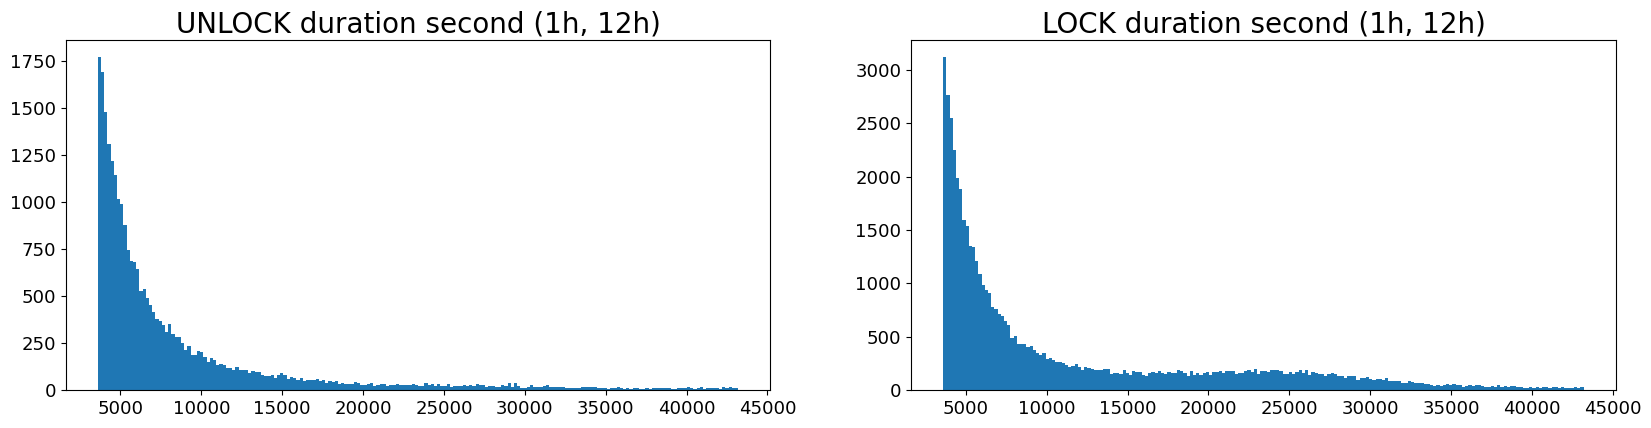

In [21]:
plt.figure(figsize = (20,10))
plt.subplot(221)
plt.gca().set_title('UNLOCK duration second (1h, 12h)', fontsize=20)
plt.hist(aos_us['duration_in_sec'].loc[(aos_us.duration_in_sec<43200)&(aos_us.duration_in_sec>3600)&(aos_us.state=='UNLOCK')], bins=200)
plt.tick_params(labelsize = 13)
plt.subplot(222)
plt.gca().set_title('LOCK duration second (1h, 12h)', fontsize=20)
plt.hist(aos_us['duration_in_sec'].loc[(aos_us.duration_in_sec<43200)&(aos_us.duration_in_sec>3600)&(aos_us.state=='LOCK')], bins=200)
plt.tick_params(labelsize = 13)

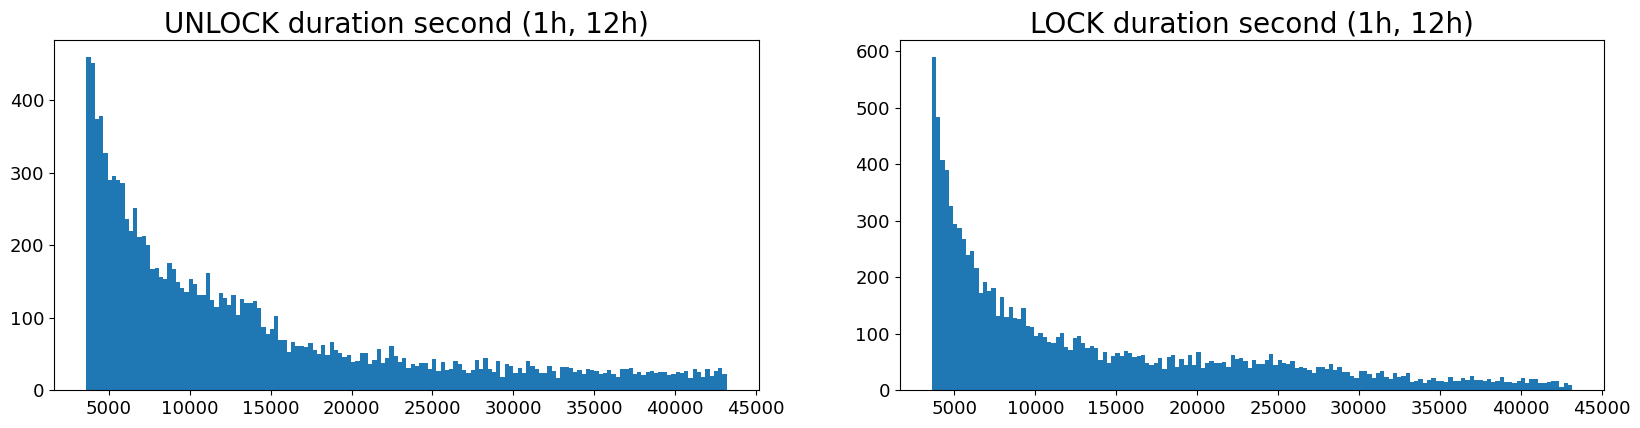

In [271]:
plt.figure(figsize = (20,10))
plt.subplot(221)
plt.gca().set_title('UNLOCK duration second (1h, 12h)', fontsize=20)
plt.hist(ios_us['duration_in_sec'].loc[(ios_us.duration_in_sec<43200)&(ios_us.duration_in_sec>3600)&(ios_us.state=='UNLOCK')], bins=150)
plt.tick_params(labelsize = 13)
plt.subplot(222)
plt.gca().set_title('LOCK duration second (1h, 12h)', fontsize=20)
plt.hist(ios_us['duration_in_sec'].loc[(ios_us.duration_in_sec<43200)&(ios_us.duration_in_sec>3600)&(ios_us.state=='LOCK')], bins=150)
plt.tick_params(labelsize = 13)

In [23]:
aos_us['timestamp'] = pd.to_datetime(aos_us['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
ios_us['timestamp'] = pd.to_datetime(ios_us['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')

#### Long Duration

In [ ]:
aos_ul = aos_us.loc[aos_us['state']=='UNLOCK']['duration_in_sec'].describe()
aos_ul_3q = aos_ul.loc['75%']
aos_ul_1q = aos_ul.loc['25%']
aos_ul_iqr = 1.5*(aos_ul_3q - aos_ul_1q)  

ios_ul = ios_us.loc[ios_us['state']=='UNLOCK']['duration_in_sec'].describe()
ios_ul_3q = ios_ul.loc['75%']
ios_ul_1q = ios_ul.loc['25%']
ios_ul_iqr = 1.5*(ios_ul_3q - ios_ul_1q)  

In [183]:
aos_ul_iqr_1 = aos_us.loc[(aos_us.duration_in_sec<3600*1)&(aos_us.duration_in_sec>aos_ul_iqr + aos_ul_3q)&(aos_us.state=='UNLOCK')]['timestamp']
aos_ul_1_12 = aos_us.loc[(aos_us.duration_in_sec<3600*12)&(aos_us.duration_in_sec>3600*1)&(aos_us.state=='UNLOCK')]['timestamp']
aos_ul_12 = aos_us.loc[(aos_us.duration_in_sec>3600*12)&(aos_us.state=='UNLOCK')]['timestamp']

aos_l_1_5 = aos_us.loc[(aos_us.duration_in_sec<3600*5)&(aos_us.duration_in_sec>3600*1)&(aos_us.state=='LOCK')]['timestamp']
aos_l_5_12 = aos_us.loc[(aos_us.duration_in_sec<3600*12)&(aos_us.duration_in_sec>3600*5)&(aos_us.state=='LOCK')]['timestamp']
aos_l_12 = aos_us.loc[(aos_us.duration_in_sec>3600*12)&(aos_us.state=='LOCK')]['timestamp']

ios_ul_iqr_1 = ios_us.loc[(ios_us.duration_in_sec<3600*1)&(ios_us.duration_in_sec>ios_ul_iqr + ios_ul_3q)&(ios_us.state=='UNLOCK')]['timestamp']
ios_ul_1_12 = ios_us.loc[(ios_us.duration_in_sec<3600*12)&(ios_us.duration_in_sec>3600*1)&(ios_us.state=='UNLOCK')]['timestamp']
ios_ul_12 = ios_us.loc[(ios_us.duration_in_sec>3600*12)&(ios_us.state=='UNLOCK')]['timestamp']

ios_l_1_5 = ios_us.loc[(ios_us.duration_in_sec<3600*5)&(ios_us.duration_in_sec>3600*1)&(ios_us.state=='LOCK')]['timestamp']
ios_l_5_12 = ios_us.loc[(ios_us.duration_in_sec<3600*12)&(ios_us.duration_in_sec>3600*5)&(ios_us.state=='LOCK')]['timestamp']
ios_l_12 = ios_us.loc[(ios_us.duration_in_sec>3600*12)&(ios_us.state=='LOCK')]['timestamp']

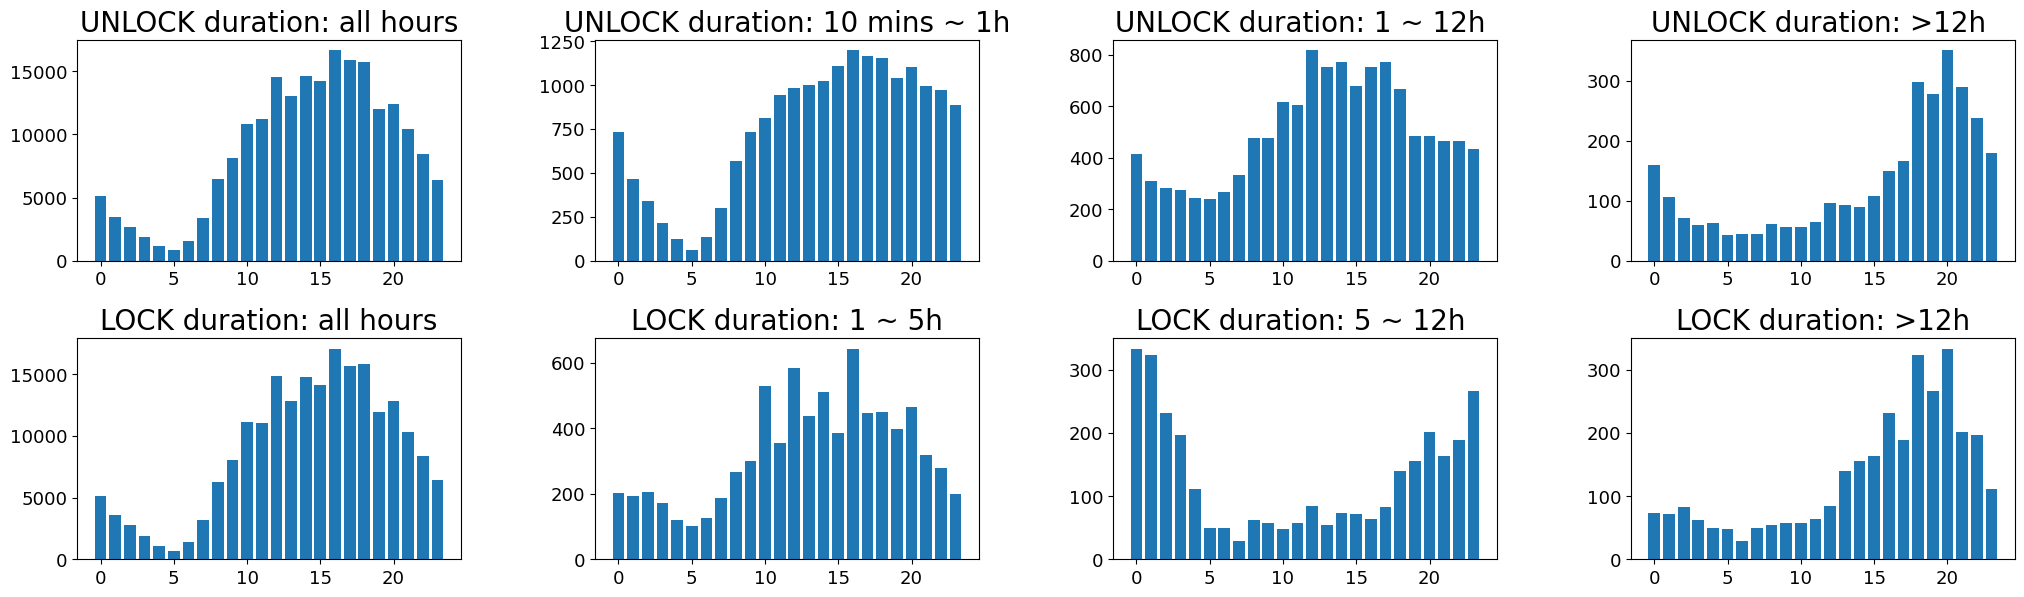

In [187]:
plt.figure(figsize = (25,30))

plt.subplot(841)
plt.gca().set_title('UNLOCK duration: all hours', fontsize=20)
plt.bar(ios_us.loc[ios_us.state=='UNLOCK']['timestamp'].dt.hour.value_counts().index, ios_us.loc[ios_us.state=='UNLOCK']['timestamp'].dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplot(842)
plt.gca().set_title('UNLOCK duration: 10 mins ~ 1h', fontsize=20)
plt.bar(ios_ul_iqr_1.dt.hour.value_counts().index, ios_ul_iqr_1.dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplot(843)
plt.gca().set_title('UNLOCK duration: 1 ~ 12h ', fontsize=20)
plt.bar(ios_ul_1_12.dt.hour.value_counts().index, ios_ul_1_12.dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplot(844)
plt.gca().set_title('UNLOCK duration: >12h ', fontsize=20)
plt.bar(ios_ul_12.dt.hour.value_counts().index, ios_ul_12.dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplots_adjust(wspace=0.35, hspace=0.35)

plt.subplot(845)
plt.gca().set_title('LOCK duration: all hours', fontsize=20)
plt.bar(ios_us.loc[ios_us.state=='LOCK']['timestamp'].dt.hour.value_counts().index, ios_us.loc[ios_us.state=='LOCK']['timestamp'].dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplot(846)
plt.gca().set_title('LOCK duration: 1 ~ 5h', fontsize=20)
plt.bar(ios_l_1_5.dt.hour.value_counts().index, ios_l_1_5.dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplot(847)
plt.gca().set_title('LOCK duration: 5 ~ 12h ', fontsize=20)
plt.bar(ios_l_5_12.dt.hour.value_counts().index, ios_l_5_12.dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplot(848)
plt.gca().set_title('LOCK duration: >12h', fontsize=20)
plt.bar(ios_l_12.dt.hour.value_counts().index, ios_l_5_12.dt.hour.value_counts())
plt.tick_params(labelsize = 13)

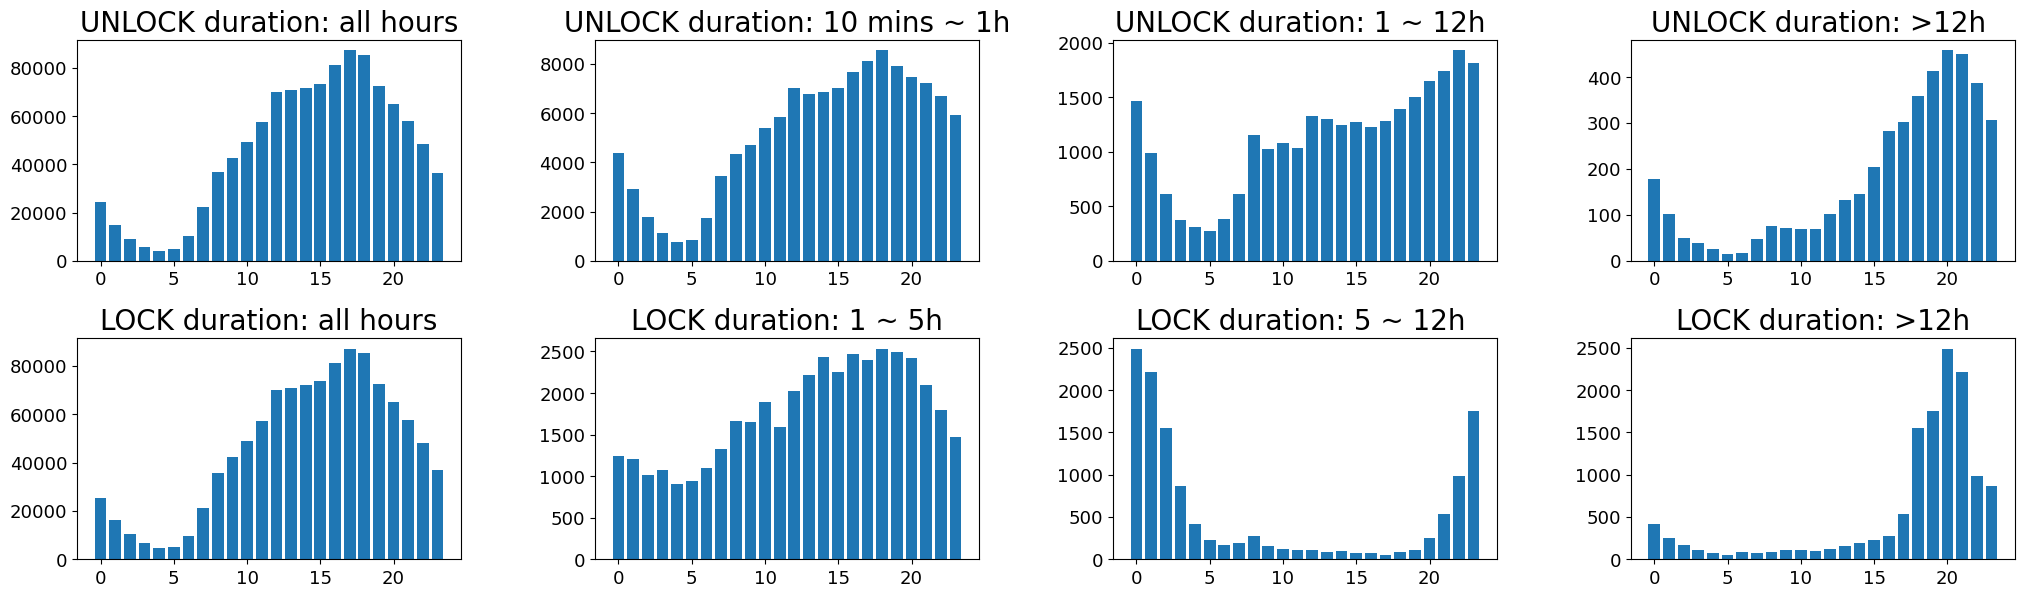

In [188]:
plt.figure(figsize = (25,30))

plt.subplot(841)
plt.gca().set_title('UNLOCK duration: all hours', fontsize=20)
plt.bar(aos_us.loc[aos_us.state=='UNLOCK']['timestamp'].dt.hour.value_counts().index, aos_us.loc[aos_us.state=='UNLOCK']['timestamp'].dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplot(842)
plt.gca().set_title('UNLOCK duration: 10 mins ~ 1h', fontsize=20)
plt.bar(aos_ul_iqr_1.dt.hour.value_counts().index, aos_ul_iqr_1.dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplot(843)
plt.gca().set_title('UNLOCK duration: 1 ~ 12h ', fontsize=20)
plt.bar(aos_ul_1_12.dt.hour.value_counts().index, aos_ul_1_12.dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplot(844)
plt.gca().set_title('UNLOCK duration: >12h ', fontsize=20)
plt.bar(aos_ul_12.dt.hour.value_counts().index, aos_ul_12.dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplots_adjust(wspace=0.35, hspace=0.35)

plt.subplot(845)
plt.gca().set_title('LOCK duration: all hours', fontsize=20)
plt.bar(aos_us.loc[aos_us.state=='LOCK']['timestamp'].dt.hour.value_counts().index, aos_us.loc[aos_us.state=='LOCK']['timestamp'].dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplot(846)
plt.gca().set_title('LOCK duration: 1 ~ 5h', fontsize=20)
plt.bar(aos_l_1_5.dt.hour.value_counts().index, aos_l_1_5.dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplot(847)
plt.gca().set_title('LOCK duration: 5 ~ 12h ', fontsize=20)
plt.bar(aos_l_5_12.dt.hour.value_counts().index, aos_l_5_12.dt.hour.value_counts())
plt.tick_params(labelsize = 13)

plt.subplot(848)
plt.gca().set_title('LOCK duration: >12h', fontsize=20)
plt.bar(aos_l_12.dt.hour.value_counts().index, aos_l_5_12.dt.hour.value_counts())
plt.tick_params(labelsize = 13)

In [ ]:
aos_ul_1_5 = aos_us.loc[(aos_us.duration_in_sec<3600*5)&(aos_us.duration_in_sec>3600*1)&(aos_us.state=='UNLOCK')]['timestamp']
aos_ul_5_12 = aos_us.loc[(aos_us.duration_in_sec<3600*12)&(aos_us.duration_in_sec>3600*5)&(aos_us.state=='UNLOCK')]['timestamp']
aos_ul_12 = aos_us.loc[(aos_us.duration_in_sec>3600*12)&(aos_us.state=='UNLOCK')]['timestamp']

aos_l_1_5 = aos_us.loc[(aos_us.duration_in_sec<3600*5)&(aos_us.duration_in_sec>3600*1)&(aos_us.state=='LOCK')]['timestamp']
aos_l_5_12 = aos_us.loc[(aos_us.duration_in_sec<3600*12)&(aos_us.duration_in_sec>3600*5)&(aos_us.state=='LOCK')]['timestamp']
aos_l_12 = aos_us.loc[(aos_us.duration_in_sec>3600*12)&(aos_us.state=='LOCK')]['timestamp']

In [124]:
aos_us.loc[aos_us.state=='LOCK'].describe()

,pid,duration_in_sec
count,1.103011e+06,1.103011e+06
mean,3.848720e+02,1.619333e+03
std,2.510167e+02,1.743145e+04
min,6.000000e+00,1.010000e-01
25%,1.490000e+02,4.549850e+01
50%,3.590000e+02,1.687260e+02
75%,6.120000e+02,6.350770e+02
max,8.790000e+02,7.693818e+06


<BarContainer object of 24 artists>

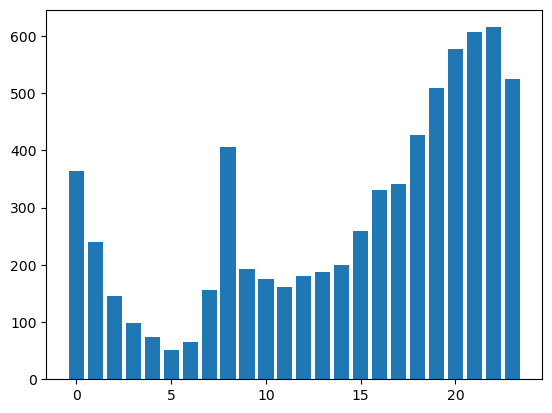

In [128]:
aos_l_12_14 = aos_us.loc[(aos_us.duration_in_sec>3600*5)&(aos_us.state=='UNLOCK')]['timestamp']
plt.bar(aos_l_12_14.dt.hour.value_counts().index, aos_l_12_14.dt.hour.value_counts())

In [64]:
aos_ul_5_12.dt.hour.value_counts()[:5] # data loss for sure -> less than 1h or 30mins

8     331
22    227
23    217
0     185
21    156
Name: timestamp, dtype: int64

In [67]:
aos_ul_12.dt.hour.value_counts()[:5] # data loss for sure: 

20    458
21    451
19    413
22    388
18    359
Name: timestamp, dtype: int64

In [281]:
ios_us['duration_in_sec'].describe().loc['75%'] + ios_iqr3

1232.848

### State Duration Analysis

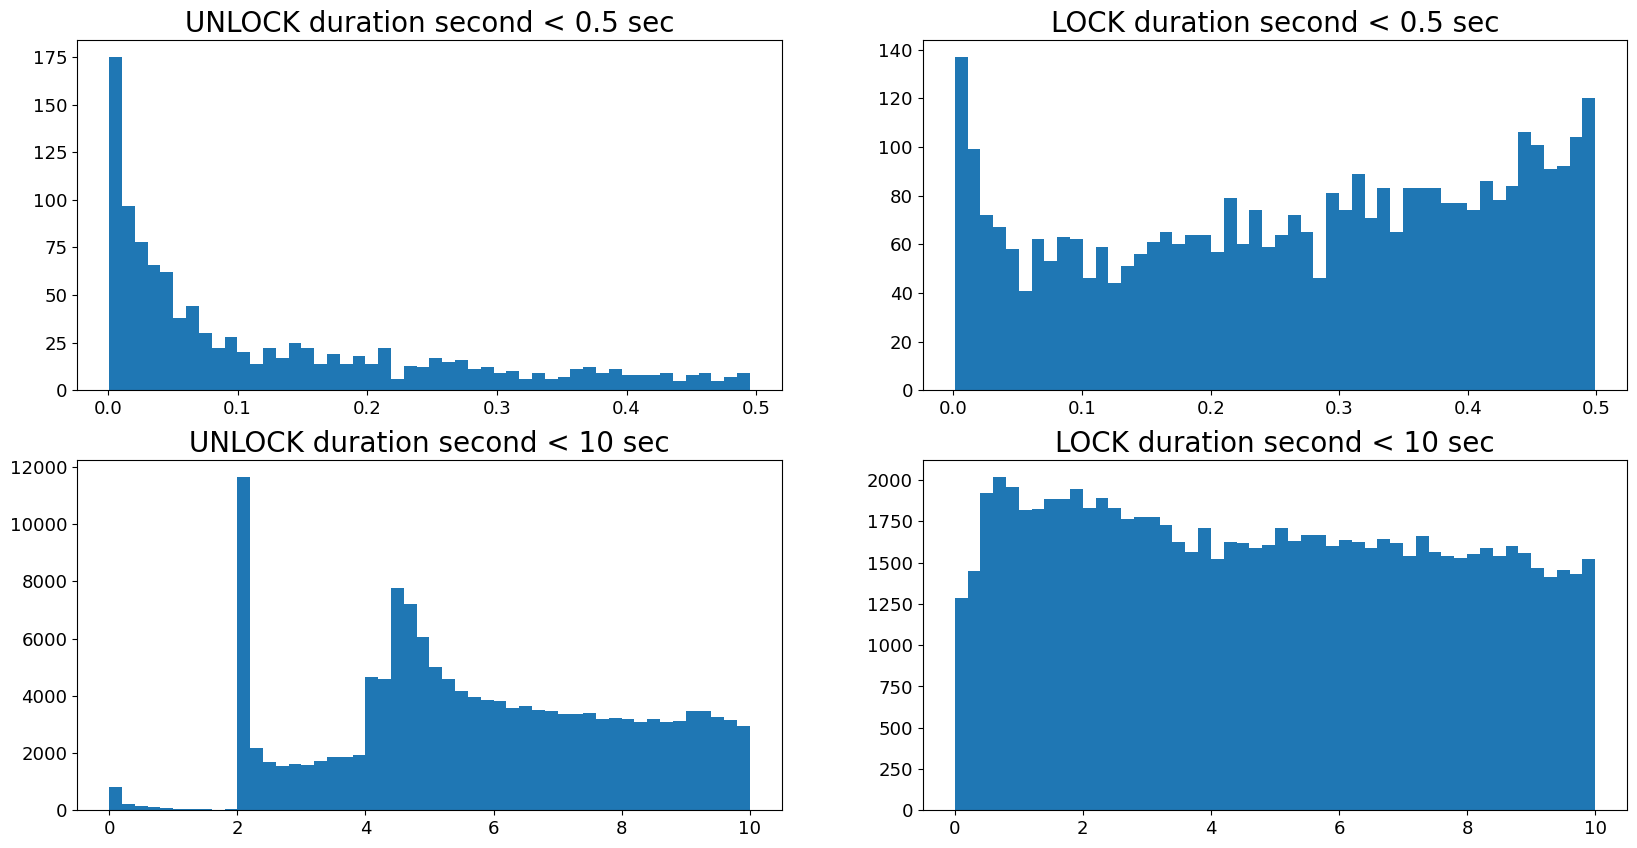

In [55]:
plt.figure(figsize = (20,10))
plt.subplot(221)
plt.gca().set_title('UNLOCK duration second < 0.5 sec', fontsize=20)
plt.hist(us_aos.loc[(us_aos['duration_in_sec']<0.5) & (us_aos.state=='UNLOCK')]['duration_in_sec'],bins=50)
plt.tick_params(labelsize = 13)
plt.subplot(222)
plt.gca().set_title('LOCK duration second < 0.5 sec', fontsize=20)
plt.hist(us_aos.loc[(us_aos['duration_in_sec']<0.5) & (us_aos.state=='LOCK')]['duration_in_sec'],bins=50)
plt.tick_params(labelsize = 13)
plt.subplot(223)
plt.gca().set_title('UNLOCK duration second < 10 sec', fontsize=20)
plt.hist(us_aos.loc[(us_aos['duration_in_sec']<10) & (us_aos.state=='UNLOCK')]['duration_in_sec'],bins=50)
plt.tick_params(labelsize = 13)
plt.subplot(224)
plt.gca().set_title('LOCK duration second < 10 sec', fontsize=20)
plt.hist(us_aos.loc[(us_aos['duration_in_sec']<10) & (us_aos.state=='LOCK')]['duration_in_sec'],bins=50)
plt.tick_params(labelsize = 13)
plt.show()


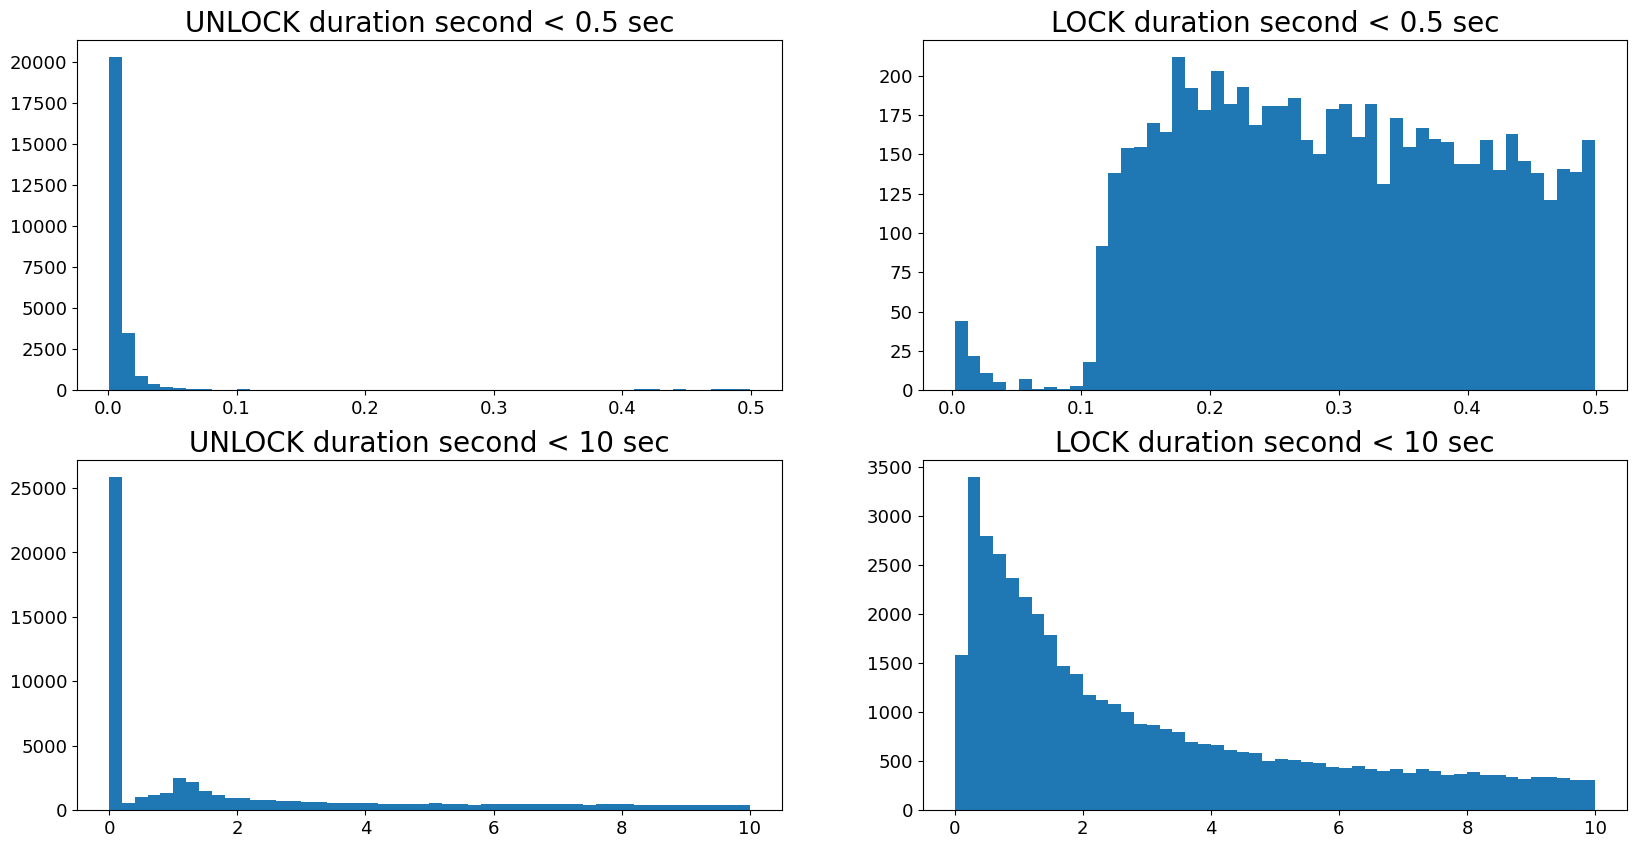

In [56]:
plt.figure(figsize = (20,10))
plt.subplot(221)
plt.gca().set_title('UNLOCK duration second < 0.5 sec', fontsize=20)
plt.hist(us_ios.loc[(us_ios['duration_in_sec']<0.5) & (us_ios.state=='UNLOCK')]['duration_in_sec'],bins=50)
plt.tick_params(labelsize = 13)
plt.subplot(222)
plt.gca().set_title('LOCK duration second < 0.5 sec', fontsize=20)
plt.hist(us_ios.loc[(us_ios['duration_in_sec']<0.5) & (us_ios.state=='LOCK')]['duration_in_sec'],bins=50)
plt.tick_params(labelsize = 13)
plt.subplot(223)
plt.gca().set_title('UNLOCK duration second < 10 sec', fontsize=20)
plt.hist(us_ios.loc[(us_ios['duration_in_sec']<10) & (us_ios.state=='UNLOCK')]['duration_in_sec'],bins=50)
plt.tick_params(labelsize = 13)
plt.subplot(224)
plt.gca().set_title('LOCK duration second < 10 sec', fontsize=20)
plt.hist(us_ios.loc[(us_ios['duration_in_sec']<10) & (us_ios.state=='LOCK')]['duration_in_sec'],bins=50)
plt.tick_params(labelsize = 13)
plt.show()

Data with duration less than a sec are considered as redundant data.

In [104]:
a = us_aos.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000

b = us_ios.copy()
b = b.reset_index()
b['timestamp'] = b['timestamp'].apply(lambda x: x.value) 
b['timestamp'] = b['timestamp']/1000000

aos_short = (a.loc[a['duration_in_sec']<0.1])
ios_short = (b.loc[b['duration_in_sec']<0.1])

In [34]:
aos_short.state.value_counts()

LOCK      710
UNLOCK    640
Name: state, dtype: int64

In [35]:
ios_short.state.value_counts()

UNLOCK    25605
LOCK         96
Name: state, dtype: int64

In [105]:
aos_sd_df = list()
aos_sidx = aos_short.index
for i in tqdm(range(len(a)-1)):
    if i in aos_sidx:
       # aos_sd_df.append(pd.DataFrame(a.iloc[i-1]).transpose())
        aos_sd_df.append(pd.DataFrame(a.iloc[i]).transpose())
        aos_sd_df.append(pd.DataFrame(a.iloc[i+1]).transpose())

aos_sd_df = pd.concat(aos_sd_df)

ios_sd_df = list()
ios_sidx = ios_short.index
for i in tqdm(range(len(b)-1)):
    if i in ios_sidx:
       # ios_sd_df.append(pd.DataFrame(b.iloc[i-1]).transpose())
        ios_sd_df.append(pd.DataFrame(b.iloc[i]).transpose())
        ios_sd_df.append(pd.DataFrame(b.iloc[i+1]).transpose())

ios_sd_df = pd.concat(ios_sd_df)

aos_sd_df['timestamp'] = pd.to_datetime(aos_sd_df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
ios_sd_df['timestamp'] = pd.to_datetime(ios_sd_df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')

100%|██████████| 419484/419484 [00:30<00:00, 13693.40it/s]


In [106]:
aos_sd_df.head(6)

,pid,timestamp,state,duration_in_sec
12741,14,2021-09-27 14:29:02.664000+09:00,UNLOCK,0.009
12742,14,2021-09-27 14:29:02.673000+09:00,LOCK,1.514
14644,14,2021-10-23 10:55:25.137000+09:00,LOCK,0.003
14645,14,2021-10-23 10:55:25.140000+09:00,UNLOCK,10.501
14682,14,2021-10-23 12:18:48.249999756+09:00,UNLOCK,0.004
14683,14,2021-10-23 12:18:48.254000244+09:00,LOCK,51.869999


In [107]:
ios_sd_df.head(6)

,pid,timestamp,state,duration_in_sec
0,43,2021-08-14 23:21:35.661000+09:00,UNLOCK,0.008
1,43,2021-08-14 23:21:35.669000+09:00,LOCK,32840.4375
9,43,2021-08-15 11:00:03.127000+09:00,UNLOCK,0.016
10,43,2021-08-15 11:00:03.143000+09:00,LOCK,313.963013
20,43,2021-08-15 14:51:54.952000+09:00,UNLOCK,0.006
21,43,2021-08-15 14:51:54.958000244+09:00,LOCK,16.072001


In [108]:
aos_sd_dict = dict()
aos_state_list = list()
aos_dur_all = list()
aos_dur_b = list()
aos_dur_a = list()

for i in range(int(len(aos_sd_df)/2)):
    aos_state_list.append(aos_sd_df['state'].iloc[2*i] +' '+ aos_sd_df['state'].iloc[2*i+1])
    #aos_dur_all.append(list(aos_sd_df[3*i:3*i+3]['duration_in_sec']))
    #aos_dur_b.append(aos_sd_df.iloc[3*i]['duration_in_sec'])
    #aos_dur_a.append(aos_sd_df.iloc[3*i+2]['duration_in_sec'])

ios_sd_dict = dict()
ios_state_list = list()
ios_dur_all = list()
ios_dur_b = list()
ios_dur_a = list()

for i in range(int(len(ios_sd_df)/2)):
    ios_state_list.append(ios_sd_df['state'].iloc[2*i] +' '+ ios_sd_df['state'].iloc[2*i+1])
    #ios_state_list.append(ios_sd_df['state'].iloc[3*i] +' '+ ios_sd_df['state'].iloc[3*i+1] +' '+  ios_sd_df['state'].iloc[3*i+2])
    #ios_dur_all.append(list(ios_sd_df[3*i:3*i+3]['duration_in_sec']))
    #ios_dur_b.append(ios_sd_df.iloc[3*i]['duration_in_sec'])
    #ios_dur_a.append(ios_sd_df.iloc[3*i+2]['duration_in_sec'])

In [109]:
pd.Series(aos_state_list).value_counts()

LOCK UNLOCK      710
UNLOCK LOCK      523
UNLOCK UNLOCK    117
dtype: int64

In [110]:
pd.Series(ios_state_list).value_counts()

UNLOCK LOCK      25569
LOCK LOCK           96
UNLOCK UNLOCK       36
dtype: int64

In [118]:
aos_us = a.drop(aos_sd_df.iloc[range(0, len(aos_sd_df), 2)].index)
ios_us = b.drop(ios_sd_df.iloc[range(0, len(ios_sd_df), 2)].index)

In [119]:
aos_us = aos_us.reset_index(drop=True)
ios_us = ios_us.reset_index(drop=True)

In [120]:
print('-'*10, 'Android', '-'*10)
print(aos_us.state.value_counts())
ds_shifted = aos_us[['state']].shift(-1)
aos_equal = (ds_shifted['state']==aos_us['state'])&(ds_shifted.index.get_level_values(0)==aos_us.index.get_level_values(0))
aos_us_re = aos_us[~aos_equal]
print('M_equal',aos_equal.sum())

print('-'*10, 'iOS', '-'*10)
print(ios_us.state.value_counts())
ds_shifted = ios_us[['state']].shift(-1)
ios_equal = (ds_shifted['state']==ios_us['state'])&(ds_shifted.index.get_level_values(0)==ios_us.index.get_level_values(0))
ios_us_re = ios_us[~ios_equal]
print('M_equal',ios_equal.sum())


---------- Android ----------
UNLOCK    1102845
LOCK      1089990
Name: state, dtype: int64
M_equal 13951
---------- iOS ----------
LOCK      211174
UNLOCK    182610
Name: state, dtype: int64
M_equal 29430


In [121]:
#aos_eidx1 = aos_equal.loc[aos_equal == True].index
aos_eidx1 = list()
aos_eidx2 = list()
for i in range(1, len(aos_equal)):
    if aos_us['pid'].iloc[i-1] != aos_us['pid'].iloc[i]:
        continue
    if aos_equal.iloc[i-1] == True:    
        aos_eidx1.append(pd.DataFrame(aos_equal).iloc[i-1].name)
        aos_eidx2.append(pd.DataFrame(aos_equal).iloc[i].name)
#ios_eidx1 = ios_equal.loc[ios_equal == True].index
ios_eidx1 = list()
ios_eidx2 = list()
for i in range(1, len(ios_equal)):
    if ios_us['pid'].iloc[i-1] != ios_us['pid'].iloc[i]:
        continue
    if ios_equal.iloc[i-1] == True:
        ios_eidx1.append(pd.DataFrame(ios_equal).iloc[i-1].name)
        ios_eidx2.append(pd.DataFrame(ios_equal).iloc[i].name)


In [122]:
#au = aos_us.copy()
#iu = ios_us.copy()

In [144]:
aos_us = au.copy()
ios_us = iu.copy()

In [142]:
random.randrange(100, 201, 100)

200

In [147]:
au.describe()

,pid,timestamp,duration_in_sec
count,2.192835e+06,2.192835e+06,2.192835e+06
mean,3.847361e+02,1.637218e+12,1.292510e+03
std,2.509452e+02,5.642908e+09,1.847554e+04
min,6.000000e+00,1.624939e+12,1.000000e-01
25%,1.490000e+02,1.633186e+12,3.069400e+01
50%,3.580000e+02,1.636377e+12,1.081120e+02
75%,6.120000e+02,1.639589e+12,4.480550e+02
max,8.790000e+02,1.659449e+12,8.955462e+06


In [145]:
import random 

aos_new = list()

for idx1, idx2 in tqdm(zip(aos_eidx1, aos_eidx2)):
    pid = aos_us['pid'].iloc[idx1]
    cols = aos_us.columns
    start = int(aos_us['timestamp'].iloc[idx1]) 
    end = int(aos_us['timestamp'].iloc[idx2])
    new_ts = random.randrange(start+50, end-50)
    dur = (end - new_ts)/1000
    
    if aos_us['state'].loc[idx1] == "UNLOCK":
        df = pd.DataFrame([[pid, new_ts, 'LOCK', dur]], columns = cols)
    elif aos_us['state'].loc[idx1] == "LOCK":
        df = pd.DataFrame([[pid, new_ts, 'UNLOCK', dur]], columns = cols)
    aos_new.append(df)

aos_new_df = pd.concat(aos_new)
aos_us_new = pd.concat([aos_new_df, aos_us])

aos_us = list()
for pid in aos_pids:
    df = aos_us_new.loc[aos_us_new['pid']==pid]
    aos_us.append(df.sort_values(by='timestamp'))

aos_us = pd.concat(aos_us).reset_index(drop=True)

a = list()
for pid in tqdm(aos_pids):
    a.append(aos_us.loc[aos_us.pid==pid].timestamp.diff().shift(-1)/1000)
aos_us['duration_in_sec'] = pd.concat(a)
aos_us.dropna(inplace=True)

# ios
ios_new = list()

for idx1, idx2 in tqdm(zip(ios_eidx1, ios_eidx2)):
    pid = ios_us['pid'].iloc[idx1]
    cols = ios_us.columns
    start = int(ios_us['timestamp'].iloc[idx1]) 
    end = int(ios_us['timestamp'].iloc[idx2])
    new_ts = random.randrange(start+50, end-50)
    dur = (end - new_ts)/1000
    
    if ios_us['state'].loc[idx1] == "UNLOCK":
        df = pd.DataFrame([[pid, new_ts, 'LOCK', dur]], columns = cols)
    elif ios_us['state'].loc[idx1] == "LOCK":
        df = pd.DataFrame([[pid, new_ts, 'UNLOCK', dur]], columns = cols)
    ios_new.append(df)

ios_new_df = pd.concat(ios_new)
ios_us_new = pd.concat([ios_new_df, ios_us])

ios_us = list()
for pid in ios_pids:
    df = ios_us_new.loc[ios_us_new['pid']==pid]
    ios_us.append(df.sort_values(by='timestamp'))

ios_us = pd.concat(ios_us).reset_index(drop=True)

a = list()
for pid in tqdm(ios_pids):
    a.append(ios_us.loc[ios_us.pid==pid].timestamp.diff().shift(-1)/1000)
ios_us['duration_in_sec'] = pd.concat(a)
ios_us.dropna(inplace=True)

5334it [00:01, 2885.43it/s]


ValueError: empty range for randrange() (1630824283551,1630824283551, 0)

In [99]:
aos_us.loc[aos_us.duration_in_sec<0.1]

,pid,timestamp,state,duration_in_sec
12048,14,1.632026e+12,LOCK,3.500000e-02
27043,26,1.636771e+12,LOCK,2.100000e-02
43764,36,1.632205e+12,LOCK,9.997559e-04
48495,37,1.629003e+12,LOCK,2.441406e-07
72652,42,1.629708e+12,UNLOCK,0.000000e+00
...,...,...,...,...
2183151,856,1.651283e+12,UNLOCK,9.999976e-02
2185101,856,1.653292e+12,UNLOCK,9.900024e-02
2185201,856,1.653381e+12,UNLOCK,9.999976e-02
2186042,856,1.653987e+12,LOCK,9.300000e-02


#### Cases (skip)

* Case 1: before == after: discard & random interpolation of opposite state
* Case 2: before != after: discard 

In [331]:
aos_sd_dict['state'] = aos_state_list
aos_sd_dict['duration'] = aos_dur_all
ios_sd_dict['state'] = ios_state_list
ios_sd_dict['duration'] = ios_dur_all

In [338]:
uul = list()
luu = list()
ulu = list()
uuu = list()
lul = list()
for state, duration in zip(aos_state_list, aos_dur_b):
    if state == 'UNLOCK UNLOCK LOCK':
        uul.append(duration)
    elif state == 'LOCK UNLOCK UNLOCK':
        luu.append(duration)
    elif state == 'UNLOCK LOCK UNLOCK':
        ulu.append(duration)        
    elif state == 'UNLOCK UNLOCK UNLOCK':
        uuu.append(duration)
    else : #state == 'LOCK UNLOCK LOCK'
        lul.append(duration)

aos_dur_b_list = [uul, luu, ulu, uuu, lul]

uul = list()
luu = list()
ulu = list()
uuu = list()
lul = list()
for state, duration in zip(aos_state_list, aos_dur_a):
    if state == 'UNLOCK UNLOCK LOCK':
        uul.append(duration)
    elif state == 'LOCK UNLOCK UNLOCK':
        luu.append(duration)
    elif state == 'UNLOCK LOCK UNLOCK':
        ulu.append(duration)        
    elif state == 'UNLOCK UNLOCK UNLOCK':
        uuu.append(duration)
    else : #state == 'LOCK UNLOCK LOCK'
        lul.append(duration)

aos_dur_a_list = [uul, luu, ulu, uuu, lul]

In [368]:
uul = list()
luu = list()
lll = list()
ull = list()
lul = list()
for state, duration in zip(ios_state_list, ios_dur_b):
    if state == 'UNLOCK UNLOCK LOCK':
        uul.append(duration)
    elif state == 'LOCK UNLOCK UNLOCK':
        luu.append(duration)
    elif state == 'LOCK LOCK LOCK':
        lll.append(duration)        
    elif state == 'UNLOCK LOCK LOCK':
        ull.append(duration)
    else : #state == 'LOCK UNLOCK LOCK'
        lul.append(duration)

ios_dur_b_list = [uul, luu, lll, ull, lul]

uul = list()
luu = list()
lll = list()
ull = list()
lul = list()
for state, duration in zip(ios_state_list, ios_dur_a):
    if state == 'UNLOCK UNLOCK LOCK':
        uul.append(duration)
    elif state == 'LOCK UNLOCK UNLOCK':
        luu.append(duration)
    elif state == 'LOCK LOCK LOCK':
        lll.append(duration)        
    elif state == 'UNLOCK LOCK LOCK':
        ull.append(duration)
    else : #state == 'LOCK UNLOCK LOCK'
        lul.append(duration)

ios_dur_a_list = [uul, luu, lll, ull, lul]

In [421]:
print('Android: avg duration before/after short-duration state')
for i in range(5):
    print(list(set(aos_state_list))[i])
    print('before:', pd.Series(aos_dur_b_list[i]).dropna().describe()[6], 'after:', pd.Series(aos_dur_a_list[i]).dropna().describe()[6])
    print('-'*50)


Android: avg duration before/after short-duration state
UNLOCK UNLOCK LOCK
before: 51.69499969482422 after: 794.9459838867188
--------------------------------------------------
LOCK UNLOCK UNLOCK
before: 1331.2974548339844 after: 7.955749988555908
--------------------------------------------------
UNLOCK LOCK UNLOCK
before: 175.2952537536621 after: 140.9209976196289
--------------------------------------------------
UNLOCK UNLOCK UNLOCK
before: 4.450000047683716 after: 6.183499813079834
--------------------------------------------------
LOCK UNLOCK LOCK
before: 2890.4525146484375 after: 3852.7259521484375
--------------------------------------------------


In [422]:
print('iOS: avg duration before/after short-duration state')
for i in range(5):
    print(list(set(ios_state_list))[i])
    print('before:', pd.Series(ios_dur_b_list[i]).dropna().describe()[6], 'after:', pd.Series(ios_dur_a_list[i]).dropna().describe()[6])
    print('-'*50)

iOS: avg duration before/after short-duration state
UNLOCK UNLOCK LOCK
before: 2468.0865478515625 after: 490.7349853515625
--------------------------------------------------
LOCK UNLOCK UNLOCK
before: 3550.2264404296875 after: 41.00699806213379
--------------------------------------------------
LOCK LOCK LOCK
before: 4417.1004638671875 after: 259.92674255371094
--------------------------------------------------
UNLOCK LOCK LOCK
before: 0.01824999926611781 after: 1958.1500244140625
--------------------------------------------------
LOCK UNLOCK LOCK
before: 25596.75732421875 after: 477.7799987792969
--------------------------------------------------


### Random Imputation (to be continued...')

In [545]:
a = us_aos.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000

b = us_ios.copy()
b = b.reset_index()
b['timestamp'] = b['timestamp'].apply(lambda x: x.value) 
b['timestamp'] = b['timestamp']/1000000

aos_short = (a.loc[a['duration_in_sec']<1])
ios_short = (b.loc[b['duration_in_sec']<1])

In [543]:
aos_sd_df.iloc[447:460]

,pid,timestamp,state,duration_in_sec
48330,37,2021-08-15 13:54:09.467000+09:00,LOCK,239.386993
48331,37,2021-08-15 13:58:08.854000244+09:00,UNLOCK,0.369
48332,37,2021-08-15 13:58:09.223000+09:00,LOCK,0.026
48331,37,2021-08-15 13:58:08.854000244+09:00,UNLOCK,0.369
48332,37,2021-08-15 13:58:09.223000+09:00,LOCK,0.026
48333,37,2021-08-15 13:58:09.249000+09:00,UNLOCK,63.389
48340,37,2021-08-15 14:02:04.977999756+09:00,UNLOCK,363.388
48341,37,2021-08-15 14:08:08.366000244+09:00,LOCK,0.001
48342,37,2021-08-15 14:08:08.367000+09:00,UNLOCK,483.019012
48378,37,2021-08-16 09:43:16.915000+09:00,UNLOCK,3024.082031


In [552]:
aos_sd_df.iloc[714:730]

,pid,timestamp,state,duration_in_sec
56889,37,2021-11-09 17:08:52.379000+09:00,UNLOCK,58.566002
56890,37,2021-11-09 17:09:50.945000+09:00,LOCK,0.377
56891,37,2021-11-09 17:09:51.321999756+09:00,UNLOCK,0.5
56890,37,2021-11-09 17:09:50.945000+09:00,LOCK,0.377
56891,37,2021-11-09 17:09:51.321999756+09:00,UNLOCK,0.5
56892,37,2021-11-09 17:09:51.822000244+09:00,LOCK,0.524
56891,37,2021-11-09 17:09:51.321999756+09:00,UNLOCK,0.5
56892,37,2021-11-09 17:09:51.822000244+09:00,LOCK,0.524
56893,37,2021-11-09 17:09:52.345999756+09:00,UNLOCK,43.716999
57057,37,2021-11-11 23:48:24.868000+09:00,LOCK,245.576004


In [546]:
import random

aos_new = list()

for i in tqdm(range(1, int(len(aos_sd_df)/3), 3)):
    pid = aos_sd_df.iloc[i]['pid']
    cols = aos_sd_df.columns 
    before = aos_sd_df.iloc[i-1]
    present = aos_sd_df.iloc[i]
    after = aos_sd_df.iloc[i+1]
    #n if before['state'] != after['state']:
    a = a.drop(present.name) 
    if before['state'] == after['state']:
        if before.name not in a.index:
            before = aos_sd_df.iloc[i-4]
        start = int(a['timestamp'].loc[before.name]) 
        end = int(a['timestamp'].loc[after.name])
        new_ts = random.randrange(start+1000, end-1000, 1000)
        dur = (end - new_ts)/1000
        if before['state'] == 'UNLOCK':
            state = 'LOCK'
        else: 
            state = 'UNLOCK'
        df = pd.DataFrame([[pid, new_ts, state, dur]], columns = cols)
    aos_new.append(df)


  7%|▋         | 240/3331 [00:52<11:17,  4.57it/s]


KeyError: 56890

In [ ]:
# when loading the data, data type is converted back automatically

a = aos_us.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('aos_preprocessed/aos_UNLOCK.csv')

a = ios_us.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('ios_preprocessed/ios_UNLOCK.csv')

## Screen Status


In [275]:
# Screen state data processing

sensorName = 'SCREEN_STATE'
cols=['timestamp','state']
dtypes={'state':'category'}

# android
aos_screen = load_data(path = aos_path, sensorName=sensorName, pids = aos_pids, cols=cols, dtypes = dtypes) 
aos_screen.insert(aos_screen.shape[1],'duration_in_sec',np.nan,allow_duplicates=True)

for pid in tqdm(aos_pids):
    aos_screen.loc[pid].duration_in_sec = aos_screen.loc[pid].index.to_series().diff().dt.total_seconds().shift(-1)

aos_screen.dropna(inplace=True)
# check duration with negative value        
M_for_non_positive = aos_screen['duration_in_sec']<=0
print('M_for_non_positive',M_for_non_positive.sum())
aos_screen = aos_screen[~M_for_non_positive]

# ios
ios_screen = load_data(path = ios_path, sensorName=sensorName, pids = ios_pids, cols=cols, dtypes = dtypes) 
ios_screen.insert(ios_screen.shape[1],'duration_in_sec',np.nan,allow_duplicates=True)

for pid in tqdm(ios_pids):
    ios_screen.loc[pid].duration_in_sec = ios_screen.loc[pid].index.to_series().diff().dt.total_seconds().shift(-1)

ios_screen.dropna(inplace=True)
# check duration with negative value        
M_for_non_positive = ios_screen['duration_in_sec']<=0
print('M_for_non_positive',M_for_non_positive.sum())
ios_screen = ios_screen[~M_for_non_positive]

  0%|          | 0/301 [00:00<?, ?it/s]c:\Users\shaba\anaconda3\envs\stdd\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
100%|██████████| 301/301 [00:05<00:00, 51.09it/s]


M_for_non_positive 0


100%|██████████| 99/99 [00:00<00:00, 209.66it/s]

M_for_non_positive 0


### On/Off Count Analysis

In [27]:
print('-'*10, 'Android', '-'*10)
print(aos_screen.state.value_counts())
ds_shifted = aos_screen[['state']].shift(-1)
aos_equal = (ds_shifted['state']==aos_screen['state'])&(ds_shifted.index.get_level_values(0)==aos_screen.index.get_level_values(0))
aos_screen_re = aos_screen[~aos_equal]
print('M_equal',aos_equal.sum())

print('-'*10, 'iOS', '-'*10)
print(ios_screen.state.value_counts())
ds_shifted = ios_screen[['state']].shift(-1)
ios_equal = (ds_shifted['state']==ios_screen['state'])&(ds_shifted.index.get_level_values(0)==ios_screen.index.get_level_values(0))
ios_screen_re = ios_screen[~ios_equal]
print('M_equal',ios_equal.sum())

---------- Android ----------
OFF    1737154
ON     1730737
Name: state, dtype: int64
M_equal 21792
---------- iOS ----------
ON     317771
OFF    310895
Name: state, dtype: int64
M_equal 6907


#### On/Off Count per Pids

In [141]:
on_state = list()
off_state = list()

for pid in aos_pids:
    df = aos_screen.loc[pid]
    on_state.append(len(df.loc[df['state']=='ON']))
    off_state.append(len(df.loc[df['state']=='OFF']))

aos_counts = pd.DataFrame()
aos_counts['On_state'] = on_state
aos_counts['Off_state'] = off_state
aos_counts.index = aos_pids

on_state = list()
off_state = list()

for pid in ios_pids:
    df = ios_screen.loc[pid]
    on_state.append(len(df.loc[df['state']=='ON']))
    off_state.append(len(df.loc[df['state']=='OFF']))

ios_counts = pd.DataFrame()
ios_counts['On_state'] = on_state
ios_counts['Off_state'] = off_state
ios_counts.index = ios_pids


In [144]:
aos_counts

,On_state,Off_state
6,17696,17790
14,3749,3742
21,3669,3690
26,4963,5032
28,2774,2859
...,...,...
856,15077,14997
863,2782,2806
867,1381,1389
878,5493,5484


In [145]:
ios_counts

,On_state,Off_state
43,8054,7951
44,2295,2203
59,5478,5433
86,2895,2821
87,10146,10058
...,...,...
835,4044,3995
840,914,818
842,6158,6069
851,2268,2153


#### On/Off count avg within 4h

In [ ]:
dfs = aos_screen.copy()
aos_sample_dict = {}
for pid in aos_pids:
    df_ema = aos_ema.loc[pid]
    df_sensor = dfs.loc[pid]
    sample_list = list()
    
    for t in df_ema.index:   
        start = t-timedelta(hours=4)
        df_window = df_sensor[(df_sensor.index>=start)&(df_sensor.index<t)]  
        sample_list.append(len(df_window))

    aos_sample_dict[pid] = np.mean(sample_list)
aos_df = pd.DataFrame(index = aos_sample_dict.keys(), columns = ['avg # of samples within 4h'], data = aos_sample_dict.values())

dfs = ios_screen.copy()
ios_sample_dict = {}
for pid in ios_pids:
    df_ema = ios_ema.loc[pid]
    df_sensor = dfs.loc[pid]
    sample_list = list()
    
    for t in df_ema.index:   
        start = t-timedelta(hours=4)
        df_window = df_sensor[(df_sensor.index>=start)&(df_sensor.index<t)]  
        sample_list.append(len(df_window))

    ios_sample_dict[pid] = np.mean(sample_list)
ios_df = pd.DataFrame(index = ios_sample_dict.keys(), columns = ['avg # of samples within 4h'], data = ios_sample_dict.values())

In [146]:
aos_df.describe()

,avg # of samples within 4h
count,301.000000
mean,32.214156
std,15.733153
min,2.111111
25%,21.390625
50%,29.546512
75%,40.178218
max,105.041667


In [147]:
ios_df.describe()

,avg # of samples within 4h
count,99.000000
mean,24.857257
std,16.020040
min,2.964912
25%,14.624202
50%,19.907692
75%,31.584682
max,100.550000


#### State duration: all data samples vs same state samples

In [130]:
idx1 = M_equal.loc[M_equal == True].index
idx2 = list()
for i in range(1, len(M_equal)):
    if M_equal.iloc[i-1] == True:
        idx2.append(pd.DataFrame(M_equal).iloc[i].name)

ON     317771
OFF    310895
Name: state, dtype: int64
M_equal 6907


In [92]:
aos_screen.describe()

,duration_in_sec
count,3.467891e+06
mean,8.219605e+02
std,1.464951e+04
min,1.000000e-03
25%,9.452000e+00
50%,5.215600e+01
75%,2.508485e+02
max,8.955463e+06


In [93]:
aos_screen.loc[idx].describe()

,duration_in_sec
count,2.179200e+04
mean,3.329090e+04
std,1.338832e+05
min,1.000000e-03
25%,1.311574e+03
50%,6.309465e+03
75%,3.857509e+04
max,8.955463e+06


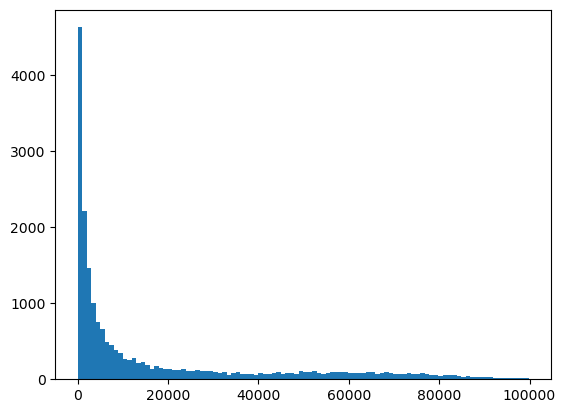

In [111]:
state = aos_screen.loc[idx]['duration_in_sec']
plt.hist(state.loc[state<100000], bins=100)
plt.show()

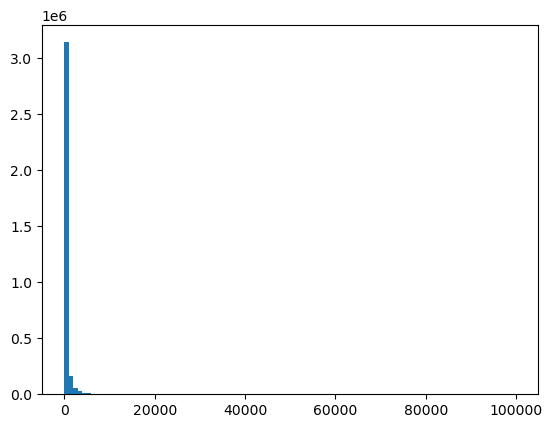

In [116]:
plt.hist(aos_screen['duration_in_sec'].loc[aos_screen['duration_in_sec']<100000], bins=100)
plt.show()

#### Random Interpolation

In [276]:
aos_screen = pd.read_csv('aos_preprocessed/aos_SCREEN.csv', index_col=0)
ios_screen = pd.read_csv('ios_preprocessed/ios_SCREEN.csv', index_col=0)

In [328]:
aos_screen = aos_screen.loc[(aos_screen.duration_in_sec<12*3600) & (aos_screen.duration_in_sec>1)]
ios_screen = ios_screen.loc[(ios_screen.duration_in_sec<12*3600) & (ios_screen.duration_in_sec>1)]

In [333]:
print('-'*10, 'Android', '-'*10)
print(aos_screen.state.value_counts())
ds_shifted = aos_screen[['state']].shift(-1)
aos_equal = (ds_shifted['state']==aos_screen['state'])&(ds_shifted.index.get_level_values(0)==aos_screen.index.get_level_values(0))
aos_screen_re = aos_screen[~aos_equal]
print('M_equal',aos_equal.sum())

print('-'*10, 'iOS', '-'*10)
print(ios_screen.state.value_counts())
ds_shifted = ios_screen[['state']].shift(-1)
ios_equal = (ds_shifted['state']==ios_screen['state'])&(ds_shifted.index.get_level_values(0)==ios_screen.index.get_level_values(0))
ios_screen_re = ios_screen[~ios_equal]
print('M_equal',ios_equal.sum())



---------- Android ----------
ON     1780255
OFF    1695591
Name: state, dtype: int64
M_equal 141348
---------- iOS ----------
ON     393346
OFF    375029
Name: state, dtype: int64
M_equal 38292


In [13]:
#aos_eidx1 = aos_equal.loc[aos_equal == True].index
aos_eidx1 = list()
aos_eidx2 = list()
for i in range(1, len(aos_equal)):
    if aos_screen['pid'].iloc[i-1] != aos_screen['pid'].iloc[i]:
        continue
    if aos_equal.iloc[i-1] == True:    
        aos_eidx1.append(pd.DataFrame(aos_equal).iloc[i-1].name)
        aos_eidx2.append(pd.DataFrame(aos_equal).iloc[i].name)

#ios_eidx1 = ios_equal.loc[ios_equal == True].index
ios_eidx1 = list()
ios_eidx2 = list()
for i in range(1, len(ios_equal)):
    if ios_screen['pid'].iloc[i-1] != ios_screen['pid'].iloc[i]:
        continue
    if ios_equal.iloc[i-1] == True:
        ios_eidx1.append(pd.DataFrame(ios_equal).iloc[i-1].name)
        ios_eidx2.append(pd.DataFrame(ios_equal).iloc[i].name)

In [277]:
import random 

aos_new = list()

for idx1, idx2 in tqdm(zip(aos_eidx1, aos_eidx2)):
    pid = aos_screen['pid'].iloc[idx1]
    cols = aos_screen.columns
    start = int(aos_screen['timestamp'].iloc[idx1]) 
    end = int(aos_screen['timestamp'].iloc[idx2])
    new_ts = random.randrange(start+1000, end, 1000)
    dur = (end - new_ts)/1000
    
    if aos_screen['state'].loc[idx1] == "ON":
        df = pd.DataFrame([[pid, new_ts, 'OFF', dur]], columns = cols)
    elif aos_screen['state'].loc[idx1] == "OFF":
        df = pd.DataFrame([[pid, new_ts, 'ON', dur]], columns = cols)
    aos_new.append(df)

aos_new_df = pd.concat(aos_new)
aos_screen_new = pd.concat([aos_new_df, aos_screen])

aos_screen = list()
for pid in aos_pids:
    df = aos_screen_new.loc[aos_screen_new['pid']==pid]
    aos_screen.append(df.sort_values(by='timestamp'))

aos_screen = pd.concat(aos_screen).reset_index(drop=True)

a = list()
for pid in tqdm(aos_pids):
    a.append(aos_screen.loc[aos_screen.pid==pid].timestamp.diff().shift(-1)/1000)
aos_screen['duration_in_sec'] = pd.concat(a)
aos_screen.dropna(inplace=True)

# ios
ios_new = list()

for idx1, idx2 in tqdm(zip(ios_eidx1, ios_eidx2)):
    pid = ios_screen['pid'].iloc[idx1]
    cols = ios_screen.columns
    start = int(ios_screen['timestamp'].iloc[idx1]) 
    end = int(ios_screen['timestamp'].iloc[idx2])
    new_ts = random.randrange(start+1000, end, 1000)
    dur = (end - new_ts)/1000
    
    if ios_screen['state'].loc[idx1] == "ON":
        df = pd.DataFrame([[pid, new_ts, 'OFF', dur]], columns = cols)
    elif ios_screen['state'].loc[idx1] == "OFF":
        df = pd.DataFrame([[pid, new_ts, 'ON', dur]], columns = cols)
    ios_new.append(df)

ios_new_df = pd.concat(ios_new)
ios_screen_new = pd.concat([ios_new_df, ios_screen])

ios_screen = list()
for pid in ios_pids:
    df = ios_screen_new.loc[ios_screen_new['pid']==pid]
    ios_screen.append(df.sort_values(by='timestamp'))

ios_screen = pd.concat(ios_screen).reset_index(drop=True)

a = list()
for pid in tqdm(ios_pids):
    a.append(ios_screen.loc[ios_screen.pid==pid].timestamp.diff().shift(-1)/1000)
ios_screen['duration_in_sec'] = pd.concat(a)
ios_screen.dropna(inplace=True)

667it [00:00, 2902.90it/s]


ValueError: empty range for randrange()

In [ ]:
# save
a = aos_screen.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('aos_preprocessed/aos_SCREEN.csv')

a = ios_screen.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('ios_preprocessed/ios_SCREEN.csv')

### Data Analysis: Compare with Notification & Unlock state

In [ ]:
aos_not = pd.read_csv('aos_not.csv', index_col=0)
aos_not = aos_not.drop('index', axis=1)
aos_not['arrival_time'] = pd.to_datetime(aos_not['arrival_time'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul') 
aos_not.set_index(['pid','arrival_time'], inplace=True)

#### Remove instances of identical timestamps with notifications

In [ ]:
idx_list = list()
len_list = list()
screen_df = pd.DataFrame()
for pid in aos_pids:
    idx_not = aos_not.loc[pid].index
    idx_screen = aos_screen.loc[pid].index
    timestamps = idx_not & idx_screen
    idx_list.append(timestamps)
    df_screen = aos_screen.loc[pid].drop(timestamps)
    df_screen['pid'] = pid
    df_screen['timestamp'] = df_screen.index
    screen_df = pd.concat([screen_df,  df_screen])

screen_df.set_index(['pid','timestamp'], inplace=True)

In [ ]:
print(len(aos_screen), '->', len(screen_df))

#### Frequent, fast check

In [280]:
ios_sensors

['SCREEN_STATE',
 'SURVEY_EMA',
 'LOCATION_GPS',
 'ACTIVITY_RECOGNITION',
 'CALLS',
 'SOUND_DATA',
 'UNLOCK_STATE',
 'ANDROID_SIGNIFICANT_MOTION',
 'ANDROID_STEP_DETECTOR',
 'ANDROID_GRAVITY']

In [ ]:
instlist = list()
totlist = list()
notlist = list()
i = 0
for pid in aos_pids:
    inst_check = len(screen_df.loc[pid].loc[(screen_df.loc[pid].duration_in_sec < 5) & (screen_df.loc[pid].state == 'ON')])
    total_length = len(aos_screen.loc[pid].loc[aos_screen.loc[pid].state == 'ON'])
    notlist.append(len(idx_list[i]))
    instlist.append(inst_check)
    totlist.append(total_length)
    i+=1

In [ ]:
df = pd.DataFrame()
df['notifications'] = notlist
df['frequent check (5 sec)'] = instlist
df['screen ON'] = totlist
df.index = aos_pids

aos_screen = screen_df.copy()

### Feature Extraction

In [ ]:
warnings.filterwarnings(action='ignore')

def get_screen_state_features(feature, survey, pids, window_size):

    _d_name = 'SCREEN_STATE'
    _w_name = '{}HR'.format(window_size)
    cluster_list = list()

    screen_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')
    
    for pid in tqdm(pids):
        ema = survey.loc[pid]
        data_source = feature.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t - timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
        
            if len(d_window) == 0:
                features = defaultdict(lambda: np.nan)
            else:        
                N_on = len(d_window.loc[d_window.state=='ON'])
                N_off = len(d_window.loc[d_window.state=='OFF'])
                p_on = N_on/(N_on+N_off)
                p_off = N_off/(N_on+N_off)
                ent = -(p_on*np.log2(p_on)+p_off*np.log2(p_off))


                features = defaultdict(lambda: np.nan)
                features['{}#{}#onCount'.format(_d_name,_w_name)] = N_on
                features['{}#{}#offCount'.format(_d_name,_w_name)] = N_off
                features['{}#{}#entropy'.format(_d_name,_w_name)] = ent  
                features['{}#{}#normalized_entropy'.format(_d_name,_w_name)] = ent/np.log2(N_on+N_off)

            output_table = output_table.append(features, ignore_index=True)

        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        screen_df = pd.concat([screen_df, output_table])

    screen_df.fillna(0, inplace=True)
    if pids == aos_pids:
        screen_df.to_csv('aos_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 
    else:
        screen_df.to_csv('ios_features/ios_{}_{}.csv'.format(_d_name,_w_name)) 
    return screen_df

In [ ]:
for w in range(4, 5, 4):
    get_screen_state_features(aos_screen, aos_ema, aos_pids, w)
    get_screen_state_features(ios_screen, ios_ema, ios_pids, w)

## Calls

In [140]:
cols = ['start', 'end', 'flag']
dtypes = {'start':np.int64, 'end':np.int64, 'flag':'category'}
sensorName = 'CALLS' 

aos_call = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols, dtypes = dtypes) 
aos_call['duration_in_sec'] = (aos_call['end'] - aos_call['start']).astype(np.int64)//10**9

# indexing missed aos_calls
M_for_missed = aos_call['flag']=='MISSED'
aos_call.loc[M_for_missed,'duration_in_sec'] = -1

ios_call = load_data(path = ios_path, sensorName=sensorName, pids=ios_pids, cols=cols, dtypes = dtypes) 
ios_call['duration_in_sec'] = (ios_call['end'] - ios_call['start']).astype(np.int64)//10**9

# indexing missed ios_calls
M_for_missed = ios_call['flag']=='MISSED'
ios_call.loc[M_for_missed,'duration_in_sec'] = -1

100%|██████████| 191/191 [00:03<00:00, 49.94it/s]


In [145]:
a = aos_call.copy()
a = a.reset_index()
for c in a.columns[1:4]:
    a[c] = a[c].apply(lambda x: x.value) 
    a[c] = a[c]/1000000
a.to_csv('aos_preprocessed/aos_call.csv')

a = ios_call.copy()
a = a.reset_index()
for c in a.columns[1:4]:
    a[c] = a[c].apply(lambda x: x.value) 
    a[c] = a[c]/1000000
a.to_csv('ios_preprocessed/ios_call.csv')

### Data Analysis: MISSED vs IN vs OUT

In [108]:
idx = aos_call.loc[aos_call.flag =='MISSED'].index
call_in = aos_call.loc[aos_call.flag =='IN']
call_out = aos_call.loc[aos_call.flag =='OUT']
call_nmiss = aos_call.drop(idx)
call_miss = aos_call.loc[idx]
call_nmiss.describe()

,start,end,duration_in_sec
count,1.686700e+04,1.686700e+04,16867.000000
mean,1.636323e+18,1.636323e+18,166.951444
std,3.650218e+15,3.650234e+15,577.474562
min,1.628925e+18,1.628926e+18,0.000000
25%,1.633502e+18,1.633502e+18,20.000000
50%,1.636168e+18,1.636168e+18,45.000000
75%,1.638678e+18,1.638678e+18,108.000000
max,1.644850e+18,1.644850e+18,17834.000000


In [114]:
print('# of incoming calls', len(call_in))
print('# of outgoing calls', len(call_out))
print('# of MISSED calls', len(call_miss))

# of incoming calls 7000
# of outgoing calls 9867
# of MISSED calls 3089


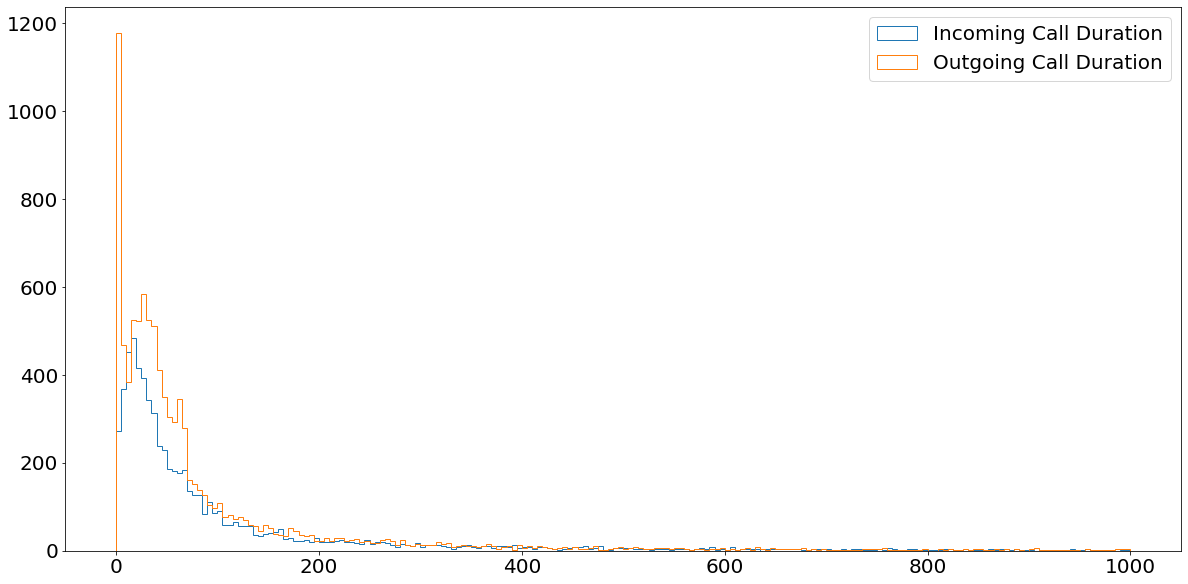

In [113]:
# Histogram of Call Duration: Incoming vs Outgoing

plt.figure(figsize=(20,10))
plt.hist(call_in.duration_in_sec, bins = 200, histtype='step', range=(0,1000), label='Incoming Call Duration')
plt.hist(call_out.duration_in_sec, bins = 200, histtype='step', range=(0,1000), label='Outgoing Call Duration')
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=20)
plt.show()

In [147]:
dep_list= list()
udep_list= list()

for pid in aos_pids:
    ema = aos_ema.loc[pid]
    ndep = len(ema.loc[ema.depressed==1])
    dep = len(ema.loc[ema.depressed==0])
    if dep == 0:
        udep_list.append(pid)
    else:
        if ndep/dep > 1:
            udep_list.append(pid)
        else:
            dep_list.append(pid)


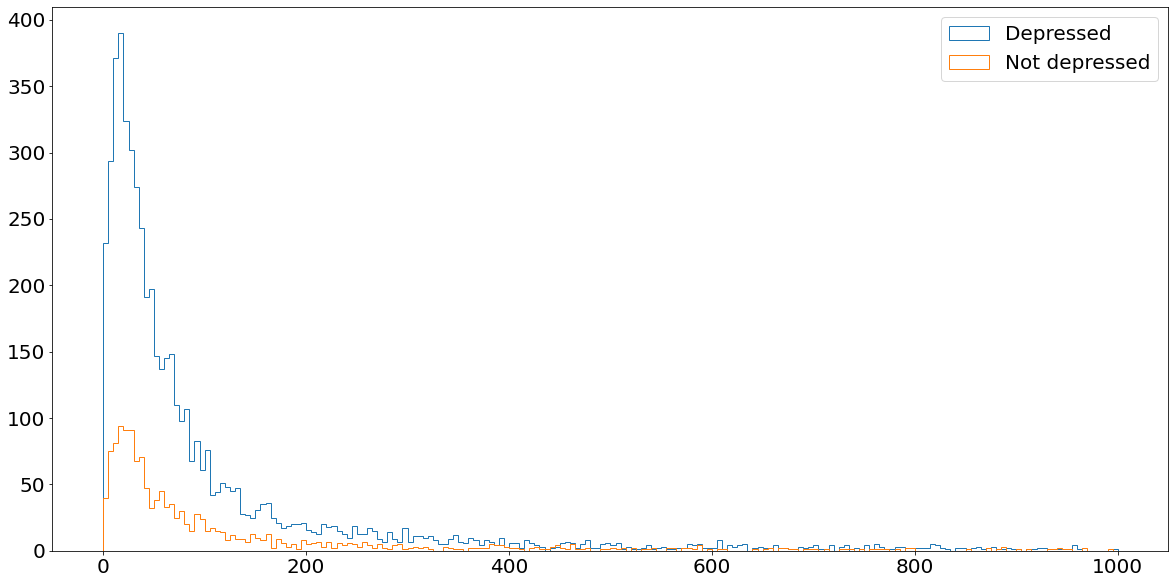

In [152]:
# Incoming Call Duration: Depressed vs Not Depressed

plt.figure(figsize=(20,10))
plt.hist(call_in.loc[dep_list].duration_in_sec, bins = 200, histtype='step', range=(0,1000), label='Depressed')
plt.hist(call_in.loc[udep_list].duration_in_sec, bins = 200, histtype='step', range=(0,1000), label='Not depressed')
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=20)
plt.show()

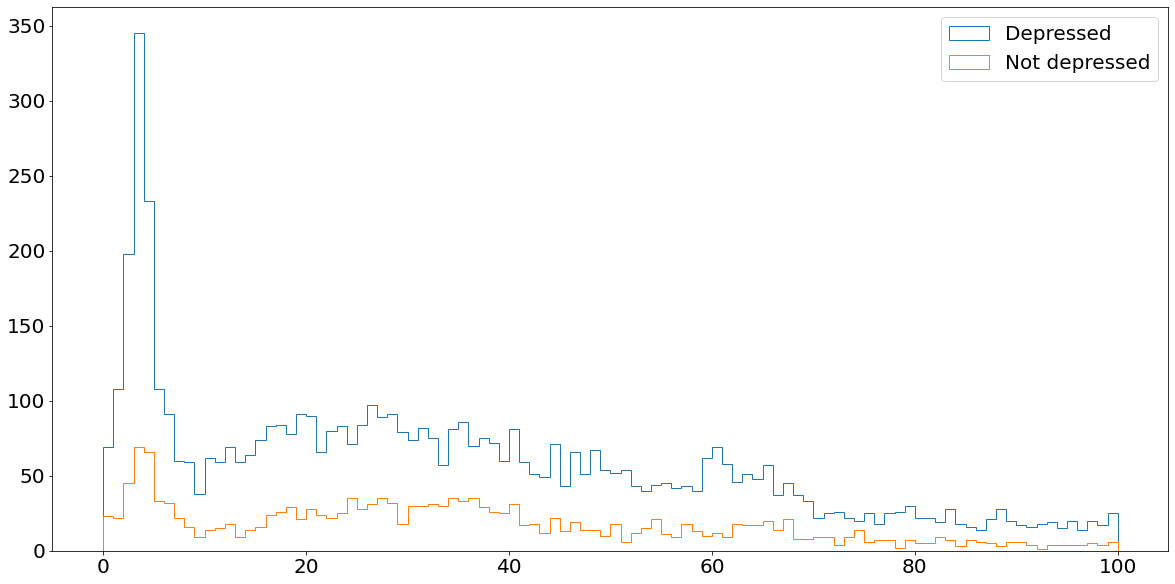

In [156]:
# Outgoing Call Duration: Depressed vs Not Depressed

plt.figure(figsize=(20,10))
plt.hist(call_out.loc[dep_list].duration_in_sec, bins = 100, histtype='step', range=(0,100), label='Depressed')
plt.hist(call_out.loc[udep_list].duration_in_sec, bins = 100, histtype='step', range=(0,100), label='Not depressed')
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=20)
plt.show()

In [201]:
dep_dur_dict = dict()
dep_count_dict = dict()
dur_dict = dict()
count_dict = dict()

for pid in dep_list:
    df = aos_call.loc[pid]
    dep_count_dict[pid] = len(df.loc[df.flag == 'IN']) / len(df.loc[df.flag == 'OUT'])
    dep_dur_dict[pid] = df.loc[df.flag == 'IN'].duration_in_sec.sum() / df.loc[df.flag == 'OUT'].duration_in_sec.sum()

for pid in udep_list:
    df = aos_call.loc[pid]
    count_dict[pid] = len(df.loc[df.flag == 'IN']) / len(df.loc[df.flag == 'OUT'])
    dur_dict[pid] = df.loc[df.flag == 'IN'].duration_in_sec.sum() / df.loc[df.flag == 'OUT'].duration_in_sec.sum()


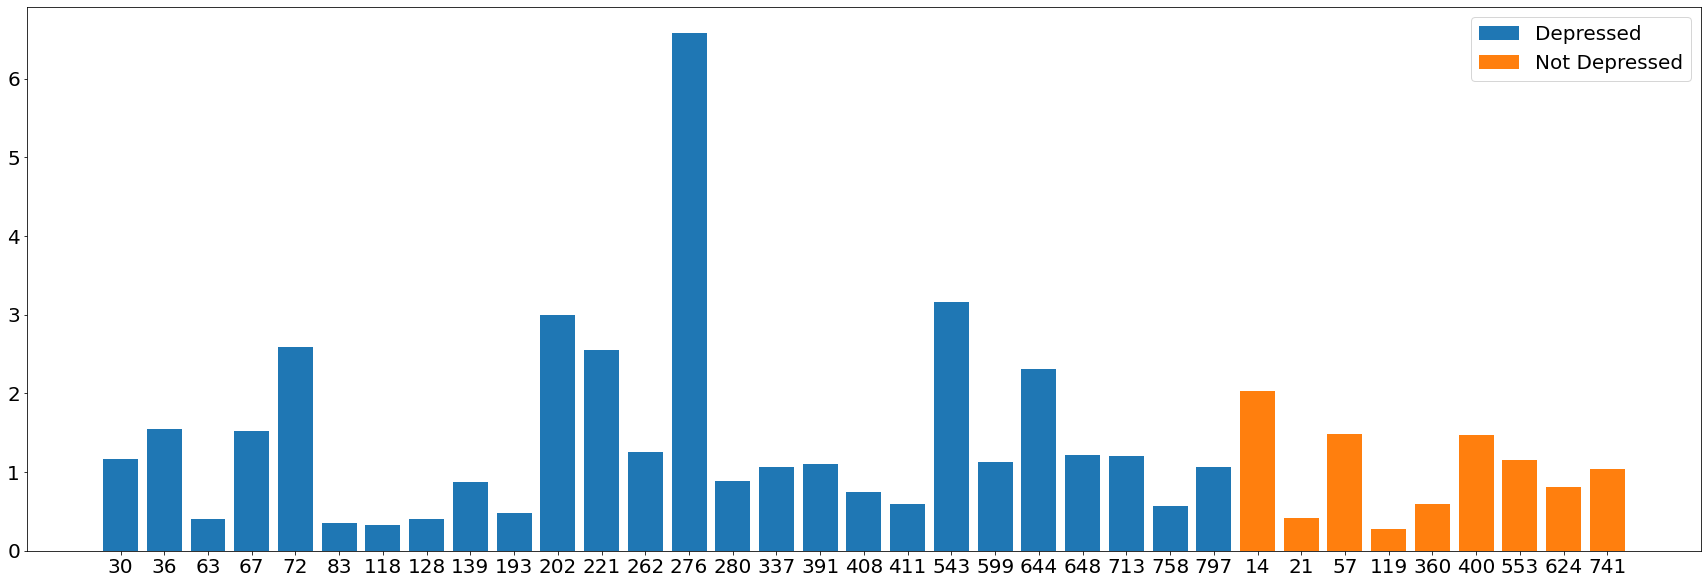

In [202]:
# In/Out ratio of Call Duration: Depressed vs Not-depressed

plt.figure(figsize=(30,10))
plt.bar(pd.Series(dep_dur_dict.keys()).astype(str), dep_dur_dict.values(),  label='Depressed')
plt.bar(pd.Series(dur_dict.keys()).astype(str), dur_dict.values(), label='Not Depressed')

plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=20)
plt.show()

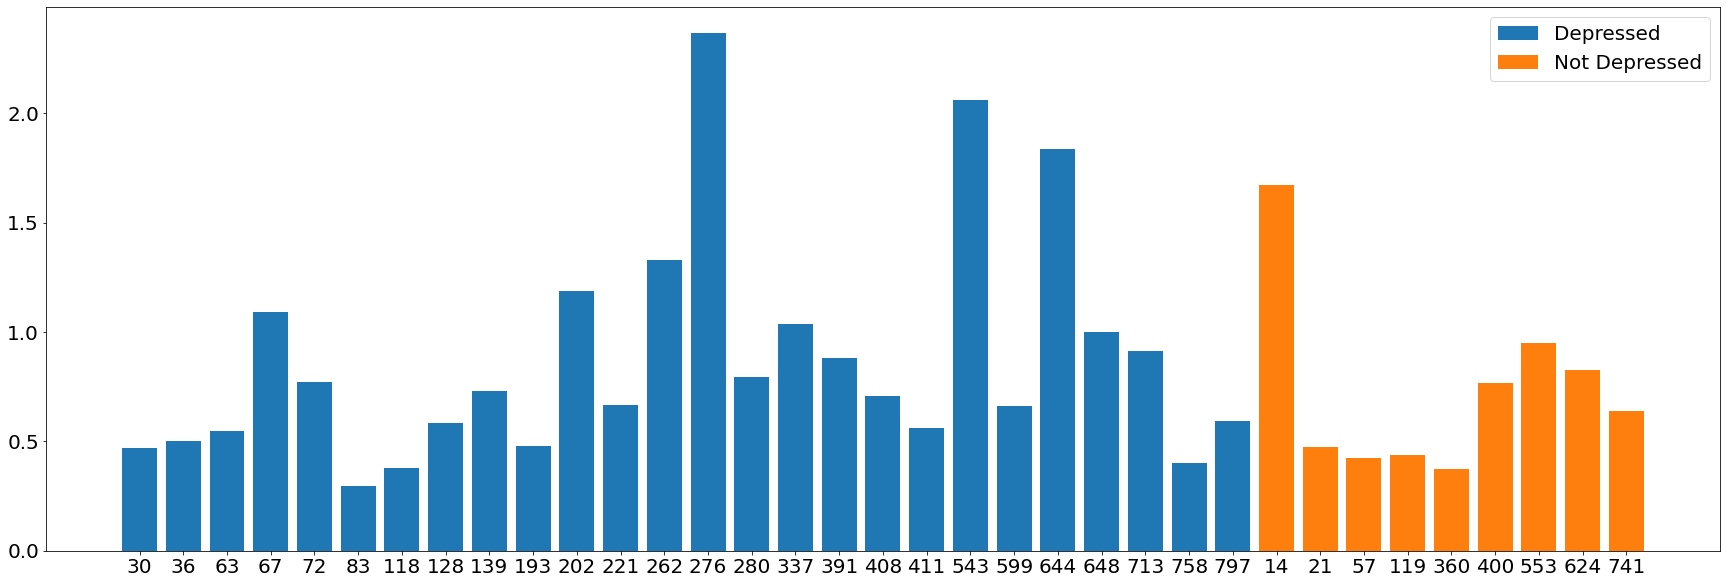

In [203]:
# In/Out ratio of Call Counts: Depressed vs Not-depressed

plt.figure(figsize=(30,10))
plt.bar(pd.Series(dep_count_dict.keys()).astype(str), dep_count_dict.values(),  label='Depressed')
plt.bar(pd.Series(count_dict.keys()).astype(str), count_dict.values(), label='Not Depressed')

plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=20)
plt.show()

### Feature Extraction

In [146]:
def get_call_features(feature, survey, pids, window_size):

    _d_name = 'CALL'
    _w_name = '{}HR'.format(window_size)
    cluster_list = list()

    call_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')

    for pid in tqdm(pids):
        ema = survey.loc[pid]
        data_source = feature.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t - timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
            features = defaultdict(lambda: 0)
        
            if len(d_window) == 0:
                output_table = output_table.append(features, ignore_index=True)
                continue

            in_count = len(d_window[d_window.flag=='IN'])
            out_count = len(d_window[d_window.flag=='OUT']) 
            in_dur = d_window[d_window.flag=='IN']['duration_in_sec'].values.sum()
            out_dur = d_window[d_window.flag=='OUT']['duration_in_sec'].values.sum()

            features['{}#{}#count_ratio_in2out'.format(_d_name,_w_name)] = in_count/out_count if out_count > 0 else in_count
            features['{}#{}#duration_ratio_in2out'.format(_d_name,_w_name)] = in_dur/out_dur if out_dur > 0 else in_dur 
                
            for calls_type in ['MISSED','IN','OUT']: 
                d_window_flag = d_window[d_window.flag==calls_type]
                features['{}#{}#{}_count'.format(_d_name,_w_name, calls_type)]= len(d_window_flag)
                if calls_type!='MISSED':
                    dur = d_window_flag['duration_in_sec'].values
                    features['{}#{}#{}_dur'.format(_d_name,_w_name, calls_type)] = dur.sum()     

            output_table = output_table.append(features, ignore_index=True)

        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        call_df = pd.concat([call_df, output_table])
    
    call_df.fillna(0,  inplace=True)
    if pids == aos_pids:
        call_df.to_csv('aos_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 
    else:
        call_df.to_csv('ios_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 
    
    return call_df

In [147]:
for w in range(4, 5, 4):
    get_call_features(aos_call, aos_ema, aos_pids, w)
    get_call_features(ios_call, ios_ema, ios_pids, w)


Processing for window size = 4
-------------------------------------------


100%|██████████| 336/336 [01:17<00:00,  4.31it/s]


Processing for window size = 4
-------------------------------------------


100%|██████████| 191/191 [00:26<00:00,  7.26it/s]


## SMS (Not used)

In [ ]:
def parse_and_save_rawsmsdata(campaign_id, pids, dataroot, cols):    
    df_concat = []
    values_col = cols
    datasource_id =  17
   
    for pid in tqdm(pids):    
        full_path = join(dataroot,'{}-{}'.format(campaign_id,pid),'{}_{}.csv'.format(pid,datasource_id))
        outfile = full_path.replace(dataroot, PDATAROOT)
        
        df_ = pd.read_csv(full_path)    
        df_['timestamp'] = df_['values'].apply(extract_timestamp)
        df_['sender'] = df_['values'].apply(extract_sender)
        df_['num_characters'] = df_['values'].apply(extract_num_chars)
        
        df_.insert(0,'pid',pid,allow_duplicates=True)
        df_['pid'] = df_['pid'].astype(int)

        df_concat.append(df_)
                                                       
            
    df =  pd.concat(df_concat)
    
    df.timestamp = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    df.set_index(['pid','timestamp'] , inplace=True)
    df.sort_index( inplace=True)

    return df

In [ ]:
def parse_row(s):
    first_space = s.find(' ')
    last_space = s.rfind(' ')
    timestamp = s[:first_space]
    sender = s[first_space+1:last_space]
    num_chars = s[last_space+1:]
    print(timestamp, sender, num_chars)
    return timestamp, sender, num_chars

def extract_timestamp(s):
    first_space = s.find(' ')
    last_space = s.rfind(' ')
    timestamp = s[:first_space]
    return timestamp

def extract_sender(s):
    first_space = s.find(' ')
    last_space = s.rfind(' ')
    sender = s[first_space+1:last_space]
    return  sender.rstrip()

def extract_num_chars(s):
    first_space = s.find(' ')
    last_space = s.rfind(' ')
    num_chars = s[last_space+1:]
    return num_chars


def parse_and_save_rawsmsdata(campaign_id, pids, dataroot, cols):    
    df_concat = []
    values_col = cols
    datasource_id =  17
   
    for pid in tqdm(pids):    
        full_path = join(dataroot,'{}-{}'.format(campaign_id,pid),'{}_{}.csv'.format(pid,datasource_id))
        outfile = full_path.replace(dataroot, PDATAROOT)
        
        df_ = pd.read_csv(full_path)    
        
        df_['timestamp'] = df_[values_col[0]].apply(extract_timestamp)
        df_['sender'] = df_[values_col[1]].apply(extract_sender)
        df_['num_characters'] = df_[values_col[2]].apply(extract_num_chars)
                                                       
        df_ = df_.drop(values_col,axis=1)
            
    df =  pd.concat(df_concat)
    
    df.timestamp = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    df.set_index(['pid','timestamp'] , inplace=True)
    df.sort_index( inplace=True)

    return df
       # df_.to_csv(outfile, index=False)

def load_sms(campaign_id, pids):
    df_concat = []
    datasource_id = 17
    for pid in tqdm(pids):
        try:
            full_path = join(dataroot,'{}-{}'.format(campaign_id,pid),'{}_{}.csv'.format(pid,datasource_id))
        
            df_ = pd.read_csv(full_path, dtype=dtypes)                      
            df_.insert(0,'pid',pid,allow_duplicates=True)
            df_['pid'] = df_['pid'].astype(int)
            df_concat.append(df_)
        except Exception as e:
            print(full_path)
            print(e)
            
    df =  pd.concat(df_concat)
    
    df.timestamp = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    df.set_index(['pid','timestamp'] , inplace=True)
    df.sort_index( inplace=True)

def parse_and_save_rawsmsdata(path, sensorName, pids, cols):    
    df_concat = []
    values_col = cols
   
    for pid in tqdm(pids):    
        try:
            sensor_path = join(path,'5-{}'.format(pid),'{}_{}.csv'.format(pid, map_sensorName2ID(sensorName)))
            df_ = pd.read_csv(sensor_path)    
            if len(df_) > 1:   
                df_['timestamp'] = df_['values'].apply(extract_timestamp)
                df_['sender'] = df_['values'].apply(extract_sender)
                df_['num_characters'] = df_['values'].apply(extract_num_chars)
        
                df_.insert(0,'pid',pid,allow_duplicates=True)
                df_['pid'] = df_['pid'].astype(int)
                df_concat.append(df_)
            
        except Exception as e:
            pass    

    df =  pd.concat(df_concat)    
    df.timestamp = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    df.set_index(['pid','timestamp'] , inplace=True)
    df.sort_index( inplace=True)

    return df


In [ ]:
cols = ['timestamp', 'sender', 'num_characters']
dtypes = {'sender':'category', 'num_characters':int}
sensorName = 'SMS' 

aos_sms = parse_and_save_rawsmsdata(path=aos_path, sensorName = sensorName, pids=aos_pids,  cols=cols)
aos_sms = aos_sms.drop('values', axis=1)
public_numbers = ['안전 안내 문자', '15881688', '114','15447200', '성동', 'Information notification', 'KB국민카드' , '우리카드', 'SK텔레콤', '삼성카드 승인안내']
aos_sms = aos_sms[~aos_sms.sender.isin(public_numbers)]

In [ ]:
sms_length = list()
sms_pids = list(set(aos_sms.index.get_level_values('pid')))
for pid in sms_pids:
    days = (aos_sms.loc[pid].index[-1] - aos_sms.loc[pid].index[0]).days
    if  days == 0:
        days = 1
    sms_length.append(len(aos_sms.loc[pid]) / days)

In [ ]:
print('# of pids with SMS data:', len(set(aos_sms.index.get_level_values('pid'))))

In [ ]:
len(sms_length)

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(pd.Series(sms_pids).astype(str), sms_length )
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 20)

In [ ]:
sms = sms.reset_index()
sms['timestamp'] = sms['timestamp'].apply(lambda x: x.value) 
sms.to_csv('data_LSTM/sms.csv')

## Typing

- excluded records with negative duration: 5 % of total

In [222]:
sensorName = 'TYPING'
cols = ['start','end','packageName']
dtypes = {'start':np.int64,'end':np.int64,'packageName':'category'}

typing = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols, dtypes = dtypes) 

typing['duration_in_sec'] = (typing['end']-typing['start'])/MS_IN_SEC
typing = typing[typing['duration_in_sec'] >0]

app_category = pd.read_csv('app_category.csv', index_col = 0)
app_category.category = app_category.category.astype('category')

100%|██████████| 336/336 [00:41<00:00,  8.11it/s]


In [223]:
typing = pd.merge(typing.reset_index(), app_category, how='left', on=['packageName'])
typing.set_index(['pid','timestamp'],inplace=True)
typing = typing[typing.packageName!='com.nematjon.edd_client_season_two']
typing = typing[typing.packageName!='com.nsl_moca']
typing = typing[typing.packageName!='com.android.systemui']

In [226]:
typing['category'].value_counts()[:10]

COMMUNICATION    2636680
SOCIAL            371066
BOOKS             148986
VIDEO              79561
GAME               47861
TRAVEL             39694
SHOPPING           39693
FINANCE            38255
TOOLS              33654
ENTERTAINMENT      20553
Name: category, dtype: int64

In [227]:
a = typing.copy()
a = a.reset_index()
a['timestamp'] = a['timestamp'].apply(lambda x: x.value) 
a['timestamp'] = a['timestamp']/1000000
a.to_csv('aos_preprocessed/aos_TYPING.csv')

In [228]:
del a

In [229]:
typing = typing[(typing['category']=='COMMUNICATION')|(typing['category']=='SOCIAL')]
typing = typing.loc[:, ['duration_in_sec', 'category']]

In [232]:
typing

duration_in_sec
pid timestamp                                        
6   2021-08-18 12:05:16.072000+09:00            3.555
    2021-08-18 12:10:27.491000+09:00            5.585
    2021-08-18 12:57:24.231000+09:00            7.604
    2021-08-18 12:57:27.548000+09:00            1.719
    2021-08-18 12:57:30.468000+09:00            0.347
...                                               ...
879 2022-06-23 17:50:11.694000+09:00            6.624
    2022-06-23 17:51:00.334000+09:00           25.473
    2022-06-23 17:51:49.255000+09:00           21.916
    2022-06-23 17:52:01.087000+09:00            8.666
    2022-06-23 23:35:48.487000+09:00           86.288

[3007746 rows x 1 columns]

### Feature Extraction
* As cases of 'SOCIAL' category typing are much lower than 'COMMUNICATION', features for 'SOCIAL' typing are not extracted well.
* Social media usage: 'SOCIAL' & 'COMMUNICATION'

In [231]:
typing = pd.DataFrame(typing['duration_in_sec'])

In [233]:
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings(action='ignore')

def get_typing_features(feature, survey, pids, window_size):

    _d_name = 'TYPING'
    _w_name = '{}HR'.format(window_size)
    typing_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')
    
    for pid in tqdm(pids):
        ema = survey.loc[pid]
        data_source = feature.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t- timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
                        
            features = defaultdict(lambda: np.nan)
            if len(d_window)==0:
                output_table = output_table.append(features, ignore_index=True)
                continue

            '''for cat in ['COMMUNICATION', 'SOCIAL']: 
                d_window_cat = d_window[d_window.category==cat]
                avg ='{}#{}#{}#mean'.format(_d_name,_w_name, cat) 
                std ='{}#{}#{}#std'.format(_d_name,_w_name, cat) 
                mn ='{}#{}#{}#min'.format(_d_name,_w_name, cat) 
                mx ='{}#{}#{}#max'.format(_d_name,_w_name, cat) 
                kurt ='{}#{}#{}#kurtosis'.format(_d_name,_w_name, cat) 
                ske ='{}#{}#{}#skewness'.format(_d_name,_w_name, cat) 
                cnt = '{}#{}#{}#count'.format(_d_name,_w_name, cat) 

                features[avg]=d_window_cat['duration_in_sec'].mean()
                features[std]=d_window_cat['duration_in_sec'].std()
                features[mn]=d_window_cat['duration_in_sec'].min()
                features[mx]=d_window_cat['duration_in_sec'].max()
                features[kurt]=kurtosis(d_window_cat['duration_in_sec'])
                features[ske]=skew(d_window_cat['duration_in_sec'])
                features[cnt]=len(d_window_cat)'''

            
            sm = '{}#{}#sum'.format(_d_name,_w_name)
            cnt = '{}#{}#count'.format(_d_name,_w_name)
            features[sm]=d_window['duration_in_sec'].sum()
            features[cnt]=len(d_window)
            output_table = output_table.append(features, ignore_index=True)
    
        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        typing_df = pd.concat([typing_df, output_table])
    typing_df.fillna(0, inplace=True)
    typing_df.to_csv('aos_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 

    return typing_df

In [234]:
for w in range(4, 5, 4):
    get_typing_features(typing, aos_ema, aos_pids, w)

Processing for window size = 4
-------------------------------------------


100%|██████████| 336/336 [00:36<00:00,  9.15it/s]


## Keystroke
* Timestamp: unix epoch time when the typing was detected
* Indicator: YES or NO indicators are used only for AUTOCORRECT flag, and show whether autocorrection occurred, for other flags, it is ‘-1’
* Package name: package name of the application where the typing detected
* Flag: AUTOCORRECT (autocorrection detected) / OTHER (key pressed - letter, number, sign) / BACKSPACE (backspace pressed)
Note: Keystroke_log data source collects data characters based (not words based), which is every keypress. 

#### Previous code

In [ ]:
sensorName = 'KEYSTROKE_LOG'
cols = ['timestamp','indicator','package_name','flag']
dtypes = {'timestamp': 'int64', 'indicator':'category','package_name':'category','flag':'category'}

keystroke = load_batch_data(path = aos_path, sensorName=sensorName, pid=aos_pids, cols=cols, dtypes = dtypes) 
keystroke.insert(keystroke.shape[1],'duration_in_sec',-1,allow_duplicates=True)
for pid in tqdm(keystroke.index.get_level_values('pid').unique()):
    keystroke.loc[pid,'duration_in_sec'] = (keystroke.loc[pid].index.to_series().diff().shift(-1)).dt.total_seconds().values


keystroke['package_name'] = keystroke['package_name'].astype('category')
keystroke.dropna(inplace=True)
keystroke['duration_in_sec'].astype('float16')


warnings.filterwarnings(action='ignore')
def get_keystroke_features(feature, survey, pids, window_size):
  
    _d_name = 'KEYSTROKE'
    _w_name = '{}HR'.format(window_size)
    keystroke_df = pd.DataFrame()
    BETWEEN_SESSION_GAP= 5 #sec
    EPS = 1

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')

    for pid in tqdm(pids):
        ema = survey.loc[pid]
        data_source = feature.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t- timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]        
            features = defaultdict(lambda: 0)

            if len(d_window)==0:
                output_table = output_table.append(features, ignore_index=True)
                continue
            
            features['{}#{}#backspace_ratio'.format(_d_name,_w_name)]=len(d_window[d_window['flag']=='BACKSPACE'])/len(d_window)            
            features['{}#{}#autocorrect_ratio'.format(_d_name,_w_name)]=len(d_window[d_window['flag']=='AUTOCORRECT'])/len(d_window)            
            features['{}#{}#autocorrect_accept_ratio'.format(_d_name,_w_name)]=(d_window['indicator']=='YES').sum()/( (d_window['indicator']=='NO').sum() + (d_window['indicator']=='YES').sum() ) # autocorrect acceptance ratio 
            features['{}#{}#count_sessions'.format(_d_name,_w_name)]=(d_window[d_window.flag=='OTHER'].duration_in_sec>BETWEEN_SESSION_GAP).sum()

            M=d_window['duration_in_sec']<=BETWEEN_SESSION_GAP # set the gap between each session
            if len(d_window.loc[M]) >= 1:                 
                avg ='{}#{}#interkeyDelay#mean'.format(_d_name,_w_name)   
                features[avg]=d_window['duration_in_sec'].mean()
    
            output_table = output_table.append(features, ignore_index=True)

    
        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        keystroke_df = pd.concat([keystroke_df, output_table])
    keystroke_df.fillna(0, inplace=True)
    keystroke_df.to_csv('aos_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 
    
    return keystroke_df

### Batch (Per Participant) Processing

In [8]:
sensorName = 'KEYSTROKE_LOG'
cols = ['timestamp','indicator','package_name','flag']
dtypes = {'timestamp': 'int64', 'indicator':'category','package_name':'category','flag':'category'}

In [16]:
for pid in tqdm(aos_pids[255:]):
    keystroke = load_batch_data(path = aos_path, sensorName=sensorName, pid=pid, cols=cols, dtypes = dtypes) 
    keystroke['duration_in_sec'] = (keystroke['timestamp'].diff().shift(-1)).values
    keystroke['duration_in_sec'].astype('float16')
    keystroke.dropna(inplace=True)

    file_name = '{}-{}.csv'.format(pid, map_sensorName2ID(sensorName))
    path_key = 'C:\\Users\\shaba\\OneDrive - 한국에너지공과대학교\\KENTECH\\IMC Lab\\STDD\\Code_stdd\\aos_preprocessed\\aos_KEYSTROKE'
    keystroke.to_csv(join(path_key, file_name))
    del keystroke    

100%|██████████| 81/81 [07:06<00:00,  5.27s/it]


### Feature Extraction

In [36]:
aos_survey = pd.read_csv('aos_features/aos_survey.csv', index_col=0)
aos_ema = aos_survey[['pid', 'timestamp','depressed']]

In [150]:
warnings.filterwarnings(action='ignore')

def get_keystroke_features(feature, survey, pid, window_size):
    _d_name = 'KEYSTROKE'
    _w_name = '{}HR'.format(window_size)
    ema = survey.loc[survey['pid']==pid].reset_index()
    data_source = feature
    output_table = pd.DataFrame()
    BETWEEN_SESSION_GAP= 5 #sec
    EPS = 1

    #print('Processing for window size = {}'.format(window_size))
    #print('-------------------------------------------')

    for t in ema.timestamp:
        start = t - 3600*1000*window_size
        d_window = data_source[(data_source.timestamp>=start)&(data_source.timestamp<t)]     
        features = defaultdict(lambda: 0)

        if len(d_window)==0:
            output_table = output_table.append(features, ignore_index=True)
            continue
        
        features['{}#{}#backspace_ratio'.format(_d_name,_w_name)]=len(d_window[d_window['flag']=='BACKSPACE'])/len(d_window)            
        features['{}#{}#autocorrect_ratio'.format(_d_name,_w_name)]=len(d_window[d_window['flag']=='AUTOCORRECT'])/len(d_window)            
        features['{}#{}#autocorrect_accept_ratio'.format(_d_name,_w_name)]=(d_window['indicator']=='YES').sum()/( (d_window['indicator']=='NO').sum() + (d_window['indicator']=='YES').sum() ) # autocorrect acceptance ratio 
        features['{}#{}#count_sessions'.format(_d_name,_w_name)]=(d_window[d_window.flag=='OTHER'].duration_in_sec>BETWEEN_SESSION_GAP).sum()

        M=d_window['duration_in_sec']<=BETWEEN_SESSION_GAP # set the gap between each session
        if len(d_window.loc[M]) >= 1:                 
            avg ='{}#{}#interkeyDelay#mean'.format(_d_name,_w_name)   
            features[avg]=d_window['duration_in_sec'].mean()

        output_table = output_table.append(features, ignore_index=True)
    output_table['timestamp'] = ema['timestamp']
    output_table['pid'] = pid
        
    return output_table

In [151]:
keystroke_list = list()
for pid in tqdm(aos_pids):
    file_name = '{}-{}.csv'.format(pid, map_sensorName2ID(sensorName))
    path_key = 'C:\\Users\\shaba\\OneDrive - 한국에너지공과대학교\\KENTECH\\IMC Lab\\STDD\\Code_stdd\\aos_preprocessed\\aos_KEYSTROKE'
    keystroke = pd.read_csv(join(path_key, file_name), index_col=0)
    keystroke = get_keystroke_features(keystroke, aos_ema, pid, 4)
    keystroke_list.append(keystroke)
    del keystroke

In [152]:
keystroke_df = pd.concat(keystroke_list)
keystroke_df['timestamp'] = pd.to_datetime(keystroke_df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
keystroke_df.set_index(['pid','timestamp'], inplace=True)
keystroke_df.sort_index(inplace=True)
keystroke_df.fillna(0, inplace=True)

In [154]:
keystroke_df.to_csv('aos_features/aos_KEYSTROKE_4HR.csv')

In [421]:
for w in range(4, 25, 4):
    get_keystroke_features(keystroke, aos_ema, aos_pids, w)

Processing for window size = 4
-------------------------------------------


100%|██████████| 35/35 [00:18<00:00,  1.85it/s]


Processing for window size = 8
-------------------------------------------


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Processing for window size = 12
-------------------------------------------


100%|██████████| 35/35 [00:19<00:00,  1.84it/s]


Processing for window size = 16
-------------------------------------------


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]


Processing for window size = 20
-------------------------------------------


100%|██████████| 35/35 [00:18<00:00,  1.92it/s]


Processing for window size = 24
-------------------------------------------


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]


## Notifications

#### Previous Code

In [ ]:
aos_not = load_data(path = aos_path, sensorName=sensorName, pids=aos_pid, cols=cols, dtypes = dtypes) 
aos_not['decision_in_sec'] =  (aos_not['decision_time'] - aos_not['arrival_time'])/1000
aos_not['decision_in_sec'] = aos_not['decision_in_sec'].apply(lambda x: 0 if x<0 else x) 
aos_not['decision_in_sec'].astype('float16')
aos_not.dropna(inplace=True)

def get_notif_features(feature, survey, pids, window_size):

    _d_name = 'NOTIFICATIONS'
    _w_name = '{}HR'.format(window_size)
    not_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')
    
    for pid in tqdm(pids):
        ema = survey.loc[pid]
        data_source = feature.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t- timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
                        
            features = defaultdict(lambda: np.nan)
            if len(d_window)==0:
                output_table = output_table.append(features, ignore_index=True)
                continue
            for flag in ['ARRIVED','CLICKED','DECISION_TIME']: # Count of all, clicked, interaction
                d_window_flag = d_window[d_window.flag==flag]
                features['{}#{}#{}_freq'.format(_d_name,_w_name, flag)] = len(d_window_flag) # len(d_window_flag)/len(d_window) 
            
            features['{}#{}#ratio_clicked2arrived'.format(_d_name,_w_name)]= len(d_window[d_window.flag=='CLICKED'])/len(d_window[d_window.flag=='ARRIVED']) if len(d_window[d_window.flag=='ARRIVED']) > 0 else np.nan  
            features['{}#{}#ratio_decided2arrived'.format(_d_name,_w_name)]= len(d_window[d_window.flag=='DECISION_TIME'])/len(d_window[d_window.flag=='ARRIVED']) if len(d_window[d_window.flag=='ARRIVED']) > 0 else np.nan 
            output_table = output_table.append(features, ignore_index=True)
    
        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        not_df = pd.concat([not_df, output_table])
    not_df.to_csv('aos_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 

    return not_df

### Batch (Per Participant) Processing

In [196]:
sensorName = 'NOTIFICATIONS'
cols = ['arrival_time', 'decision_time', 'notifier','flag']
dtypes = {'arrival_time':np.int64, 'decision_time':np.int64, 'notifier':'category','flag':'category'}

In [198]:
for pid in tqdm(aos_pids):
    aos_not = load_batch_data(path = aos_path, sensorName=sensorName, pid=pid, cols=cols, dtypes = dtypes) 
    aos_not['decision_in_sec'] =  (aos_not['decision_time'] - aos_not['arrival_time'])/1000
    aos_not['decision_in_sec'] = aos_not['decision_in_sec'].apply(lambda x: 0 if x<0 else x) 
    aos_not['decision_in_sec'].astype('float16')
    aos_not.dropna(inplace=True)
    file_name = '{}-{}.csv'.format(pid, map_sensorName2ID(sensorName))
    path_key = 'C:\\Users\\shaba\\OneDrive - 한국에너지공과대학교\\KENTECH\\IMC Lab\\STDD\\Code_stdd\\aos_preprocessed\\aos_NOTIFICATION'
    aos_not.to_csv(join(path_key, file_name))
    del aos_not


100%|██████████| 336/336 [52:04<00:00,  9.30s/it]  


In [165]:
set(aos_not['flag'])

{'ARRIVED', 'CLICKED', 'DECISION_TIME'}

### Outlier Removal (TBD)

In [ ]:
aos_not['decision_in_sec'].describe()

In [ ]:
aos_not.head()

In [ ]:
not14 = aos_not.loc[14]

In [ ]:
plt.figure(figsize=(20,10))
plt.tick_params(labelsize = 15)
plt.xlabel('second', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
plt.hist(not14.loc[not14.flag=='DECISION_TIME']['decision_in_sec'], bins = 1000)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.tick_params(labelsize = 15)
plt.xlabel('second', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
plt.hist(aos_not['decision_in_sec'].loc[(aos_not.flag=='DECISION_TIME')&(aos_not.decision_in_sec<600)], bins = 1000)
plt.show()

### Feature Extraction

In [199]:
def get_notification_features(feature, survey, pids, window_size):

    _d_name = 'NOTIFICATIONS'
    _w_name = '{}HR'.format(window_size)
    ema = survey.loc[survey['pid']==pid].reset_index()
    data_source = feature
    output_table = pd.DataFrame()
    
    for t in ema.timestamp:
        start = t - 3600*1000*window_size
        d_window = data_source[(data_source.timestamp>=start)&(data_source.timestamp<t)]     
        features = defaultdict(lambda: 0)
        if len(d_window)==0:
            output_table = output_table.append(features, ignore_index=True)
            continue
        for flag in ['ARRIVED','CLICKED','DECISION_TIME']: # Count of all, clicked, interaction
            d_window_flag = d_window[d_window.flag==flag]
            features['{}#{}#{}_freq'.format(_d_name,_w_name, flag)] = len(d_window_flag) # len(d_window_flag)/len(d_window) 
        
        features['{}#{}#ratio_clicked2arrived'.format(_d_name,_w_name)]= len(d_window[d_window.flag=='CLICKED'])/len(d_window[d_window.flag=='ARRIVED']) if len(d_window[d_window.flag=='ARRIVED']) > 0 else np.nan  
        features['{}#{}#ratio_decided2arrived'.format(_d_name,_w_name)]= len(d_window[d_window.flag=='DECISION_TIME'])/len(d_window[d_window.flag=='ARRIVED']) if len(d_window[d_window.flag=='ARRIVED']) > 0 else np.nan 
        output_table = output_table.append(features, ignore_index=True)

    output_table['timestamp'] = ema['timestamp']
    output_table['pid'] = pid

    return output_table

In [207]:
notification_list = list()
for pid in tqdm(aos_pids):
    file_name = '{}-{}.csv'.format(pid, map_sensorName2ID(sensorName))
    path_key = 'C:\\Users\\shaba\\OneDrive - 한국에너지공과대학교\\KENTECH\\IMC Lab\\STDD\\Code_stdd\\aos_preprocessed\\aos_notification'
    notification = pd.read_csv(join(path_key, file_name), index_col=0)
    notification = get_notification_features(notification, aos_ema, pid, 4)
    notification_list.append(notification)
    del notification

100%|██████████| 336/336 [09:14<00:00,  1.65s/it]


In [210]:
notification_df = pd.concat(notification_list)
notification_df['timestamp'] = pd.to_datetime(notification_df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
notification_df.set_index(['pid','timestamp'], inplace=True)
notification_df.sort_index(inplace=True)
notification_df.fillna(0, inplace=True)

In [213]:
notification_df.to_csv('aos_features/aos_NOTIFICATION_4HR.csv')

## Application Usage

### Android Application Category Crawling

In [148]:
cols = ['start', 'end', 'packageName']
sensorName = 'APPLICATION_USAGE' 
dtypes = {'start':np.int64, 'end':np.int64, 'packageName':'category'}

aos_appUsage =  load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols, dtypes = dtypes) 

100%|██████████| 336/336 [00:35<00:00,  9.45it/s]


#### Android application category crawling


In [ ]:
import re, requests as req
from urllib.error import URLError, HTTPError

appPrefix = "https://play.google.com/store/apps/details?id="
applist = set(appUsage['packageName']) 
app_dict = {}

for app in tqdm(applist):
    try: 
        app_url = appPrefix + app
        res = req.get(app_url)
        idx = res.text.index('Categories')
        idx += res.text[idx:].index('</div>') + 4
        idx += res.text[idx:].index('</div>') + 4
        sub_text = res.text[idx:idx+res.text[idx:].index('AF_initDataCallback')]
        app_cat = [m[1] for m in re.findall(r'(/store/apps/category/)([A-Z]+)', sub_text)][0]
        app_dict[app] = app_cat
        print(app_cat)


    except HTTPError as e:
    #    print(e)
        app_dict[app] = None
  
    except AttributeError as e:
    #    print(e)  
        app_dict[app] = None
    except:
    #    print('other error')
        app_dict[app] = None

# make dataframe
app_category = pd.DataFrame()
app_category['packageName']	= app_dict.keys()
app_category['category']= app_dict.values()
app_category


'''Slow version

from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
from multiprocessing import Pool

appPrefix = "https://play.google.com/store/apps/details?id="
applist = set(appUsage['packageName']) 
app_dict = {}

for app in tqdm(applist):
    app_url = appPrefix + app

    try: 
        a = urlopen(app_url)
        soup = BeautifulSoup(a.read(), 'html.parser')	
        app_cat = soup.find("span", {"itemprop": "genre"}).text
        print(app_cat)
        app_dict[app] = app_cat
    except HTTPError as e:
        print(e)
        app_dict[app] = None
  
    except AttributeError as e:
        print(e)  
        app_dict[app] = None
    except:
        print('other error')
        app_dict[app] = None '''

#app_category.to_csv('app_category.csv')
#app_category = pd.read_csv('app_category.csv')

### Load Application usage data and merge with category

In [149]:
app_category = pd.read_csv('app_category.csv', index_col = 0)
app_category.category = app_category.category.astype('category')

aos_appUsage['duration_in_sec']=0

for pid in tqdm(aos_pids):
    aos_appUsage.loc[pid].duration_in_sec =  aos_appUsage.loc[pid,'end']-aos_appUsage.loc[pid,'start']
aos_appUsage['duration_in_sec']= aos_appUsage['duration_in_sec']/MS_IN_SEC

M = aos_appUsage.duration_in_sec<0
print('negative duration due to android client',f'{M.sum()/aos_appUsage.shape[0]*100}')
aos_appUsage = aos_appUsage[~M]
#category=mergeCategory()
aos_appUsage = pd.merge(aos_appUsage.reset_index(), app_category, how='left', on=['packageName'])
aos_appUsage.set_index(['pid','timestamp'],inplace=True)
aos_appUsage = aos_appUsage[aos_appUsage.packageName!='com.nematjon.edd_client_season_two']
aos_appUsage = aos_appUsage[aos_appUsage.packageName!='com.nsl_moca']
aos_appUsage = aos_appUsage[aos_appUsage.packageName!='com.android.systemui']

100%|██████████| 336/336 [00:18<00:00, 17.86it/s]


negative duration due to android client 0.0


In [150]:
'ENTERTAINMENT' in set(aos_appUsage.category)

True

In [152]:
aos_appUsage.category.value_counts()[:15]

COMMUNICATION    993221
SOCIAL           459943
HEALTH           240588
LIFESTYLE        194237
VIDEO            179618
BOOKS            175980
FINANCE          127721
TOOLS             73797
SHOPPING          71676
PRODUCTIVITY      66084
ENTERTAINMENT     64879
GAME              56879
MUSIC             56200
TRAVEL            53909
COMICS            49366
Name: category, dtype: int64

In [14]:
aos_appUsage.loc[aos_appUsage.category=='SOCIAL'].duration_in_sec.sum()

6710747.065

### Feature Engineering

In [158]:
warnings.filterwarnings(action='ignore')


def get_appUsage_features(feature, survey, pids, window_size):

    _d_name = 'APPUSAGE'
    _w_name = '{}HR'.format(window_size)
    cluster_list = list()

    app_df = pd.DataFrame()

    print('Processing for window size = {}'.format(window_size))
    print('-------------------------------------------')
    
    for pid in tqdm(aos_pids):
        ema = aos_ema.loc[pid]
        data_source = aos_appUsage.loc[pid]
        output_table = pd.DataFrame()

        for t in ema.index:
            start = t - timedelta(hours=window_size)
            d_window = data_source[(data_source.index>=start)&(data_source.index<t)]
        
            if len(d_window) == 0:
                features = defaultdict(lambda: np.nan)
            else:        
                cat_list = set(d_window.category)
                p_list = list()

                N_dist = len(cat_list)
                N = len(d_window)
                N_soc = len(d_window.loc[d_window.category=='SOCIAL'])
                N_com = len(d_window.loc[d_window.category=='COMMUNICATION'])
                N_ent = len(d_window.loc[(d_window.category=='ENTERTAINMENT')|(d_window.category=='GAME')])
                N_hth = len(d_window.loc[d_window.category=='HEALTH'])
                N_lst = len(d_window.loc[d_window.category=='LIFESTYLE'])


                D_soc = d_window.loc[d_window.category=='SOCIAL'].duration_in_sec.sum() 
                D_com = d_window.loc[d_window.category=='COMMUNICATION'].duration_in_sec.sum()
                D_ent = d_window.loc[(d_window.category=='ENTERTAINMENT')|(d_window.category=='GAME')].duration_in_sec.sum()
                D_hth = d_window.loc[d_window.category=='HEALTH'].duration_in_sec.sum()
                D_lst = d_window.loc[d_window.category=='LIFESTYLE'].duration_in_sec.sum()
                
                for cat in cat_list:
                    p = len(d_window.loc[d_window.category==cat])/N
                    p_list.append(p)
                ent = -(p_list*np.log2(p_list)).sum() 

                features = defaultdict(lambda: np.nan)
                features['{}#{}#app_count'.format(_d_name,_w_name)] = N
                features['{}#{}#app_distinctCount'.format(_d_name,_w_name)] = N_dist 
                features['{}#{}#social_count'.format(_d_name,_w_name)] = N_soc 
                features['{}#{}#communication_count'.format(_d_name,_w_name)] = N_com 
                features['{}#{}#entertainment&game_count'.format(_d_name,_w_name)] = N_ent  
                features['{}#{}#health_count'.format(_d_name,_w_name)] = N_hth
                features['{}#{}#lifestyle_count'.format(_d_name,_w_name)] = N_lst

                features['{}#{}#social_duration'.format(_d_name,_w_name)] = D_soc 
                features['{}#{}#communication_duration'.format(_d_name,_w_name)] = D_com 
                features['{}#{}#entertainment&game_duration'.format(_d_name,_w_name)] = D_ent 
                features['{}#{}#health_duration'.format(_d_name,_w_name)] = D_hth
                features['{}#{}#lifestyle_duration'.format(_d_name,_w_name)] = D_lst

                features['{}#{}#entropy'.format(_d_name,_w_name)] = ent  
                features['{}#{}#normalized_entropy'.format(_d_name,_w_name)] = ent/np.log2(N_dist)  

            output_table = output_table.append(features, ignore_index=True)

        output_table['timestamp'] = ema.reset_index()['timestamp']
        output_table['pid'] = pid
        output_table.set_index(['pid','timestamp'], inplace=True)
        app_df = pd.concat([app_df, output_table])

    app_df.fillna(0, inplace=True)
    app_df.to_csv('aos_features/aos_{}_{}.csv'.format(_d_name,_w_name)) 
    
    return app_df

In [159]:
for w in range(4, 5, 4):
    get_appUsage_features(aos_appUsage, aos_ema, aos_pids, w)

Processing for window size = 4
-------------------------------------------


100%|██████████| 336/336 [02:42<00:00,  2.06it/s]


In [277]:
a

appusage#4HR#app_count  \
pid timestamp                                                     
14  2021-09-13 20:26:52.217999872+09:00                    28.0   
    2021-09-16 12:09:20.220999936+09:00                     2.0   
    2021-09-16 16:27:39.924999936+09:00                    11.0   
    2021-09-16 20:11:52.897999872+09:00                    24.0   
    2021-09-19 12:00:53.323000064+09:00                    11.0   
...                                                         ...   
797 2022-02-09 12:00:28.307000064+09:00                    43.0   
    2022-02-09 16:09:13.928999936+09:00                   102.0   
    2022-02-12 12:00:42.390000128+09:00                    43.0   
    2022-02-12 16:22:20.736999936+09:00                    49.0   
    2022-02-12 20:00:24.059000064+09:00                    62.0   

                                         appusage#4HR#app_distinctCount  \
pid timestamp                                                             
14  2021-09-13 20:26:52.217999872+09:00                             6.0   
    2021-09-16 12:09:20.220999936+09:00                             2.0   
    2021-09-16 16:27:39.924999936+09:00                             4.0   
    2021-09-16 20:11:52.897999872+09:00                             5.0   
    2021-09-19 12:00:53.323000064+09:00                             4.0   
...                                                                 ...   
797 2022-02-09 12:00:28.307000064+09:00                             7.0   
    2022-02-09 16:09:13.928999936+09:00                             8.0   
    2022-02-12 12:00:42.390000128+09:00                             8.0   
    2022-02-12 16:22:20.736999936+09:00                             9.0   
    2022-02-12 20:00:24.059000064+09:00                             7.0   

                                         appusage#4HR#social_count  \
pid timestamp                                                        
14  2021-09-13 20:26:52.217999872+09:00                        5.0   
    2021-09-16 12:09:20.220999936+09:00                        0.0   
    2021-09-16 16:27:39.924999936+09:00                        3.0   
    2021-09-16 20:11:52.897999872+09:00                       10.0   
    2021-09-19 12:00:53.323000064+09:00                        1.0   
...                                                            ...   
797 2022-02-09 12:00:28.307000064+09:00                       16.0   
    2022-02-09 16:09:13.928999936+09:00                       46.0   
    2022-02-12 12:00:42.390000128+09:00                       14.0   
    2022-02-12 16:22:20.736999936+09:00                       19.0   
    2022-02-12 20:00:24.059000064+09:00                       27.0   

                                         appusage#4HR#communication_count  \
pid timestamp                                                               
14  2021-09-13 20:26:52.217999872+09:00                              16.0   
    2021-09-16 12:09:20.220999936+09:00                               0.0   
    2021-09-16 16:27:39.924999936+09:00                               3.0   
    2021-09-16 20:11:52.897999872+09:00                              11.0   
    2021-09-19 12:00:53.323000064+09:00                               6.0   
...                                                                   ...   
797 2022-02-09 12:00:28.307000064+09:00                              17.0   
    2022-02-09 16:09:13.928999936+09:00                              38.0   
    2022-02-12 12:00:42.390000128+09:00                              13.0   
    2022-02-12 16:22:20.736999936+09:00                               9.0   
    2022-02-12 20:00:24.059000064+09:00                              15.0   

                                         appusage#4HR#entertainment_count  \
pid timestamp                                                               
14  2021-09-13 20:26:52.217999872+09:00                               1.0   
    2021-09-16 12:09:20.220999936+09:00          

### Application usage during night time

In [ ]:
for pid in aos_pids:
    app_name = aos_appUsage.loc[pid].loc[(aos_appUsage.loc[pid].index.hour<6) | (aos_appUsage.loc[pid].index.hour>22)].packageName.value_counts().index[0]
    app_count = aos_appUsage.loc[pid].loc[(aos_appUsage.loc[pid].index.hour<6) | (aos_appUsage.loc[pid].index.hour>22)].packageName.value_counts()[0]
    dur = aos_appUsage.loc[pid].loc[((aos_appUsage.loc[pid].index.hour<6) | (aos_appUsage.loc[pid].index.hour>22)) & (aos_appUsage.loc[pid].packageName == app_name)].duration_in_sec.mean()
    
    if dur<10:
        print('Pid:', pid, '| Application:', app_name, '| Count:', app_count, '| Avg Usage time:', round(dur, 4))
        print('-------------------------------------------------------------------------------------------------')

In [ ]:
for pid in aos_pids:
    app_name = aos_appUsage.loc[pid].loc[(aos_appUsage.loc[pid].index.hour<6) | (aos_appUsage.loc[pid].index.hour>22)].packageName.value_counts().index[0]
    app_count = aos_appUsage.loc[pid].loc[(aos_appUsage.loc[pid].index.hour<6) | (aos_appUsage.loc[pid].index.hour>22)].packageName.value_counts()[0]
    dur = aos_appUsage.loc[pid].loc[((aos_appUsage.loc[pid].index.hour<6) | (aos_appUsage.loc[pid].index.hour>22)) & (aos_appUsage.loc[pid].packageName == app_name)].duration_in_sec.mean()
    
    if dur>10:
        print('Pid:', pid, '| Application:', app_name, '| Count:', app_count, '| Avg Usage time:', round(dur, 4))
        print('-------------------------------------------------------------------------------------------------')


In [ ]:
au = aos_appUsage.reset_index()
au = au.set_index('timestamp')

In [ ]:
dur

In [ ]:
dur = au.loc[(au.index.hour<6) | (au.index.hour>22)].duration_in_sec
plt.figure(figsize=(20,10))
plt.hist(dur.loc[dur<400], bins = 300)
plt.xticks(size=20)
plt.yticks(size=20)

In [ ]:
aos_appUsage.loc[118].loc[((aos_appUsage.loc[118].index.hour<6) | (aos_appUsage.loc[118].index.hour>22)) & (aos_appUsage.loc[118].packageName =='com.gion.android.GnMemoG')][:30]

In [ ]:
aos_appUsage.loc[36].loc[((aos_appUsage.loc[36].index.hour<6) | (aos_appUsage.loc[36].index.hour>22)) & (aos_appUsage.loc[36].packageName =='com.cultureland.ver2')][:30]

In [ ]:
aos_appUsage.loc[262].loc[((aos_appUsage.loc[262].index.hour<6) | (aos_appUsage.loc[262].index.hour>22)) & (aos_appUsage.loc[262].packageName == app_name)][:30]

In [ ]:
aos_appUsage.loc[624].loc[((aos_appUsage.loc[624].index.hour<6) | (aos_appUsage.loc[624].index.hour>22)) & (aos_appUsage.loc[624].packageName == 'com.samsung.android.email.provider')][:30]

# 5. Sleep

### Tradtional way by Sabina

In [8]:
# Analyze application usage time starts from 10:00 pm

def get_end_timestamps(appUsage_pid):
    # replace first timestamp of appUsage to '10:00 pm'
    first_timestamp = appUsage_pid.index.min().replace(hour=22, minute=0, second=0, microsecond=0)
    end_timestamps = []

    # Define the end timestamp of the data
    latest_sync_time = appUsage_pid.index.max()
    hour = latest_sync_time.hour
    if hour>21:
        last_timestamp = appUsage_pid.index.max().replace(hour=22, minute=0, second=0, microsecond=0)
    else:
        last_timestamp = (latest_sync_time - timedelta(days=1)).replace(hour=22, minute=0, second=0, microsecond=0)
    
    while last_timestamp >= first_timestamp:
        end_timestamps.append(last_timestamp)
        last_timestamp = last_timestamp - timedelta(days=1)
    return end_timestamps

def get_sleep_duration(appUsage_pid):
    timestamps_from_datasource = []
    sleep_timestamps = []
    sleep_start_timestamps = []
    sleep_end_timestamps = []
    sleep_durations = []
    
    end_timestamps = get_end_timestamps(appUsage_pid)
    timestamps_from_datasource = appUsage_pid.reset_index().timestamp
    for end_timestamp in end_timestamps:
        start_timestamp = end_timestamp - timedelta(days=1)
        timestamps_range = [x for x in timestamps_from_datasource if start_timestamp <= x <= end_timestamp]
        timestamps_range.insert(0, start_timestamp)
        timestamps_range = np.array(timestamps_range)
        if len(timestamps_range) > 1:
            differences = np.diff(timestamps_range)
            index_max = np.argmax(differences)
            sleep_timestamps.append(end_timestamp)
            sleep_start_timestamps.append(timestamps_range[index_max])
            sleep_end_timestamps.append(timestamps_range[index_max + 1])
            days, seconds = differences[index_max].days, differences[index_max].seconds
            hours = days * 24 + seconds // 3600
            minutes = (seconds % 3600) // 60
            sleep_durations.append(hours*MIN_IN_HOUR + minutes)
    
    df = pd.DataFrame()
    df['timestamp'] = sleep_timestamps
    df['start_timestamp'] = sleep_start_timestamps
    df['end_timestamp'] = sleep_end_timestamps
    df['sleep_duration_minutes'] = sleep_durations
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    df['end_timestamp'] = pd.to_datetime(df['end_timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    
    return df

In [15]:
cols = ['start', 'end', 'packageName']
sensorName = 'appUsage' 
dtypes = {'start':np.int64, 'end':np.int64, 'packageName':'category'}

frames = []
for pid in tqdm(aos_pids):
    appUsage_pid = aos_appUsage.loc[pid]
    df_pid = get_sleep_duration(appUsage_pid)
    df_pid['pid'] = pid
    frames.append(df_pid)

aos_sleep = pd.concat(frames)
aos_sleep.set_index(['pid', 'timestamp'], inplace=True)

 
aos_sleep.head()

100%|██████████| 35/35 [01:53<00:00,  3.25s/it]


start_timestamp  \
pid timestamp                                                    
14  2021-11-24 22:00:00+09:00 2021-11-24 02:13:08.165000+09:00   
    2021-11-23 22:00:00+09:00        2021-11-22 22:00:00+09:00   
    2021-11-21 22:00:00+09:00 2021-11-21 02:09:44.356000+09:00   
    2021-11-20 22:00:00+09:00 2021-11-20 06:26:22.642000+09:00   
    2021-11-19 22:00:00+09:00 2021-11-19 00:46:46.964000+09:00   

                                                 end_timestamp  \
pid timestamp                                                    
14  2021-11-24 22:00:00+09:00 2021-11-24 07:53:26.950000+09:00   
    2021-11-23 22:00:00+09:00 2021-11-23 12:06:09.798000+09:00   
    2021-11-21 22:00:00+09:00 2021-11-21 05:19:41.517000+09:00   
    2021-11-20 22:00:00+09:00 2021-11-20 10:45:47.995000+09:00   
    2021-11-19 22:00:00+09:00 2021-11-19 04:39:31.471000+09:00   

                               sleep_duration_minutes  
pid timestamp                                          
14  2021-11-24 22:00:00+09:00                     340  
    2021-11-23 22:00:00+09:00                     846  
    2021-11-21 22:00:00+09:00                     189  
    2021-11-20 22:00:00+09:00                     259  
    2021-11-19 22:00:00+09:00                     232

In [16]:
aos_sleep.to_csv('aos_sleep_appsuage')

### Sleep Duration with Gravity
* Compute sleep duration using Android application usage & gravity data

In [86]:
aos_gravity = pd.read_csv('aos_preprocessed/aos_GRAVITY.csv', index_col=0)
ios_gravity = pd.read_csv('ios_preprocessed/ios_GRAVITY.csv', index_col=0)

In [85]:
aos_gravity

,Unnamed: 0,pid,timestamp,X,Y,Z
0,0,6,1.629263e+12,-0.078577,-0.072410,9.806068
1,1,6,1.629264e+12,-0.082557,-0.080375,9.805973
2,2,6,1.629264e+12,0.139546,-0.058790,9.805481
3,3,6,1.629265e+12,1.194867,6.175251,7.523892
4,4,6,1.629265e+12,1.531374,4.986587,8.304170
...,...,...,...,...,...,...
2505273,2505273,879,1.655994e+12,9.592621,1.922216,-0.676102
2505274,2505274,879,1.655994e+12,0.425898,0.060696,9.797210
2505275,2505275,879,1.655995e+12,6.828384,1.596139,-6.855356
2505276,2505276,879,1.655995e+12,8.173926,2.984126,-4.522429


In [ ]:
timestamps_from_datasource 

In [ ]:
    timestamps_from_datasource = []
    sleep_timestamps = []
    sleep_start_timestamps = []
    sleep_end_timestamps = []
    sleep_durations = []
    dif_list = []
    
    end_timestamps = get_end_timestamps(app14)
    timestamps_from_datasource = app14.reset_index().timestamp
    for end_timestamp in end_timestamps:
        start_timestamp = end_timestamp - timedelta(days=1)
        # timestamps_range: get the timestamp of application usage between 1st day 10:00 pm ~ 2nd day 10:00 pm
        timestamps_range = [x for x in timestamps_from_datasource if start_timestamp <= x <= end_timestamp]
        timestamps_range.insert(0, start_timestamp) # insert start timestamp at index=0
        timestamps_range = np.array(timestamps_range)
        if len(timestamps_range) > 1: # application usage log exists within timestamp range
            differences = np.diff(timestamps_range)
            dif_list.append(differences.max())
            index_max = np.argmax(differences) # define the sleep duration as the largest gap between consecutive appUsage log
        
            sleep_timestamps.append(end_timestamp)
            sleep_start_timestamps.append(timestamps_range[index_max])
            sleep_end_timestamps.append(timestamps_range[index_max + 1])
            sleep_range = [x for x in timestamps_range if timestamps_range[index_max] <= x <= timestamps_range[index_max+1]]

            t = timestamps_range[index_max]

            seconds = differences[index_max].seconds
            hours = seconds // 3600
            
            if hours > 4:
                while t <= timestamps_range[index_max+1]:
                    d_window = grav14[(grav14.index>=t)&(grav14.index<t+timedelta(hours=4))]
                    std_x = d_window.X.std
                    std_y = d_window.Y.std
                    if std_x<0.01 and std_y<0.01:
                        pass
                    else:
                        sleep_start_timestamps.append(grav14[grav14.index>=t])
                        sleep_end_timestamps.append(timestamps_range[index_max + 1])

                    t += timedelta(hours=0.5) 

                
                



            
            seconds = differences[index_max].seconds
            hours = seconds // 3600
            minutes = (seconds % 3600) // 60
            sleep_durations.append(hours*MIN_IN_HOUR + minutes)
        else:
            print(timestamps_range) # application usage log does not exist

In [ ]:
aos_appUsage.category

In [ ]:
grav14.Y.std()

In [ ]:
(timestamps_range[1]-timestamps_range[0]).seconds//3600


In [ ]:
aos_sleep.sleep_duration_minutes.sort_values()[:300]
# There are too short sleep duration..... 1min,...

In [ ]:
aos_sleep.describe()

In [ ]:
aos_sleep.loc[14][:20]

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(aos_sleep.loc[14].sleep_duration_minutes, bins = 100)

In [ ]:
app14['timestamp'] = pd.to_datetime(app14['end'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')

In [ ]:
np.array([1,2,3]) - np.array([1,2,4])

In [ ]:
    timestamps_from_datasource = []
    sleep_timestamps = []
    sleep_start_timestamps = []
    sleep_end_timestamps = []
    sleep_durations = []
    dif_list = []
    
    end_timestamps = get_end_timestamps(app14)
    timestamps_end = app14.index
    timestamps_start = app14.timestamp
    for end_timestamp in end_timestamps:
        start_timestamp = end_timestamp - timedelta(days=1)
        # timestamps_range: get the timestamp of application usage between 1st day 10:00 pm ~ 2nd day 10:00 pm
        start_timestamps_range = [x for x in timestamps_start if start_timestamp <= x <= end_timestamp]
        end_timestamps_range = [x for x in timestamps_end if start_timestamp <= x <= end_timestamp]
        start_timestamps_range.insert(0, start_timestamp) # insert start timestamp at index=0
        start_timestamps_range = np.array(start_timestamps_range)
        end_timestamps_range.insert(0, end_timestamp) # insert start timestamp at index=0
        end_timestamps_range = np.array(end_timestamps_range)
        if len(start_timestamps_range) > 1: # application usage log exists within timestamp range
            differences = 
            dif_list.append(differences.max())
            index_max = np.argmax(differences) # define the sleep duration as the largest gap between consecutive appUsage log
        
            sleep_timestamps.append(end_timestamp)
            sleep_start_timestamps.append(timestamps_range[index_max])
            sleep_end_timestamps.append(timestamps_range[index_max + 1])
            days, seconds = differences[index_max].days, differences[index_max].seconds
            hours = days * 24 + seconds // 3600
            minutes = (seconds % 3600) // 60
            sleep_durations.append(hours*MIN_IN_HOUR + minutes)
        else:
            print(timestamps_range) # application usage log does not exist

In [ ]:
# Analyze application usage time starts from 10:00 pm

def get_end_timestamps(appUsage_pid):
    # replace first timestamp of appUsage to '10:00 pm'
    first_timestamp = appUsage_pid.index.min().replace(hour=22, minute=0, second=0, microsecond=0)
    end_timestamps = []

    # Define the end timestamp of the data
    latest_sync_time = appUsage_pid.index.max()
    hour = latest_sync_time.hour
    if hour>21:
        last_timestamp = appUsage_pid.index.max().replace(hour=22, minute=0, second=0, microsecond=0)
    else:
        last_timestamp = (latest_sync_time - timedelta(days=1)).replace(hour=22, minute=0, second=0, microsecond=0)
    
    while last_timestamp >= first_timestamp:
        end_timestamps.append(last_timestamp)
        last_timestamp = last_timestamp - timedelta(days=1)
    return end_timestamps

def get_sleep_duration(appUsage_pid):
    timestamps_from_datasource = []
    sleep_timestamps = []
    sleep_start_timestamps = []
    sleep_end_timestamps = []
    sleep_durations = []
    
    end_timestamps = get_end_timestamps(appUsage_pid)
    timestamps_from_datasource = appUsage_pid.reset_index().timestamp
    for end_timestamp in end_timestamps:
        start_timestamp = end_timestamp - timedelta(days=1)
        timestamps_range = [x for x in timestamps_from_datasource if start_timestamp <= x <= end_timestamp]
        timestamps_range.insert(0, start_timestamp)
        timestamps_range = np.array(timestamps_range)
        if len(timestamps_range) > 1:
            differences = np.diff(timestamps_range)
            index_max = np.argmax(differences)
            sleep_timestamps.append(end_timestamp)
            sleep_start_timestamps.append(timestamps_range[index_max])
            sleep_end_timestamps.append(timestamps_range[index_max + 1])
            days, seconds = differences[index_max].days, differences[index_max].seconds
            hours = days * 24 + seconds // 3600
            minutes = (seconds % 3600) // 60
            sleep_durations.append(hours*MIN_IN_HOUR + minutes)
    
    df = pd.DataFrame()
    df['timestamp'] = sleep_timestamps
    df['start_timestamp'] = sleep_start_timestamps
    df['end_timestamp'] = sleep_end_timestamps
    df['sleep_duration_minutes'] = sleep_durations
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    df['end_timestamp'] = pd.to_datetime(df['end_timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    
    return df

In [ ]:
cols = ['start', 'end', 'packageName']
sensorName = 'appUsage' 
dtypes = {'start':np.int64, 'end':np.int64, 'packageName':'category'}

frames = []
for pid in tqdm(aos_pids):
    appUsage_pid = aos_appUsage.loc[pid]
    df_pid = get_sleep_duration(appUsage_pid)
    df_pid['pid'] = pid
    frames.append(df_pid)

aos_sleep = pd.concat(frames)
aos_sleep.set_index(['pid', 'timestamp'], inplace=True)

 
aos_sleep.head()

In [ ]:
aos_sleep['sleep_duration_hour'] = aos_sleep['sleep_duration_minutes']/60

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(aos_sleep.sleep_duration_hour, bins = 1000)
plt.xlabel('Sleep Duration in Hours', size = 20 )
plt.ylabel('Frequency', size = 20 )
plt.xticks(size = 20 )
plt.yticks(size = 20 )


In [ ]:
plt.figure(figsize=(20,10))
plt.hist(aos_sleep.loc[14].sleep_duration_minutes, bins = 200)

In [ ]:
aos_noti = aos_noti.reset_index()
aos_noti = aos_noti.drop('timestamp', axis=1)
aos_noti.to_csv('aos_not.csv')

# Brief Experiment with 5 Sensors

In [ ]:
aos_ema = pd.read_csv('AOS/aos_ema.csv')
ios_ema = pd.read_csv('iOS/ios_ema.csv')
aos_pids = list(set(aos_ema.pid))
ios_pids = list(set(ios_ema.pid))

aos_ema.set_index(['pid','timestamp'], inplace=True)
ios_ema.set_index(['pid','timestamp'], inplace=True)

In [ ]:
len(set(ios_ema.index.get_level_values('pid')))

### 1. Sound (Microphone)
* every 15 mins
* Numerical(continuous)
* Pitch, sound energy
* pitch of 81.0625 likely to background noise, this implies occurrance of a sound w/ pitch is not enough 

In [ ]:
sensorName = 'SOUND_DATA'
cols = ['timestamp', 'measure', 'flag']
dtypes = {'measure':float, 'flag':'category'}

aos_sound = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols) 
aos_sound = aos_sound.astype(dtypes)
aos_sound.loc[aos_sound.flag == 'PITCH', 'measure'] = aos_sound.loc[aos_sound.flag == 'PITCH', 'measure']  - 81.066180 # 81.0625

'''
ios_sound = load_data(path = ios_path, sensorName=sensorName, pids=ios_pids, cols=cols) 
ios_sound = ios_sound.astype(dtypes)
ios_sound.loc[ios_sound.flag == 'PITCH', 'measure'] = ios_sound.loc[ios_sound.flag == 'PITCH', 'measure']  - 81.0625

ios_sound.head()'''

In [ ]:
aos_sound.loc[aos_sound.flag=='PITCH'].describe() # pitch (frequency) value is always >= 0

In [ ]:
len(aos_sound.loc[aos_sound.measure > 0])/len(aos_sound.loc[aos_sound.flag=='PITCH']) # only 5% of data are non-zero 

In [ ]:
aos_sound.loc[aos_sound.flag=='ENERGY'].describe() 

In [ ]:
aos_sound = pd.read_csv('AOS/aos_sound.csv', index_col = 0)

In [ ]:
aos_sound

In [ ]:
plt.hist(aos_sound['measure'].loc[aos_sound['flag']=='PITCH'], bins = 100)

In [ ]:
plt.hist(aos_sound['measure'].loc[aos_sound['flag']=='ENERGY'], bins = 100)

### 2. Gravity

In [ ]:
sensorName = 'ANDROID_GRAVITY'
cols = ['timestamp','X', 'Y', 'Z']
dtypes = {'X':float, 'Y':float, 'Z':float}

aos_gravity = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols) 
aos_gravity = aos_gravity.astype(dtypes)

'''
ios_gravity = load_data(path = ios_path, sensorName=sensorName, pids=ios_pids, cols=cols) 
ios_gravity = ios_gravity.astype(dtypes)
ios_gravity.loc[ios_gravity.flag == 'PITCH', 'measure'] = ios_gravity.loc[ios_gravity.flag == 'PITCH', 'measure']  - 81.0625

ios_gravity.head()'''

In [ ]:
aos_gravity.describe()

### 3. Application Usage

In [ ]:
cols = ['start', 'end', 'packageName']
sensorName = 'APPLICATION_USAGE' 
dtypes = {'start':np.int64, 'end':np.int64, 'packageName':'category'}

aos_appusage = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols) 
aos_appusage = aos_appusage.astype(dtypes)

app_category = pd.read_csv('app_category.csv', index_col = 0)

aos_appusage['duration_in_sec']=0

for pid in tqdm(aos_pids):
    aos_appusage.loc[pid].duration_in_sec =  aos_appusage.loc[pid,'end']-aos_appusage.loc[pid,'start']
aos_appusage['duration_in_sec']= aos_appusage['duration_in_sec']/MS_IN_SEC

M = aos_appusage.duration_in_sec<0
print('negative duration due to android client',f'{M.sum()/aos_appusage.shape[0]*100}')
aos_appusage = aos_appusage[~M]
#category=mergeCategory()
aos_appusage = pd.merge(aos_appusage.reset_index(), app_category, how='left', on=['packageName'])
aos_appusage.set_index(['pid','timestamp'],inplace=True)
aos_appusage = aos_appusage[aos_appusage.packageName!='com.nematjon.edd_client_season_two']
aos_appusage = aos_appusage[aos_appusage.packageName!='com.nsl_moca']
aos_appusage = aos_appusage[aos_appusage.packageName!='com.android.systemui']

In [ ]:
aos_appusage['duration_in_sec'].describe()

### 4. Calls
need to create start/end columns

In [ ]:
cols = ['start', 'end', 'flag']
dtypes = {'start':np.int64, 'end':np.int64, 'flag':'category'}
sensorName = 'CALLS' 

aos_call = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols) 
aos_call = aos_call.astype(dtypes)
aos_call['duration_in_sec'] = (aos_call['end'] - aos_call['start']).astype(np.int64)//10**9

# indexing missed aos_calls
M_for_missed = aos_call['flag']=='MISSED'
aos_call.loc[M_for_missed,'duration_in_sec'] = -1

aos_call.head()

In [ ]:
idx = aos_call.loc[aos_call.flag =='MISSED'].index
aos_call.drop(idx).describe()

### 5. Sleep
* This data source is calculated from application usage (Android), screen state (iOS): is this valid?
* 'Unobtrusive Sleep Monitoring using Smartphones': accelerometer came out to be the most relevant feature|

In [ ]:
aos_gravity = pd.read_csv('AOS/aos_gravity.csv', index_col = 0)
aos_gravity.head()

In [ ]:
aos_gravity.loc[(np.abs(aos_gravity.X) < 0.5) & (np.abs(aos_gravity.Y) < 0.5) ]

In [ ]:
def get_end_timestamps(appUsage_pid):
    first_timestamp = appUsage_pid.index.min().replace(hour=22, minute=0, second=0, microsecond=0)
    end_timestamps = []
    
    latest_sync_time = appUsage_pid.index.max()
    hour = latest_sync_time.hour
    if hour>21:
        last_timestamp = appUsage_pid.index.max().replace(hour=22, minute=0, second=0, microsecond=0)
    else:
        last_timestamp = (latest_sync_time - timedelta(days=1)).replace(hour=22, minute=0, second=0, microsecond=0)
    
    while last_timestamp >= first_timestamp:
        end_timestamps.append(last_timestamp)
        last_timestamp = last_timestamp - timedelta(days=1)
    return end_timestamps

def get_sleep_duration(appUsage_pid):
    timestamps_from_datasource = []
    sleep_timestamps = []
    sleep_start_timestamps = []
    sleep_end_timestamps = []
    sleep_durations = []
    
    end_timestamps = get_end_timestamps(appUsage_pid)
    timestamps_from_datasource = appUsage_pid.reset_index().timestamp
    for end_timestamp in end_timestamps:
        start_timestamp = end_timestamp - timedelta(days=1)
        timestamps_range = [x for x in timestamps_from_datasource if start_timestamp <= x <= end_timestamp]
        timestamps_range.insert(0, start_timestamp)
        timestamps_range = np.array(timestamps_range)
        if len(timestamps_range) > 1:
            differences = np.diff(timestamps_range)
            index_max = np.argmax(differences)
            sleep_timestamps.append(end_timestamp)
            sleep_start_timestamps.append(timestamps_range[index_max])
            sleep_end_timestamps.append(timestamps_range[index_max + 1])
            days, seconds = differences[index_max].days, differences[index_max].seconds
            hours = days * 24 + seconds // 3600
            minutes = (seconds % 3600) // 60
            sleep_durations.append(hours*MIN_IN_HOUR + minutes)
    
    df = pd.DataFrame()
    df['timestamp'] = sleep_timestamps
    df['start_timestamp'] = sleep_start_timestamps
    df['end_timestamp'] = sleep_end_timestamps
    df['sleep_duration_minutes'] = sleep_durations
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    df['end_timestamp'] = pd.to_datetime(df['end_timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    
    return df

In [ ]:
cols = ['start', 'end', 'packageName']
sensorName = 'appUsage' 
dtypes = {'start':np.int64, 'end':np.int64, 'packageName':'category'}

frames = []
for pid in tqdm(aos_pids):
    appUsage_pid = aos_appusage.loc[pid]
    df_pid = get_sleep_duration(appUsage_pid)
    df_pid['pid'] = pid
    frames.append(df_pid)

aos_sleep = pd.concat(frames)
aos_sleep.set_index(['pid', 'timestamp'], inplace=True)

 
aos_sleep.head()

In [ ]:
aos_sleep.describe()

In [ ]:
aos_sleep.loc[aos_sleep.sleep_duration_minutes>1000] # long unlock state duration does not always mean the sleep duration

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(aos_sleep.sleep_duration_minutes, bins = 100)

In [ ]:
aos_sleep

In [ ]:
cols = ['start','end','duration']
sensorName = 'SLEEP' 
dtypes = {'duration': int}

aos_sleep = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols) 
aos_sleep = aos_sleep.astype(dtypes)
 
aos_sleep.head()

In [ ]:
aos_sleep['duration'].describe()

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(aos_sleep.duration, bins = 200)

Collected sleep data may not be the real pasive sensig data

In [ ]:
aos_sound.to_csv('AOS/aos_sound.csv')
aos_gravity.to_csv('AOS/aos_gravity.csv')
aos_appusage.to_csv('AOS/aos_appusage.csv')
aos_call.to_csv('AOS/aos_call.csv')
#aos_sleep.to_csv('AOS/aos_sleep.csv')

### 5-2 WIFI

In [ ]:
sensorName = 'ANDROID_WIFI'
cols = ['timestamp','APs','flag']
dtypes = {'APs':str,'flag':'category'}

aos_wifi = load_data(path = aos_path, sensorName=sensorName, pids=aos_pids, cols=cols) 
aos_wifi = aos_wifi.astype(dtypes)

aos_wifi = aos_wifi[aos_wifi.flag=='SSID']
aos_wifi.insert(aos_wifi.shape[1],'num_APs',aos_wifi.APs.str.count(',')+1,allow_duplicates=True)
aos_wifi.loc[aos_wifi.APs=="[]",'num_APs']=0# fix empty case

aos_wifi.head()

In [ ]:
aos_wifi.to_csv('AOS/aos_wifi.csv')

In [ ]:
set(aos_wifi['flag']) # flag column is useless

## Participants Filtering 

In [ ]:
aos_sensors = ['SOUND_DATA', 'GRAVITY', 'ANDROID_WIFI', 'APPLICATION_USAGE', 'CALLS'] # sound, gravity, wifi: non-event based / appusage, call: event-based
ios_sensors = ['SOUND_DATA', 'GRAVITY', 'UNLOCK_STATE', 'CALLS', 'LOCATION_GPS' ] 

In [ ]:
aos_ema = pd.read_csv('AOS/aos_ema.csv', index_col=0)
ios_ema = pd.read_csv('iOS/ios_ema.csv', index_col=0)

aos_ema['pid'] = aos_ema.index
aos_ema.set_index(['pid', 'timestamp'], inplace=True)

ios_ema['pid'] = ios_ema.index
ios_ema.set_index(['pid', 'timestamp'], inplace=True)

In [ ]:
#from matplotlib.widgets import RangeSlider, Button

P_PER_PLOT=10

plt.rc('font',size=20)
cmap = cm.get_cmap('rainbow', P_PER_PLOT) 

def generate_color(i, P_PER_PLOT=10):
    cmap = cm.get_cmap('rainbow', P_PER_PLOT) 
    return matplotlib.colors.rgb2hex(cmap(i%cmap.N)[:3])
    
def Sensor_NoSamples(df, sensor, P_PER_PLOT):
    
    plt.rc('font',size=16)
    df = df[sensor]
    N_PARTICIPANTS = df.index.get_level_values('pid').nunique()    
    nrows=math.ceil(N_PARTICIPANTS/P_PER_PLOT)    
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(40,50))
    
    plt.suptitle('Number of Samples per Users: {}'.format(sensor), fontsize = 40)
    plt.subplots_adjust(top=0.95, hspace=0.4)
    
    i=0
    for index,pid in enumerate(df.index.get_level_values('pid').unique().sort_values()):
        if pid not in df.index:
            continue
        frame = df.loc[pid]
        
        i = index%P_PER_PLOT
        if i==0:
            pids = []
        if nrows>1:
            ax = axes[index//P_PER_PLOT]
        else:
            ax = axes
        pids.append(pid)
    
        color = generate_color(i)
        
        ax.scatter(frame.index, i*np.ones(frame.shape[0]),label=pid, marker=MARKERS[i%len(MARKERS)], color=color, s=30)      
    
        ax.legend(ncol=5, framealpha=.3, loc='upper left',prop={'size': 18})
        ax.grid(True,which='major')
        ax.set_ylabel('PID')
        ax.set_xlabel('Timeline')
        ax.set_yticks(np.arange(len(pids)))
        ax.set_yticklabels(pids, fontsize=12);

def Sensor_NoSamples_with_EMA(df, survey, sensor, P_PER_PLOT):
    
    #survey = df['SURVEY_EMA']
    #df = df[sensor]
    N_PARTICIPANTS = df.index.get_level_values('pid').nunique()    
    nrows=math.ceil(N_PARTICIPANTS/P_PER_PLOT)    
    
    plt.rc('font',size=16)
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(40,50))
    plt.suptitle('Number of Samples per Users: {}'.format(sensor), fontsize = 40)
    plt.subplots_adjust(top=0.95, hspace=0.4)
    
    i=0
    for index,pid in enumerate(df.index.get_level_values('pid').unique().sort_values()):
        if pid not in df.index:
            continue
        frame = df.loc[pid]
        ema = survey.loc[pid]
        
        i = index%P_PER_PLOT
        if i==0:
            pids = []
        if nrows>1:
            ax = axes[index//P_PER_PLOT]
        else:
            ax = axes
        pids.append(pid)

        #color = generate_color(i)
        
        ax.scatter(frame.index, i*np.ones(frame.shape[0]),label='p {}'.format(pids), marker='.', color='black', s=40)     
        ax.scatter(ema.index, i*np.ones(ema.shape[0]), label='p {}'.format(pids), marker='^', color='red', s=20)  
    
       # ax.legend(ncol=5, framealpha=.3, loc='upper left',prop={'size': 18})
        ax.grid(True,which='major')
        ax.set_ylabel('PID', fontsize=20)
        ax.set_xlabel('Timeline', fontsize=20)
        ax.tick_params(axis='x',  labelsize=20)
        ax.set_yticks(np.arange(len(pids)))
        
        #p = ['p'+ s in s in pids]
        ax.set_yticklabels(pids, fontsize=15)
        if len(pids)==P_PER_PLOT:
            p = list(map(str, pids))                        
            ax.set_yticklabels(['p '+s for s in p], fontsize=15)
        elif index == N_PARTICIPANTS - 1:
            p = list(map(str, pids))                        
            ax.set_yticklabels(['p '+s for s in p], fontsize=15)

In [ ]:
s = aos_sensors[0]
Sensor_NoSamples_with_EMA(aos_sound, aos_ema, s, P_PER_PLOT)

In [ ]:
pids_removed = {125, 97, 69, 255, 200, 149, 396, 375, 358, 346, 275, 540, 506, 698, 604, 90, 65, 61, 246, 175, 134, 381, 426, 646, 641, 600}
aos_pids_filtered = list(set(aos_pids)-pids_removed)
aos_ema_filtered = aos_ema.loc[aos_pids_filtered]
aos_gravity_filtered = aos_gravity.loc[aos_pids_filtered]

In [ ]:
s = aos_sensors[1]
Sensor_NoSamples_with_EMA(aos_gravity_filtered, aos_ema_filtered, s, P_PER_PLOT)

In [ ]:
s = aos_sensors[2]
aos_wifi_filtered = aos_wifi.loc[aos_pids_filtered]
Sensor_NoSamples_with_EMA(aos_wifi_filtered, aos_ema_filtered, s, P_PER_PLOT)

In [ ]:
s = aos_sensors[3]
aos_appusage_filtered = aos_appusage.loc[aos_pids_filtered]
Sensor_NoSamples_with_EMA(aos_appusage_filtered, aos_ema_filtered, s, P_PER_PLOT)


In [ ]:
s = aos_sensors[4]
aos_call_filtered = aos_call.loc[aos_pids_filtered]
Sensor_NoSamples_with_EMA(aos_call_filtered, aos_ema_filtered, s, P_PER_PLOT)


In [ ]:
aos_fpids = list(set(aos_pids_filtered)-{614, 471, 747, 119, 81, 471})
print(aos_fpids)

In [ ]:
len(aos_fpids)

### EMA Survey Varaince
* cv: std/mean
* cv>1: high variance
* cv<1: low variance

In [ ]:
aos_fpids = [128, 580, 262, 583, 455, 510, 139, 655, 400, 94, 288, 742, 181, 502, 631, 380, 570, 60, 318]

In [ ]:
cv_dict= dict()
for p in aos_fpids:
    df = aos_fema['phq'].loc[p]
    cv_dict[p] = df.std()/df.mean()

In [ ]:
cv_dict.keys()

In [ ]:
f, ax = plt.subplots(4, 5)
f.set_size_inches((20, 15))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

for i in range(19):
    if i < 4:
        j = 0
        ax[i, j].hist(aos_fema['phq'].loc[aos_fpids[i]], bins=20)
        ax[i, j].set_title('pid {}'.format(aos_fpids[i]))
        ax[i, j].set_xlabel('PHQ')
        ax[i, j].set_ylabel('bins')
    elif (i>=4) & (i<8):
        j = 1    
        ax[i-4, j].hist(aos_fema['phq'].loc[aos_fpids[i]], bins=20)
        ax[i-4, j].set_title('pid {}'.format(aos_fpids[i]))
        ax[i-4, j].set_xlabel('PHQ')
        ax[i-4, j].set_ylabel('bins')
    elif (i>=8) & (i<12):
        j = 2    
        ax[i-8, j].hist(aos_fema['phq'].loc[aos_fpids[i]], bins=20)
        ax[i-8, j].set_title('pid {}'.format(aos_fpids[i]))
        ax[i-8, j].set_xlabel('PHQ')
        ax[i-8, j].set_ylabel('bins')
    elif (i>=12) & (i<16):
        j = 3    
        ax[i-12, j].hist(aos_fema['phq'].loc[aos_fpids[i]], bins=20)
        ax[i-12, j].set_title('pid {}'.format(aos_fpids[i]))
        ax[i-12, j].set_xlabel('PHQ')
        ax[i-12, j].set_ylabel('bins')
    elif (i>=16) & (i<19):
        j = 4    
        ax[i-16, j].hist(aos_fema['phq'].loc[aos_fpids[i]], bins=20)
        ax[i-16, j].set_title('pid {}'.format(aos_fpids[i]))
        ax[i-16, j].set_xlabel('PHQ')
        ax[i-16, j].set_ylabel('bins')
    else: pass

plt.show()

In [ ]:
f, ax = plt.subplots(4, 5)
f.set_size_inches((20, 15))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

for i in range(19):
    if i < 4:
        j = 0
        ax[i, j].plot(aos_fema['phq'].loc[aos_fpids[i]].reset_index().drop('timestamp', axis=1))
        ax[i, j].set_title('pid {}'.format(aos_fpids[i]))
        ax[i, j].set_xlabel('timeline')
        ax[i, j].set_ylabel('PHQ')
    elif (i>=4) & (i<8):
        j = 1    
        ax[i-4, j].plot(aos_fema['phq'].loc[aos_fpids[i]].reset_index().drop('timestamp', axis=1))
        ax[i-4, j].set_title('pid {}'.format(aos_fpids[i]))
        ax[i-4, j].set_xlabel('timeline')
        ax[i-4, j].set_ylabel('PHQ')
    elif (i>=8) & (i<12):
        j = 2    
        ax[i-8, j].plot(aos_fema['phq'].loc[aos_fpids[i]].reset_index().drop('timestamp', axis=1))
        ax[i-8, j].set_title('pid {}'.format(aos_fpids[i]))
        ax[i-8, j].set_xlabel('timeline')
        ax[i-8, j].set_ylabel('PHQ')
    elif (i>=12) & (i<16):
        j = 3    
        ax[i-12, j].plot(aos_fema['phq'].loc[aos_fpids[i]].reset_index().drop('timestamp', axis=1))
        ax[i-12, j].set_title('pid {}'.format(aos_fpids[i]))
        ax[i-12, j].set_xlabel('timeline')
        ax[i-12, j].set_ylabel('PHQ')
    elif (i>=16) & (i<19):
        j = 4    
        ax[i-16, j].plot(aos_fema['phq'].loc[aos_fpids[i]].reset_index().drop('timestamp', axis=1))
        ax[i-16, j].set_title('pid {}'.format(aos_fpids[i]))
        ax[i-16, j].set_xlabel('timeline')
        ax[i-16, j].set_ylabel('PHQ')
    else: pass

plt.show()

In [ ]:
aos_fema = aos_ema_filtered.loc[aos_fpids]
aos_fsound = aos_sound.loc[aos_fpids]
aos_fgravity = aos_gravity_filtered.loc[aos_fpids]
aos_fwifi = aos_wifi_filtered.loc[aos_fpids]
aos_fappusage = aos_appusage_filtered.loc[aos_fpids]
aos_fcall = aos_call_filtered.loc[aos_fpids]

In [ ]:
aos_fema.to_csv('AOS/aos_fema.csv')
aos_fsound.to_csv('AOS/aos_fsound.csv')
aos_fgravity.to_csv('AOS/aos_fgravity.csv')
aos_fwifi.to_csv('AOS/aos_fwifi.csv')
aos_fappusage.to_csv('AOS/aos_fappusage.csv')
aos_fcall.to_csv('AOS/aos_fcall.csv')

aos_ema = pd.read_csv('AOS/aos_ema.csv', index_col=0)
ios_ema = pd.read_csv('iOS/ios_ema.csv', index_col=0)

aos_pids = list(set(aos_ema.index))
ios_pids = list(set(ios_ema.index))

aos_dict_filtered = dict()
for s in tqdm(aos_sensors):
    df = pd.concat(aos_dict[s])
    df['timestamp'] = df.index
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    df['pid'] = df['pid'].astype(int)
    df.set_index(['pid', 'timestamp'], inplace=True)
    df['value'] = 1

    dff = df.loc[aos_pids]
    aos_dict_filtered[s] = dff

ios_dict_filtered = dict()
for s in tqdm(ios_sensors):
    df = pd.concat(ios_dict[s])
    df['timestamp'] = df.index
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
    df['pid'] = df['pid'].astype(int)
    df.set_index(['pid', 'timestamp'], inplace=True)
    df['value'] = 1

    dff = df.loc[ios_pids]
    ios_dict_filtered[s] = dff

## Feature Extraction: Window Segmentation

In [ ]:
import pandas as pd
aos_fema = pd.read_csv('AOS/aos_fema.csv', index_col = 0)
aos_fsound = pd.read_csv('AOS/aos_fsound.csv', index_col = 0)
aos_fgravity = pd.read_csv('AOS/aos_fgravity.csv', index_col = 0)
aos_fwifi = pd.read_csv('AOS/aos_fwifi.csv', index_col = 0)
aos_fappusage = pd.read_csv('AOS/aos_fappusage.csv', index_col = 0)
aos_fcall = pd.read_csv('AOS/aos_fcall.csv', index_col = 0)

In [ ]:
aos_fema['pid'] = aos_fema.index 
aos_fema.set_index(['pid','timestamp'], inplace=True)

aos_fsound['pid'] = aos_fsound.index 
aos_fsound.set_index(['pid','timestamp'], inplace=True)

aos_fgravity['pid'] = aos_fgravity.index 
aos_fgravity.set_index(['pid','timestamp'], inplace=True)

aos_fwifi['pid'] = aos_fwifi.index 
aos_fwifi.set_index(['pid','timestamp'], inplace=True)

aos_fappusage['pid'] = aos_fappusage.index 
aos_fappusage.set_index(['pid','timestamp'], inplace=True)

aos_fcall['pid'] = aos_fcall.index 
aos_fcall.set_index(['pid','timestamp'], inplace=True)

In [ ]:
def get_call_features(feature, survey, interval, window_size=1):
    ema = survey.copy()
    data_source = feature.copy()
    _d_name = 'call'
    _w_name = '{}HR'.format(interval)  
    df = pd.DataFrame()

    for p in tqdm(set(ema.index.get_level_values('pid'))):
        ema_pid = ema.loc[p]
        data_pid = data_source.loc[p]
        ema_ts = pd.to_datetime(ema_pid.index.get_level_values('timestamp'), unit='ns', utc=True)
        ds_ts = pd.to_datetime(data_pid.index.get_level_values('timestamp'), unit='ns', utc=True)
        output_table = pd.DataFrame()
        
        for t in ema_ts:          
            start = t-timedelta(hours=interval)
            df_window = data_pid[(ds_ts>=start)&(ds_ts<t)]  
            window_start = start
            w_ts = pd.to_datetime(df_window.index.get_level_values('timestamp'), unit='ns', utc=True)

            for i in range(int(interval/window_size)):
                ws = timedelta(hours=window_size)         
                d_window = df_window[(w_ts>=window_start)&(w_ts<window_start+ws)]  
                features = defaultdict(lambda: np.nan)       
                features['pid'] = p         
                features['{}#{}#{}_freq'.format(_d_name,_w_name, 'total')]= len(d_window)/window_size               
                d_window_conv = d_window[d_window.flag!='MISSED']
                features['{}#{}#{}_freq'.format(_d_name,_w_name, 'conv')]= len(d_window_conv)/window_size
                features['{}#{}#{}_dur'.format(_d_name,_w_name, 'conv')] = d_window_conv['duration_in_sec'].sum()/window_size
                features['{}#{}#ratio_in2out'.format(_d_name,_w_name)]= len(d_window[d_window.flag=='IN'])/len(d_window[d_window.flag=='OUT']) if len(d_window[d_window.flag=='OUT']) > 0 else np.nan
                    
                for calls_type in ['MISSED','IN','OUT']: 
                    d_window_flag = d_window[d_window.flag==calls_type]
                    features['{}#{}#{}_freq'.format(_d_name,_w_name, calls_type)]= len(d_window_flag)/window_size
                    if calls_type!='MISSED':
                        dur = d_window_flag['duration_in_sec'].values
                        features['{}#{}#{}_dur'.format(_d_name,_w_name, calls_type)] = dur.sum()/window_size     
            
                window_start = window_start + ws    
                output_table = output_table.append(features, ignore_index=True)
        df = pd.concat([df, output_table]) 

    df.set_index('pid', inplace=True)
    df.index = df.index.astype(int)

    return df   

In [ ]:
for i in range(4, 28, 4):
    get_call_features(aos_fcall, aos_fema, interval=i, window_size=0.5).to_csv('AOS/aos_call_{}_0.5.csv'.format(i))

In [ ]:
for i in range(4, 28, 4):
    get_call_features(aos_fcall, aos_fema, interval=i, window_size=1).to_csv('AOS/aos_call_{}_1.csv'.format(i))

In [ ]:
def get_appusage_features(feature, survey, interval, window_size=1):
    ema = survey.copy()
    data_source = feature.copy()
    _d_name = 'app'
    _w_name = '{}HR'.format(interval)  

    df = pd.DataFrame()

    for p in tqdm(set(ema.index.get_level_values('pid'))):
        ema_pid = ema.loc[p]
        data_pid = data_source.loc[p]
        ema_ts = pd.to_datetime(ema_pid.index.get_level_values('timestamp'), unit='ns', utc=True)
        ds_ts = pd.to_datetime(data_pid.index.get_level_values('timestamp'), unit='ns', utc=True)
        output_table = pd.DataFrame()
        
        for t in ema_ts:          
            start = t-timedelta(hours=interval)
            df_window = data_pid[(ds_ts>=start)&(ds_ts<t)]  
            window_start = start
            w_ts = pd.to_datetime(df_window.index.get_level_values('timestamp'), unit='ns', utc=True)

            for i in range(int(interval/window_size)):
                ws = timedelta(hours=window_size)         
                d_window = df_window[(w_ts>=window_start)&(w_ts<window_start+ws)]  
                features = defaultdict(lambda: 0)
                features['pid'] = p

                for cat in data_source.category.unique():
                    key ='{}#{}#{}#dur'.format(_d_name,_w_name, cat) #dataSource#prop#MEASUREMENT
                    f=d_window[d_window.category==cat]['duration_in_sec'].sum()/window_size
                    features[key]= f
                    if f == np.nan:
                        print(key, f)
                    
                    key ='{}#{}#{}#freq'.format(_d_name,_w_name,cat) 
                    f=d_window[d_window.category==cat].shape[0]/window_size
                    features[key]= f
                    if f ==np.nan:
                        print(key, f)
                    
                for subcat, packageNames in APPUSAGE_SUBCATEGORIES.items():
                    key ='{}#{}#{}#dur'.format(_d_name,_w_name,subcat) 
                    features[key]=d_window[d_window.packageName.isin(packageNames)]['duration_in_sec'].sum()/window_size
                    
                    key ='{}#{}#{}#freq'.format(_d_name,_w_name,subcat)
                    features[key]=d_window[d_window.packageName.isin(packageNames)].shape[0]/window_size
                                    
                window_start = window_start + ws    
                output_table = output_table.append(features, ignore_index=True)
        df = pd.concat([df, output_table])

    df.set_index('pid', inplace=True)
    df.index = df.index.astype(int)
    
    return df

In [ ]:
for i in range(4, 28, 4):
    get_appusage_features(aos_fappusage, aos_fema, interval=i, window_size=0.5).to_csv('AOS/aos_appusage_{}_0.5.csv'.format(i))

In [ ]:
for i in range(4, 28, 4):
    get_appusage_features(aos_fappusage, aos_fema, interval=i, window_size=1).to_csv('AOS/aos_appusage_{}_1.csv'.format(i))

In [ ]:
def get_sound_features(feature, survey, interval, window_size):
    ema = survey.copy()
    data_source = feature.copy()
    _d_name = 'sound'
    _w_name = '{}HR'.format(interval)  
    df = pd.DataFrame()

    for p in tqdm(set(ema.index.get_level_values('pid'))):
        ema_pid = ema.loc[p]
        data_pid = data_source.loc[p]
        ema_ts = pd.to_datetime(ema_pid.index.get_level_values('timestamp'), unit='ns', utc=True)
        ds_ts = pd.to_datetime(data_pid.index.get_level_values('timestamp'), unit='ns', utc=True)
        output_table = pd.DataFrame()
        
        for t in ema_ts:          
            start = t-timedelta(hours=interval)
            df_window = data_pid[(ds_ts>=start)&(ds_ts<t)]  
            window_start = start
            w_ts = pd.to_datetime(df_window.index.get_level_values('timestamp'), unit='ns', utc=True)

            for i in range(int(interval/window_size)):
                ws = timedelta(hours=window_size)         
                d_window = df_window[(w_ts>=window_start)&(w_ts<window_start+ws)]  
                features = defaultdict(lambda: 0)
                features['pid'] = p
                if len(d_window)==0:
                    output_table = output_table.append(features, ignore_index=True)
                    continue

                for sound_flag in ['PITCH', 'ENERGY']: 
                    d_window_flag = d_window[d_window.flag==sound_flag]
                    key ='{}#{}#{}#mean'.format(_d_name,_w_name, sound_flag) 
                    features[key]=d_window_flag['measure'].mean()

                window_start = window_start + ws    
                output_table = output_table.append(features, ignore_index=True)
        df = pd.concat([df, output_table])
    
    df.set_index('pid', inplace=True)
    df.index = df.index.astype(int)

    return df

In [ ]:
for i in range(4, 28, 4):
    get_sound_features(aos_fsound, aos_fema, interval=i, window_size=0.5).to_csv('AOS/aos_sound_{}_0.5.csv'.format(i))

In [ ]:
for i in range(4, 28, 4):
    get_sound_features(aos_fsound, aos_fema, interval=i, window_size=1).to_csv('AOS/aos_sound_{}_1.csv'.format(i))

In [ ]:
def get_gravity_features(feature, survey, interval, window_size):
    ema = survey.copy()
    data_source = feature.copy()
    _d_name = 'gravity'
    _w_name = '{}HR'.format(interval)  
    df = pd.DataFrame()

    for p in tqdm(set(ema.index.get_level_values('pid'))):
        ema_pid = ema.loc[p]
        data_pid = data_source.loc[p]
        ema_ts = pd.to_datetime(ema_pid.index.get_level_values('timestamp'), unit='ns', utc=True)
        ds_ts = pd.to_datetime(data_pid.index.get_level_values('timestamp'), unit='ns', utc=True)
        output_table = pd.DataFrame()
        
        for t in ema_ts:          
            start = t-timedelta(hours=interval)
            df_window = data_pid[(ds_ts>=start)&(ds_ts<t)]  
            window_start = start
            w_ts = pd.to_datetime(df_window.index.get_level_values('timestamp'), unit='ns', utc=True)

            for i in range(int(interval/window_size)):
                ws = timedelta(hours=window_size)         
                d_window = df_window[(w_ts>=window_start)&(w_ts<window_start+ws)]  
                features = defaultdict(lambda: 0)
                features['pid'] = p
                if len(d_window)==0:
                    output_table = output_table.append(features, ignore_index=True)
                    continue

                for gravity_component in ['X','Y','Z']:  
                    key ='{}#{}#{}#mean'.format(_d_name,_w_name, gravity_component) 
                    features[key]=d_window[gravity_component].mean()

                window_start = window_start + ws    
                output_table = output_table.append(features, ignore_index=True)
        df = pd.concat([df, output_table])
    
    df.set_index('pid', inplace=True)
    df.index = df.index.astype(int)
    
    return df

In [ ]:
for i in range(4, 28, 4):
    get_gravity_features(aos_fgravity, aos_fema, interval=i, window_size=0.5).to_csv('AOS/aos_gravity_{}_0.5.csv'.format(i))

for i in range(4, 28, 4):
    get_gravity_features(aos_fgravity, aos_fema, interval=i, window_size=1).to_csv('AOS/aos_gravity_{}_1.csv'.format(i))

In [ ]:
from collections import Iterable
def flatten(lis):
     for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                yield x
        else:        
             yield item

def get_wifi_features(feature, survey, interval, window_size):
    ema = survey.copy()
    data_source = feature.copy()
    _d_name = 'wifi'
    _w_name = '{}HR'.format(interval)  
    df = pd.DataFrame()

    for p in tqdm(set(ema.index.get_level_values('pid'))):
        ema_pid = ema.loc[p]
        data_pid = data_source.loc[p]
        ema_ts = pd.to_datetime(ema_pid.index.get_level_values('timestamp'), unit='ns', utc=True)
        ds_ts = pd.to_datetime(data_pid.index.get_level_values('timestamp'), unit='ns', utc=True)
        output_table = pd.DataFrame()
        
        for t in ema_ts:          
            start = t-timedelta(hours=interval)
            df_window = data_pid[(ds_ts>=start)&(ds_ts<t)]  
            window_start = start
            w_ts = pd.to_datetime(df_window.index.get_level_values('timestamp'), unit='ns', utc=True)

            for i in range(int(interval/window_size)):
                ws = timedelta(hours=window_size)         
                d_window = df_window[(w_ts>=window_start)&(w_ts<window_start+ws)]  
                features = defaultdict(lambda: 0)
                flattened_wifi_names = list(flatten(d_window['APs'].str.replace("[", "").str.replace("]", "").str.split(",").values.tolist()))
                features['pid'] = p
                if len(d_window)==0:
                    output_table = output_table.append(features, ignore_index=True)
                    continue
                features['{}#{}#unique_APs'.format(_d_name, _w_name)] = len(set(flattened_wifi_names))   
        
                window_start = window_start + ws    
                output_table = output_table.append(features, ignore_index=True)
        df = pd.concat([df, output_table])
   
    df.set_index('pid', inplace=True)
    df.index = df.index.astype(int)
    
    return df

In [ ]:
for i in range(4, 28, 4):
    get_wifi_features(aos_fwifi, aos_fema, interval=i, window_size=0.5).to_csv('AOS/aos_wifi_{}_0.5.csv'.format(i))

for i in range(4, 28, 4):
    get_wifi_features(aos_fwifi, aos_fema, interval=i, window_size=1).to_csv('AOS/aos_wifi_{}_1.csv'.format(i))

In [ ]:
labels = aos_fema['depressed'].reset_index()

In [ ]:
labels.set_index('pid', inplace =True)

In [ ]:
labels['depressed']

In [ ]:
import numpy as np
for i in range(8, 56, 8):
    np.repeat(labels['depressed'], i).to_csv('AOS/aos_ema_{}_0.5.csv'.format(int(i/2)))

for i in range(4, 28, 4):
    np.repeat(labels['depressed'], i).to_csv('AOS/aos_ema_{}_1.csv'.format(int(i)))

In [ ]:
# https://developers.google.com/android/reference/com/google/android/gms/location/LocationRequest

# Interval

rates = dict()
y_samples = list()
y_acc = list()

for df in [gps_AND, gps_iOS]:
    for pid in df.index.levels[0]:
        sub_df = df.loc[(pid,)]
        y_samples.append(len(sub_df))
        try: 
            y_acc.append(sub_df['accuracy'].mean())
        except: pass
        sub_df['ts'] = sub_df.index
        sub_df['diff'] = (sub_df.shift(-1).ts - sub_df.ts)
        sub_df['diff']=sub_df['diff'].apply(lambda x: x if pd.Timedelta(1, unit='s') < x < pd.Timedelta(15*60, unit='s') else pd.NA)
        sub_df = sub_df.dropna()
        sub_df['diff']=sub_df['diff'].apply(lambda x: x.total_seconds())
        rates[pid] = (sub_df['diff'].mean(), sub_df['diff'].std())

# delay in seconds
import plotly.express as px

x = list(rates.keys())
x.sort()
y_mean, y_std = list(), list()
for pid in x:
    y_mean.append(rates[pid][0])
    y_std.append(rates[pid][1])

px.bar(x=x, y=y_samples, title='Number of Samples per Users').show()
px.bar(x=x, y=y_mean, title='Mean of Sampling Rate(sec) per Users').show()
px.bar(x=x, y=y_std, title='std of Sampling Rate (sec) per Users').show()



In [ ]:
df = pd.DataFrame(data = y_samples, index = rates.keys(), columns=['Number of Samples'])
df['Mean of Sampling Rate'] = y_mean
df['STD of Sampling Rate'] = y_std

df.describe()

## 